# Deep Q Learning For Blitz 21

## The Simplified Version

__Assumptions__: 
- No undo button
- Aces count as 11
- Ignore ability to clear via 5 cards
- The agent does not remember the cards that have come before
- Ignore number of cards remaining
- Adopt simple scoring: -10 for busts, +5 for 21s, +1 for each card played


The __state space__ then consists of the counts on the four piles, the card showing, and the number of busts. (6 variables)

The __action space__ then consists of choosing one of the four piles to place the card.

This formulation will provide us an easier version to validate our architecture on, before adding lots of additional complexity to the state space.

In [21]:
import numpy as np
import tensorflow as tf
import random

import importlib
import blitz_21 as b21

%load_ext autoreload
%autoreload 2

#importlib.reload(b21)

### Loading the Game

In [126]:
env = b21.Blitz_21_simple()
_, _ = env.reset(new_game=True)

Let's try a single random action and render it, to make sure our environment is loaded and working as expected.

In [127]:
env.render()
action = env.action_space.sample()
state_, reward_, done_, deck_ = env.step(action)
print('Chosen Pile: {}'.format(action+1))
env.render()

Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Chosen Pile: 1
Piles: | 09 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 7  |


Let's now play some entire games, to make sure that games end and reset correctly, and well as see what kind of score we can get in this game variant by guessing randomly. This is the minimum benchmark our model should be able to beat.

In [82]:
## Let's play some cards randomly, and see what happens
def simulate(steps = 100, verbose = 0):
    env.reset(new_game=True)
    
    rewards = []
    total_rewards = []
    cards_played = 0
    cards_played_list = []
    
    for _ in range(steps):
        if verbose:
            env.render()
            
        state, reward, done, deck = env.step(env.action_space.sample())
        rewards.append(reward)
        cards_played += 1
        
        if done:
            total_rewards.append(sum(rewards))
            cards_played_list.append(cards_played)
            rewards = []
            cards_played = 0
            if verbose:
                print('Busted 3 times, restarting...')
            env.reset(new_game=True)
        
    print('Average rewards: {:.2f}\nAverage cards played: {:.2f}'.format(sum(total_rewards)/len(total_rewards),
                                                                    sum(cards_played_list)/len(cards_played_list)))

In [128]:
simulate(steps=500, verbose=0)

Average rewards: -12.94
Average cards played: 14.94


### Creating the Network

In [94]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=6, 
                 action_size=4, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 512)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 256)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 128)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length equal to length of action space actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Experience Replay

In [95]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

### Hyperparameters

In [96]:
train_episodes = 50000          # max number of episodes to learn from
max_steps = 52                  # max steps in an episode
gamma = 1.0                     # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
# hidden_size = 256                # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [97]:
tf.reset_default_graph()
simpleQN = QNetwork(name='simple', hidden_size=hidden_size, learning_rate=learning_rate, 
                    state_size=6, action_size=4)

### Populate Experience Memory

In [98]:
# Initialize the simulation
env.reset(new_game=True)
# Take one random step to get the pole and cart moving
state, reward, done, deck = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, deck = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset(new_game=True)
        # Take one random step to get the pole and cart moving
        state, reward, done, deck = env.step(env.action_space.sample())
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [99]:
memory.sample(5) # This is state, action, reward, next_state

[(array([ 1,  0, 11, 10,  0,  6]), 2, 1.0, array([ 1,  0, 11, 16,  0, 11])),
 (array([ 0,  0,  8, 12,  5, 10]), 3, 1.0, array([ 0,  0,  8, 12, 15,  9])),
 (array([0, 0, 8, 4, 0, 8]), 2, 1.0, array([ 0,  0,  8, 12,  0,  5])),
 (array([ 0,  0, 11, 10, 15,  9]), 3, -9.0, array([ 1,  0, 11, 10,  0,  6])),
 (array([ 1, 11, 11, 16, 18, 10]), 0, 6.0, array([ 1,  0, 11, 16, 18,  7]))]

### Training

In [100]:
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            # Within each episode (a game), we make steps (e.g. play cards)
            step += 1 
            
            # Decide if we want to take an Explore or Exploit action
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample() # a number between 1 and 4
            else:
                # Get action from Q-network
                feed = {simpleQN.inputs_: state.reshape((1, *state.shape))} ##The input is the state
                
                # We run simpleQN.output, with inputs_ being the state
                # The output is currently softmaxed, so will be length 4, all numbers between 0 and 1
                Qs = sess.run(simpleQN.output, feed_dict=feed) 
                
                #Since the actions are expected to be between 1 and 4 rather than 0 and 3
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, deck = env.step(action)
            
            # Add our reward for taking that action
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset(new_game=True)
                # Take one random step to get the pole and cart moving
                state, reward, done, deck = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            # The output will be length 4
            target_Qs = sess.run(simpleQN.output, feed_dict={simpleQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0,0,0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([simpleQN.loss, simpleQN.opt],
                                feed_dict={simpleQN.inputs_: states,
                                           simpleQN.targetQs_: targets,
                                           simpleQN.actions_: actions})
            
            if ep%500 == 0:
                reward_plot()
                
    savepath = 'checkpoints/simple.ckpt'
    saver.save(sess, savepath)
    print('Saved to {}'.format(savepath))

Episode: 1 Total reward: -3.0 Training loss: 16.9787 Explore P: 0.9988
Episode: 2 Total reward: -17.0 Training loss: 15.3931 Explore P: 0.9975
Episode: 3 Total reward: -3.0 Training loss: 15.1939 Explore P: 0.9959
Episode: 4 Total reward: -1.0 Training loss: 7.5884 Explore P: 0.9940
Episode: 5 Total reward: -8.0 Training loss: 14.8438 Explore P: 0.9923
Episode: 6 Total reward: -7.0 Training loss: 21.5303 Explore P: 0.9905
Episode: 7 Total reward: -14.0 Training loss: 34.1524 Explore P: 0.9890
Episode: 8 Total reward: -1.0 Training loss: 37.6780 Explore P: 0.9871
Episode: 9 Total reward: -18.0 Training loss: 43.2974 Explore P: 0.9859
Episode: 10 Total reward: -4.0 Training loss: 68.1321 Explore P: 0.9844
Episode: 11 Total reward: -20.0 Training loss: 90.1880 Explore P: 0.9834
Episode: 12 Total reward: -21.0 Training loss: 27.2478 Explore P: 0.9825
Episode: 13 Total reward: -6.0 Training loss: 88.5329 Explore P: 0.9807
Episode: 14 Total reward: -20.0 Training loss: 72.7908 Explore P: 0.9

Episode: 115 Total reward: -9.0 Training loss: 796974.5625 Explore P: 0.8446
Episode: 116 Total reward: -18.0 Training loss: 2207597.2500 Explore P: 0.8436
Episode: 117 Total reward: -18.0 Training loss: 1959888.6250 Explore P: 0.8426
Episode: 118 Total reward: -18.0 Training loss: 1223311.0000 Explore P: 0.8416
Episode: 119 Total reward: -16.0 Training loss: 2659122.0000 Explore P: 0.8405
Episode: 120 Total reward: -9.0 Training loss: 2268231.5000 Explore P: 0.8392
Episode: 121 Total reward: -16.0 Training loss: 1738298.2500 Explore P: 0.8380
Episode: 122 Total reward: -1.0 Training loss: 2331333.5000 Explore P: 0.8364
Episode: 123 Total reward: -10.0 Training loss: 404836.7188 Explore P: 0.8352
Episode: 124 Total reward: -18.0 Training loss: 915961.1875 Explore P: 0.8342
Episode: 125 Total reward: -17.0 Training loss: 2004136.0000 Explore P: 0.8331
Episode: 126 Total reward: 0.0 Training loss: 1567408.0000 Explore P: 0.8315
Episode: 127 Total reward: -13.0 Training loss: 445193.0625 

Episode: 223 Total reward: -8.0 Training loss: 6929509.0000 Explore P: 0.7173
Episode: 224 Total reward: -18.0 Training loss: 3778371.5000 Explore P: 0.7165
Episode: 225 Total reward: -6.0 Training loss: 6823546.5000 Explore P: 0.7151
Episode: 226 Total reward: -11.0 Training loss: 3537876.5000 Explore P: 0.7142
Episode: 227 Total reward: -19.0 Training loss: 5297542.0000 Explore P: 0.7134
Episode: 228 Total reward: -16.0 Training loss: 8112363.0000 Explore P: 0.7124
Episode: 229 Total reward: -19.0 Training loss: 6106871.0000 Explore P: 0.7116
Episode: 230 Total reward: -16.0 Training loss: 8099200.0000 Explore P: 0.7106
Episode: 231 Total reward: -17.0 Training loss: 1427128.7500 Explore P: 0.7097
Episode: 232 Total reward: -18.0 Training loss: 5471960.0000 Explore P: 0.7089
Episode: 233 Total reward: 1.0 Training loss: 5556762.0000 Explore P: 0.7074
Episode: 234 Total reward: 2.0 Training loss: 3751850.0000 Explore P: 0.7059
Episode: 235 Total reward: -16.0 Training loss: 5021006.50

Episode: 332 Total reward: -9.0 Training loss: 2863698.0000 Explore P: 0.6065
Episode: 333 Total reward: -4.0 Training loss: 842701.1250 Explore P: 0.6053
Episode: 334 Total reward: -11.0 Training loss: 1813448.0000 Explore P: 0.6044
Episode: 335 Total reward: -16.0 Training loss: 696243.6875 Explore P: 0.6036
Episode: 336 Total reward: -7.0 Training loss: 1685541.7500 Explore P: 0.6025
Episode: 337 Total reward: -11.0 Training loss: 1411765.2500 Explore P: 0.6017
Episode: 338 Total reward: -13.0 Training loss: 1083659.7500 Explore P: 0.6007
Episode: 339 Total reward: -14.0 Training loss: 1880197.0000 Explore P: 0.5998
Episode: 340 Total reward: -8.0 Training loss: 2159560.2500 Explore P: 0.5988
Episode: 341 Total reward: -13.0 Training loss: 3346523.2500 Explore P: 0.5978
Episode: 342 Total reward: -8.0 Training loss: 2028416.3750 Explore P: 0.5968
Episode: 343 Total reward: -16.0 Training loss: 670024.8125 Explore P: 0.5959
Episode: 344 Total reward: -7.0 Training loss: 1137614.2500 

Episode: 440 Total reward: -14.0 Training loss: 176996.4062 Explore P: 0.5108
Episode: 441 Total reward: -14.0 Training loss: 256303.5469 Explore P: 0.5100
Episode: 442 Total reward: -6.0 Training loss: 164230.4219 Explore P: 0.5091
Episode: 443 Total reward: -7.0 Training loss: 190552.5156 Explore P: 0.5082
Episode: 444 Total reward: -13.0 Training loss: 138835.6875 Explore P: 0.5074
Episode: 445 Total reward: -14.0 Training loss: 199460.6719 Explore P: 0.5066
Episode: 446 Total reward: 0.0 Training loss: 245527.7031 Explore P: 0.5056
Episode: 447 Total reward: 3.0 Training loss: 178017.7188 Explore P: 0.5044
Episode: 448 Total reward: -8.0 Training loss: 164830.4062 Explore P: 0.5036
Episode: 449 Total reward: -14.0 Training loss: 142922.4062 Explore P: 0.5028
Episode: 450 Total reward: -13.0 Training loss: 133321.1562 Explore P: 0.5020
Episode: 451 Total reward: -15.0 Training loss: 142653.5938 Explore P: 0.5012
Episode: 452 Total reward: -10.0 Training loss: 122821.8281 Explore P: 

Episode: 547 Total reward: 7.0 Training loss: 11133.8105 Explore P: 0.4298
Episode: 548 Total reward: 1.0 Training loss: 31202.3945 Explore P: 0.4289
Episode: 549 Total reward: -19.0 Training loss: 13131.1094 Explore P: 0.4285
Episode: 550 Total reward: -11.0 Training loss: 17527.9727 Explore P: 0.4279
Episode: 551 Total reward: -19.0 Training loss: 12756.7920 Explore P: 0.4274
Episode: 552 Total reward: -16.0 Training loss: 9541.2588 Explore P: 0.4268
Episode: 553 Total reward: -19.0 Training loss: 18597.4375 Explore P: 0.4264
Episode: 554 Total reward: -15.0 Training loss: 15916.7832 Explore P: 0.4258
Episode: 555 Total reward: -10.0 Training loss: 16646.5273 Explore P: 0.4251
Episode: 556 Total reward: -14.0 Training loss: 13289.2793 Explore P: 0.4245
Episode: 557 Total reward: -17.0 Training loss: 8846.5078 Explore P: 0.4239
Episode: 558 Total reward: -18.0 Training loss: 14251.6533 Explore P: 0.4234
Episode: 559 Total reward: -15.0 Training loss: 11885.5127 Explore P: 0.4228
Episo

Episode: 657 Total reward: -20.0 Training loss: 2022.9580 Explore P: 0.3720
Episode: 658 Total reward: -2.0 Training loss: 2592.1533 Explore P: 0.3714
Episode: 659 Total reward: -18.0 Training loss: 1509.2545 Explore P: 0.3709
Episode: 660 Total reward: -19.0 Training loss: 1959.7480 Explore P: 0.3705
Episode: 661 Total reward: -13.0 Training loss: 1858.0234 Explore P: 0.3701
Episode: 662 Total reward: -12.0 Training loss: 3097.2178 Explore P: 0.3696
Episode: 663 Total reward: -4.0 Training loss: 3666.6777 Explore P: 0.3691
Episode: 664 Total reward: 3.0 Training loss: 3220.8247 Explore P: 0.3684
Episode: 665 Total reward: -15.0 Training loss: 4403.0879 Explore P: 0.3679
Episode: 666 Total reward: -17.0 Training loss: 2279.4468 Explore P: 0.3674
Episode: 667 Total reward: -7.0 Training loss: 1931.6162 Explore P: 0.3668
Episode: 668 Total reward: -18.0 Training loss: 1545.3601 Explore P: 0.3663
Episode: 669 Total reward: -22.0 Training loss: 3645.2407 Explore P: 0.3661
Episode: 670 Tota

Episode: 767 Total reward: -9.0 Training loss: 524.4042 Explore P: 0.3234
Episode: 768 Total reward: -18.0 Training loss: 1592.3420 Explore P: 0.3231
Episode: 769 Total reward: -18.0 Training loss: 569.5431 Explore P: 0.3227
Episode: 770 Total reward: -14.0 Training loss: 439.5513 Explore P: 0.3222
Episode: 771 Total reward: -20.0 Training loss: 920.4713 Explore P: 0.3219
Episode: 772 Total reward: -16.0 Training loss: 622.0934 Explore P: 0.3214
Episode: 773 Total reward: -17.0 Training loss: 498.8730 Explore P: 0.3210
Episode: 774 Total reward: -15.0 Training loss: 426.3354 Explore P: 0.3206
Episode: 775 Total reward: -19.0 Training loss: 364.7337 Explore P: 0.3202
Episode: 776 Total reward: -18.0 Training loss: 683.7780 Explore P: 0.3199
Episode: 777 Total reward: -19.0 Training loss: 624.4751 Explore P: 0.3195
Episode: 778 Total reward: -19.0 Training loss: 305.7948 Explore P: 0.3192
Episode: 779 Total reward: -17.0 Training loss: 483.6461 Explore P: 0.3188
Episode: 780 Total reward

Episode: 880 Total reward: -13.0 Training loss: 201.1333 Explore P: 0.2768
Episode: 881 Total reward: -17.0 Training loss: 149.1923 Explore P: 0.2765
Episode: 882 Total reward: 7.0 Training loss: 244.9145 Explore P: 0.2759
Episode: 883 Total reward: -12.0 Training loss: 112.1212 Explore P: 0.2755
Episode: 884 Total reward: -13.0 Training loss: 111.7940 Explore P: 0.2751
Episode: 885 Total reward: -4.0 Training loss: 247.3205 Explore P: 0.2746
Episode: 886 Total reward: -17.0 Training loss: 235.8666 Explore P: 0.2743
Episode: 887 Total reward: -15.0 Training loss: 144.3215 Explore P: 0.2739
Episode: 888 Total reward: -13.0 Training loss: 118.9161 Explore P: 0.2735
Episode: 889 Total reward: -19.0 Training loss: 166.2819 Explore P: 0.2732
Episode: 890 Total reward: -14.0 Training loss: 89.0446 Explore P: 0.2728
Episode: 891 Total reward: -8.0 Training loss: 88.5700 Explore P: 0.2723
Episode: 892 Total reward: -17.0 Training loss: 138.9392 Explore P: 0.2720
Episode: 893 Total reward: -15.

Episode: 991 Total reward: -2.0 Training loss: 16.3598 Explore P: 0.2324
Episode: 992 Total reward: -14.0 Training loss: 31.2619 Explore P: 0.2320
Episode: 993 Total reward: -12.0 Training loss: 27.5338 Explore P: 0.2317
Episode: 994 Total reward: -15.0 Training loss: 22.9285 Explore P: 0.2314
Episode: 995 Total reward: 0.0 Training loss: 46.9785 Explore P: 0.2310
Episode: 996 Total reward: 0.0 Training loss: 12.3244 Explore P: 0.2305
Episode: 997 Total reward: -14.0 Training loss: 16.3827 Explore P: 0.2302
Episode: 998 Total reward: -17.0 Training loss: 31.3700 Explore P: 0.2299
Episode: 999 Total reward: -13.0 Training loss: 32.2577 Explore P: 0.2295
Episode: 1000 Total reward: 5.0 Training loss: 63.5775 Explore P: 0.2290
Episode: 1001 Total reward: 1.0 Training loss: 42.2032 Explore P: 0.2285
Episode: 1002 Total reward: -18.0 Training loss: 79.1963 Explore P: 0.2282
Episode: 1003 Total reward: -16.0 Training loss: 21.0338 Explore P: 0.2279
Episode: 1004 Total reward: -17.0 Training 

Episode: 1102 Total reward: 6.0 Training loss: 32.9099 Explore P: 0.1952
Episode: 1103 Total reward: -17.0 Training loss: 29.9715 Explore P: 0.1949
Episode: 1104 Total reward: -2.0 Training loss: 8.5562 Explore P: 0.1946
Episode: 1105 Total reward: -16.0 Training loss: 17.6344 Explore P: 0.1943
Episode: 1106 Total reward: -12.0 Training loss: 11.2490 Explore P: 0.1940
Episode: 1107 Total reward: -7.0 Training loss: 16.3590 Explore P: 0.1937
Episode: 1108 Total reward: -11.0 Training loss: 6.3939 Explore P: 0.1934
Episode: 1109 Total reward: -3.0 Training loss: 4.9859 Explore P: 0.1931
Episode: 1110 Total reward: -18.0 Training loss: 15.9504 Explore P: 0.1929
Episode: 1111 Total reward: -15.0 Training loss: 28.8949 Explore P: 0.1926
Episode: 1112 Total reward: 0.0 Training loss: 19.4329 Explore P: 0.1922
Episode: 1113 Total reward: -11.0 Training loss: 7.5030 Explore P: 0.1920
Episode: 1114 Total reward: -18.0 Training loss: 10.2220 Explore P: 0.1918
Episode: 1115 Total reward: -13.0 Tr

Episode: 1214 Total reward: -17.0 Training loss: 27.6448 Explore P: 0.1638
Episode: 1215 Total reward: -17.0 Training loss: 12.3289 Explore P: 0.1636
Episode: 1216 Total reward: -17.0 Training loss: 11.3143 Explore P: 0.1634
Episode: 1217 Total reward: -16.0 Training loss: 10.9656 Explore P: 0.1631
Episode: 1218 Total reward: -7.0 Training loss: 14.5531 Explore P: 0.1629
Episode: 1219 Total reward: -19.0 Training loss: 8.1858 Explore P: 0.1627
Episode: 1220 Total reward: -9.0 Training loss: 17.7467 Explore P: 0.1625
Episode: 1221 Total reward: -14.0 Training loss: 15.0880 Explore P: 0.1622
Episode: 1222 Total reward: -17.0 Training loss: 11.6632 Explore P: 0.1620
Episode: 1223 Total reward: -17.0 Training loss: 11.3279 Explore P: 0.1618
Episode: 1224 Total reward: -18.0 Training loss: 8.1512 Explore P: 0.1616
Episode: 1225 Total reward: -15.0 Training loss: 12.4508 Explore P: 0.1614
Episode: 1226 Total reward: -8.0 Training loss: 3.1812 Explore P: 0.1612
Episode: 1227 Total reward: 1.0

Episode: 1330 Total reward: -6.0 Training loss: 9.3328 Explore P: 0.1365
Episode: 1331 Total reward: 9.0 Training loss: 6.1420 Explore P: 0.1362
Episode: 1332 Total reward: -17.0 Training loss: 3.5184 Explore P: 0.1360
Episode: 1333 Total reward: -16.0 Training loss: 18.9946 Explore P: 0.1358
Episode: 1334 Total reward: -16.0 Training loss: 7.8213 Explore P: 0.1356
Episode: 1335 Total reward: -9.0 Training loss: 2.1093 Explore P: 0.1354
Episode: 1336 Total reward: 7.0 Training loss: 4.8451 Explore P: 0.1352
Episode: 1337 Total reward: -15.0 Training loss: 4.6763 Explore P: 0.1350
Episode: 1338 Total reward: -17.0 Training loss: 6.0377 Explore P: 0.1348
Episode: 1339 Total reward: -16.0 Training loss: 6.5820 Explore P: 0.1346
Episode: 1340 Total reward: -7.0 Training loss: 12.0882 Explore P: 0.1344
Episode: 1341 Total reward: 1.0 Training loss: 4.9740 Explore P: 0.1342
Episode: 1342 Total reward: 1.0 Training loss: 7.0653 Explore P: 0.1339
Episode: 1343 Total reward: 3.0 Training loss: 

Episode: 1443 Total reward: 3.0 Training loss: 11.8973 Explore P: 0.1142
Episode: 1444 Total reward: -5.0 Training loss: 6.5226 Explore P: 0.1140
Episode: 1445 Total reward: 3.0 Training loss: 5.0532 Explore P: 0.1138
Episode: 1446 Total reward: -13.0 Training loss: 7.5500 Explore P: 0.1136
Episode: 1447 Total reward: -14.0 Training loss: 11.6069 Explore P: 0.1134
Episode: 1448 Total reward: -8.0 Training loss: 3.5975 Explore P: 0.1133
Episode: 1449 Total reward: 0.0 Training loss: 11.1412 Explore P: 0.1131
Episode: 1450 Total reward: 2.0 Training loss: 1.7103 Explore P: 0.1128
Episode: 1451 Total reward: -16.0 Training loss: 8.6841 Explore P: 0.1127
Episode: 1452 Total reward: -8.0 Training loss: 5.8975 Explore P: 0.1125
Episode: 1453 Total reward: -15.0 Training loss: 10.0333 Explore P: 0.1124
Episode: 1454 Total reward: -16.0 Training loss: 2.2444 Explore P: 0.1122
Episode: 1455 Total reward: -13.0 Training loss: 3.0663 Explore P: 0.1120
Episode: 1456 Total reward: -14.0 Training lo

Episode: 1556 Total reward: -13.0 Training loss: 3.7512 Explore P: 0.0955
Episode: 1557 Total reward: -6.0 Training loss: 5.3819 Explore P: 0.0953
Episode: 1558 Total reward: -7.0 Training loss: 6.1591 Explore P: 0.0952
Episode: 1559 Total reward: -14.0 Training loss: 2.4198 Explore P: 0.0950
Episode: 1560 Total reward: 13.0 Training loss: 2.9074 Explore P: 0.0948
Episode: 1561 Total reward: -12.0 Training loss: 2.2636 Explore P: 0.0946
Episode: 1562 Total reward: 1.0 Training loss: 4.6214 Explore P: 0.0945
Episode: 1563 Total reward: -12.0 Training loss: 2.7896 Explore P: 0.0943
Episode: 1564 Total reward: -11.0 Training loss: 9.4934 Explore P: 0.0942
Episode: 1565 Total reward: -14.0 Training loss: 3.5543 Explore P: 0.0941
Episode: 1566 Total reward: -14.0 Training loss: 10.8855 Explore P: 0.0939
Episode: 1567 Total reward: -13.0 Training loss: 5.7284 Explore P: 0.0938
Episode: 1568 Total reward: -16.0 Training loss: 11.5198 Explore P: 0.0937
Episode: 1569 Total reward: -1.0 Training

Episode: 1670 Total reward: -14.0 Training loss: 6.4893 Explore P: 0.0797
Episode: 1671 Total reward: -7.0 Training loss: 2.8040 Explore P: 0.0796
Episode: 1672 Total reward: -7.0 Training loss: 7.2417 Explore P: 0.0795
Episode: 1673 Total reward: -14.0 Training loss: 3.9007 Explore P: 0.0794
Episode: 1674 Total reward: -22.0 Training loss: 4.3464 Explore P: 0.0793
Episode: 1675 Total reward: -14.0 Training loss: 2.8014 Explore P: 0.0792
Episode: 1676 Total reward: -14.0 Training loss: 5.4767 Explore P: 0.0791
Episode: 1677 Total reward: 3.0 Training loss: 5.2539 Explore P: 0.0789
Episode: 1678 Total reward: -9.0 Training loss: 7.7584 Explore P: 0.0788
Episode: 1679 Total reward: -14.0 Training loss: 1.5697 Explore P: 0.0787
Episode: 1680 Total reward: -14.0 Training loss: 5.2826 Explore P: 0.0786
Episode: 1681 Total reward: 1.0 Training loss: 2.5960 Explore P: 0.0784
Episode: 1682 Total reward: 1.0 Training loss: 8.4781 Explore P: 0.0783
Episode: 1683 Total reward: -15.0 Training loss

Episode: 1785 Total reward: -8.0 Training loss: 1.9888 Explore P: 0.0667
Episode: 1786 Total reward: -7.0 Training loss: 5.8915 Explore P: 0.0666
Episode: 1787 Total reward: -14.0 Training loss: 7.0464 Explore P: 0.0665
Episode: 1788 Total reward: -9.0 Training loss: 2.9330 Explore P: 0.0665
Episode: 1789 Total reward: -17.0 Training loss: 1.3734 Explore P: 0.0664
Episode: 1790 Total reward: -13.0 Training loss: 7.9472 Explore P: 0.0663
Episode: 1791 Total reward: -1.0 Training loss: 14.0293 Explore P: 0.0662
Episode: 1792 Total reward: -5.0 Training loss: 13.7166 Explore P: 0.0661
Episode: 1793 Total reward: 1.0 Training loss: 3.7065 Explore P: 0.0660
Episode: 1794 Total reward: -13.0 Training loss: 11.3887 Explore P: 0.0659
Episode: 1795 Total reward: -16.0 Training loss: 9.3616 Explore P: 0.0658
Episode: 1796 Total reward: -7.0 Training loss: 2.7780 Explore P: 0.0657
Episode: 1797 Total reward: -13.0 Training loss: 10.1988 Explore P: 0.0656
Episode: 1798 Total reward: -16.0 Training

Episode: 1898 Total reward: -7.0 Training loss: 4.7467 Explore P: 0.0562
Episode: 1899 Total reward: 5.0 Training loss: 2.4507 Explore P: 0.0561
Episode: 1900 Total reward: 0.0 Training loss: 10.8418 Explore P: 0.0560
Episode: 1901 Total reward: -3.0 Training loss: 3.1954 Explore P: 0.0559
Episode: 1902 Total reward: -14.0 Training loss: 3.8430 Explore P: 0.0558
Episode: 1903 Total reward: -15.0 Training loss: 2.4827 Explore P: 0.0558
Episode: 1904 Total reward: 0.0 Training loss: 1.1162 Explore P: 0.0557
Episode: 1905 Total reward: 3.0 Training loss: 2.1333 Explore P: 0.0556
Episode: 1906 Total reward: -15.0 Training loss: 3.2296 Explore P: 0.0555
Episode: 1907 Total reward: -13.0 Training loss: 17.4617 Explore P: 0.0554
Episode: 1908 Total reward: -8.0 Training loss: 2.7116 Explore P: 0.0553
Episode: 1909 Total reward: -14.0 Training loss: 2.5028 Explore P: 0.0553
Episode: 1910 Total reward: -15.0 Training loss: 2.9626 Explore P: 0.0552
Episode: 1911 Total reward: -16.0 Training loss

Episode: 2010 Total reward: -6.0 Training loss: 2.8912 Explore P: 0.0476
Episode: 2011 Total reward: -13.0 Training loss: 1.1740 Explore P: 0.0476
Episode: 2012 Total reward: -12.0 Training loss: 3.5754 Explore P: 0.0475
Episode: 2013 Total reward: -5.0 Training loss: 6.0044 Explore P: 0.0474
Episode: 2014 Total reward: -6.0 Training loss: 1.9171 Explore P: 0.0473
Episode: 2015 Total reward: 9.0 Training loss: 1.1878 Explore P: 0.0473
Episode: 2016 Total reward: -15.0 Training loss: 5.0159 Explore P: 0.0472
Episode: 2017 Total reward: -6.0 Training loss: 4.4917 Explore P: 0.0471
Episode: 2018 Total reward: -14.0 Training loss: 8.0698 Explore P: 0.0471
Episode: 2019 Total reward: -12.0 Training loss: 7.0963 Explore P: 0.0470
Episode: 2020 Total reward: 9.0 Training loss: 6.8754 Explore P: 0.0469
Episode: 2021 Total reward: -12.0 Training loss: 10.6311 Explore P: 0.0468
Episode: 2022 Total reward: -6.0 Training loss: 3.0069 Explore P: 0.0468
Episode: 2023 Total reward: -5.0 Training loss

Episode: 2124 Total reward: 5.0 Training loss: 10.1739 Explore P: 0.0405
Episode: 2125 Total reward: -14.0 Training loss: 4.7823 Explore P: 0.0404
Episode: 2126 Total reward: -16.0 Training loss: 1.1007 Explore P: 0.0404
Episode: 2127 Total reward: -13.0 Training loss: 1.0072 Explore P: 0.0403
Episode: 2128 Total reward: -4.0 Training loss: 1.0934 Explore P: 0.0403
Episode: 2129 Total reward: -6.0 Training loss: 2.7062 Explore P: 0.0402
Episode: 2130 Total reward: -17.0 Training loss: 1.9778 Explore P: 0.0402
Episode: 2131 Total reward: -12.0 Training loss: 16.6891 Explore P: 0.0401
Episode: 2132 Total reward: -13.0 Training loss: 7.6750 Explore P: 0.0401
Episode: 2133 Total reward: -14.0 Training loss: 2.3434 Explore P: 0.0400
Episode: 2134 Total reward: -14.0 Training loss: 2.0856 Explore P: 0.0400
Episode: 2135 Total reward: 18.0 Training loss: 5.6174 Explore P: 0.0399
Episode: 2136 Total reward: 10.0 Training loss: 7.0049 Explore P: 0.0398
Episode: 2137 Total reward: -8.0 Training 

Episode: 2240 Total reward: -7.0 Training loss: 12.1643 Explore P: 0.0347
Episode: 2241 Total reward: 2.0 Training loss: 7.8826 Explore P: 0.0346
Episode: 2242 Total reward: -12.0 Training loss: 4.0930 Explore P: 0.0346
Episode: 2243 Total reward: -13.0 Training loss: 10.2150 Explore P: 0.0345
Episode: 2244 Total reward: -15.0 Training loss: 1.3137 Explore P: 0.0345
Episode: 2245 Total reward: -5.0 Training loss: 0.9122 Explore P: 0.0344
Episode: 2246 Total reward: -13.0 Training loss: 1.2065 Explore P: 0.0344
Episode: 2247 Total reward: -8.0 Training loss: 1.8200 Explore P: 0.0343
Episode: 2248 Total reward: -6.0 Training loss: 15.1217 Explore P: 0.0343
Episode: 2249 Total reward: -11.0 Training loss: 1.2549 Explore P: 0.0343
Episode: 2250 Total reward: -1.0 Training loss: 7.9041 Explore P: 0.0342
Episode: 2251 Total reward: -12.0 Training loss: 0.7315 Explore P: 0.0342
Episode: 2252 Total reward: 17.0 Training loss: 2.1511 Explore P: 0.0341
Episode: 2253 Total reward: -16.0 Training 

Episode: 2353 Total reward: 18.0 Training loss: 7.1699 Explore P: 0.0299
Episode: 2354 Total reward: -14.0 Training loss: 0.8653 Explore P: 0.0299
Episode: 2355 Total reward: 3.0 Training loss: 0.9905 Explore P: 0.0299
Episode: 2356 Total reward: -4.0 Training loss: 8.0360 Explore P: 0.0298
Episode: 2357 Total reward: -6.0 Training loss: 4.3157 Explore P: 0.0298
Episode: 2358 Total reward: -6.0 Training loss: 1.5742 Explore P: 0.0297
Episode: 2359 Total reward: 0.0 Training loss: 9.3916 Explore P: 0.0297
Episode: 2360 Total reward: -10.0 Training loss: 4.3853 Explore P: 0.0297
Episode: 2361 Total reward: -14.0 Training loss: 4.1010 Explore P: 0.0296
Episode: 2362 Total reward: 16.0 Training loss: 3.2069 Explore P: 0.0296
Episode: 2363 Total reward: -6.0 Training loss: 6.2362 Explore P: 0.0296
Episode: 2364 Total reward: 10.0 Training loss: 5.0063 Explore P: 0.0295
Episode: 2365 Total reward: -9.0 Training loss: 4.4626 Explore P: 0.0295
Episode: 2366 Total reward: -7.0 Training loss: 9.

Episode: 2466 Total reward: -7.0 Training loss: 1.3221 Explore P: 0.0262
Episode: 2467 Total reward: -17.0 Training loss: 6.5277 Explore P: 0.0261
Episode: 2468 Total reward: -13.0 Training loss: 7.6547 Explore P: 0.0261
Episode: 2469 Total reward: 8.0 Training loss: 1.5454 Explore P: 0.0261
Episode: 2470 Total reward: -6.0 Training loss: 1.5561 Explore P: 0.0260
Episode: 2471 Total reward: -5.0 Training loss: 3.2547 Explore P: 0.0260
Episode: 2472 Total reward: -12.0 Training loss: 1.5841 Explore P: 0.0260
Episode: 2473 Total reward: -8.0 Training loss: 7.3643 Explore P: 0.0260
Episode: 2474 Total reward: -6.0 Training loss: 2.4982 Explore P: 0.0259
Episode: 2475 Total reward: -15.0 Training loss: 1.9057 Explore P: 0.0259
Episode: 2476 Total reward: 1.0 Training loss: 2.2957 Explore P: 0.0259
Episode: 2477 Total reward: -9.0 Training loss: 1.2663 Explore P: 0.0258
Episode: 2478 Total reward: 4.0 Training loss: 1.3956 Explore P: 0.0258
Episode: 2479 Total reward: -14.0 Training loss: 0

Episode: 2580 Total reward: 1.0 Training loss: 1.5782 Explore P: 0.0231
Episode: 2581 Total reward: -4.0 Training loss: 4.8161 Explore P: 0.0231
Episode: 2582 Total reward: -10.0 Training loss: 2.2451 Explore P: 0.0231
Episode: 2583 Total reward: -6.0 Training loss: 1.1888 Explore P: 0.0231
Episode: 2584 Total reward: -13.0 Training loss: 3.4911 Explore P: 0.0230
Episode: 2585 Total reward: -7.0 Training loss: 10.9493 Explore P: 0.0230
Episode: 2586 Total reward: -15.0 Training loss: 5.6162 Explore P: 0.0230
Episode: 2587 Total reward: 11.0 Training loss: 0.7333 Explore P: 0.0230
Episode: 2588 Total reward: -7.0 Training loss: 1.2552 Explore P: 0.0229
Episode: 2589 Total reward: 0.0 Training loss: 2.2324 Explore P: 0.0229
Episode: 2590 Total reward: 4.0 Training loss: 15.9916 Explore P: 0.0229
Episode: 2591 Total reward: -13.0 Training loss: 4.3100 Explore P: 0.0229
Episode: 2592 Total reward: -15.0 Training loss: 4.7927 Explore P: 0.0228
Episode: 2593 Total reward: -11.0 Training loss

Episode: 2693 Total reward: -15.0 Training loss: 5.6739 Explore P: 0.0207
Episode: 2694 Total reward: -6.0 Training loss: 3.1523 Explore P: 0.0207
Episode: 2695 Total reward: 8.0 Training loss: 11.8888 Explore P: 0.0207
Episode: 2696 Total reward: 0.0 Training loss: 22.1435 Explore P: 0.0207
Episode: 2697 Total reward: -7.0 Training loss: 1.8931 Explore P: 0.0206
Episode: 2698 Total reward: 6.0 Training loss: 1.3672 Explore P: 0.0206
Episode: 2699 Total reward: -7.0 Training loss: 0.7733 Explore P: 0.0206
Episode: 2700 Total reward: 10.0 Training loss: 5.2480 Explore P: 0.0206
Episode: 2701 Total reward: -15.0 Training loss: 4.8180 Explore P: 0.0205
Episode: 2702 Total reward: -4.0 Training loss: 1.1138 Explore P: 0.0205
Episode: 2703 Total reward: -12.0 Training loss: 2.4023 Explore P: 0.0205
Episode: 2704 Total reward: -18.0 Training loss: 2.0198 Explore P: 0.0205
Episode: 2705 Total reward: 11.0 Training loss: 5.8593 Explore P: 0.0205
Episode: 2706 Total reward: -4.0 Training loss: 

Episode: 2808 Total reward: -12.0 Training loss: 4.4159 Explore P: 0.0187
Episode: 2809 Total reward: -14.0 Training loss: 1.8248 Explore P: 0.0187
Episode: 2810 Total reward: -13.0 Training loss: 5.8040 Explore P: 0.0186
Episode: 2811 Total reward: -9.0 Training loss: 3.8624 Explore P: 0.0186
Episode: 2812 Total reward: -15.0 Training loss: 8.3592 Explore P: 0.0186
Episode: 2813 Total reward: 3.0 Training loss: 5.2131 Explore P: 0.0186
Episode: 2814 Total reward: -15.0 Training loss: 2.6866 Explore P: 0.0186
Episode: 2815 Total reward: -5.0 Training loss: 7.7545 Explore P: 0.0186
Episode: 2816 Total reward: -14.0 Training loss: 4.8636 Explore P: 0.0185
Episode: 2817 Total reward: -14.0 Training loss: 2.4607 Explore P: 0.0185
Episode: 2818 Total reward: -15.0 Training loss: 1.3046 Explore P: 0.0185
Episode: 2819 Total reward: -8.0 Training loss: 0.9442 Explore P: 0.0185
Episode: 2820 Total reward: -5.0 Training loss: 0.8792 Explore P: 0.0185
Episode: 2821 Total reward: -3.0 Training lo

Episode: 2923 Total reward: -6.0 Training loss: 3.5338 Explore P: 0.0170
Episode: 2924 Total reward: -15.0 Training loss: 1.2442 Explore P: 0.0170
Episode: 2925 Total reward: 2.0 Training loss: 4.5177 Explore P: 0.0170
Episode: 2926 Total reward: 20.0 Training loss: 2.2262 Explore P: 0.0169
Episode: 2927 Total reward: -13.0 Training loss: 3.7623 Explore P: 0.0169
Episode: 2928 Total reward: -15.0 Training loss: 5.8813 Explore P: 0.0169
Episode: 2929 Total reward: -9.0 Training loss: 19.4758 Explore P: 0.0169
Episode: 2930 Total reward: -4.0 Training loss: 4.9738 Explore P: 0.0169
Episode: 2931 Total reward: -5.0 Training loss: 2.5614 Explore P: 0.0169
Episode: 2932 Total reward: -5.0 Training loss: 13.1758 Explore P: 0.0169
Episode: 2933 Total reward: -14.0 Training loss: 2.5772 Explore P: 0.0169
Episode: 2934 Total reward: -16.0 Training loss: 1.2032 Explore P: 0.0168
Episode: 2935 Total reward: -11.0 Training loss: 2.1360 Explore P: 0.0168
Episode: 2936 Total reward: 8.0 Training los

Episode: 3039 Total reward: -2.0 Training loss: 0.7479 Explore P: 0.0156
Episode: 3040 Total reward: -2.0 Training loss: 2.8413 Explore P: 0.0156
Episode: 3041 Total reward: -7.0 Training loss: 4.5161 Explore P: 0.0156
Episode: 3042 Total reward: 2.0 Training loss: 5.4916 Explore P: 0.0156
Episode: 3043 Total reward: -12.0 Training loss: 1.6579 Explore P: 0.0156
Episode: 3044 Total reward: -15.0 Training loss: 0.5475 Explore P: 0.0156
Episode: 3045 Total reward: -12.0 Training loss: 9.9694 Explore P: 0.0156
Episode: 3046 Total reward: -14.0 Training loss: 1.9081 Explore P: 0.0155
Episode: 3047 Total reward: -14.0 Training loss: 1.3791 Explore P: 0.0155
Episode: 3048 Total reward: 0.0 Training loss: 0.5497 Explore P: 0.0155
Episode: 3049 Total reward: -7.0 Training loss: 7.9620 Explore P: 0.0155
Episode: 3050 Total reward: -15.0 Training loss: 8.3945 Explore P: 0.0155
Episode: 3051 Total reward: -5.0 Training loss: 5.1570 Explore P: 0.0155
Episode: 3052 Total reward: -7.0 Training loss:

Episode: 3151 Total reward: -15.0 Training loss: 7.5930 Explore P: 0.0146
Episode: 3152 Total reward: -6.0 Training loss: 0.9595 Explore P: 0.0146
Episode: 3153 Total reward: -6.0 Training loss: 12.1770 Explore P: 0.0146
Episode: 3154 Total reward: -8.0 Training loss: 0.5064 Explore P: 0.0146
Episode: 3155 Total reward: 1.0 Training loss: 9.6002 Explore P: 0.0145
Episode: 3156 Total reward: -3.0 Training loss: 4.8227 Explore P: 0.0145
Episode: 3157 Total reward: -14.0 Training loss: 1.8043 Explore P: 0.0145
Episode: 3158 Total reward: -15.0 Training loss: 0.5005 Explore P: 0.0145
Episode: 3159 Total reward: -13.0 Training loss: 1.4736 Explore P: 0.0145
Episode: 3160 Total reward: -13.0 Training loss: 1.4158 Explore P: 0.0145
Episode: 3161 Total reward: -14.0 Training loss: 13.6386 Explore P: 0.0145
Episode: 3162 Total reward: 11.0 Training loss: 6.9806 Explore P: 0.0145
Episode: 3163 Total reward: -12.0 Training loss: 0.7225 Explore P: 0.0145
Episode: 3164 Total reward: -6.0 Training l

Episode: 3267 Total reward: 4.0 Training loss: 12.2940 Explore P: 0.0137
Episode: 3268 Total reward: 2.0 Training loss: 8.2052 Explore P: 0.0137
Episode: 3269 Total reward: -12.0 Training loss: 4.8655 Explore P: 0.0137
Episode: 3270 Total reward: -15.0 Training loss: 5.5193 Explore P: 0.0137
Episode: 3271 Total reward: -13.0 Training loss: 1.5698 Explore P: 0.0136
Episode: 3272 Total reward: -9.0 Training loss: 0.8106 Explore P: 0.0136
Episode: 3273 Total reward: -7.0 Training loss: 2.3433 Explore P: 0.0136
Episode: 3274 Total reward: -8.0 Training loss: 1.1740 Explore P: 0.0136
Episode: 3275 Total reward: -12.0 Training loss: 12.1525 Explore P: 0.0136
Episode: 3276 Total reward: -5.0 Training loss: 1.1736 Explore P: 0.0136
Episode: 3277 Total reward: 3.0 Training loss: 3.4478 Explore P: 0.0136
Episode: 3278 Total reward: -6.0 Training loss: 0.7032 Explore P: 0.0136
Episode: 3279 Total reward: -7.0 Training loss: 9.4898 Explore P: 0.0136
Episode: 3280 Total reward: -7.0 Training loss: 

Episode: 3379 Total reward: -7.0 Training loss: 4.4867 Explore P: 0.0130
Episode: 3380 Total reward: 26.0 Training loss: 13.4544 Explore P: 0.0129
Episode: 3381 Total reward: -7.0 Training loss: 9.6959 Explore P: 0.0129
Episode: 3382 Total reward: -14.0 Training loss: 3.1643 Explore P: 0.0129
Episode: 3383 Total reward: -13.0 Training loss: 8.0127 Explore P: 0.0129
Episode: 3384 Total reward: -6.0 Training loss: 5.3538 Explore P: 0.0129
Episode: 3385 Total reward: -7.0 Training loss: 5.9276 Explore P: 0.0129
Episode: 3386 Total reward: -11.0 Training loss: 5.2744 Explore P: 0.0129
Episode: 3387 Total reward: 1.0 Training loss: 12.0045 Explore P: 0.0129
Episode: 3388 Total reward: -6.0 Training loss: 4.7857 Explore P: 0.0129
Episode: 3389 Total reward: 20.0 Training loss: 1.8337 Explore P: 0.0129
Episode: 3390 Total reward: -15.0 Training loss: 0.9119 Explore P: 0.0129
Episode: 3391 Total reward: -13.0 Training loss: 5.1369 Explore P: 0.0129
Episode: 3392 Total reward: -3.0 Training los

Episode: 3491 Total reward: 1.0 Training loss: 6.2879 Explore P: 0.0124
Episode: 3492 Total reward: 1.0 Training loss: 4.2523 Explore P: 0.0124
Episode: 3493 Total reward: 13.0 Training loss: 3.7837 Explore P: 0.0124
Episode: 3494 Total reward: -6.0 Training loss: 1.7808 Explore P: 0.0124
Episode: 3495 Total reward: -6.0 Training loss: 11.0891 Explore P: 0.0124
Episode: 3496 Total reward: -7.0 Training loss: 4.7258 Explore P: 0.0124
Episode: 3497 Total reward: 0.0 Training loss: 13.6889 Explore P: 0.0124
Episode: 3498 Total reward: -17.0 Training loss: 5.8195 Explore P: 0.0124
Episode: 3499 Total reward: -5.0 Training loss: 4.7837 Explore P: 0.0124
Episode: 3500 Total reward: -7.0 Training loss: 2.6901 Explore P: 0.0124
Episode: 3501 Total reward: -11.0 Training loss: 0.8468 Explore P: 0.0124
Episode: 3502 Total reward: -4.0 Training loss: 0.5389 Explore P: 0.0124
Episode: 3503 Total reward: -8.0 Training loss: 6.8455 Explore P: 0.0123
Episode: 3504 Total reward: -15.0 Training loss: 1

Episode: 3603 Total reward: 27.0 Training loss: 2.1875 Explore P: 0.0119
Episode: 3604 Total reward: -16.0 Training loss: 5.6717 Explore P: 0.0119
Episode: 3605 Total reward: -5.0 Training loss: 4.2575 Explore P: 0.0119
Episode: 3606 Total reward: -12.0 Training loss: 0.7542 Explore P: 0.0119
Episode: 3607 Total reward: -7.0 Training loss: 4.3059 Explore P: 0.0119
Episode: 3608 Total reward: -6.0 Training loss: 1.8847 Explore P: 0.0119
Episode: 3609 Total reward: -10.0 Training loss: 11.4103 Explore P: 0.0119
Episode: 3610 Total reward: -16.0 Training loss: 3.1232 Explore P: 0.0119
Episode: 3611 Total reward: -13.0 Training loss: 1.0496 Explore P: 0.0119
Episode: 3612 Total reward: 4.0 Training loss: 5.1572 Explore P: 0.0119
Episode: 3613 Total reward: 1.0 Training loss: 1.4981 Explore P: 0.0119
Episode: 3614 Total reward: -15.0 Training loss: 5.5731 Explore P: 0.0119
Episode: 3615 Total reward: 9.0 Training loss: 1.8768 Explore P: 0.0119
Episode: 3616 Total reward: -14.0 Training loss

Episode: 3715 Total reward: -6.0 Training loss: 13.9364 Explore P: 0.0116
Episode: 3716 Total reward: -12.0 Training loss: 2.1488 Explore P: 0.0116
Episode: 3717 Total reward: -14.0 Training loss: 9.2533 Explore P: 0.0116
Episode: 3718 Total reward: 2.0 Training loss: 5.5922 Explore P: 0.0116
Episode: 3719 Total reward: -12.0 Training loss: 6.1444 Explore P: 0.0116
Episode: 3720 Total reward: -13.0 Training loss: 1.8680 Explore P: 0.0116
Episode: 3721 Total reward: -6.0 Training loss: 5.0540 Explore P: 0.0116
Episode: 3722 Total reward: 8.0 Training loss: 4.2448 Explore P: 0.0115
Episode: 3723 Total reward: -6.0 Training loss: 4.9089 Explore P: 0.0115
Episode: 3724 Total reward: -14.0 Training loss: 1.2135 Explore P: 0.0115
Episode: 3725 Total reward: 3.0 Training loss: 11.4834 Explore P: 0.0115
Episode: 3726 Total reward: -12.0 Training loss: 7.5115 Explore P: 0.0115
Episode: 3727 Total reward: -14.0 Training loss: 14.9217 Explore P: 0.0115
Episode: 3728 Total reward: -13.0 Training l

Episode: 3829 Total reward: -7.0 Training loss: 8.0939 Explore P: 0.0113
Episode: 3830 Total reward: -6.0 Training loss: 6.6729 Explore P: 0.0113
Episode: 3831 Total reward: -16.0 Training loss: 3.5373 Explore P: 0.0113
Episode: 3832 Total reward: -6.0 Training loss: 5.4951 Explore P: 0.0113
Episode: 3833 Total reward: -1.0 Training loss: 11.7266 Explore P: 0.0113
Episode: 3834 Total reward: -3.0 Training loss: 6.6895 Explore P: 0.0113
Episode: 3835 Total reward: 9.0 Training loss: 1.1290 Explore P: 0.0113
Episode: 3836 Total reward: -7.0 Training loss: 1.1215 Explore P: 0.0113
Episode: 3837 Total reward: -5.0 Training loss: 0.9798 Explore P: 0.0113
Episode: 3838 Total reward: -14.0 Training loss: 15.1554 Explore P: 0.0112
Episode: 3839 Total reward: -3.0 Training loss: 4.1541 Explore P: 0.0112
Episode: 3840 Total reward: -13.0 Training loss: 3.6478 Explore P: 0.0112
Episode: 3841 Total reward: -14.0 Training loss: 1.0225 Explore P: 0.0112
Episode: 3842 Total reward: -13.0 Training los

Episode: 3944 Total reward: -5.0 Training loss: 6.3884 Explore P: 0.0110
Episode: 3945 Total reward: -4.0 Training loss: 0.8139 Explore P: 0.0110
Episode: 3946 Total reward: -7.0 Training loss: 13.0500 Explore P: 0.0110
Episode: 3947 Total reward: -7.0 Training loss: 0.7689 Explore P: 0.0110
Episode: 3948 Total reward: -13.0 Training loss: 1.0742 Explore P: 0.0110
Episode: 3949 Total reward: 3.0 Training loss: 9.0361 Explore P: 0.0110
Episode: 3950 Total reward: 4.0 Training loss: 3.8594 Explore P: 0.0110
Episode: 3951 Total reward: -7.0 Training loss: 4.2247 Explore P: 0.0110
Episode: 3952 Total reward: -16.0 Training loss: 0.8084 Explore P: 0.0110
Episode: 3953 Total reward: 34.0 Training loss: 17.2788 Explore P: 0.0110
Episode: 3954 Total reward: -14.0 Training loss: 8.3745 Explore P: 0.0110
Episode: 3955 Total reward: -17.0 Training loss: 15.2339 Explore P: 0.0110
Episode: 3956 Total reward: -14.0 Training loss: 1.6177 Explore P: 0.0110
Episode: 3957 Total reward: 1.0 Training loss

Episode: 4056 Total reward: -1.0 Training loss: 4.7336 Explore P: 0.0108
Episode: 4057 Total reward: 2.0 Training loss: 2.6862 Explore P: 0.0108
Episode: 4058 Total reward: -5.0 Training loss: 11.8479 Explore P: 0.0108
Episode: 4059 Total reward: 11.0 Training loss: 0.7499 Explore P: 0.0108
Episode: 4060 Total reward: 2.0 Training loss: 4.6700 Explore P: 0.0108
Episode: 4061 Total reward: -11.0 Training loss: 7.0831 Explore P: 0.0108
Episode: 4062 Total reward: -5.0 Training loss: 0.5964 Explore P: 0.0108
Episode: 4063 Total reward: 2.0 Training loss: 0.5401 Explore P: 0.0108
Episode: 4064 Total reward: 3.0 Training loss: 1.5619 Explore P: 0.0108
Episode: 4065 Total reward: -3.0 Training loss: 5.8167 Explore P: 0.0108
Episode: 4066 Total reward: 2.0 Training loss: 11.3033 Explore P: 0.0108
Episode: 4067 Total reward: -6.0 Training loss: 7.4854 Explore P: 0.0108
Episode: 4068 Total reward: -13.0 Training loss: 3.3643 Explore P: 0.0108
Episode: 4069 Total reward: -3.0 Training loss: 1.11

Episode: 4168 Total reward: 3.0 Training loss: 3.4665 Explore P: 0.0107
Episode: 4169 Total reward: 9.0 Training loss: 1.3884 Explore P: 0.0107
Episode: 4170 Total reward: -5.0 Training loss: 0.7494 Explore P: 0.0107
Episode: 4171 Total reward: -9.0 Training loss: 0.7685 Explore P: 0.0107
Episode: 4172 Total reward: 32.0 Training loss: 3.8633 Explore P: 0.0107
Episode: 4173 Total reward: -6.0 Training loss: 2.4886 Explore P: 0.0107
Episode: 4174 Total reward: -5.0 Training loss: 1.7869 Explore P: 0.0107
Episode: 4175 Total reward: -7.0 Training loss: 0.3450 Explore P: 0.0107
Episode: 4176 Total reward: -14.0 Training loss: 6.0224 Explore P: 0.0107
Episode: 4177 Total reward: 10.0 Training loss: 5.1850 Explore P: 0.0107
Episode: 4178 Total reward: -4.0 Training loss: 4.4309 Explore P: 0.0106
Episode: 4179 Total reward: 1.0 Training loss: 4.4783 Explore P: 0.0106
Episode: 4180 Total reward: -5.0 Training loss: 3.3412 Explore P: 0.0106
Episode: 4181 Total reward: -3.0 Training loss: 0.696

Episode: 4282 Total reward: -13.0 Training loss: 4.1553 Explore P: 0.0105
Episode: 4283 Total reward: 4.0 Training loss: 9.0574 Explore P: 0.0105
Episode: 4284 Total reward: -6.0 Training loss: 1.9316 Explore P: 0.0105
Episode: 4285 Total reward: 18.0 Training loss: 7.6833 Explore P: 0.0105
Episode: 4286 Total reward: 3.0 Training loss: 3.3786 Explore P: 0.0105
Episode: 4287 Total reward: 2.0 Training loss: 7.5029 Explore P: 0.0105
Episode: 4288 Total reward: 4.0 Training loss: 1.4459 Explore P: 0.0105
Episode: 4289 Total reward: 2.0 Training loss: 1.6604 Explore P: 0.0105
Episode: 4290 Total reward: -15.0 Training loss: 18.7497 Explore P: 0.0105
Episode: 4291 Total reward: -14.0 Training loss: 10.4993 Explore P: 0.0105
Episode: 4292 Total reward: -6.0 Training loss: 1.2291 Explore P: 0.0105
Episode: 4293 Total reward: -14.0 Training loss: 7.0515 Explore P: 0.0105
Episode: 4294 Total reward: 0.0 Training loss: 9.0535 Explore P: 0.0105
Episode: 4295 Total reward: -16.0 Training loss: 6.

Episode: 4395 Total reward: -6.0 Training loss: 8.5748 Explore P: 0.0104
Episode: 4396 Total reward: -1.0 Training loss: 1.8347 Explore P: 0.0104
Episode: 4397 Total reward: -14.0 Training loss: 5.0258 Explore P: 0.0104
Episode: 4398 Total reward: 0.0 Training loss: 6.5627 Explore P: 0.0104
Episode: 4399 Total reward: -17.0 Training loss: 8.7151 Explore P: 0.0104
Episode: 4400 Total reward: -14.0 Training loss: 0.7775 Explore P: 0.0104
Episode: 4401 Total reward: -7.0 Training loss: 6.9366 Explore P: 0.0104
Episode: 4402 Total reward: -5.0 Training loss: 3.1395 Explore P: 0.0104
Episode: 4403 Total reward: 1.0 Training loss: 5.4441 Explore P: 0.0104
Episode: 4404 Total reward: -6.0 Training loss: 10.2014 Explore P: 0.0104
Episode: 4405 Total reward: -13.0 Training loss: 1.3830 Explore P: 0.0104
Episode: 4406 Total reward: -8.0 Training loss: 4.4731 Explore P: 0.0104
Episode: 4407 Total reward: -13.0 Training loss: 15.0554 Explore P: 0.0104
Episode: 4408 Total reward: 11.0 Training loss

Episode: 4510 Total reward: 11.0 Training loss: 4.6404 Explore P: 0.0103
Episode: 4511 Total reward: -13.0 Training loss: 5.3174 Explore P: 0.0103
Episode: 4512 Total reward: -4.0 Training loss: 5.2797 Explore P: 0.0103
Episode: 4513 Total reward: -14.0 Training loss: 3.7698 Explore P: 0.0103
Episode: 4514 Total reward: -9.0 Training loss: 8.0222 Explore P: 0.0103
Episode: 4515 Total reward: 22.0 Training loss: 8.2433 Explore P: 0.0103
Episode: 4516 Total reward: -14.0 Training loss: 7.8929 Explore P: 0.0103
Episode: 4517 Total reward: -17.0 Training loss: 5.1687 Explore P: 0.0103
Episode: 4518 Total reward: -13.0 Training loss: 2.6961 Explore P: 0.0103
Episode: 4519 Total reward: -7.0 Training loss: 11.5223 Explore P: 0.0103
Episode: 4520 Total reward: 1.0 Training loss: 0.6116 Explore P: 0.0103
Episode: 4521 Total reward: -15.0 Training loss: 8.5574 Explore P: 0.0103
Episode: 4522 Total reward: -15.0 Training loss: 3.0405 Explore P: 0.0103
Episode: 4523 Total reward: -14.0 Training l

Episode: 4626 Total reward: -4.0 Training loss: 1.5645 Explore P: 0.0103
Episode: 4627 Total reward: -14.0 Training loss: 0.7025 Explore P: 0.0103
Episode: 4628 Total reward: -5.0 Training loss: 10.8760 Explore P: 0.0103
Episode: 4629 Total reward: -7.0 Training loss: 9.6595 Explore P: 0.0103
Episode: 4630 Total reward: -13.0 Training loss: 1.5110 Explore P: 0.0103
Episode: 4631 Total reward: -15.0 Training loss: 0.7177 Explore P: 0.0103
Episode: 4632 Total reward: -13.0 Training loss: 0.7897 Explore P: 0.0103
Episode: 4633 Total reward: -6.0 Training loss: 2.2085 Explore P: 0.0103
Episode: 4634 Total reward: 7.0 Training loss: 9.8827 Explore P: 0.0103
Episode: 4635 Total reward: 3.0 Training loss: 0.5675 Explore P: 0.0103
Episode: 4636 Total reward: 2.0 Training loss: 8.9365 Explore P: 0.0103
Episode: 4637 Total reward: -13.0 Training loss: 1.5049 Explore P: 0.0103
Episode: 4638 Total reward: -2.0 Training loss: 8.0913 Explore P: 0.0103
Episode: 4639 Total reward: 13.0 Training loss: 

Episode: 4740 Total reward: -4.0 Training loss: 1.1356 Explore P: 0.0102
Episode: 4741 Total reward: -5.0 Training loss: 3.6558 Explore P: 0.0102
Episode: 4742 Total reward: -5.0 Training loss: 5.1413 Explore P: 0.0102
Episode: 4743 Total reward: -14.0 Training loss: 3.6235 Explore P: 0.0102
Episode: 4744 Total reward: 4.0 Training loss: 4.8449 Explore P: 0.0102
Episode: 4745 Total reward: 2.0 Training loss: 10.2155 Explore P: 0.0102
Episode: 4746 Total reward: -9.0 Training loss: 4.4628 Explore P: 0.0102
Episode: 4747 Total reward: -5.0 Training loss: 1.4914 Explore P: 0.0102
Episode: 4748 Total reward: -13.0 Training loss: 6.7790 Explore P: 0.0102
Episode: 4749 Total reward: 16.0 Training loss: 6.8434 Explore P: 0.0102
Episode: 4750 Total reward: -15.0 Training loss: 4.3473 Explore P: 0.0102
Episode: 4751 Total reward: -2.0 Training loss: 3.7730 Explore P: 0.0102
Episode: 4752 Total reward: -3.0 Training loss: 4.5264 Explore P: 0.0102
Episode: 4753 Total reward: -7.0 Training loss: 2

Episode: 4855 Total reward: 2.0 Training loss: 5.1331 Explore P: 0.0102
Episode: 4856 Total reward: -16.0 Training loss: 1.8037 Explore P: 0.0102
Episode: 4857 Total reward: -13.0 Training loss: 6.7865 Explore P: 0.0102
Episode: 4858 Total reward: -14.0 Training loss: 12.7983 Explore P: 0.0102
Episode: 4859 Total reward: -16.0 Training loss: 6.7356 Explore P: 0.0102
Episode: 4860 Total reward: -7.0 Training loss: 9.2843 Explore P: 0.0102
Episode: 4861 Total reward: -1.0 Training loss: 5.5917 Explore P: 0.0102
Episode: 4862 Total reward: 0.0 Training loss: 5.3407 Explore P: 0.0102
Episode: 4863 Total reward: -5.0 Training loss: 1.7735 Explore P: 0.0102
Episode: 4864 Total reward: -14.0 Training loss: 3.3131 Explore P: 0.0102
Episode: 4865 Total reward: -8.0 Training loss: 13.8327 Explore P: 0.0102
Episode: 4866 Total reward: -8.0 Training loss: 2.6788 Explore P: 0.0102
Episode: 4867 Total reward: -15.0 Training loss: 12.8908 Explore P: 0.0102
Episode: 4868 Total reward: -17.0 Training l

Episode: 4969 Total reward: 2.0 Training loss: 9.0131 Explore P: 0.0101
Episode: 4970 Total reward: -13.0 Training loss: 0.9439 Explore P: 0.0101
Episode: 4971 Total reward: -15.0 Training loss: 6.2050 Explore P: 0.0101
Episode: 4972 Total reward: -5.0 Training loss: 4.1890 Explore P: 0.0101
Episode: 4973 Total reward: 3.0 Training loss: 4.4279 Explore P: 0.0101
Episode: 4974 Total reward: -12.0 Training loss: 1.5163 Explore P: 0.0101
Episode: 4975 Total reward: 2.0 Training loss: 5.2355 Explore P: 0.0101
Episode: 4976 Total reward: -15.0 Training loss: 4.4228 Explore P: 0.0101
Episode: 4977 Total reward: 2.0 Training loss: 4.4381 Explore P: 0.0101
Episode: 4978 Total reward: 2.0 Training loss: 2.4377 Explore P: 0.0101
Episode: 4979 Total reward: 18.0 Training loss: 3.6654 Explore P: 0.0101
Episode: 4980 Total reward: 0.0 Training loss: 10.1950 Explore P: 0.0101
Episode: 4981 Total reward: -14.0 Training loss: 0.7950 Explore P: 0.0101
Episode: 4982 Total reward: -6.0 Training loss: 1.5

Episode: 5083 Total reward: 9.0 Training loss: 1.4342 Explore P: 0.0101
Episode: 5084 Total reward: 1.0 Training loss: 1.2101 Explore P: 0.0101
Episode: 5085 Total reward: -5.0 Training loss: 1.3075 Explore P: 0.0101
Episode: 5086 Total reward: 4.0 Training loss: 0.7071 Explore P: 0.0101
Episode: 5087 Total reward: -6.0 Training loss: 3.3818 Explore P: 0.0101
Episode: 5088 Total reward: -13.0 Training loss: 3.6431 Explore P: 0.0101
Episode: 5089 Total reward: -7.0 Training loss: 9.1703 Explore P: 0.0101
Episode: 5090 Total reward: -3.0 Training loss: 3.9998 Explore P: 0.0101
Episode: 5091 Total reward: -5.0 Training loss: 6.6726 Explore P: 0.0101
Episode: 5092 Total reward: -3.0 Training loss: 1.4178 Explore P: 0.0101
Episode: 5093 Total reward: -15.0 Training loss: 6.4102 Explore P: 0.0101
Episode: 5094 Total reward: -11.0 Training loss: 10.1702 Explore P: 0.0101
Episode: 5095 Total reward: -14.0 Training loss: 1.5947 Explore P: 0.0101
Episode: 5096 Total reward: -5.0 Training loss: 0

Episode: 5198 Total reward: 2.0 Training loss: 5.5654 Explore P: 0.0101
Episode: 5199 Total reward: -14.0 Training loss: 8.3732 Explore P: 0.0101
Episode: 5200 Total reward: 4.0 Training loss: 4.5080 Explore P: 0.0101
Episode: 5201 Total reward: -19.0 Training loss: 7.1171 Explore P: 0.0101
Episode: 5202 Total reward: -9.0 Training loss: 4.9929 Explore P: 0.0101
Episode: 5203 Total reward: -6.0 Training loss: 2.0434 Explore P: 0.0101
Episode: 5204 Total reward: -12.0 Training loss: 6.4602 Explore P: 0.0101
Episode: 5205 Total reward: -7.0 Training loss: 8.1009 Explore P: 0.0101
Episode: 5206 Total reward: -13.0 Training loss: 4.0991 Explore P: 0.0101
Episode: 5207 Total reward: -5.0 Training loss: 7.4142 Explore P: 0.0101
Episode: 5208 Total reward: -9.0 Training loss: 7.5615 Explore P: 0.0101
Episode: 5209 Total reward: 33.0 Training loss: 1.4965 Explore P: 0.0101
Episode: 5210 Total reward: -12.0 Training loss: 8.6624 Explore P: 0.0101
Episode: 5211 Total reward: -4.0 Training loss: 

Episode: 5315 Total reward: -11.0 Training loss: 1.8837 Explore P: 0.0101
Episode: 5316 Total reward: -6.0 Training loss: 6.2034 Explore P: 0.0101
Episode: 5317 Total reward: -13.0 Training loss: 4.4304 Explore P: 0.0101
Episode: 5318 Total reward: -13.0 Training loss: 2.0665 Explore P: 0.0101
Episode: 5319 Total reward: 8.0 Training loss: 6.1839 Explore P: 0.0101
Episode: 5320 Total reward: 5.0 Training loss: 8.1567 Explore P: 0.0101
Episode: 5321 Total reward: -13.0 Training loss: 6.7880 Explore P: 0.0101
Episode: 5322 Total reward: -5.0 Training loss: 1.7476 Explore P: 0.0101
Episode: 5323 Total reward: -15.0 Training loss: 0.9398 Explore P: 0.0101
Episode: 5324 Total reward: -14.0 Training loss: 4.4612 Explore P: 0.0101
Episode: 5325 Total reward: -8.0 Training loss: 1.3082 Explore P: 0.0101
Episode: 5326 Total reward: -14.0 Training loss: 17.2363 Explore P: 0.0101
Episode: 5327 Total reward: -14.0 Training loss: 8.0601 Explore P: 0.0101
Episode: 5328 Total reward: -5.0 Training lo

Episode: 5430 Total reward: -16.0 Training loss: 5.1308 Explore P: 0.0101
Episode: 5431 Total reward: -3.0 Training loss: 2.0134 Explore P: 0.0101
Episode: 5432 Total reward: 2.0 Training loss: 9.7707 Explore P: 0.0101
Episode: 5433 Total reward: -15.0 Training loss: 5.7305 Explore P: 0.0101
Episode: 5434 Total reward: -14.0 Training loss: 3.9095 Explore P: 0.0101
Episode: 5435 Total reward: 1.0 Training loss: 0.9991 Explore P: 0.0101
Episode: 5436 Total reward: -13.0 Training loss: 14.0846 Explore P: 0.0101
Episode: 5437 Total reward: -14.0 Training loss: 1.6606 Explore P: 0.0101
Episode: 5438 Total reward: -16.0 Training loss: 6.1973 Explore P: 0.0101
Episode: 5439 Total reward: -5.0 Training loss: 4.9096 Explore P: 0.0101
Episode: 5440 Total reward: -14.0 Training loss: 7.5036 Explore P: 0.0101
Episode: 5441 Total reward: -6.0 Training loss: 10.1520 Explore P: 0.0101
Episode: 5442 Total reward: -13.0 Training loss: 9.2432 Explore P: 0.0101
Episode: 5443 Total reward: -14.0 Training 

Episode: 5542 Total reward: -5.0 Training loss: 7.5215 Explore P: 0.0100
Episode: 5543 Total reward: 0.0 Training loss: 3.5973 Explore P: 0.0100
Episode: 5544 Total reward: -7.0 Training loss: 2.5792 Explore P: 0.0100
Episode: 5545 Total reward: 13.0 Training loss: 1.8583 Explore P: 0.0100
Episode: 5546 Total reward: -5.0 Training loss: 6.1348 Explore P: 0.0100
Episode: 5547 Total reward: 1.0 Training loss: 9.4345 Explore P: 0.0100
Episode: 5548 Total reward: 2.0 Training loss: 14.6621 Explore P: 0.0100
Episode: 5549 Total reward: -13.0 Training loss: 1.6356 Explore P: 0.0100
Episode: 5550 Total reward: -9.0 Training loss: 3.2945 Explore P: 0.0100
Episode: 5551 Total reward: 18.0 Training loss: 3.7179 Explore P: 0.0100
Episode: 5552 Total reward: -8.0 Training loss: 10.9533 Explore P: 0.0100
Episode: 5553 Total reward: -5.0 Training loss: 1.3723 Explore P: 0.0100
Episode: 5554 Total reward: -14.0 Training loss: 6.0228 Explore P: 0.0100
Episode: 5555 Total reward: -14.0 Training loss: 3

Episode: 5657 Total reward: -7.0 Training loss: 6.3822 Explore P: 0.0100
Episode: 5658 Total reward: 10.0 Training loss: 1.7057 Explore P: 0.0100
Episode: 5659 Total reward: 1.0 Training loss: 10.5844 Explore P: 0.0100
Episode: 5660 Total reward: -12.0 Training loss: 7.3565 Explore P: 0.0100
Episode: 5661 Total reward: -12.0 Training loss: 3.9113 Explore P: 0.0100
Episode: 5662 Total reward: -12.0 Training loss: 8.0539 Explore P: 0.0100
Episode: 5663 Total reward: 2.0 Training loss: 4.4794 Explore P: 0.0100
Episode: 5664 Total reward: 0.0 Training loss: 1.9964 Explore P: 0.0100
Episode: 5665 Total reward: 2.0 Training loss: 1.0778 Explore P: 0.0100
Episode: 5666 Total reward: -12.0 Training loss: 4.7731 Explore P: 0.0100
Episode: 5667 Total reward: -12.0 Training loss: 11.0044 Explore P: 0.0100
Episode: 5668 Total reward: 2.0 Training loss: 7.1795 Explore P: 0.0100
Episode: 5669 Total reward: -7.0 Training loss: 1.4776 Explore P: 0.0100
Episode: 5670 Total reward: -12.0 Training loss: 

Episode: 5771 Total reward: 17.0 Training loss: 5.5261 Explore P: 0.0100
Episode: 5772 Total reward: -5.0 Training loss: 4.0034 Explore P: 0.0100
Episode: 5773 Total reward: -6.0 Training loss: 7.3474 Explore P: 0.0100
Episode: 5774 Total reward: 11.0 Training loss: 3.2992 Explore P: 0.0100
Episode: 5775 Total reward: -13.0 Training loss: 5.3071 Explore P: 0.0100
Episode: 5776 Total reward: 3.0 Training loss: 1.7426 Explore P: 0.0100
Episode: 5777 Total reward: -5.0 Training loss: 8.1211 Explore P: 0.0100
Episode: 5778 Total reward: 9.0 Training loss: 6.7215 Explore P: 0.0100
Episode: 5779 Total reward: -15.0 Training loss: 8.5547 Explore P: 0.0100
Episode: 5780 Total reward: 1.0 Training loss: 8.6662 Explore P: 0.0100
Episode: 5781 Total reward: -2.0 Training loss: 12.7297 Explore P: 0.0100
Episode: 5782 Total reward: -15.0 Training loss: 5.0472 Explore P: 0.0100
Episode: 5783 Total reward: -3.0 Training loss: 12.6590 Explore P: 0.0100
Episode: 5784 Total reward: 2.0 Training loss: 5.

Episode: 5883 Total reward: -10.0 Training loss: 1.2001 Explore P: 0.0100
Episode: 5884 Total reward: 12.0 Training loss: 6.9259 Explore P: 0.0100
Episode: 5885 Total reward: -12.0 Training loss: 7.2398 Explore P: 0.0100
Episode: 5886 Total reward: -13.0 Training loss: 2.1843 Explore P: 0.0100
Episode: 5887 Total reward: 18.0 Training loss: 4.4487 Explore P: 0.0100
Episode: 5888 Total reward: 9.0 Training loss: 7.9450 Explore P: 0.0100
Episode: 5889 Total reward: -12.0 Training loss: 1.0868 Explore P: 0.0100
Episode: 5890 Total reward: -6.0 Training loss: 4.2567 Explore P: 0.0100
Episode: 5891 Total reward: -6.0 Training loss: 3.7576 Explore P: 0.0100
Episode: 5892 Total reward: -6.0 Training loss: 1.2748 Explore P: 0.0100
Episode: 5893 Total reward: -15.0 Training loss: 7.1733 Explore P: 0.0100
Episode: 5894 Total reward: -7.0 Training loss: 6.2198 Explore P: 0.0100
Episode: 5895 Total reward: 1.0 Training loss: 11.1115 Explore P: 0.0100
Episode: 5896 Total reward: -14.0 Training loss

Episode: 5995 Total reward: 1.0 Training loss: 7.2781 Explore P: 0.0100
Episode: 5996 Total reward: -6.0 Training loss: 3.6506 Explore P: 0.0100
Episode: 5997 Total reward: -14.0 Training loss: 9.6740 Explore P: 0.0100
Episode: 5998 Total reward: -6.0 Training loss: 7.0360 Explore P: 0.0100
Episode: 5999 Total reward: -13.0 Training loss: 3.1221 Explore P: 0.0100
Episode: 6000 Total reward: -7.0 Training loss: 6.6960 Explore P: 0.0100
Episode: 6001 Total reward: -13.0 Training loss: 5.8207 Explore P: 0.0100
Episode: 6002 Total reward: -14.0 Training loss: 4.3160 Explore P: 0.0100
Episode: 6003 Total reward: -12.0 Training loss: 8.4718 Explore P: 0.0100
Episode: 6004 Total reward: -7.0 Training loss: 17.4631 Explore P: 0.0100
Episode: 6005 Total reward: -5.0 Training loss: 2.0502 Explore P: 0.0100
Episode: 6006 Total reward: 4.0 Training loss: 15.7231 Explore P: 0.0100
Episode: 6007 Total reward: 0.0 Training loss: 0.9972 Explore P: 0.0100
Episode: 6008 Total reward: -18.0 Training loss

Episode: 6107 Total reward: 3.0 Training loss: 14.6062 Explore P: 0.0100
Episode: 6108 Total reward: -15.0 Training loss: 4.5668 Explore P: 0.0100
Episode: 6109 Total reward: -10.0 Training loss: 15.2201 Explore P: 0.0100
Episode: 6110 Total reward: 18.0 Training loss: 12.8838 Explore P: 0.0100
Episode: 6111 Total reward: -7.0 Training loss: 4.9011 Explore P: 0.0100
Episode: 6112 Total reward: -3.0 Training loss: 6.2272 Explore P: 0.0100
Episode: 6113 Total reward: -12.0 Training loss: 3.5647 Explore P: 0.0100
Episode: 6114 Total reward: -12.0 Training loss: 3.7117 Explore P: 0.0100
Episode: 6115 Total reward: 4.0 Training loss: 7.8874 Explore P: 0.0100
Episode: 6116 Total reward: -13.0 Training loss: 9.3288 Explore P: 0.0100
Episode: 6117 Total reward: -6.0 Training loss: 5.0796 Explore P: 0.0100
Episode: 6118 Total reward: -5.0 Training loss: 7.0123 Explore P: 0.0100
Episode: 6119 Total reward: 0.0 Training loss: 7.8286 Explore P: 0.0100
Episode: 6120 Total reward: -14.0 Training los

Episode: 6219 Total reward: -6.0 Training loss: 5.1202 Explore P: 0.0100
Episode: 6220 Total reward: 8.0 Training loss: 4.0003 Explore P: 0.0100
Episode: 6221 Total reward: 1.0 Training loss: 5.5642 Explore P: 0.0100
Episode: 6222 Total reward: -14.0 Training loss: 5.7019 Explore P: 0.0100
Episode: 6223 Total reward: -14.0 Training loss: 4.3523 Explore P: 0.0100
Episode: 6224 Total reward: -11.0 Training loss: 7.7999 Explore P: 0.0100
Episode: 6225 Total reward: -2.0 Training loss: 5.4442 Explore P: 0.0100
Episode: 6226 Total reward: -5.0 Training loss: 3.4792 Explore P: 0.0100
Episode: 6227 Total reward: -14.0 Training loss: 3.2329 Explore P: 0.0100
Episode: 6228 Total reward: -5.0 Training loss: 0.5871 Explore P: 0.0100
Episode: 6229 Total reward: 9.0 Training loss: 1.4358 Explore P: 0.0100
Episode: 6230 Total reward: 4.0 Training loss: 12.2404 Explore P: 0.0100
Episode: 6231 Total reward: -8.0 Training loss: 3.0389 Explore P: 0.0100
Episode: 6232 Total reward: -6.0 Training loss: 1.

Episode: 6334 Total reward: 19.0 Training loss: 7.5715 Explore P: 0.0100
Episode: 6335 Total reward: -4.0 Training loss: 1.2022 Explore P: 0.0100
Episode: 6336 Total reward: -5.0 Training loss: 7.0767 Explore P: 0.0100
Episode: 6337 Total reward: -6.0 Training loss: 3.7362 Explore P: 0.0100
Episode: 6338 Total reward: -13.0 Training loss: 4.4677 Explore P: 0.0100
Episode: 6339 Total reward: -4.0 Training loss: 9.8693 Explore P: 0.0100
Episode: 6340 Total reward: -15.0 Training loss: 4.3841 Explore P: 0.0100
Episode: 6341 Total reward: -12.0 Training loss: 9.5981 Explore P: 0.0100
Episode: 6342 Total reward: 4.0 Training loss: 4.2837 Explore P: 0.0100
Episode: 6343 Total reward: -5.0 Training loss: 6.2511 Explore P: 0.0100
Episode: 6344 Total reward: -4.0 Training loss: 4.5330 Explore P: 0.0100
Episode: 6345 Total reward: -6.0 Training loss: 11.0666 Explore P: 0.0100
Episode: 6346 Total reward: -5.0 Training loss: 7.2458 Explore P: 0.0100
Episode: 6347 Total reward: -6.0 Training loss: 

Episode: 6447 Total reward: -3.0 Training loss: 12.2168 Explore P: 0.0100
Episode: 6448 Total reward: 1.0 Training loss: 9.1525 Explore P: 0.0100
Episode: 6449 Total reward: -5.0 Training loss: 3.8097 Explore P: 0.0100
Episode: 6450 Total reward: -4.0 Training loss: 5.3370 Explore P: 0.0100
Episode: 6451 Total reward: 3.0 Training loss: 7.4427 Explore P: 0.0100
Episode: 6452 Total reward: -8.0 Training loss: 3.9567 Explore P: 0.0100
Episode: 6453 Total reward: -15.0 Training loss: 5.3513 Explore P: 0.0100
Episode: 6454 Total reward: 0.0 Training loss: 3.6845 Explore P: 0.0100
Episode: 6455 Total reward: -13.0 Training loss: 2.8708 Explore P: 0.0100
Episode: 6456 Total reward: 16.0 Training loss: 11.3911 Explore P: 0.0100
Episode: 6457 Total reward: -13.0 Training loss: 1.7455 Explore P: 0.0100
Episode: 6458 Total reward: 3.0 Training loss: 6.3031 Explore P: 0.0100
Episode: 6459 Total reward: -15.0 Training loss: 2.5443 Explore P: 0.0100
Episode: 6460 Total reward: -15.0 Training loss: 

Episode: 6562 Total reward: 3.0 Training loss: 7.3803 Explore P: 0.0100
Episode: 6563 Total reward: -1.0 Training loss: 1.5337 Explore P: 0.0100
Episode: 6564 Total reward: -13.0 Training loss: 12.1717 Explore P: 0.0100
Episode: 6565 Total reward: -15.0 Training loss: 3.2070 Explore P: 0.0100
Episode: 6566 Total reward: 0.0 Training loss: 8.6042 Explore P: 0.0100
Episode: 6567 Total reward: -13.0 Training loss: 1.6761 Explore P: 0.0100
Episode: 6568 Total reward: -14.0 Training loss: 6.4390 Explore P: 0.0100
Episode: 6569 Total reward: -4.0 Training loss: 2.9352 Explore P: 0.0100
Episode: 6570 Total reward: -14.0 Training loss: 1.9658 Explore P: 0.0100
Episode: 6571 Total reward: -4.0 Training loss: 4.8000 Explore P: 0.0100
Episode: 6572 Total reward: -5.0 Training loss: 8.0823 Explore P: 0.0100
Episode: 6573 Total reward: 10.0 Training loss: 8.2457 Explore P: 0.0100
Episode: 6574 Total reward: -14.0 Training loss: 4.4008 Explore P: 0.0100
Episode: 6575 Total reward: 2.0 Training loss:

Episode: 6676 Total reward: -7.0 Training loss: 4.2712 Explore P: 0.0100
Episode: 6677 Total reward: 10.0 Training loss: 17.0354 Explore P: 0.0100
Episode: 6678 Total reward: -13.0 Training loss: 5.7559 Explore P: 0.0100
Episode: 6679 Total reward: -12.0 Training loss: 13.2776 Explore P: 0.0100
Episode: 6680 Total reward: -5.0 Training loss: 4.5034 Explore P: 0.0100
Episode: 6681 Total reward: -12.0 Training loss: 2.9114 Explore P: 0.0100
Episode: 6682 Total reward: -17.0 Training loss: 1.2994 Explore P: 0.0100
Episode: 6683 Total reward: -4.0 Training loss: 7.3251 Explore P: 0.0100
Episode: 6684 Total reward: 1.0 Training loss: 1.1565 Explore P: 0.0100
Episode: 6685 Total reward: 10.0 Training loss: 9.7776 Explore P: 0.0100
Episode: 6686 Total reward: -14.0 Training loss: 1.4785 Explore P: 0.0100
Episode: 6687 Total reward: -8.0 Training loss: 7.1997 Explore P: 0.0100
Episode: 6688 Total reward: 3.0 Training loss: 7.1602 Explore P: 0.0100
Episode: 6689 Total reward: 21.0 Training loss

Episode: 6790 Total reward: -18.0 Training loss: 9.7982 Explore P: 0.0100
Episode: 6791 Total reward: -6.0 Training loss: 0.9572 Explore P: 0.0100
Episode: 6792 Total reward: -5.0 Training loss: 14.9925 Explore P: 0.0100
Episode: 6793 Total reward: -16.0 Training loss: 9.4824 Explore P: 0.0100
Episode: 6794 Total reward: -9.0 Training loss: 1.4804 Explore P: 0.0100
Episode: 6795 Total reward: -11.0 Training loss: 10.9323 Explore P: 0.0100
Episode: 6796 Total reward: -3.0 Training loss: 7.5364 Explore P: 0.0100
Episode: 6797 Total reward: -11.0 Training loss: 0.8377 Explore P: 0.0100
Episode: 6798 Total reward: -5.0 Training loss: 13.5077 Explore P: 0.0100
Episode: 6799 Total reward: -14.0 Training loss: 5.1867 Explore P: 0.0100
Episode: 6800 Total reward: -4.0 Training loss: 1.2619 Explore P: 0.0100
Episode: 6801 Total reward: -14.0 Training loss: 9.3223 Explore P: 0.0100
Episode: 6802 Total reward: -16.0 Training loss: 7.8043 Explore P: 0.0100
Episode: 6803 Total reward: -15.0 Trainin

Episode: 6903 Total reward: 15.0 Training loss: 6.6696 Explore P: 0.0100
Episode: 6904 Total reward: 8.0 Training loss: 12.5123 Explore P: 0.0100
Episode: 6905 Total reward: -2.0 Training loss: 8.4530 Explore P: 0.0100
Episode: 6906 Total reward: -6.0 Training loss: 8.9881 Explore P: 0.0100
Episode: 6907 Total reward: -1.0 Training loss: 3.8917 Explore P: 0.0100
Episode: 6908 Total reward: -6.0 Training loss: 3.8899 Explore P: 0.0100
Episode: 6909 Total reward: -15.0 Training loss: 5.8355 Explore P: 0.0100
Episode: 6910 Total reward: 3.0 Training loss: 10.5937 Explore P: 0.0100
Episode: 6911 Total reward: -13.0 Training loss: 1.4088 Explore P: 0.0100
Episode: 6912 Total reward: 27.0 Training loss: 8.3147 Explore P: 0.0100
Episode: 6913 Total reward: -15.0 Training loss: 1.8392 Explore P: 0.0100
Episode: 6914 Total reward: -4.0 Training loss: 0.2495 Explore P: 0.0100
Episode: 6915 Total reward: -15.0 Training loss: 10.6212 Explore P: 0.0100
Episode: 6916 Total reward: 5.0 Training loss:

Episode: 7019 Total reward: -5.0 Training loss: 8.1440 Explore P: 0.0100
Episode: 7020 Total reward: -1.0 Training loss: 1.3386 Explore P: 0.0100
Episode: 7021 Total reward: 10.0 Training loss: 2.7827 Explore P: 0.0100
Episode: 7022 Total reward: -15.0 Training loss: 5.6562 Explore P: 0.0100
Episode: 7023 Total reward: 10.0 Training loss: 2.2152 Explore P: 0.0100
Episode: 7024 Total reward: 1.0 Training loss: 4.9829 Explore P: 0.0100
Episode: 7025 Total reward: -5.0 Training loss: 3.2737 Explore P: 0.0100
Episode: 7026 Total reward: -8.0 Training loss: 11.3411 Explore P: 0.0100
Episode: 7027 Total reward: -9.0 Training loss: 6.9205 Explore P: 0.0100
Episode: 7028 Total reward: -6.0 Training loss: 4.7338 Explore P: 0.0100
Episode: 7029 Total reward: 9.0 Training loss: 7.9874 Explore P: 0.0100
Episode: 7030 Total reward: -13.0 Training loss: 1.1514 Explore P: 0.0100
Episode: 7031 Total reward: -8.0 Training loss: 5.0068 Explore P: 0.0100
Episode: 7032 Total reward: 9.0 Training loss: 2.6

Episode: 7133 Total reward: -7.0 Training loss: 1.2819 Explore P: 0.0100
Episode: 7134 Total reward: -6.0 Training loss: 1.5865 Explore P: 0.0100
Episode: 7135 Total reward: 25.0 Training loss: 3.9982 Explore P: 0.0100
Episode: 7136 Total reward: -14.0 Training loss: 7.9788 Explore P: 0.0100
Episode: 7137 Total reward: -14.0 Training loss: 1.6887 Explore P: 0.0100
Episode: 7138 Total reward: 3.0 Training loss: 2.0624 Explore P: 0.0100
Episode: 7139 Total reward: -11.0 Training loss: 3.4353 Explore P: 0.0100
Episode: 7140 Total reward: 17.0 Training loss: 5.2595 Explore P: 0.0100
Episode: 7141 Total reward: -14.0 Training loss: 4.2870 Explore P: 0.0100
Episode: 7142 Total reward: -13.0 Training loss: 1.8431 Explore P: 0.0100
Episode: 7143 Total reward: -4.0 Training loss: 10.9668 Explore P: 0.0100
Episode: 7144 Total reward: -13.0 Training loss: 11.3843 Explore P: 0.0100
Episode: 7145 Total reward: 17.0 Training loss: 6.2641 Explore P: 0.0100
Episode: 7146 Total reward: -12.0 Training l

Episode: 7245 Total reward: -15.0 Training loss: 1.4385 Explore P: 0.0100
Episode: 7246 Total reward: -4.0 Training loss: 1.2555 Explore P: 0.0100
Episode: 7247 Total reward: -11.0 Training loss: 5.0945 Explore P: 0.0100
Episode: 7248 Total reward: -5.0 Training loss: 4.8660 Explore P: 0.0100
Episode: 7249 Total reward: 0.0 Training loss: 8.6954 Explore P: 0.0100
Episode: 7250 Total reward: 10.0 Training loss: 3.2254 Explore P: 0.0100
Episode: 7251 Total reward: 10.0 Training loss: 1.1279 Explore P: 0.0100
Episode: 7252 Total reward: -7.0 Training loss: 8.5622 Explore P: 0.0100
Episode: 7253 Total reward: -4.0 Training loss: 10.7327 Explore P: 0.0100
Episode: 7254 Total reward: 10.0 Training loss: 2.4619 Explore P: 0.0100
Episode: 7255 Total reward: 11.0 Training loss: 4.5991 Explore P: 0.0100
Episode: 7256 Total reward: 15.0 Training loss: 11.2429 Explore P: 0.0100
Episode: 7257 Total reward: -6.0 Training loss: 1.1306 Explore P: 0.0100
Episode: 7258 Total reward: -7.0 Training loss: 

Episode: 7360 Total reward: -10.0 Training loss: 4.7213 Explore P: 0.0100
Episode: 7361 Total reward: 0.0 Training loss: 2.9318 Explore P: 0.0100
Episode: 7362 Total reward: -13.0 Training loss: 6.4911 Explore P: 0.0100
Episode: 7363 Total reward: -15.0 Training loss: 3.0732 Explore P: 0.0100
Episode: 7364 Total reward: -13.0 Training loss: 6.6503 Explore P: 0.0100
Episode: 7365 Total reward: 0.0 Training loss: 5.8950 Explore P: 0.0100
Episode: 7366 Total reward: -15.0 Training loss: 0.6324 Explore P: 0.0100
Episode: 7367 Total reward: 1.0 Training loss: 5.9060 Explore P: 0.0100
Episode: 7368 Total reward: -14.0 Training loss: 5.7381 Explore P: 0.0100
Episode: 7369 Total reward: -5.0 Training loss: 4.9074 Explore P: 0.0100
Episode: 7370 Total reward: -5.0 Training loss: 2.2263 Explore P: 0.0100
Episode: 7371 Total reward: 2.0 Training loss: 1.1103 Explore P: 0.0100
Episode: 7372 Total reward: -5.0 Training loss: 1.6612 Explore P: 0.0100
Episode: 7373 Total reward: -14.0 Training loss: 

Episode: 7473 Total reward: -16.0 Training loss: 6.0847 Explore P: 0.0100
Episode: 7474 Total reward: 10.0 Training loss: 2.5547 Explore P: 0.0100
Episode: 7475 Total reward: -5.0 Training loss: 10.1995 Explore P: 0.0100
Episode: 7476 Total reward: -15.0 Training loss: 6.8182 Explore P: 0.0100
Episode: 7477 Total reward: -16.0 Training loss: 11.6800 Explore P: 0.0100
Episode: 7478 Total reward: -14.0 Training loss: 4.8848 Explore P: 0.0100
Episode: 7479 Total reward: 9.0 Training loss: 1.0677 Explore P: 0.0100
Episode: 7480 Total reward: -7.0 Training loss: 4.9158 Explore P: 0.0100
Episode: 7481 Total reward: 9.0 Training loss: 2.9766 Explore P: 0.0100
Episode: 7482 Total reward: -16.0 Training loss: 1.7124 Explore P: 0.0100
Episode: 7483 Total reward: -15.0 Training loss: 1.1537 Explore P: 0.0100
Episode: 7484 Total reward: -8.0 Training loss: 4.6904 Explore P: 0.0100
Episode: 7485 Total reward: -12.0 Training loss: 2.8920 Explore P: 0.0100
Episode: 7486 Total reward: 10.0 Training lo

Episode: 7588 Total reward: -15.0 Training loss: 8.2965 Explore P: 0.0100
Episode: 7589 Total reward: -14.0 Training loss: 5.4628 Explore P: 0.0100
Episode: 7590 Total reward: -15.0 Training loss: 8.9543 Explore P: 0.0100
Episode: 7591 Total reward: 16.0 Training loss: 4.2585 Explore P: 0.0100
Episode: 7592 Total reward: -15.0 Training loss: 4.3571 Explore P: 0.0100
Episode: 7593 Total reward: -7.0 Training loss: 1.4963 Explore P: 0.0100
Episode: 7594 Total reward: -11.0 Training loss: 4.2125 Explore P: 0.0100
Episode: 7595 Total reward: -5.0 Training loss: 8.6483 Explore P: 0.0100
Episode: 7596 Total reward: 1.0 Training loss: 3.2197 Explore P: 0.0100
Episode: 7597 Total reward: -16.0 Training loss: 2.3882 Explore P: 0.0100
Episode: 7598 Total reward: -7.0 Training loss: 1.3326 Explore P: 0.0100
Episode: 7599 Total reward: -5.0 Training loss: 3.0053 Explore P: 0.0100
Episode: 7600 Total reward: 9.0 Training loss: 4.2008 Explore P: 0.0100
Episode: 7601 Total reward: 36.0 Training loss:

Episode: 7700 Total reward: -6.0 Training loss: 7.0914 Explore P: 0.0100
Episode: 7701 Total reward: -14.0 Training loss: 6.8707 Explore P: 0.0100
Episode: 7702 Total reward: -12.0 Training loss: 4.8101 Explore P: 0.0100
Episode: 7703 Total reward: 3.0 Training loss: 19.4108 Explore P: 0.0100
Episode: 7704 Total reward: 4.0 Training loss: 21.5599 Explore P: 0.0100
Episode: 7705 Total reward: -3.0 Training loss: 14.2011 Explore P: 0.0100
Episode: 7706 Total reward: -13.0 Training loss: 1.6311 Explore P: 0.0100
Episode: 7707 Total reward: -13.0 Training loss: 1.6802 Explore P: 0.0100
Episode: 7708 Total reward: 4.0 Training loss: 4.2768 Explore P: 0.0100
Episode: 7709 Total reward: -14.0 Training loss: 10.0087 Explore P: 0.0100
Episode: 7710 Total reward: 3.0 Training loss: 11.5228 Explore P: 0.0100
Episode: 7711 Total reward: -11.0 Training loss: 4.9904 Explore P: 0.0100
Episode: 7712 Total reward: 3.0 Training loss: 5.2791 Explore P: 0.0100
Episode: 7713 Total reward: 12.0 Training los

Episode: 7814 Total reward: -5.0 Training loss: 2.1907 Explore P: 0.0100
Episode: 7815 Total reward: -14.0 Training loss: 1.9771 Explore P: 0.0100
Episode: 7816 Total reward: -6.0 Training loss: 1.8725 Explore P: 0.0100
Episode: 7817 Total reward: -4.0 Training loss: 3.7872 Explore P: 0.0100
Episode: 7818 Total reward: 12.0 Training loss: 20.4932 Explore P: 0.0100
Episode: 7819 Total reward: -4.0 Training loss: 1.9400 Explore P: 0.0100
Episode: 7820 Total reward: -15.0 Training loss: 1.4994 Explore P: 0.0100
Episode: 7821 Total reward: 6.0 Training loss: 12.1300 Explore P: 0.0100
Episode: 7822 Total reward: 9.0 Training loss: 3.0627 Explore P: 0.0100
Episode: 7823 Total reward: -7.0 Training loss: 4.6916 Explore P: 0.0100
Episode: 7824 Total reward: -5.0 Training loss: 7.1302 Explore P: 0.0100
Episode: 7825 Total reward: -11.0 Training loss: 5.1968 Explore P: 0.0100
Episode: 7826 Total reward: 12.0 Training loss: 16.4015 Explore P: 0.0100
Episode: 7827 Total reward: 1.0 Training loss: 

Episode: 7927 Total reward: 1.0 Training loss: 6.9956 Explore P: 0.0100
Episode: 7928 Total reward: -16.0 Training loss: 6.5357 Explore P: 0.0100
Episode: 7929 Total reward: -11.0 Training loss: 12.0737 Explore P: 0.0100
Episode: 7930 Total reward: -8.0 Training loss: 2.7991 Explore P: 0.0100
Episode: 7931 Total reward: -12.0 Training loss: 1.3948 Explore P: 0.0100
Episode: 7932 Total reward: -14.0 Training loss: 7.1157 Explore P: 0.0100
Episode: 7933 Total reward: -5.0 Training loss: 1.7107 Explore P: 0.0100
Episode: 7934 Total reward: -5.0 Training loss: 3.6462 Explore P: 0.0100
Episode: 7935 Total reward: -15.0 Training loss: 4.3441 Explore P: 0.0100
Episode: 7936 Total reward: 2.0 Training loss: 1.6220 Explore P: 0.0100
Episode: 7937 Total reward: -4.0 Training loss: 3.7041 Explore P: 0.0100
Episode: 7938 Total reward: 5.0 Training loss: 17.9908 Explore P: 0.0100
Episode: 7939 Total reward: -8.0 Training loss: 4.1646 Explore P: 0.0100
Episode: 7940 Total reward: 3.0 Training loss: 

Episode: 8039 Total reward: -6.0 Training loss: 13.2223 Explore P: 0.0100
Episode: 8040 Total reward: -6.0 Training loss: 7.2455 Explore P: 0.0100
Episode: 8041 Total reward: 1.0 Training loss: 7.9897 Explore P: 0.0100
Episode: 8042 Total reward: 10.0 Training loss: 7.0286 Explore P: 0.0100
Episode: 8043 Total reward: 18.0 Training loss: 4.3173 Explore P: 0.0100
Episode: 8044 Total reward: -6.0 Training loss: 7.8011 Explore P: 0.0100
Episode: 8045 Total reward: 17.0 Training loss: 2.2557 Explore P: 0.0100
Episode: 8046 Total reward: -9.0 Training loss: 7.4597 Explore P: 0.0100
Episode: 8047 Total reward: 5.0 Training loss: 2.8289 Explore P: 0.0100
Episode: 8048 Total reward: 16.0 Training loss: 8.9830 Explore P: 0.0100
Episode: 8049 Total reward: -6.0 Training loss: 2.9513 Explore P: 0.0100
Episode: 8050 Total reward: 3.0 Training loss: 3.4383 Explore P: 0.0100
Episode: 8051 Total reward: -13.0 Training loss: 3.3689 Explore P: 0.0100
Episode: 8052 Total reward: -7.0 Training loss: 1.23

Episode: 8153 Total reward: 10.0 Training loss: 5.7006 Explore P: 0.0100
Episode: 8154 Total reward: -5.0 Training loss: 10.8528 Explore P: 0.0100
Episode: 8155 Total reward: -7.0 Training loss: 3.3791 Explore P: 0.0100
Episode: 8156 Total reward: 18.0 Training loss: 3.9780 Explore P: 0.0100
Episode: 8157 Total reward: 18.0 Training loss: 15.2954 Explore P: 0.0100
Episode: 8158 Total reward: -6.0 Training loss: 3.7941 Explore P: 0.0100
Episode: 8159 Total reward: 10.0 Training loss: 8.5247 Explore P: 0.0100
Episode: 8160 Total reward: 1.0 Training loss: 11.1927 Explore P: 0.0100
Episode: 8161 Total reward: 10.0 Training loss: 1.0726 Explore P: 0.0100
Episode: 8162 Total reward: -9.0 Training loss: 7.0061 Explore P: 0.0100
Episode: 8163 Total reward: -12.0 Training loss: 6.0874 Explore P: 0.0100
Episode: 8164 Total reward: -13.0 Training loss: 8.6697 Explore P: 0.0100
Episode: 8165 Total reward: -15.0 Training loss: 3.2032 Explore P: 0.0100
Episode: 8166 Total reward: -7.0 Training loss

Episode: 8267 Total reward: -13.0 Training loss: 4.9665 Explore P: 0.0100
Episode: 8268 Total reward: 1.0 Training loss: 3.7567 Explore P: 0.0100
Episode: 8269 Total reward: -7.0 Training loss: 5.4898 Explore P: 0.0100
Episode: 8270 Total reward: -13.0 Training loss: 9.8249 Explore P: 0.0100
Episode: 8271 Total reward: -4.0 Training loss: 7.0359 Explore P: 0.0100
Episode: 8272 Total reward: 34.0 Training loss: 17.6625 Explore P: 0.0100
Episode: 8273 Total reward: 0.0 Training loss: 1.2032 Explore P: 0.0100
Episode: 8274 Total reward: 4.0 Training loss: 4.8393 Explore P: 0.0100
Episode: 8275 Total reward: -11.0 Training loss: 5.3147 Explore P: 0.0100
Episode: 8276 Total reward: -14.0 Training loss: 2.0346 Explore P: 0.0100
Episode: 8277 Total reward: 3.0 Training loss: 5.6705 Explore P: 0.0100
Episode: 8278 Total reward: 1.0 Training loss: 1.9615 Explore P: 0.0100
Episode: 8279 Total reward: 4.0 Training loss: 9.4268 Explore P: 0.0100
Episode: 8280 Total reward: 0.0 Training loss: 11.17

Episode: 8379 Total reward: 2.0 Training loss: 6.3875 Explore P: 0.0100
Episode: 8380 Total reward: -12.0 Training loss: 10.2813 Explore P: 0.0100
Episode: 8381 Total reward: -15.0 Training loss: 6.5993 Explore P: 0.0100
Episode: 8382 Total reward: -17.0 Training loss: 3.6664 Explore P: 0.0100
Episode: 8383 Total reward: 3.0 Training loss: 9.1552 Explore P: 0.0100
Episode: 8384 Total reward: -5.0 Training loss: 5.1137 Explore P: 0.0100
Episode: 8385 Total reward: -13.0 Training loss: 5.5912 Explore P: 0.0100
Episode: 8386 Total reward: -6.0 Training loss: 7.6388 Explore P: 0.0100
Episode: 8387 Total reward: -6.0 Training loss: 4.4058 Explore P: 0.0100
Episode: 8388 Total reward: -7.0 Training loss: 7.9358 Explore P: 0.0100
Episode: 8389 Total reward: 3.0 Training loss: 6.7918 Explore P: 0.0100
Episode: 8390 Total reward: -3.0 Training loss: 16.7213 Explore P: 0.0100
Episode: 8391 Total reward: -14.0 Training loss: 4.9399 Explore P: 0.0100
Episode: 8392 Total reward: 3.0 Training loss: 

Episode: 8495 Total reward: 12.0 Training loss: 4.5823 Explore P: 0.0100
Episode: 8496 Total reward: -14.0 Training loss: 2.1282 Explore P: 0.0100
Episode: 8497 Total reward: -14.0 Training loss: 5.4079 Explore P: 0.0100
Episode: 8498 Total reward: 11.0 Training loss: 1.4877 Explore P: 0.0100
Episode: 8499 Total reward: 7.0 Training loss: 11.6617 Explore P: 0.0100
Episode: 8500 Total reward: -16.0 Training loss: 6.6722 Explore P: 0.0100
Episode: 8501 Total reward: 10.0 Training loss: 5.4628 Explore P: 0.0100
Episode: 8502 Total reward: 3.0 Training loss: 8.8770 Explore P: 0.0100
Episode: 8503 Total reward: 18.0 Training loss: 1.5421 Explore P: 0.0100
Episode: 8504 Total reward: -16.0 Training loss: 9.2812 Explore P: 0.0100
Episode: 8505 Total reward: -11.0 Training loss: 5.6565 Explore P: 0.0100
Episode: 8506 Total reward: -7.0 Training loss: 7.6095 Explore P: 0.0100
Episode: 8507 Total reward: 4.0 Training loss: 8.7826 Explore P: 0.0100
Episode: 8508 Total reward: 12.0 Training loss: 

Episode: 8608 Total reward: 1.0 Training loss: 3.3320 Explore P: 0.0100
Episode: 8609 Total reward: 3.0 Training loss: 8.6961 Explore P: 0.0100
Episode: 8610 Total reward: 2.0 Training loss: 10.9660 Explore P: 0.0100
Episode: 8611 Total reward: 11.0 Training loss: 4.2012 Explore P: 0.0100
Episode: 8612 Total reward: 12.0 Training loss: 11.0848 Explore P: 0.0100
Episode: 8613 Total reward: -15.0 Training loss: 4.8081 Explore P: 0.0100
Episode: 8614 Total reward: 10.0 Training loss: 12.4606 Explore P: 0.0100
Episode: 8615 Total reward: -7.0 Training loss: 1.9998 Explore P: 0.0100
Episode: 8616 Total reward: 3.0 Training loss: 12.7140 Explore P: 0.0100
Episode: 8617 Total reward: -10.0 Training loss: 3.8890 Explore P: 0.0100
Episode: 8618 Total reward: -15.0 Training loss: 4.9273 Explore P: 0.0100
Episode: 8619 Total reward: -16.0 Training loss: 13.2202 Explore P: 0.0100
Episode: 8620 Total reward: -16.0 Training loss: 5.0547 Explore P: 0.0100
Episode: 8621 Total reward: -6.0 Training los

Episode: 8721 Total reward: 2.0 Training loss: 11.6167 Explore P: 0.0100
Episode: 8722 Total reward: -4.0 Training loss: 2.3128 Explore P: 0.0100
Episode: 8723 Total reward: -5.0 Training loss: 5.1555 Explore P: 0.0100
Episode: 8724 Total reward: -14.0 Training loss: 7.1625 Explore P: 0.0100
Episode: 8725 Total reward: -7.0 Training loss: 5.1898 Explore P: 0.0100
Episode: 8726 Total reward: -16.0 Training loss: 3.0505 Explore P: 0.0100
Episode: 8727 Total reward: -6.0 Training loss: 4.7537 Explore P: 0.0100
Episode: 8728 Total reward: 11.0 Training loss: 9.5314 Explore P: 0.0100
Episode: 8729 Total reward: -6.0 Training loss: 6.6572 Explore P: 0.0100
Episode: 8730 Total reward: 12.0 Training loss: 3.9096 Explore P: 0.0100
Episode: 8731 Total reward: 2.0 Training loss: 3.3681 Explore P: 0.0100
Episode: 8732 Total reward: 12.0 Training loss: 9.4370 Explore P: 0.0100
Episode: 8733 Total reward: 2.0 Training loss: 8.1902 Explore P: 0.0100
Episode: 8734 Total reward: -6.0 Training loss: 1.6

Episode: 8833 Total reward: -15.0 Training loss: 10.8895 Explore P: 0.0100
Episode: 8834 Total reward: -14.0 Training loss: 13.3112 Explore P: 0.0100
Episode: 8835 Total reward: 9.0 Training loss: 1.6386 Explore P: 0.0100
Episode: 8836 Total reward: 18.0 Training loss: 5.5490 Explore P: 0.0100
Episode: 8837 Total reward: -6.0 Training loss: 5.2820 Explore P: 0.0100
Episode: 8838 Total reward: 8.0 Training loss: 9.2970 Explore P: 0.0100
Episode: 8839 Total reward: -5.0 Training loss: 1.4781 Explore P: 0.0100
Episode: 8840 Total reward: 9.0 Training loss: 2.3676 Explore P: 0.0100
Episode: 8841 Total reward: -14.0 Training loss: 18.7876 Explore P: 0.0100
Episode: 8842 Total reward: -7.0 Training loss: 6.4886 Explore P: 0.0100
Episode: 8843 Total reward: -7.0 Training loss: 13.6233 Explore P: 0.0100
Episode: 8844 Total reward: -1.0 Training loss: 8.1485 Explore P: 0.0100
Episode: 8845 Total reward: 3.0 Training loss: 0.7219 Explore P: 0.0100
Episode: 8846 Total reward: -6.0 Training loss: 

Episode: 8946 Total reward: -6.0 Training loss: 8.5584 Explore P: 0.0100
Episode: 8947 Total reward: -4.0 Training loss: 3.8487 Explore P: 0.0100
Episode: 8948 Total reward: -13.0 Training loss: 4.9365 Explore P: 0.0100
Episode: 8949 Total reward: -14.0 Training loss: 7.0415 Explore P: 0.0100
Episode: 8950 Total reward: 3.0 Training loss: 12.1651 Explore P: 0.0100
Episode: 8951 Total reward: -7.0 Training loss: 3.3069 Explore P: 0.0100
Episode: 8952 Total reward: -11.0 Training loss: 1.2212 Explore P: 0.0100
Episode: 8953 Total reward: 3.0 Training loss: 1.4400 Explore P: 0.0100
Episode: 8954 Total reward: -4.0 Training loss: 4.3519 Explore P: 0.0100
Episode: 8955 Total reward: -14.0 Training loss: 8.3024 Explore P: 0.0100
Episode: 8956 Total reward: 8.0 Training loss: 4.1362 Explore P: 0.0100
Episode: 8957 Total reward: -5.0 Training loss: 12.9612 Explore P: 0.0100
Episode: 8958 Total reward: -4.0 Training loss: 1.4431 Explore P: 0.0100
Episode: 8959 Total reward: 18.0 Training loss: 

Episode: 9060 Total reward: 26.0 Training loss: 10.8614 Explore P: 0.0100
Episode: 9061 Total reward: -4.0 Training loss: 5.0261 Explore P: 0.0100
Episode: 9062 Total reward: 4.0 Training loss: 11.4258 Explore P: 0.0100
Episode: 9063 Total reward: 1.0 Training loss: 4.2034 Explore P: 0.0100
Episode: 9064 Total reward: -4.0 Training loss: 4.3056 Explore P: 0.0100
Episode: 9065 Total reward: -14.0 Training loss: 3.9302 Explore P: 0.0100
Episode: 9066 Total reward: -15.0 Training loss: 7.5211 Explore P: 0.0100
Episode: 9067 Total reward: 10.0 Training loss: 7.6749 Explore P: 0.0100
Episode: 9068 Total reward: -6.0 Training loss: 5.5609 Explore P: 0.0100
Episode: 9069 Total reward: -15.0 Training loss: 5.6514 Explore P: 0.0100
Episode: 9070 Total reward: -17.0 Training loss: 4.2722 Explore P: 0.0100
Episode: 9071 Total reward: 1.0 Training loss: 1.6690 Explore P: 0.0100
Episode: 9072 Total reward: 16.0 Training loss: 5.7783 Explore P: 0.0100
Episode: 9073 Total reward: -17.0 Training loss:

Episode: 9175 Total reward: 1.0 Training loss: 11.1739 Explore P: 0.0100
Episode: 9176 Total reward: 11.0 Training loss: 5.7508 Explore P: 0.0100
Episode: 9177 Total reward: -6.0 Training loss: 7.2866 Explore P: 0.0100
Episode: 9178 Total reward: -15.0 Training loss: 1.7723 Explore P: 0.0100
Episode: 9179 Total reward: -14.0 Training loss: 6.9158 Explore P: 0.0100
Episode: 9180 Total reward: 12.0 Training loss: 10.1551 Explore P: 0.0100
Episode: 9181 Total reward: -15.0 Training loss: 4.5374 Explore P: 0.0100
Episode: 9182 Total reward: -6.0 Training loss: 7.6643 Explore P: 0.0100
Episode: 9183 Total reward: -15.0 Training loss: 6.0942 Explore P: 0.0100
Episode: 9184 Total reward: -15.0 Training loss: 5.3935 Explore P: 0.0100
Episode: 9185 Total reward: -14.0 Training loss: 1.2046 Explore P: 0.0100
Episode: 9186 Total reward: 1.0 Training loss: 4.7679 Explore P: 0.0100
Episode: 9187 Total reward: -7.0 Training loss: 1.1738 Explore P: 0.0100
Episode: 9188 Total reward: -12.0 Training lo

Episode: 9290 Total reward: -16.0 Training loss: 3.2284 Explore P: 0.0100
Episode: 9291 Total reward: 9.0 Training loss: 3.6189 Explore P: 0.0100
Episode: 9292 Total reward: -15.0 Training loss: 2.8633 Explore P: 0.0100
Episode: 9293 Total reward: 18.0 Training loss: 0.9347 Explore P: 0.0100
Episode: 9294 Total reward: -5.0 Training loss: 2.3409 Explore P: 0.0100
Episode: 9295 Total reward: -5.0 Training loss: 6.9357 Explore P: 0.0100
Episode: 9296 Total reward: 19.0 Training loss: 7.7862 Explore P: 0.0100
Episode: 9297 Total reward: -4.0 Training loss: 6.1524 Explore P: 0.0100
Episode: 9298 Total reward: 1.0 Training loss: 9.5266 Explore P: 0.0100
Episode: 9299 Total reward: -1.0 Training loss: 10.0408 Explore P: 0.0100
Episode: 9300 Total reward: 11.0 Training loss: 8.6863 Explore P: 0.0100
Episode: 9301 Total reward: 10.0 Training loss: 7.0266 Explore P: 0.0100
Episode: 9302 Total reward: -13.0 Training loss: 4.2889 Explore P: 0.0100
Episode: 9303 Total reward: -13.0 Training loss: 

Episode: 9405 Total reward: 3.0 Training loss: 4.5008 Explore P: 0.0100
Episode: 9406 Total reward: -13.0 Training loss: 5.4550 Explore P: 0.0100
Episode: 9407 Total reward: -9.0 Training loss: 17.9920 Explore P: 0.0100
Episode: 9408 Total reward: -13.0 Training loss: 11.9236 Explore P: 0.0100
Episode: 9409 Total reward: -5.0 Training loss: 10.4735 Explore P: 0.0100
Episode: 9410 Total reward: 2.0 Training loss: 9.8794 Explore P: 0.0100
Episode: 9411 Total reward: -4.0 Training loss: 4.1007 Explore P: 0.0100
Episode: 9412 Total reward: -6.0 Training loss: 7.8519 Explore P: 0.0100
Episode: 9413 Total reward: -4.0 Training loss: 7.3879 Explore P: 0.0100
Episode: 9414 Total reward: 18.0 Training loss: 7.3413 Explore P: 0.0100
Episode: 9415 Total reward: 2.0 Training loss: 5.8726 Explore P: 0.0100
Episode: 9416 Total reward: -4.0 Training loss: 14.8225 Explore P: 0.0100
Episode: 9417 Total reward: -13.0 Training loss: 4.4936 Explore P: 0.0100
Episode: 9418 Total reward: -7.0 Training loss:

Episode: 9520 Total reward: -7.0 Training loss: 4.5457 Explore P: 0.0100
Episode: 9521 Total reward: -11.0 Training loss: 7.6041 Explore P: 0.0100
Episode: 9522 Total reward: -6.0 Training loss: 3.5781 Explore P: 0.0100
Episode: 9523 Total reward: -13.0 Training loss: 2.2083 Explore P: 0.0100
Episode: 9524 Total reward: -14.0 Training loss: 4.0599 Explore P: 0.0100
Episode: 9525 Total reward: -18.0 Training loss: 4.2049 Explore P: 0.0100
Episode: 9526 Total reward: 3.0 Training loss: 0.6867 Explore P: 0.0100
Episode: 9527 Total reward: 10.0 Training loss: 4.4314 Explore P: 0.0100
Episode: 9528 Total reward: 3.0 Training loss: 2.0688 Explore P: 0.0100
Episode: 9529 Total reward: -12.0 Training loss: 7.0815 Explore P: 0.0100
Episode: 9530 Total reward: -6.0 Training loss: 15.7615 Explore P: 0.0100
Episode: 9531 Total reward: -15.0 Training loss: 8.8931 Explore P: 0.0100
Episode: 9532 Total reward: -7.0 Training loss: 3.5628 Explore P: 0.0100
Episode: 9533 Total reward: -4.0 Training loss

Episode: 9634 Total reward: -15.0 Training loss: 1.0340 Explore P: 0.0100
Episode: 9635 Total reward: -13.0 Training loss: 1.7507 Explore P: 0.0100
Episode: 9636 Total reward: 12.0 Training loss: 1.4640 Explore P: 0.0100
Episode: 9637 Total reward: 2.0 Training loss: 7.4007 Explore P: 0.0100
Episode: 9638 Total reward: -15.0 Training loss: 2.6392 Explore P: 0.0100
Episode: 9639 Total reward: -4.0 Training loss: 2.1912 Explore P: 0.0100
Episode: 9640 Total reward: -14.0 Training loss: 5.1525 Explore P: 0.0100
Episode: 9641 Total reward: -6.0 Training loss: 8.1439 Explore P: 0.0100
Episode: 9642 Total reward: -1.0 Training loss: 7.6054 Explore P: 0.0100
Episode: 9643 Total reward: 0.0 Training loss: 0.7521 Explore P: 0.0100
Episode: 9644 Total reward: -12.0 Training loss: 6.3656 Explore P: 0.0100
Episode: 9645 Total reward: -3.0 Training loss: 4.4857 Explore P: 0.0100
Episode: 9646 Total reward: 3.0 Training loss: 4.5054 Explore P: 0.0100
Episode: 9647 Total reward: 3.0 Training loss: 4.

Episode: 9749 Total reward: 8.0 Training loss: 7.6897 Explore P: 0.0100
Episode: 9750 Total reward: -15.0 Training loss: 11.3934 Explore P: 0.0100
Episode: 9751 Total reward: -4.0 Training loss: 1.3727 Explore P: 0.0100
Episode: 9752 Total reward: -15.0 Training loss: 2.6704 Explore P: 0.0100
Episode: 9753 Total reward: -6.0 Training loss: 3.7660 Explore P: 0.0100
Episode: 9754 Total reward: -13.0 Training loss: 13.8560 Explore P: 0.0100
Episode: 9755 Total reward: 8.0 Training loss: 3.7556 Explore P: 0.0100
Episode: 9756 Total reward: -2.0 Training loss: 6.9880 Explore P: 0.0100
Episode: 9757 Total reward: 27.0 Training loss: 2.4658 Explore P: 0.0100
Episode: 9758 Total reward: -9.0 Training loss: 7.5577 Explore P: 0.0100
Episode: 9759 Total reward: -16.0 Training loss: 1.2240 Explore P: 0.0100
Episode: 9760 Total reward: -15.0 Training loss: 11.8464 Explore P: 0.0100
Episode: 9761 Total reward: 1.0 Training loss: 4.1171 Explore P: 0.0100
Episode: 9762 Total reward: -8.0 Training loss

Episode: 9864 Total reward: -1.0 Training loss: 4.2195 Explore P: 0.0100
Episode: 9865 Total reward: 1.0 Training loss: 9.6602 Explore P: 0.0100
Episode: 9866 Total reward: 16.0 Training loss: 2.1107 Explore P: 0.0100
Episode: 9867 Total reward: -8.0 Training loss: 5.8289 Explore P: 0.0100
Episode: 9868 Total reward: -14.0 Training loss: 5.4944 Explore P: 0.0100
Episode: 9869 Total reward: 1.0 Training loss: 13.5335 Explore P: 0.0100
Episode: 9870 Total reward: -6.0 Training loss: 8.0106 Explore P: 0.0100
Episode: 9871 Total reward: -14.0 Training loss: 1.4067 Explore P: 0.0100
Episode: 9872 Total reward: 3.0 Training loss: 9.1806 Explore P: 0.0100
Episode: 9873 Total reward: 20.0 Training loss: 4.2023 Explore P: 0.0100
Episode: 9874 Total reward: -10.0 Training loss: 6.3419 Explore P: 0.0100
Episode: 9875 Total reward: -15.0 Training loss: 9.1332 Explore P: 0.0100
Episode: 9876 Total reward: 18.0 Training loss: 6.7318 Explore P: 0.0100
Episode: 9877 Total reward: 10.0 Training loss: 7

Episode: 9976 Total reward: 3.0 Training loss: 12.8126 Explore P: 0.0100
Episode: 9977 Total reward: -15.0 Training loss: 7.3740 Explore P: 0.0100
Episode: 9978 Total reward: -17.0 Training loss: 4.7885 Explore P: 0.0100
Episode: 9979 Total reward: -5.0 Training loss: 14.8374 Explore P: 0.0100
Episode: 9980 Total reward: 1.0 Training loss: 3.7053 Explore P: 0.0100
Episode: 9981 Total reward: 11.0 Training loss: 1.3174 Explore P: 0.0100
Episode: 9982 Total reward: -5.0 Training loss: 3.2367 Explore P: 0.0100
Episode: 9983 Total reward: -13.0 Training loss: 4.6537 Explore P: 0.0100
Episode: 9984 Total reward: -15.0 Training loss: 5.4432 Explore P: 0.0100
Episode: 9985 Total reward: -14.0 Training loss: 2.4623 Explore P: 0.0100
Episode: 9986 Total reward: -11.0 Training loss: 9.0786 Explore P: 0.0100
Episode: 9987 Total reward: 9.0 Training loss: 4.5646 Explore P: 0.0100
Episode: 9988 Total reward: 0.0 Training loss: 10.7121 Explore P: 0.0100
Episode: 9989 Total reward: 0.0 Training loss:

Episode: 10087 Total reward: 3.0 Training loss: 3.9712 Explore P: 0.0100
Episode: 10088 Total reward: 10.0 Training loss: 3.2918 Explore P: 0.0100
Episode: 10089 Total reward: 9.0 Training loss: 3.9082 Explore P: 0.0100
Episode: 10090 Total reward: -6.0 Training loss: 7.2938 Explore P: 0.0100
Episode: 10091 Total reward: 2.0 Training loss: 11.1809 Explore P: 0.0100
Episode: 10092 Total reward: -15.0 Training loss: 4.5505 Explore P: 0.0100
Episode: 10093 Total reward: -6.0 Training loss: 15.9400 Explore P: 0.0100
Episode: 10094 Total reward: -13.0 Training loss: 8.6267 Explore P: 0.0100
Episode: 10095 Total reward: -8.0 Training loss: 2.7131 Explore P: 0.0100
Episode: 10096 Total reward: -5.0 Training loss: 1.5626 Explore P: 0.0100
Episode: 10097 Total reward: -12.0 Training loss: 4.1085 Explore P: 0.0100
Episode: 10098 Total reward: -5.0 Training loss: 2.4897 Explore P: 0.0100
Episode: 10099 Total reward: 2.0 Training loss: 9.2705 Explore P: 0.0100
Episode: 10100 Total reward: -14.0 Tr

Episode: 10201 Total reward: -16.0 Training loss: 8.3141 Explore P: 0.0100
Episode: 10202 Total reward: 10.0 Training loss: 2.9920 Explore P: 0.0100
Episode: 10203 Total reward: -5.0 Training loss: 8.2176 Explore P: 0.0100
Episode: 10204 Total reward: 4.0 Training loss: 1.9128 Explore P: 0.0100
Episode: 10205 Total reward: -6.0 Training loss: 4.7776 Explore P: 0.0100
Episode: 10206 Total reward: 0.0 Training loss: 5.8341 Explore P: 0.0100
Episode: 10207 Total reward: -14.0 Training loss: 7.3060 Explore P: 0.0100
Episode: 10208 Total reward: 0.0 Training loss: 8.5745 Explore P: 0.0100
Episode: 10209 Total reward: -14.0 Training loss: 11.9388 Explore P: 0.0100
Episode: 10210 Total reward: 2.0 Training loss: 1.2739 Explore P: 0.0100
Episode: 10211 Total reward: -15.0 Training loss: 18.6697 Explore P: 0.0100
Episode: 10212 Total reward: -13.0 Training loss: 5.5885 Explore P: 0.0100
Episode: 10213 Total reward: 10.0 Training loss: 3.0506 Explore P: 0.0100
Episode: 10214 Total reward: 3.0 Tr

Episode: 10314 Total reward: 10.0 Training loss: 5.7597 Explore P: 0.0100
Episode: 10315 Total reward: -5.0 Training loss: 2.8388 Explore P: 0.0100
Episode: 10316 Total reward: -6.0 Training loss: 6.7807 Explore P: 0.0100
Episode: 10317 Total reward: -14.0 Training loss: 5.4447 Explore P: 0.0100
Episode: 10318 Total reward: -14.0 Training loss: 10.1814 Explore P: 0.0100
Episode: 10319 Total reward: -4.0 Training loss: 9.6196 Explore P: 0.0100
Episode: 10320 Total reward: 3.0 Training loss: 5.2018 Explore P: 0.0100
Episode: 10321 Total reward: -4.0 Training loss: 5.7617 Explore P: 0.0100
Episode: 10322 Total reward: -14.0 Training loss: 3.3978 Explore P: 0.0100
Episode: 10323 Total reward: -13.0 Training loss: 6.5150 Explore P: 0.0100
Episode: 10324 Total reward: -4.0 Training loss: 8.4312 Explore P: 0.0100
Episode: 10325 Total reward: 10.0 Training loss: 4.6014 Explore P: 0.0100
Episode: 10326 Total reward: -14.0 Training loss: 5.3739 Explore P: 0.0100
Episode: 10327 Total reward: -16.

Episode: 10427 Total reward: -5.0 Training loss: 1.1659 Explore P: 0.0100
Episode: 10428 Total reward: -11.0 Training loss: 8.9808 Explore P: 0.0100
Episode: 10429 Total reward: 1.0 Training loss: 10.2552 Explore P: 0.0100
Episode: 10430 Total reward: -6.0 Training loss: 9.6715 Explore P: 0.0100
Episode: 10431 Total reward: 19.0 Training loss: 5.9960 Explore P: 0.0100
Episode: 10432 Total reward: -9.0 Training loss: 9.3894 Explore P: 0.0100
Episode: 10433 Total reward: 28.0 Training loss: 5.3838 Explore P: 0.0100
Episode: 10434 Total reward: 2.0 Training loss: 8.2710 Explore P: 0.0100
Episode: 10435 Total reward: 3.0 Training loss: 3.7851 Explore P: 0.0100
Episode: 10436 Total reward: 11.0 Training loss: 8.2894 Explore P: 0.0100
Episode: 10437 Total reward: -7.0 Training loss: 4.8462 Explore P: 0.0100
Episode: 10438 Total reward: -5.0 Training loss: 2.2228 Explore P: 0.0100
Episode: 10439 Total reward: -6.0 Training loss: 7.1851 Explore P: 0.0100
Episode: 10440 Total reward: -6.0 Train

Episode: 10540 Total reward: 4.0 Training loss: 11.4698 Explore P: 0.0100
Episode: 10541 Total reward: -1.0 Training loss: 13.5755 Explore P: 0.0100
Episode: 10542 Total reward: -6.0 Training loss: 4.9908 Explore P: 0.0100
Episode: 10543 Total reward: -13.0 Training loss: 4.9570 Explore P: 0.0100
Episode: 10544 Total reward: -12.0 Training loss: 7.2668 Explore P: 0.0100
Episode: 10545 Total reward: 25.0 Training loss: 1.8899 Explore P: 0.0100
Episode: 10546 Total reward: 3.0 Training loss: 2.0952 Explore P: 0.0100
Episode: 10547 Total reward: -13.0 Training loss: 2.6800 Explore P: 0.0100
Episode: 10548 Total reward: 0.0 Training loss: 2.5758 Explore P: 0.0100
Episode: 10549 Total reward: -3.0 Training loss: 7.1230 Explore P: 0.0100
Episode: 10550 Total reward: -5.0 Training loss: 2.1554 Explore P: 0.0100
Episode: 10551 Total reward: -6.0 Training loss: 12.6613 Explore P: 0.0100
Episode: 10552 Total reward: 2.0 Training loss: 1.0043 Explore P: 0.0100
Episode: 10553 Total reward: 3.0 Tra

Episode: 10653 Total reward: 9.0 Training loss: 3.2107 Explore P: 0.0100
Episode: 10654 Total reward: -5.0 Training loss: 1.1916 Explore P: 0.0100
Episode: 10655 Total reward: 6.0 Training loss: 2.5795 Explore P: 0.0100
Episode: 10656 Total reward: -15.0 Training loss: 2.6260 Explore P: 0.0100
Episode: 10657 Total reward: -9.0 Training loss: 1.4183 Explore P: 0.0100
Episode: 10658 Total reward: -12.0 Training loss: 5.8334 Explore P: 0.0100
Episode: 10659 Total reward: -6.0 Training loss: 6.8324 Explore P: 0.0100
Episode: 10660 Total reward: 4.0 Training loss: 5.4355 Explore P: 0.0100
Episode: 10661 Total reward: -5.0 Training loss: 6.0361 Explore P: 0.0100
Episode: 10662 Total reward: 3.0 Training loss: 4.8397 Explore P: 0.0100
Episode: 10663 Total reward: 16.0 Training loss: 16.0001 Explore P: 0.0100
Episode: 10664 Total reward: -7.0 Training loss: 0.7275 Explore P: 0.0100
Episode: 10665 Total reward: 0.0 Training loss: 5.3791 Explore P: 0.0100
Episode: 10666 Total reward: 0.0 Trainin

Episode: 10765 Total reward: 8.0 Training loss: 11.9828 Explore P: 0.0100
Episode: 10766 Total reward: 3.0 Training loss: 15.9628 Explore P: 0.0100
Episode: 10767 Total reward: -9.0 Training loss: 7.9136 Explore P: 0.0100
Episode: 10768 Total reward: -14.0 Training loss: 8.6756 Explore P: 0.0100
Episode: 10769 Total reward: -12.0 Training loss: 6.9378 Explore P: 0.0100
Episode: 10770 Total reward: -6.0 Training loss: 4.6899 Explore P: 0.0100
Episode: 10771 Total reward: -5.0 Training loss: 2.1264 Explore P: 0.0100
Episode: 10772 Total reward: 5.0 Training loss: 2.7651 Explore P: 0.0100
Episode: 10773 Total reward: 4.0 Training loss: 5.5056 Explore P: 0.0100
Episode: 10774 Total reward: -14.0 Training loss: 6.7219 Explore P: 0.0100
Episode: 10775 Total reward: -8.0 Training loss: 7.6010 Explore P: 0.0100
Episode: 10776 Total reward: 41.0 Training loss: 8.1770 Explore P: 0.0100
Episode: 10777 Total reward: 7.0 Training loss: 11.5850 Explore P: 0.0100
Episode: 10778 Total reward: 0.0 Trai

Episode: 10876 Total reward: 0.0 Training loss: 7.0597 Explore P: 0.0100
Episode: 10877 Total reward: 2.0 Training loss: 3.0987 Explore P: 0.0100
Episode: 10878 Total reward: 0.0 Training loss: 7.9494 Explore P: 0.0100
Episode: 10879 Total reward: 26.0 Training loss: 2.2954 Explore P: 0.0100
Episode: 10880 Total reward: 2.0 Training loss: 3.3181 Explore P: 0.0100
Episode: 10881 Total reward: -7.0 Training loss: 4.8324 Explore P: 0.0100
Episode: 10882 Total reward: -14.0 Training loss: 6.8342 Explore P: 0.0100
Episode: 10883 Total reward: -15.0 Training loss: 7.9960 Explore P: 0.0100
Episode: 10884 Total reward: -5.0 Training loss: 1.3148 Explore P: 0.0100
Episode: 10885 Total reward: 1.0 Training loss: 6.9979 Explore P: 0.0100
Episode: 10886 Total reward: -9.0 Training loss: 2.1684 Explore P: 0.0100
Episode: 10887 Total reward: -10.0 Training loss: 3.5938 Explore P: 0.0100
Episode: 10888 Total reward: -13.0 Training loss: 7.5407 Explore P: 0.0100
Episode: 10889 Total reward: -14.0 Trai

Episode: 10989 Total reward: 8.0 Training loss: 8.0921 Explore P: 0.0100
Episode: 10990 Total reward: 0.0 Training loss: 1.5295 Explore P: 0.0100
Episode: 10991 Total reward: 3.0 Training loss: 6.2548 Explore P: 0.0100
Episode: 10992 Total reward: -12.0 Training loss: 7.3283 Explore P: 0.0100
Episode: 10993 Total reward: 17.0 Training loss: 7.4981 Explore P: 0.0100
Episode: 10994 Total reward: -4.0 Training loss: 7.8875 Explore P: 0.0100
Episode: 10995 Total reward: 11.0 Training loss: 3.1252 Explore P: 0.0100
Episode: 10996 Total reward: 18.0 Training loss: 7.6031 Explore P: 0.0100
Episode: 10997 Total reward: 0.0 Training loss: 1.0580 Explore P: 0.0100
Episode: 10998 Total reward: 9.0 Training loss: 4.4333 Explore P: 0.0100
Episode: 10999 Total reward: 12.0 Training loss: 7.1609 Explore P: 0.0100
Episode: 11000 Total reward: 2.0 Training loss: 12.0856 Explore P: 0.0100
Episode: 11001 Total reward: -3.0 Training loss: 2.1676 Explore P: 0.0100
Episode: 11002 Total reward: 12.0 Training

Episode: 11101 Total reward: -12.0 Training loss: 3.2552 Explore P: 0.0100
Episode: 11102 Total reward: -14.0 Training loss: 14.4913 Explore P: 0.0100
Episode: 11103 Total reward: -14.0 Training loss: 9.5530 Explore P: 0.0100
Episode: 11104 Total reward: -19.0 Training loss: 1.9487 Explore P: 0.0100
Episode: 11105 Total reward: -14.0 Training loss: 6.4462 Explore P: 0.0100
Episode: 11106 Total reward: -5.0 Training loss: 2.9089 Explore P: 0.0100
Episode: 11107 Total reward: -7.0 Training loss: 5.8619 Explore P: 0.0100
Episode: 11108 Total reward: 1.0 Training loss: 6.1258 Explore P: 0.0100
Episode: 11109 Total reward: 1.0 Training loss: 5.3955 Explore P: 0.0100
Episode: 11110 Total reward: -6.0 Training loss: 4.8883 Explore P: 0.0100
Episode: 11111 Total reward: -8.0 Training loss: 9.7647 Explore P: 0.0100
Episode: 11112 Total reward: 20.0 Training loss: 15.8736 Explore P: 0.0100
Episode: 11113 Total reward: -4.0 Training loss: 7.4080 Explore P: 0.0100
Episode: 11114 Total reward: -15.

Episode: 11213 Total reward: 2.0 Training loss: 1.3708 Explore P: 0.0100
Episode: 11214 Total reward: 7.0 Training loss: 7.8675 Explore P: 0.0100
Episode: 11215 Total reward: -5.0 Training loss: 3.7793 Explore P: 0.0100
Episode: 11216 Total reward: -5.0 Training loss: 3.8831 Explore P: 0.0100
Episode: 11217 Total reward: -7.0 Training loss: 7.0775 Explore P: 0.0100
Episode: 11218 Total reward: 10.0 Training loss: 5.2997 Explore P: 0.0100
Episode: 11219 Total reward: 1.0 Training loss: 7.0824 Explore P: 0.0100
Episode: 11220 Total reward: -9.0 Training loss: 2.6807 Explore P: 0.0100
Episode: 11221 Total reward: 19.0 Training loss: 7.8457 Explore P: 0.0100
Episode: 11222 Total reward: -12.0 Training loss: 18.3954 Explore P: 0.0100
Episode: 11223 Total reward: 5.0 Training loss: 4.8401 Explore P: 0.0100
Episode: 11224 Total reward: -5.0 Training loss: 9.3683 Explore P: 0.0100
Episode: 11225 Total reward: -13.0 Training loss: 2.0207 Explore P: 0.0100
Episode: 11226 Total reward: -17.0 Trai

Episode: 11327 Total reward: -5.0 Training loss: 9.0769 Explore P: 0.0100
Episode: 11328 Total reward: -10.0 Training loss: 1.9047 Explore P: 0.0100
Episode: 11329 Total reward: 3.0 Training loss: 6.1762 Explore P: 0.0100
Episode: 11330 Total reward: -15.0 Training loss: 2.8517 Explore P: 0.0100
Episode: 11331 Total reward: -16.0 Training loss: 10.5971 Explore P: 0.0100
Episode: 11332 Total reward: -6.0 Training loss: 3.7563 Explore P: 0.0100
Episode: 11333 Total reward: -5.0 Training loss: 4.4188 Explore P: 0.0100
Episode: 11334 Total reward: -12.0 Training loss: 6.0119 Explore P: 0.0100
Episode: 11335 Total reward: -7.0 Training loss: 6.2610 Explore P: 0.0100
Episode: 11336 Total reward: -11.0 Training loss: 1.3870 Explore P: 0.0100
Episode: 11337 Total reward: 1.0 Training loss: 7.2383 Explore P: 0.0100
Episode: 11338 Total reward: 1.0 Training loss: 14.8238 Explore P: 0.0100
Episode: 11339 Total reward: 15.0 Training loss: 11.6850 Explore P: 0.0100
Episode: 11340 Total reward: -15.

Episode: 11439 Total reward: 16.0 Training loss: 6.0155 Explore P: 0.0100
Episode: 11440 Total reward: -7.0 Training loss: 8.0879 Explore P: 0.0100
Episode: 11441 Total reward: -7.0 Training loss: 4.5499 Explore P: 0.0100
Episode: 11442 Total reward: -6.0 Training loss: 2.9417 Explore P: 0.0100
Episode: 11443 Total reward: -4.0 Training loss: 5.8373 Explore P: 0.0100
Episode: 11444 Total reward: -1.0 Training loss: 6.5396 Explore P: 0.0100
Episode: 11445 Total reward: 2.0 Training loss: 5.4051 Explore P: 0.0100
Episode: 11446 Total reward: -1.0 Training loss: 3.9717 Explore P: 0.0100
Episode: 11447 Total reward: 1.0 Training loss: 6.2171 Explore P: 0.0100
Episode: 11448 Total reward: 1.0 Training loss: 5.4311 Explore P: 0.0100
Episode: 11449 Total reward: 11.0 Training loss: 10.7831 Explore P: 0.0100
Episode: 11450 Total reward: 3.0 Training loss: 2.7213 Explore P: 0.0100
Episode: 11451 Total reward: 16.0 Training loss: 3.7616 Explore P: 0.0100
Episode: 11452 Total reward: 2.0 Training

Episode: 11553 Total reward: -10.0 Training loss: 8.8396 Explore P: 0.0100
Episode: 11554 Total reward: 3.0 Training loss: 7.7685 Explore P: 0.0100
Episode: 11555 Total reward: -18.0 Training loss: 4.2138 Explore P: 0.0100
Episode: 11556 Total reward: -12.0 Training loss: 14.6680 Explore P: 0.0100
Episode: 11557 Total reward: 3.0 Training loss: 9.4572 Explore P: 0.0100
Episode: 11558 Total reward: -13.0 Training loss: 15.0807 Explore P: 0.0100
Episode: 11559 Total reward: 1.0 Training loss: 2.3651 Explore P: 0.0100
Episode: 11560 Total reward: -12.0 Training loss: 6.0451 Explore P: 0.0100
Episode: 11561 Total reward: -14.0 Training loss: 5.2783 Explore P: 0.0100
Episode: 11562 Total reward: 36.0 Training loss: 1.9564 Explore P: 0.0100
Episode: 11563 Total reward: 10.0 Training loss: 3.1594 Explore P: 0.0100
Episode: 11564 Total reward: -7.0 Training loss: 5.2949 Explore P: 0.0100
Episode: 11565 Total reward: 10.0 Training loss: 8.4703 Explore P: 0.0100
Episode: 11566 Total reward: -5.0

Episode: 11665 Total reward: 22.0 Training loss: 7.6302 Explore P: 0.0100
Episode: 11666 Total reward: 0.0 Training loss: 7.3047 Explore P: 0.0100
Episode: 11667 Total reward: -6.0 Training loss: 7.9034 Explore P: 0.0100
Episode: 11668 Total reward: -8.0 Training loss: 15.6490 Explore P: 0.0100
Episode: 11669 Total reward: -14.0 Training loss: 6.0390 Explore P: 0.0100
Episode: 11670 Total reward: -14.0 Training loss: 10.6856 Explore P: 0.0100
Episode: 11671 Total reward: 13.0 Training loss: 11.8975 Explore P: 0.0100
Episode: 11672 Total reward: -7.0 Training loss: 8.6016 Explore P: 0.0100
Episode: 11673 Total reward: 1.0 Training loss: 13.5714 Explore P: 0.0100
Episode: 11674 Total reward: -5.0 Training loss: 2.8582 Explore P: 0.0100
Episode: 11675 Total reward: -7.0 Training loss: 12.5369 Explore P: 0.0100
Episode: 11676 Total reward: -5.0 Training loss: 22.0464 Explore P: 0.0100
Episode: 11677 Total reward: 18.0 Training loss: 4.8891 Explore P: 0.0100
Episode: 11678 Total reward: -8.

Episode: 11779 Total reward: -10.0 Training loss: 8.4132 Explore P: 0.0100
Episode: 11780 Total reward: 2.0 Training loss: 3.9776 Explore P: 0.0100
Episode: 11781 Total reward: -6.0 Training loss: 8.8939 Explore P: 0.0100
Episode: 11782 Total reward: -2.0 Training loss: 8.8731 Explore P: 0.0100
Episode: 11783 Total reward: -14.0 Training loss: 4.2747 Explore P: 0.0100
Episode: 11784 Total reward: 1.0 Training loss: 10.1081 Explore P: 0.0100
Episode: 11785 Total reward: -15.0 Training loss: 9.9556 Explore P: 0.0100
Episode: 11786 Total reward: 10.0 Training loss: 9.3661 Explore P: 0.0100
Episode: 11787 Total reward: -8.0 Training loss: 12.5517 Explore P: 0.0100
Episode: 11788 Total reward: 3.0 Training loss: 2.2655 Explore P: 0.0100
Episode: 11789 Total reward: 9.0 Training loss: 7.4949 Explore P: 0.0100
Episode: 11790 Total reward: -6.0 Training loss: 15.1582 Explore P: 0.0100
Episode: 11791 Total reward: -2.0 Training loss: 5.8757 Explore P: 0.0100
Episode: 11792 Total reward: -6.0 Tr

Episode: 11893 Total reward: 3.0 Training loss: 8.3094 Explore P: 0.0100
Episode: 11894 Total reward: -2.0 Training loss: 2.7979 Explore P: 0.0100
Episode: 11895 Total reward: -7.0 Training loss: 6.9790 Explore P: 0.0100
Episode: 11896 Total reward: 0.0 Training loss: 6.5222 Explore P: 0.0100
Episode: 11897 Total reward: -4.0 Training loss: 12.9960 Explore P: 0.0100
Episode: 11898 Total reward: -1.0 Training loss: 5.5236 Explore P: 0.0100
Episode: 11899 Total reward: -7.0 Training loss: 8.1293 Explore P: 0.0100
Episode: 11900 Total reward: -1.0 Training loss: 7.2132 Explore P: 0.0100
Episode: 11901 Total reward: -3.0 Training loss: 19.9434 Explore P: 0.0100
Episode: 11902 Total reward: -6.0 Training loss: 3.0929 Explore P: 0.0100
Episode: 11903 Total reward: -5.0 Training loss: 7.5901 Explore P: 0.0100
Episode: 11904 Total reward: 2.0 Training loss: 6.9450 Explore P: 0.0100
Episode: 11905 Total reward: -13.0 Training loss: 11.1568 Explore P: 0.0100
Episode: 11906 Total reward: -7.0 Tra

Episode: 12006 Total reward: 10.0 Training loss: 4.8278 Explore P: 0.0100
Episode: 12007 Total reward: -4.0 Training loss: 9.4746 Explore P: 0.0100
Episode: 12008 Total reward: -4.0 Training loss: 7.4505 Explore P: 0.0100
Episode: 12009 Total reward: -4.0 Training loss: 5.1334 Explore P: 0.0100
Episode: 12010 Total reward: -4.0 Training loss: 11.0414 Explore P: 0.0100
Episode: 12011 Total reward: 1.0 Training loss: 8.5176 Explore P: 0.0100
Episode: 12012 Total reward: -12.0 Training loss: 3.9275 Explore P: 0.0100
Episode: 12013 Total reward: 17.0 Training loss: 13.9073 Explore P: 0.0100
Episode: 12014 Total reward: -1.0 Training loss: 16.0376 Explore P: 0.0100
Episode: 12015 Total reward: -15.0 Training loss: 3.9492 Explore P: 0.0100
Episode: 12016 Total reward: 4.0 Training loss: 3.2371 Explore P: 0.0100
Episode: 12017 Total reward: 2.0 Training loss: 9.7079 Explore P: 0.0100
Episode: 12018 Total reward: -13.0 Training loss: 8.1498 Explore P: 0.0100
Episode: 12019 Total reward: -5.0 T

Episode: 12117 Total reward: -11.0 Training loss: 6.9897 Explore P: 0.0100
Episode: 12118 Total reward: -7.0 Training loss: 5.0281 Explore P: 0.0100
Episode: 12119 Total reward: -5.0 Training loss: 3.0867 Explore P: 0.0100
Episode: 12120 Total reward: -13.0 Training loss: 3.1072 Explore P: 0.0100
Episode: 12121 Total reward: 20.0 Training loss: 13.7328 Explore P: 0.0100
Episode: 12122 Total reward: 2.0 Training loss: 5.7253 Explore P: 0.0100
Episode: 12123 Total reward: -13.0 Training loss: 5.9607 Explore P: 0.0100
Episode: 12124 Total reward: -7.0 Training loss: 5.7961 Explore P: 0.0100
Episode: 12125 Total reward: 8.0 Training loss: 8.1600 Explore P: 0.0100
Episode: 12126 Total reward: 4.0 Training loss: 9.2262 Explore P: 0.0100
Episode: 12127 Total reward: -14.0 Training loss: 13.3829 Explore P: 0.0100
Episode: 12128 Total reward: -9.0 Training loss: 6.3155 Explore P: 0.0100
Episode: 12129 Total reward: 1.0 Training loss: 10.4139 Explore P: 0.0100
Episode: 12130 Total reward: -6.0 T

Episode: 12230 Total reward: 2.0 Training loss: 2.8117 Explore P: 0.0100
Episode: 12231 Total reward: -5.0 Training loss: 5.8790 Explore P: 0.0100
Episode: 12232 Total reward: -14.0 Training loss: 5.4038 Explore P: 0.0100
Episode: 12233 Total reward: -5.0 Training loss: 7.8841 Explore P: 0.0100
Episode: 12234 Total reward: 0.0 Training loss: 2.1912 Explore P: 0.0100
Episode: 12235 Total reward: 1.0 Training loss: 8.9352 Explore P: 0.0100
Episode: 12236 Total reward: 1.0 Training loss: 11.2674 Explore P: 0.0100
Episode: 12237 Total reward: -3.0 Training loss: 9.0665 Explore P: 0.0100
Episode: 12238 Total reward: -15.0 Training loss: 7.1783 Explore P: 0.0100
Episode: 12239 Total reward: -6.0 Training loss: 2.7533 Explore P: 0.0100
Episode: 12240 Total reward: 18.0 Training loss: 7.9424 Explore P: 0.0100
Episode: 12241 Total reward: -14.0 Training loss: 4.3660 Explore P: 0.0100
Episode: 12242 Total reward: -15.0 Training loss: 2.5802 Explore P: 0.0100
Episode: 12243 Total reward: -12.0 Tr

Episode: 12343 Total reward: -6.0 Training loss: 10.0782 Explore P: 0.0100
Episode: 12344 Total reward: -5.0 Training loss: 3.7332 Explore P: 0.0100
Episode: 12345 Total reward: -7.0 Training loss: 7.4248 Explore P: 0.0100
Episode: 12346 Total reward: 32.0 Training loss: 5.2295 Explore P: 0.0100
Episode: 12347 Total reward: -6.0 Training loss: 3.7550 Explore P: 0.0100
Episode: 12348 Total reward: -13.0 Training loss: 6.4183 Explore P: 0.0100
Episode: 12349 Total reward: 11.0 Training loss: 11.7577 Explore P: 0.0100
Episode: 12350 Total reward: -6.0 Training loss: 6.4836 Explore P: 0.0100
Episode: 12351 Total reward: -5.0 Training loss: 2.3352 Explore P: 0.0100
Episode: 12352 Total reward: 34.0 Training loss: 5.6337 Explore P: 0.0100
Episode: 12353 Total reward: -12.0 Training loss: 17.2110 Explore P: 0.0100
Episode: 12354 Total reward: 7.0 Training loss: 6.0582 Explore P: 0.0100
Episode: 12355 Total reward: -7.0 Training loss: 4.4751 Explore P: 0.0100
Episode: 12356 Total reward: 2.0 T

Episode: 12454 Total reward: 11.0 Training loss: 1.4968 Explore P: 0.0100
Episode: 12455 Total reward: 0.0 Training loss: 7.1598 Explore P: 0.0100
Episode: 12456 Total reward: -15.0 Training loss: 8.9523 Explore P: 0.0100
Episode: 12457 Total reward: -14.0 Training loss: 3.8745 Explore P: 0.0100
Episode: 12458 Total reward: 18.0 Training loss: 5.2316 Explore P: 0.0100
Episode: 12459 Total reward: -12.0 Training loss: 19.5790 Explore P: 0.0100
Episode: 12460 Total reward: 10.0 Training loss: 11.3508 Explore P: 0.0100
Episode: 12461 Total reward: -15.0 Training loss: 5.4418 Explore P: 0.0100
Episode: 12462 Total reward: 2.0 Training loss: 3.6428 Explore P: 0.0100
Episode: 12463 Total reward: -13.0 Training loss: 11.4633 Explore P: 0.0100
Episode: 12464 Total reward: -6.0 Training loss: 10.3022 Explore P: 0.0100
Episode: 12465 Total reward: -3.0 Training loss: 6.9598 Explore P: 0.0100
Episode: 12466 Total reward: -12.0 Training loss: 4.1261 Explore P: 0.0100
Episode: 12467 Total reward: 1

Episode: 12568 Total reward: -13.0 Training loss: 7.0822 Explore P: 0.0100
Episode: 12569 Total reward: 20.0 Training loss: 8.8241 Explore P: 0.0100
Episode: 12570 Total reward: 3.0 Training loss: 6.6704 Explore P: 0.0100
Episode: 12571 Total reward: -16.0 Training loss: 8.9093 Explore P: 0.0100
Episode: 12572 Total reward: 24.0 Training loss: 10.1157 Explore P: 0.0100
Episode: 12573 Total reward: -4.0 Training loss: 6.1311 Explore P: 0.0100
Episode: 12574 Total reward: -2.0 Training loss: 5.2627 Explore P: 0.0100
Episode: 12575 Total reward: -7.0 Training loss: 8.3967 Explore P: 0.0100
Episode: 12576 Total reward: -15.0 Training loss: 14.4745 Explore P: 0.0100
Episode: 12577 Total reward: -12.0 Training loss: 3.2871 Explore P: 0.0100
Episode: 12578 Total reward: 3.0 Training loss: 6.3954 Explore P: 0.0100
Episode: 12579 Total reward: 12.0 Training loss: 11.6221 Explore P: 0.0100
Episode: 12580 Total reward: 0.0 Training loss: 16.3956 Explore P: 0.0100
Episode: 12581 Total reward: 3.0 

Episode: 12681 Total reward: 3.0 Training loss: 5.8445 Explore P: 0.0100
Episode: 12682 Total reward: -12.0 Training loss: 6.9087 Explore P: 0.0100
Episode: 12683 Total reward: -10.0 Training loss: 6.1495 Explore P: 0.0100
Episode: 12684 Total reward: -7.0 Training loss: 2.6509 Explore P: 0.0100
Episode: 12685 Total reward: 34.0 Training loss: 4.2010 Explore P: 0.0100
Episode: 12686 Total reward: 9.0 Training loss: 7.5930 Explore P: 0.0100
Episode: 12687 Total reward: 2.0 Training loss: 10.8046 Explore P: 0.0100
Episode: 12688 Total reward: 19.0 Training loss: 6.1147 Explore P: 0.0100
Episode: 12689 Total reward: 18.0 Training loss: 5.2996 Explore P: 0.0100
Episode: 12690 Total reward: 10.0 Training loss: 1.6801 Explore P: 0.0100
Episode: 12691 Total reward: -9.0 Training loss: 7.3643 Explore P: 0.0100
Episode: 12692 Total reward: -13.0 Training loss: 5.3188 Explore P: 0.0100
Episode: 12693 Total reward: -6.0 Training loss: 12.4773 Explore P: 0.0100
Episode: 12694 Total reward: 5.0 Tra

Episode: 12792 Total reward: -3.0 Training loss: 8.1948 Explore P: 0.0100
Episode: 12793 Total reward: 3.0 Training loss: 6.1756 Explore P: 0.0100
Episode: 12794 Total reward: 20.0 Training loss: 5.4299 Explore P: 0.0100
Episode: 12795 Total reward: 2.0 Training loss: 3.2783 Explore P: 0.0100
Episode: 12796 Total reward: 2.0 Training loss: 4.4032 Explore P: 0.0100
Episode: 12797 Total reward: 5.0 Training loss: 3.9705 Explore P: 0.0100
Episode: 12798 Total reward: -6.0 Training loss: 8.7126 Explore P: 0.0100
Episode: 12799 Total reward: 10.0 Training loss: 5.9320 Explore P: 0.0100
Episode: 12800 Total reward: 2.0 Training loss: 3.7055 Explore P: 0.0100
Episode: 12801 Total reward: -12.0 Training loss: 8.5276 Explore P: 0.0100
Episode: 12802 Total reward: -4.0 Training loss: 2.8563 Explore P: 0.0100
Episode: 12803 Total reward: 9.0 Training loss: 9.7422 Explore P: 0.0100
Episode: 12804 Total reward: 0.0 Training loss: 7.8498 Explore P: 0.0100
Episode: 12805 Total reward: 1.0 Training lo

Episode: 12904 Total reward: 43.0 Training loss: 9.4295 Explore P: 0.0100
Episode: 12905 Total reward: -2.0 Training loss: 6.9603 Explore P: 0.0100
Episode: 12906 Total reward: -6.0 Training loss: 6.0809 Explore P: 0.0100
Episode: 12907 Total reward: 10.0 Training loss: 5.4950 Explore P: 0.0100
Episode: 12908 Total reward: 18.0 Training loss: 3.9057 Explore P: 0.0100
Episode: 12909 Total reward: -14.0 Training loss: 2.9441 Explore P: 0.0100
Episode: 12910 Total reward: -13.0 Training loss: 7.6435 Explore P: 0.0100
Episode: 12911 Total reward: -14.0 Training loss: 5.1652 Explore P: 0.0100
Episode: 12912 Total reward: -4.0 Training loss: 5.2783 Explore P: 0.0100
Episode: 12913 Total reward: 2.0 Training loss: 7.5436 Explore P: 0.0100
Episode: 12914 Total reward: -12.0 Training loss: 8.9844 Explore P: 0.0100
Episode: 12915 Total reward: -7.0 Training loss: 5.7250 Explore P: 0.0100
Episode: 12916 Total reward: -3.0 Training loss: 7.4855 Explore P: 0.0100
Episode: 12917 Total reward: 16.0 T

Episode: 13015 Total reward: 4.0 Training loss: 5.6175 Explore P: 0.0100
Episode: 13016 Total reward: -16.0 Training loss: 10.6216 Explore P: 0.0100
Episode: 13017 Total reward: 16.0 Training loss: 8.3620 Explore P: 0.0100
Episode: 13018 Total reward: -17.0 Training loss: 5.7553 Explore P: 0.0100
Episode: 13019 Total reward: -14.0 Training loss: 4.7867 Explore P: 0.0100
Episode: 13020 Total reward: -6.0 Training loss: 6.4928 Explore P: 0.0100
Episode: 13021 Total reward: 4.0 Training loss: 4.2767 Explore P: 0.0100
Episode: 13022 Total reward: -12.0 Training loss: 6.0222 Explore P: 0.0100
Episode: 13023 Total reward: -7.0 Training loss: 10.7787 Explore P: 0.0100
Episode: 13024 Total reward: -7.0 Training loss: 5.5754 Explore P: 0.0100
Episode: 13025 Total reward: 15.0 Training loss: 9.6985 Explore P: 0.0100
Episode: 13026 Total reward: -6.0 Training loss: 8.8529 Explore P: 0.0100
Episode: 13027 Total reward: -5.0 Training loss: 9.7169 Explore P: 0.0100
Episode: 13028 Total reward: 17.0 

Episode: 13128 Total reward: 4.0 Training loss: 10.6224 Explore P: 0.0100
Episode: 13129 Total reward: 3.0 Training loss: 9.3026 Explore P: 0.0100
Episode: 13130 Total reward: -10.0 Training loss: 12.6295 Explore P: 0.0100
Episode: 13131 Total reward: -5.0 Training loss: 6.4932 Explore P: 0.0100
Episode: 13132 Total reward: 0.0 Training loss: 12.7875 Explore P: 0.0100
Episode: 13133 Total reward: 5.0 Training loss: 10.6333 Explore P: 0.0100
Episode: 13134 Total reward: 12.0 Training loss: 12.4322 Explore P: 0.0100
Episode: 13135 Total reward: -5.0 Training loss: 10.2214 Explore P: 0.0100
Episode: 13136 Total reward: 12.0 Training loss: 14.4556 Explore P: 0.0100
Episode: 13137 Total reward: -14.0 Training loss: 9.3683 Explore P: 0.0100
Episode: 13138 Total reward: -14.0 Training loss: 8.9942 Explore P: 0.0100
Episode: 13139 Total reward: -6.0 Training loss: 4.4239 Explore P: 0.0100
Episode: 13140 Total reward: -14.0 Training loss: 7.8651 Explore P: 0.0100
Episode: 13141 Total reward: 0.

Episode: 13239 Total reward: -3.0 Training loss: 11.3386 Explore P: 0.0100
Episode: 13240 Total reward: 10.0 Training loss: 11.2997 Explore P: 0.0100
Episode: 13241 Total reward: -12.0 Training loss: 9.4363 Explore P: 0.0100
Episode: 13242 Total reward: 2.0 Training loss: 18.5489 Explore P: 0.0100
Episode: 13243 Total reward: 3.0 Training loss: 15.1834 Explore P: 0.0100
Episode: 13244 Total reward: 0.0 Training loss: 8.6126 Explore P: 0.0100
Episode: 13245 Total reward: -15.0 Training loss: 8.2829 Explore P: 0.0100
Episode: 13246 Total reward: -13.0 Training loss: 9.1151 Explore P: 0.0100
Episode: 13247 Total reward: -5.0 Training loss: 10.6346 Explore P: 0.0100
Episode: 13248 Total reward: 4.0 Training loss: 3.5836 Explore P: 0.0100
Episode: 13249 Total reward: -17.0 Training loss: 6.3807 Explore P: 0.0100
Episode: 13250 Total reward: -5.0 Training loss: 6.8637 Explore P: 0.0100
Episode: 13251 Total reward: -2.0 Training loss: 5.1085 Explore P: 0.0100
Episode: 13252 Total reward: 11.0

Episode: 13351 Total reward: 2.0 Training loss: 16.4443 Explore P: 0.0100
Episode: 13352 Total reward: 32.0 Training loss: 11.9387 Explore P: 0.0100
Episode: 13353 Total reward: -12.0 Training loss: 6.4375 Explore P: 0.0100
Episode: 13354 Total reward: -12.0 Training loss: 3.6837 Explore P: 0.0100
Episode: 13355 Total reward: -4.0 Training loss: 7.8625 Explore P: 0.0100
Episode: 13356 Total reward: 0.0 Training loss: 1.0465 Explore P: 0.0100
Episode: 13357 Total reward: 10.0 Training loss: 2.7770 Explore P: 0.0100
Episode: 13358 Total reward: 18.0 Training loss: 10.6877 Explore P: 0.0100
Episode: 13359 Total reward: 36.0 Training loss: 7.3766 Explore P: 0.0100
Episode: 13360 Total reward: 3.0 Training loss: 7.5984 Explore P: 0.0100
Episode: 13361 Total reward: -14.0 Training loss: 27.4050 Explore P: 0.0100
Episode: 13362 Total reward: -7.0 Training loss: 3.8047 Explore P: 0.0100
Episode: 13363 Total reward: 16.0 Training loss: 4.1419 Explore P: 0.0100
Episode: 13364 Total reward: 4.0 T

Episode: 13462 Total reward: -4.0 Training loss: 4.6986 Explore P: 0.0100
Episode: 13463 Total reward: 3.0 Training loss: 7.0094 Explore P: 0.0100
Episode: 13464 Total reward: -4.0 Training loss: 6.4188 Explore P: 0.0100
Episode: 13465 Total reward: -5.0 Training loss: 2.5042 Explore P: 0.0100
Episode: 13466 Total reward: 25.0 Training loss: 11.0839 Explore P: 0.0100
Episode: 13467 Total reward: 2.0 Training loss: 4.8343 Explore P: 0.0100
Episode: 13468 Total reward: -8.0 Training loss: 10.2483 Explore P: 0.0100
Episode: 13469 Total reward: 6.0 Training loss: 1.6833 Explore P: 0.0100
Episode: 13470 Total reward: 10.0 Training loss: 8.7442 Explore P: 0.0100
Episode: 13471 Total reward: -4.0 Training loss: 15.0906 Explore P: 0.0100
Episode: 13472 Total reward: -10.0 Training loss: 4.1492 Explore P: 0.0100
Episode: 13473 Total reward: 1.0 Training loss: 15.5304 Explore P: 0.0100
Episode: 13474 Total reward: 11.0 Training loss: 2.0137 Explore P: 0.0100
Episode: 13475 Total reward: -5.0 Tra

Episode: 13574 Total reward: -5.0 Training loss: 3.6066 Explore P: 0.0100
Episode: 13575 Total reward: -5.0 Training loss: 16.3932 Explore P: 0.0100
Episode: 13576 Total reward: -14.0 Training loss: 8.2540 Explore P: 0.0100
Episode: 13577 Total reward: -6.0 Training loss: 5.2545 Explore P: 0.0100
Episode: 13578 Total reward: -15.0 Training loss: 7.4430 Explore P: 0.0100
Episode: 13579 Total reward: 8.0 Training loss: 7.4961 Explore P: 0.0100
Episode: 13580 Total reward: -1.0 Training loss: 10.9587 Explore P: 0.0100
Episode: 13581 Total reward: -9.0 Training loss: 9.3493 Explore P: 0.0100
Episode: 13582 Total reward: 12.0 Training loss: 3.2700 Explore P: 0.0100
Episode: 13583 Total reward: 19.0 Training loss: 6.6022 Explore P: 0.0100
Episode: 13584 Total reward: -7.0 Training loss: 20.1096 Explore P: 0.0100
Episode: 13585 Total reward: 12.0 Training loss: 11.4266 Explore P: 0.0100
Episode: 13586 Total reward: 1.0 Training loss: 5.7413 Explore P: 0.0100
Episode: 13587 Total reward: 10.0 

Episode: 13686 Total reward: -18.0 Training loss: 2.7685 Explore P: 0.0100
Episode: 13687 Total reward: -5.0 Training loss: 4.7189 Explore P: 0.0100
Episode: 13688 Total reward: -4.0 Training loss: 12.6542 Explore P: 0.0100
Episode: 13689 Total reward: -14.0 Training loss: 5.8420 Explore P: 0.0100
Episode: 13690 Total reward: -5.0 Training loss: 5.2076 Explore P: 0.0100
Episode: 13691 Total reward: -6.0 Training loss: 5.2361 Explore P: 0.0100
Episode: 13692 Total reward: 8.0 Training loss: 11.2846 Explore P: 0.0100
Episode: 13693 Total reward: -6.0 Training loss: 6.0006 Explore P: 0.0100
Episode: 13694 Total reward: 0.0 Training loss: 2.2806 Explore P: 0.0100
Episode: 13695 Total reward: 1.0 Training loss: 4.9227 Explore P: 0.0100
Episode: 13696 Total reward: 2.0 Training loss: 13.7425 Explore P: 0.0100
Episode: 13697 Total reward: -3.0 Training loss: 5.8621 Explore P: 0.0100
Episode: 13698 Total reward: -5.0 Training loss: 15.8814 Explore P: 0.0100
Episode: 13699 Total reward: -2.0 Tr

Episode: 13797 Total reward: 4.0 Training loss: 9.5823 Explore P: 0.0100
Episode: 13798 Total reward: 19.0 Training loss: 16.5959 Explore P: 0.0100
Episode: 13799 Total reward: 10.0 Training loss: 17.8762 Explore P: 0.0100
Episode: 13800 Total reward: 2.0 Training loss: 10.3832 Explore P: 0.0100
Episode: 13801 Total reward: -6.0 Training loss: 6.8316 Explore P: 0.0100
Episode: 13802 Total reward: -6.0 Training loss: 5.7147 Explore P: 0.0100
Episode: 13803 Total reward: 19.0 Training loss: 5.7069 Explore P: 0.0100
Episode: 13804 Total reward: 12.0 Training loss: 17.8237 Explore P: 0.0100
Episode: 13805 Total reward: -12.0 Training loss: 6.4489 Explore P: 0.0100
Episode: 13806 Total reward: 19.0 Training loss: 14.7457 Explore P: 0.0100
Episode: 13807 Total reward: 10.0 Training loss: 3.9682 Explore P: 0.0100
Episode: 13808 Total reward: 8.0 Training loss: 5.6839 Explore P: 0.0100
Episode: 13809 Total reward: 20.0 Training loss: 3.4891 Explore P: 0.0100
Episode: 13810 Total reward: -14.0 

Episode: 13908 Total reward: -18.0 Training loss: 9.2137 Explore P: 0.0100
Episode: 13909 Total reward: 9.0 Training loss: 6.5940 Explore P: 0.0100
Episode: 13910 Total reward: 1.0 Training loss: 5.0007 Explore P: 0.0100
Episode: 13911 Total reward: 11.0 Training loss: 5.7577 Explore P: 0.0100
Episode: 13912 Total reward: 11.0 Training loss: 8.6770 Explore P: 0.0100
Episode: 13913 Total reward: -18.0 Training loss: 2.4325 Explore P: 0.0100
Episode: 13914 Total reward: -6.0 Training loss: 5.3125 Explore P: 0.0100
Episode: 13915 Total reward: -17.0 Training loss: 8.0153 Explore P: 0.0100
Episode: 13916 Total reward: -5.0 Training loss: 7.3783 Explore P: 0.0100
Episode: 13917 Total reward: -7.0 Training loss: 3.6820 Explore P: 0.0100
Episode: 13918 Total reward: 33.0 Training loss: 3.4382 Explore P: 0.0100
Episode: 13919 Total reward: 19.0 Training loss: 7.9741 Explore P: 0.0100
Episode: 13920 Total reward: 14.0 Training loss: 10.1457 Explore P: 0.0100
Episode: 13921 Total reward: -7.0 Tr

Episode: 14020 Total reward: -11.0 Training loss: 8.1257 Explore P: 0.0100
Episode: 14021 Total reward: -11.0 Training loss: 17.1735 Explore P: 0.0100
Episode: 14022 Total reward: -11.0 Training loss: 13.0129 Explore P: 0.0100
Episode: 14023 Total reward: -7.0 Training loss: 10.5189 Explore P: 0.0100
Episode: 14024 Total reward: -14.0 Training loss: 21.6724 Explore P: 0.0100
Episode: 14025 Total reward: -15.0 Training loss: 3.0414 Explore P: 0.0100
Episode: 14026 Total reward: -4.0 Training loss: 9.4903 Explore P: 0.0100
Episode: 14027 Total reward: -8.0 Training loss: 7.2556 Explore P: 0.0100
Episode: 14028 Total reward: 13.0 Training loss: 5.4921 Explore P: 0.0100
Episode: 14029 Total reward: -7.0 Training loss: 8.2158 Explore P: 0.0100
Episode: 14030 Total reward: -1.0 Training loss: 3.8304 Explore P: 0.0100
Episode: 14031 Total reward: -13.0 Training loss: 8.0337 Explore P: 0.0100
Episode: 14032 Total reward: -9.0 Training loss: 8.4280 Explore P: 0.0100
Episode: 14033 Total reward:

Episode: 14132 Total reward: -5.0 Training loss: 2.1383 Explore P: 0.0100
Episode: 14133 Total reward: -15.0 Training loss: 8.5898 Explore P: 0.0100
Episode: 14134 Total reward: 17.0 Training loss: 4.9347 Explore P: 0.0100
Episode: 14135 Total reward: 41.0 Training loss: 6.3602 Explore P: 0.0100
Episode: 14136 Total reward: 33.0 Training loss: 10.3960 Explore P: 0.0100
Episode: 14137 Total reward: -5.0 Training loss: 8.2332 Explore P: 0.0100
Episode: 14138 Total reward: 16.0 Training loss: 8.4127 Explore P: 0.0100
Episode: 14139 Total reward: 6.0 Training loss: 6.5413 Explore P: 0.0100
Episode: 14140 Total reward: -6.0 Training loss: 7.2667 Explore P: 0.0100
Episode: 14141 Total reward: -6.0 Training loss: 5.3356 Explore P: 0.0100
Episode: 14142 Total reward: 7.0 Training loss: 3.8119 Explore P: 0.0100
Episode: 14143 Total reward: 0.0 Training loss: 4.6685 Explore P: 0.0100
Episode: 14144 Total reward: -1.0 Training loss: 9.5920 Explore P: 0.0100
Episode: 14145 Total reward: 41.0 Train

Episode: 14243 Total reward: -16.0 Training loss: 9.1961 Explore P: 0.0100
Episode: 14244 Total reward: 3.0 Training loss: 15.9232 Explore P: 0.0100
Episode: 14245 Total reward: 5.0 Training loss: 3.6131 Explore P: 0.0100
Episode: 14246 Total reward: -16.0 Training loss: 6.5774 Explore P: 0.0100
Episode: 14247 Total reward: 35.0 Training loss: 10.8578 Explore P: 0.0100
Episode: 14248 Total reward: 2.0 Training loss: 7.9615 Explore P: 0.0100
Episode: 14249 Total reward: -7.0 Training loss: 11.4086 Explore P: 0.0100
Episode: 14250 Total reward: 2.0 Training loss: 13.3248 Explore P: 0.0100
Episode: 14251 Total reward: -6.0 Training loss: 23.7147 Explore P: 0.0100
Episode: 14252 Total reward: 14.0 Training loss: 9.8073 Explore P: 0.0100
Episode: 14253 Total reward: 1.0 Training loss: 12.3035 Explore P: 0.0100
Episode: 14254 Total reward: 33.0 Training loss: 3.5828 Explore P: 0.0100
Episode: 14255 Total reward: 11.0 Training loss: 14.4489 Explore P: 0.0100
Episode: 14256 Total reward: 2.0 T

Episode: 14356 Total reward: 1.0 Training loss: 7.8313 Explore P: 0.0100
Episode: 14357 Total reward: 11.0 Training loss: 5.0482 Explore P: 0.0100
Episode: 14358 Total reward: 2.0 Training loss: 24.0476 Explore P: 0.0100
Episode: 14359 Total reward: -6.0 Training loss: 8.9964 Explore P: 0.0100
Episode: 14360 Total reward: -4.0 Training loss: 16.0800 Explore P: 0.0100
Episode: 14361 Total reward: 11.0 Training loss: 5.3806 Explore P: 0.0100
Episode: 14362 Total reward: -4.0 Training loss: 7.8976 Explore P: 0.0100
Episode: 14363 Total reward: 27.0 Training loss: 6.8765 Explore P: 0.0100
Episode: 14364 Total reward: 1.0 Training loss: 4.1987 Explore P: 0.0100
Episode: 14365 Total reward: -6.0 Training loss: 6.9546 Explore P: 0.0100
Episode: 14366 Total reward: -14.0 Training loss: 8.2296 Explore P: 0.0100
Episode: 14367 Total reward: 2.0 Training loss: 6.0162 Explore P: 0.0100
Episode: 14368 Total reward: -3.0 Training loss: 10.3281 Explore P: 0.0100
Episode: 14369 Total reward: 18.0 Trai

Episode: 14468 Total reward: 25.0 Training loss: 6.8127 Explore P: 0.0100
Episode: 14469 Total reward: 18.0 Training loss: 8.2725 Explore P: 0.0100
Episode: 14470 Total reward: 16.0 Training loss: 12.1397 Explore P: 0.0100
Episode: 14471 Total reward: 2.0 Training loss: 2.2242 Explore P: 0.0100
Episode: 14472 Total reward: 50.0 Training loss: 15.1875 Explore P: 0.0100
Episode: 14473 Total reward: 3.0 Training loss: 6.0799 Explore P: 0.0100
Episode: 14474 Total reward: 8.0 Training loss: 5.7296 Explore P: 0.0100
Episode: 14475 Total reward: 12.0 Training loss: 4.3740 Explore P: 0.0100
Episode: 14476 Total reward: -1.0 Training loss: 4.8065 Explore P: 0.0100
Episode: 14477 Total reward: -6.0 Training loss: 7.3510 Explore P: 0.0100
Episode: 14478 Total reward: 1.0 Training loss: 6.2078 Explore P: 0.0100
Episode: 14479 Total reward: 10.0 Training loss: 16.7854 Explore P: 0.0100
Episode: 14480 Total reward: -14.0 Training loss: 25.2768 Explore P: 0.0100
Episode: 14481 Total reward: -15.0 Tr

Episode: 14580 Total reward: -8.0 Training loss: 15.5551 Explore P: 0.0100
Episode: 14581 Total reward: 11.0 Training loss: 6.0610 Explore P: 0.0100
Episode: 14582 Total reward: -14.0 Training loss: 6.3481 Explore P: 0.0100
Episode: 14583 Total reward: 11.0 Training loss: 8.4139 Explore P: 0.0100
Episode: 14584 Total reward: 10.0 Training loss: 10.0360 Explore P: 0.0100
Episode: 14585 Total reward: -8.0 Training loss: 14.1331 Explore P: 0.0100
Episode: 14586 Total reward: 0.0 Training loss: 7.7827 Explore P: 0.0100
Episode: 14587 Total reward: -15.0 Training loss: 14.0933 Explore P: 0.0100
Episode: 14588 Total reward: 11.0 Training loss: 9.1766 Explore P: 0.0100
Episode: 14589 Total reward: -4.0 Training loss: 7.6507 Explore P: 0.0100
Episode: 14590 Total reward: -7.0 Training loss: 10.9328 Explore P: 0.0100
Episode: 14591 Total reward: -16.0 Training loss: 9.8762 Explore P: 0.0100
Episode: 14592 Total reward: -8.0 Training loss: 12.3120 Explore P: 0.0100
Episode: 14593 Total reward: -

Episode: 14693 Total reward: -13.0 Training loss: 21.1444 Explore P: 0.0100
Episode: 14694 Total reward: -6.0 Training loss: 3.1350 Explore P: 0.0100
Episode: 14695 Total reward: 3.0 Training loss: 7.6207 Explore P: 0.0100
Episode: 14696 Total reward: 32.0 Training loss: 10.9143 Explore P: 0.0100
Episode: 14697 Total reward: 7.0 Training loss: 7.3358 Explore P: 0.0100
Episode: 14698 Total reward: 2.0 Training loss: 6.4944 Explore P: 0.0100
Episode: 14699 Total reward: 3.0 Training loss: 6.7509 Explore P: 0.0100
Episode: 14700 Total reward: -9.0 Training loss: 3.8336 Explore P: 0.0100
Episode: 14701 Total reward: -14.0 Training loss: 10.0592 Explore P: 0.0100
Episode: 14702 Total reward: 2.0 Training loss: 5.2875 Explore P: 0.0100
Episode: 14703 Total reward: 1.0 Training loss: 2.4700 Explore P: 0.0100
Episode: 14704 Total reward: 17.0 Training loss: 3.4743 Explore P: 0.0100
Episode: 14705 Total reward: 10.0 Training loss: 6.6742 Explore P: 0.0100
Episode: 14706 Total reward: 2.0 Traini

Episode: 14807 Total reward: 7.0 Training loss: 8.5597 Explore P: 0.0100
Episode: 14808 Total reward: -4.0 Training loss: 5.5607 Explore P: 0.0100
Episode: 14809 Total reward: 10.0 Training loss: 11.5918 Explore P: 0.0100
Episode: 14810 Total reward: 20.0 Training loss: 3.1915 Explore P: 0.0100
Episode: 14811 Total reward: 20.0 Training loss: 7.4261 Explore P: 0.0100
Episode: 14812 Total reward: 17.0 Training loss: 13.7265 Explore P: 0.0100
Episode: 14813 Total reward: 1.0 Training loss: 8.0088 Explore P: 0.0100
Episode: 14814 Total reward: 2.0 Training loss: 6.1433 Explore P: 0.0100
Episode: 14815 Total reward: 24.0 Training loss: 13.5219 Explore P: 0.0100
Episode: 14816 Total reward: -4.0 Training loss: 7.8848 Explore P: 0.0100
Episode: 14817 Total reward: -5.0 Training loss: 12.2296 Explore P: 0.0100
Episode: 14818 Total reward: -15.0 Training loss: 9.7907 Explore P: 0.0100
Episode: 14819 Total reward: -14.0 Training loss: 4.4296 Explore P: 0.0100
Episode: 14820 Total reward: -3.0 T

Episode: 14921 Total reward: 3.0 Training loss: 5.6719 Explore P: 0.0100
Episode: 14922 Total reward: 18.0 Training loss: 14.5245 Explore P: 0.0100
Episode: 14923 Total reward: -13.0 Training loss: 10.5503 Explore P: 0.0100
Episode: 14924 Total reward: 9.0 Training loss: 9.7177 Explore P: 0.0100
Episode: 14925 Total reward: 8.0 Training loss: 5.9479 Explore P: 0.0100
Episode: 14926 Total reward: 4.0 Training loss: 6.9293 Explore P: 0.0100
Episode: 14927 Total reward: -13.0 Training loss: 8.0521 Explore P: 0.0100
Episode: 14928 Total reward: -14.0 Training loss: 3.0184 Explore P: 0.0100
Episode: 14929 Total reward: -16.0 Training loss: 15.0627 Explore P: 0.0100
Episode: 14930 Total reward: -16.0 Training loss: 5.2383 Explore P: 0.0100
Episode: 14931 Total reward: -14.0 Training loss: 9.5448 Explore P: 0.0100
Episode: 14932 Total reward: 0.0 Training loss: 7.6913 Explore P: 0.0100
Episode: 14933 Total reward: -15.0 Training loss: 17.9392 Explore P: 0.0100
Episode: 14934 Total reward: -13

Episode: 15033 Total reward: -5.0 Training loss: 14.4986 Explore P: 0.0100
Episode: 15034 Total reward: -18.0 Training loss: 14.1693 Explore P: 0.0100
Episode: 15035 Total reward: 11.0 Training loss: 20.6548 Explore P: 0.0100
Episode: 15036 Total reward: -7.0 Training loss: 7.1408 Explore P: 0.0100
Episode: 15037 Total reward: 8.0 Training loss: 8.0621 Explore P: 0.0100
Episode: 15038 Total reward: 11.0 Training loss: 3.8398 Explore P: 0.0100
Episode: 15039 Total reward: 2.0 Training loss: 9.6960 Explore P: 0.0100
Episode: 15040 Total reward: 7.0 Training loss: 11.2383 Explore P: 0.0100
Episode: 15041 Total reward: -8.0 Training loss: 11.2478 Explore P: 0.0100
Episode: 15042 Total reward: 12.0 Training loss: 3.3125 Explore P: 0.0100
Episode: 15043 Total reward: 7.0 Training loss: 10.9228 Explore P: 0.0100
Episode: 15044 Total reward: -9.0 Training loss: 5.2094 Explore P: 0.0100
Episode: 15045 Total reward: 3.0 Training loss: 9.2016 Explore P: 0.0100
Episode: 15046 Total reward: -1.0 Tr

Episode: 15144 Total reward: -13.0 Training loss: 7.4507 Explore P: 0.0100
Episode: 15145 Total reward: 19.0 Training loss: 11.0119 Explore P: 0.0100
Episode: 15146 Total reward: -13.0 Training loss: 5.3006 Explore P: 0.0100
Episode: 15147 Total reward: 8.0 Training loss: 15.0439 Explore P: 0.0100
Episode: 15148 Total reward: 4.0 Training loss: 10.6970 Explore P: 0.0100
Episode: 15149 Total reward: -7.0 Training loss: 7.1492 Explore P: 0.0100
Episode: 15150 Total reward: 21.0 Training loss: 12.0157 Explore P: 0.0100
Episode: 15151 Total reward: 16.0 Training loss: 10.4754 Explore P: 0.0100
Episode: 15152 Total reward: 25.0 Training loss: 17.9982 Explore P: 0.0100
Episode: 15153 Total reward: -5.0 Training loss: 3.6767 Explore P: 0.0100
Episode: 15154 Total reward: -13.0 Training loss: 14.3023 Explore P: 0.0100
Episode: 15155 Total reward: 3.0 Training loss: 3.9300 Explore P: 0.0100
Episode: 15156 Total reward: -1.0 Training loss: 4.4002 Explore P: 0.0100
Episode: 15157 Total reward: -7

Episode: 15256 Total reward: -13.0 Training loss: 2.7685 Explore P: 0.0100
Episode: 15257 Total reward: 10.0 Training loss: 6.1403 Explore P: 0.0100
Episode: 15258 Total reward: 1.0 Training loss: 9.8209 Explore P: 0.0100
Episode: 15259 Total reward: 10.0 Training loss: 6.9251 Explore P: 0.0100
Episode: 15260 Total reward: -13.0 Training loss: 5.3993 Explore P: 0.0100
Episode: 15261 Total reward: 1.0 Training loss: 6.7398 Explore P: 0.0100
Episode: 15262 Total reward: 2.0 Training loss: 11.2912 Explore P: 0.0100
Episode: 15263 Total reward: 3.0 Training loss: 7.3259 Explore P: 0.0100
Episode: 15264 Total reward: -13.0 Training loss: 4.5853 Explore P: 0.0100
Episode: 15265 Total reward: -7.0 Training loss: 14.0884 Explore P: 0.0100
Episode: 15266 Total reward: 19.0 Training loss: 5.3065 Explore P: 0.0100
Episode: 15267 Total reward: 13.0 Training loss: 5.2861 Explore P: 0.0100
Episode: 15268 Total reward: 11.0 Training loss: 4.5209 Explore P: 0.0100
Episode: 15269 Total reward: 1.0 Trai

Episode: 15369 Total reward: 19.0 Training loss: 6.9529 Explore P: 0.0100
Episode: 15370 Total reward: -16.0 Training loss: 9.9749 Explore P: 0.0100
Episode: 15371 Total reward: 16.0 Training loss: 12.8457 Explore P: 0.0100
Episode: 15372 Total reward: -14.0 Training loss: 4.6054 Explore P: 0.0100
Episode: 15373 Total reward: -10.0 Training loss: 7.9808 Explore P: 0.0100
Episode: 15374 Total reward: 3.0 Training loss: 7.9136 Explore P: 0.0100
Episode: 15375 Total reward: 16.0 Training loss: 3.2767 Explore P: 0.0100
Episode: 15376 Total reward: 2.0 Training loss: 12.4098 Explore P: 0.0100
Episode: 15377 Total reward: -4.0 Training loss: 4.1672 Explore P: 0.0100
Episode: 15378 Total reward: 2.0 Training loss: 10.4398 Explore P: 0.0100
Episode: 15379 Total reward: 11.0 Training loss: 8.5399 Explore P: 0.0100
Episode: 15380 Total reward: -9.0 Training loss: 13.1020 Explore P: 0.0100
Episode: 15381 Total reward: -4.0 Training loss: 6.9148 Explore P: 0.0100
Episode: 15382 Total reward: 26.0 

Episode: 15482 Total reward: -9.0 Training loss: 9.6176 Explore P: 0.0100
Episode: 15483 Total reward: -15.0 Training loss: 17.9419 Explore P: 0.0100
Episode: 15484 Total reward: 0.0 Training loss: 15.7963 Explore P: 0.0100
Episode: 15485 Total reward: 8.0 Training loss: 8.2223 Explore P: 0.0100
Episode: 15486 Total reward: 8.0 Training loss: 5.5402 Explore P: 0.0100
Episode: 15487 Total reward: -12.0 Training loss: 9.1655 Explore P: 0.0100
Episode: 15488 Total reward: -5.0 Training loss: 15.8469 Explore P: 0.0100
Episode: 15489 Total reward: 6.0 Training loss: 5.6849 Explore P: 0.0100
Episode: 15490 Total reward: -6.0 Training loss: 10.4296 Explore P: 0.0100
Episode: 15491 Total reward: -8.0 Training loss: 5.8637 Explore P: 0.0100
Episode: 15492 Total reward: 10.0 Training loss: 4.1883 Explore P: 0.0100
Episode: 15493 Total reward: -5.0 Training loss: 6.8242 Explore P: 0.0100
Episode: 15494 Total reward: 24.0 Training loss: 10.8589 Explore P: 0.0100
Episode: 15495 Total reward: 8.0 Tr

Episode: 15594 Total reward: 19.0 Training loss: 10.3345 Explore P: 0.0100
Episode: 15595 Total reward: 11.0 Training loss: 17.0063 Explore P: 0.0100
Episode: 15596 Total reward: -7.0 Training loss: 9.1585 Explore P: 0.0100
Episode: 15597 Total reward: 2.0 Training loss: 4.6336 Explore P: 0.0100
Episode: 15598 Total reward: -14.0 Training loss: 19.7440 Explore P: 0.0100
Episode: 15599 Total reward: -5.0 Training loss: 9.9204 Explore P: 0.0100
Episode: 15600 Total reward: 6.0 Training loss: 7.4267 Explore P: 0.0100
Episode: 15601 Total reward: -11.0 Training loss: 4.4652 Explore P: 0.0100
Episode: 15602 Total reward: 10.0 Training loss: 8.8948 Explore P: 0.0100
Episode: 15603 Total reward: 26.0 Training loss: 11.3820 Explore P: 0.0100
Episode: 15604 Total reward: -18.0 Training loss: 7.2813 Explore P: 0.0100
Episode: 15605 Total reward: -6.0 Training loss: 7.2506 Explore P: 0.0100
Episode: 15606 Total reward: -14.0 Training loss: 5.0427 Explore P: 0.0100
Episode: 15607 Total reward: 42.

Episode: 15707 Total reward: 0.0 Training loss: 8.6839 Explore P: 0.0100
Episode: 15708 Total reward: 19.0 Training loss: 9.4811 Explore P: 0.0100
Episode: 15709 Total reward: -13.0 Training loss: 7.8394 Explore P: 0.0100
Episode: 15710 Total reward: -13.0 Training loss: 4.0042 Explore P: 0.0100
Episode: 15711 Total reward: -14.0 Training loss: 9.0954 Explore P: 0.0100
Episode: 15712 Total reward: -8.0 Training loss: 4.8343 Explore P: 0.0100
Episode: 15713 Total reward: -6.0 Training loss: 11.6605 Explore P: 0.0100
Episode: 15714 Total reward: -13.0 Training loss: 19.6388 Explore P: 0.0100
Episode: 15715 Total reward: -14.0 Training loss: 9.3757 Explore P: 0.0100
Episode: 15716 Total reward: -17.0 Training loss: 4.8031 Explore P: 0.0100
Episode: 15717 Total reward: 0.0 Training loss: 2.2513 Explore P: 0.0100
Episode: 15718 Total reward: -5.0 Training loss: 5.1828 Explore P: 0.0100
Episode: 15719 Total reward: 3.0 Training loss: 13.4965 Explore P: 0.0100
Episode: 15720 Total reward: -10

Episode: 15818 Total reward: 10.0 Training loss: 11.1400 Explore P: 0.0100
Episode: 15819 Total reward: 10.0 Training loss: 10.3344 Explore P: 0.0100
Episode: 15820 Total reward: 7.0 Training loss: 10.5098 Explore P: 0.0100
Episode: 15821 Total reward: -15.0 Training loss: 8.2700 Explore P: 0.0100
Episode: 15822 Total reward: -7.0 Training loss: 6.3305 Explore P: 0.0100
Episode: 15823 Total reward: 19.0 Training loss: 7.9924 Explore P: 0.0100
Episode: 15824 Total reward: -16.0 Training loss: 12.5715 Explore P: 0.0100
Episode: 15825 Total reward: -14.0 Training loss: 13.1796 Explore P: 0.0100
Episode: 15826 Total reward: -15.0 Training loss: 5.0070 Explore P: 0.0100
Episode: 15827 Total reward: 35.0 Training loss: 6.8542 Explore P: 0.0100
Episode: 15828 Total reward: 9.0 Training loss: 11.7605 Explore P: 0.0100
Episode: 15829 Total reward: 1.0 Training loss: 13.0833 Explore P: 0.0100
Episode: 15830 Total reward: 1.0 Training loss: 11.6302 Explore P: 0.0100
Episode: 15831 Total reward: 3

Episode: 15929 Total reward: -12.0 Training loss: 17.9478 Explore P: 0.0100
Episode: 15930 Total reward: 8.0 Training loss: 7.2885 Explore P: 0.0100
Episode: 15931 Total reward: 10.0 Training loss: 2.9603 Explore P: 0.0100
Episode: 15932 Total reward: -6.0 Training loss: 6.4656 Explore P: 0.0100
Episode: 15933 Total reward: 4.0 Training loss: 6.5703 Explore P: 0.0100
Episode: 15934 Total reward: 3.0 Training loss: 3.4428 Explore P: 0.0100
Episode: 15935 Total reward: 4.0 Training loss: 11.2782 Explore P: 0.0100
Episode: 15936 Total reward: 25.0 Training loss: 10.7850 Explore P: 0.0100
Episode: 15937 Total reward: -13.0 Training loss: 10.5346 Explore P: 0.0100
Episode: 15938 Total reward: -16.0 Training loss: 7.9402 Explore P: 0.0100
Episode: 15939 Total reward: 20.0 Training loss: 6.3759 Explore P: 0.0100
Episode: 15940 Total reward: 4.0 Training loss: 14.8795 Explore P: 0.0100
Episode: 15941 Total reward: 9.0 Training loss: 19.9823 Explore P: 0.0100
Episode: 15942 Total reward: -7.0 T

Episode: 16043 Total reward: 4.0 Training loss: 11.2489 Explore P: 0.0100
Episode: 16044 Total reward: -8.0 Training loss: 22.3468 Explore P: 0.0100
Episode: 16045 Total reward: -5.0 Training loss: 5.3258 Explore P: 0.0100
Episode: 16046 Total reward: -4.0 Training loss: 12.2961 Explore P: 0.0100
Episode: 16047 Total reward: -6.0 Training loss: 8.2818 Explore P: 0.0100
Episode: 16048 Total reward: -12.0 Training loss: 3.0433 Explore P: 0.0100
Episode: 16049 Total reward: -14.0 Training loss: 6.9339 Explore P: 0.0100
Episode: 16050 Total reward: -3.0 Training loss: 10.4169 Explore P: 0.0100
Episode: 16051 Total reward: -15.0 Training loss: 10.6722 Explore P: 0.0100
Episode: 16052 Total reward: -15.0 Training loss: 8.0943 Explore P: 0.0100
Episode: 16053 Total reward: 3.0 Training loss: 5.5392 Explore P: 0.0100
Episode: 16054 Total reward: 13.0 Training loss: 5.8499 Explore P: 0.0100
Episode: 16055 Total reward: -8.0 Training loss: 12.9441 Explore P: 0.0100
Episode: 16056 Total reward: 2

Episode: 16156 Total reward: 1.0 Training loss: 9.3517 Explore P: 0.0100
Episode: 16157 Total reward: 42.0 Training loss: 7.7996 Explore P: 0.0100
Episode: 16158 Total reward: -3.0 Training loss: 9.1773 Explore P: 0.0100
Episode: 16159 Total reward: 13.0 Training loss: 7.2414 Explore P: 0.0100
Episode: 16160 Total reward: 4.0 Training loss: 14.8627 Explore P: 0.0100
Episode: 16161 Total reward: -5.0 Training loss: 4.2450 Explore P: 0.0100
Episode: 16162 Total reward: -4.0 Training loss: 8.8113 Explore P: 0.0100
Episode: 16163 Total reward: -9.0 Training loss: 11.2999 Explore P: 0.0100
Episode: 16164 Total reward: -14.0 Training loss: 4.5553 Explore P: 0.0100
Episode: 16165 Total reward: -5.0 Training loss: 4.4351 Explore P: 0.0100
Episode: 16166 Total reward: 4.0 Training loss: 12.1385 Explore P: 0.0100
Episode: 16167 Total reward: -5.0 Training loss: 5.8434 Explore P: 0.0100
Episode: 16168 Total reward: -8.0 Training loss: 3.3507 Explore P: 0.0100
Episode: 16169 Total reward: 2.0 Trai

Episode: 16267 Total reward: 21.0 Training loss: 6.3347 Explore P: 0.0100
Episode: 16268 Total reward: 2.0 Training loss: 4.1997 Explore P: 0.0100
Episode: 16269 Total reward: 18.0 Training loss: 7.2766 Explore P: 0.0100
Episode: 16270 Total reward: 2.0 Training loss: 9.2062 Explore P: 0.0100
Episode: 16271 Total reward: -6.0 Training loss: 7.1815 Explore P: 0.0100
Episode: 16272 Total reward: 65.0 Training loss: 9.5422 Explore P: 0.0100
Episode: 16273 Total reward: 19.0 Training loss: 6.9254 Explore P: 0.0100
Episode: 16274 Total reward: 11.0 Training loss: 8.7455 Explore P: 0.0100
Episode: 16275 Total reward: -12.0 Training loss: 13.3139 Explore P: 0.0100
Episode: 16276 Total reward: 2.0 Training loss: 8.4146 Explore P: 0.0100
Episode: 16277 Total reward: 18.0 Training loss: 4.0348 Explore P: 0.0100
Episode: 16278 Total reward: -7.0 Training loss: 9.1019 Explore P: 0.0100
Episode: 16279 Total reward: -3.0 Training loss: 2.4811 Explore P: 0.0100
Episode: 16280 Total reward: -6.0 Train

Episode: 16380 Total reward: 11.0 Training loss: 6.8233 Explore P: 0.0100
Episode: 16381 Total reward: 1.0 Training loss: 14.8039 Explore P: 0.0100
Episode: 16382 Total reward: -4.0 Training loss: 20.5086 Explore P: 0.0100
Episode: 16383 Total reward: -16.0 Training loss: 16.5246 Explore P: 0.0100
Episode: 16384 Total reward: -2.0 Training loss: 23.4731 Explore P: 0.0100
Episode: 16385 Total reward: -5.0 Training loss: 6.4912 Explore P: 0.0100
Episode: 16386 Total reward: 1.0 Training loss: 8.3944 Explore P: 0.0100
Episode: 16387 Total reward: 7.0 Training loss: 7.6028 Explore P: 0.0100
Episode: 16388 Total reward: 24.0 Training loss: 8.5878 Explore P: 0.0100
Episode: 16389 Total reward: 4.0 Training loss: 6.6211 Explore P: 0.0100
Episode: 16390 Total reward: 41.0 Training loss: 5.3655 Explore P: 0.0100
Episode: 16391 Total reward: 8.0 Training loss: 4.8338 Explore P: 0.0100
Episode: 16392 Total reward: 0.0 Training loss: 13.3648 Explore P: 0.0100
Episode: 16393 Total reward: -1.0 Trai

Episode: 16491 Total reward: 11.0 Training loss: 13.1407 Explore P: 0.0100
Episode: 16492 Total reward: 19.0 Training loss: 10.7801 Explore P: 0.0100
Episode: 16493 Total reward: 55.0 Training loss: 4.7106 Explore P: 0.0100
Episode: 16494 Total reward: -6.0 Training loss: 13.2267 Explore P: 0.0100
Episode: 16495 Total reward: -12.0 Training loss: 16.7666 Explore P: 0.0100
Episode: 16496 Total reward: -13.0 Training loss: 5.8879 Explore P: 0.0100
Episode: 16497 Total reward: -5.0 Training loss: 8.4654 Explore P: 0.0100
Episode: 16498 Total reward: 0.0 Training loss: 7.1810 Explore P: 0.0100
Episode: 16499 Total reward: 9.0 Training loss: 17.3621 Explore P: 0.0100
Episode: 16500 Total reward: -12.0 Training loss: 13.6686 Explore P: 0.0100
Episode: 16501 Total reward: 3.0 Training loss: 20.7852 Explore P: 0.0100
Episode: 16502 Total reward: -7.0 Training loss: 9.4073 Explore P: 0.0100
Episode: 16503 Total reward: 29.0 Training loss: 12.7784 Explore P: 0.0100
Episode: 16504 Total reward: 4

Episode: 16602 Total reward: 11.0 Training loss: 6.1596 Explore P: 0.0100
Episode: 16603 Total reward: -9.0 Training loss: 3.4489 Explore P: 0.0100
Episode: 16604 Total reward: 11.0 Training loss: 11.5010 Explore P: 0.0100
Episode: 16605 Total reward: 2.0 Training loss: 13.8772 Explore P: 0.0100
Episode: 16606 Total reward: -8.0 Training loss: 7.6821 Explore P: 0.0100
Episode: 16607 Total reward: -3.0 Training loss: 11.0490 Explore P: 0.0100
Episode: 16608 Total reward: -14.0 Training loss: 4.3117 Explore P: 0.0100
Episode: 16609 Total reward: -8.0 Training loss: 14.0106 Explore P: 0.0100
Episode: 16610 Total reward: -13.0 Training loss: 6.7474 Explore P: 0.0100
Episode: 16611 Total reward: -6.0 Training loss: 12.9762 Explore P: 0.0100
Episode: 16612 Total reward: -13.0 Training loss: 11.3554 Explore P: 0.0100
Episode: 16613 Total reward: 3.0 Training loss: 9.2438 Explore P: 0.0100
Episode: 16614 Total reward: 10.0 Training loss: 10.3301 Explore P: 0.0100
Episode: 16615 Total reward: -

Episode: 16716 Total reward: 2.0 Training loss: 13.8203 Explore P: 0.0100
Episode: 16717 Total reward: 5.0 Training loss: 5.3267 Explore P: 0.0100
Episode: 16718 Total reward: 3.0 Training loss: 3.9713 Explore P: 0.0100
Episode: 16719 Total reward: -9.0 Training loss: 6.3248 Explore P: 0.0100
Episode: 16720 Total reward: -6.0 Training loss: 4.9936 Explore P: 0.0100
Episode: 16721 Total reward: 2.0 Training loss: 9.2144 Explore P: 0.0100
Episode: 16722 Total reward: 30.0 Training loss: 7.5885 Explore P: 0.0100
Episode: 16723 Total reward: -16.0 Training loss: 18.4403 Explore P: 0.0100
Episode: 16724 Total reward: -14.0 Training loss: 8.0605 Explore P: 0.0100
Episode: 16725 Total reward: -16.0 Training loss: 9.1976 Explore P: 0.0100
Episode: 16726 Total reward: 1.0 Training loss: 27.4543 Explore P: 0.0100
Episode: 16727 Total reward: 10.0 Training loss: 6.3732 Explore P: 0.0100
Episode: 16728 Total reward: -10.0 Training loss: 13.1052 Explore P: 0.0100
Episode: 16729 Total reward: 5.0 Tr

Episode: 16827 Total reward: 20.0 Training loss: 9.3560 Explore P: 0.0100
Episode: 16828 Total reward: -1.0 Training loss: 6.6665 Explore P: 0.0100
Episode: 16829 Total reward: 2.0 Training loss: 8.6205 Explore P: 0.0100
Episode: 16830 Total reward: -6.0 Training loss: 9.9886 Explore P: 0.0100
Episode: 16831 Total reward: -4.0 Training loss: 11.4223 Explore P: 0.0100
Episode: 16832 Total reward: 1.0 Training loss: 3.8506 Explore P: 0.0100
Episode: 16833 Total reward: -8.0 Training loss: 4.7599 Explore P: 0.0100
Episode: 16834 Total reward: -6.0 Training loss: 13.1362 Explore P: 0.0100
Episode: 16835 Total reward: 23.0 Training loss: 3.3307 Explore P: 0.0100
Episode: 16836 Total reward: 14.0 Training loss: 12.2529 Explore P: 0.0100
Episode: 16837 Total reward: 25.0 Training loss: 9.7926 Explore P: 0.0100
Episode: 16838 Total reward: 0.0 Training loss: 19.5793 Explore P: 0.0100
Episode: 16839 Total reward: 26.0 Training loss: 21.1138 Explore P: 0.0100
Episode: 16840 Total reward: 1.0 Tra

Episode: 16938 Total reward: 18.0 Training loss: 5.5260 Explore P: 0.0100
Episode: 16939 Total reward: -6.0 Training loss: 12.0324 Explore P: 0.0100
Episode: 16940 Total reward: -8.0 Training loss: 7.3022 Explore P: 0.0100
Episode: 16941 Total reward: 1.0 Training loss: 7.5508 Explore P: 0.0100
Episode: 16942 Total reward: 0.0 Training loss: 6.8751 Explore P: 0.0100
Episode: 16943 Total reward: 3.0 Training loss: 5.3629 Explore P: 0.0100
Episode: 16944 Total reward: -14.0 Training loss: 12.3595 Explore P: 0.0100
Episode: 16945 Total reward: -13.0 Training loss: 11.1528 Explore P: 0.0100
Episode: 16946 Total reward: 27.0 Training loss: 6.3396 Explore P: 0.0100
Episode: 16947 Total reward: 42.0 Training loss: 9.4221 Explore P: 0.0100
Episode: 16948 Total reward: 19.0 Training loss: 8.3360 Explore P: 0.0100
Episode: 16949 Total reward: 27.0 Training loss: 10.8404 Explore P: 0.0100
Episode: 16950 Total reward: 3.0 Training loss: 21.4689 Explore P: 0.0100
Episode: 16951 Total reward: -3.0 T

Episode: 17049 Total reward: 10.0 Training loss: 6.0552 Explore P: 0.0100
Episode: 17050 Total reward: -16.0 Training loss: 12.7887 Explore P: 0.0100
Episode: 17051 Total reward: 42.0 Training loss: 15.4635 Explore P: 0.0100
Episode: 17052 Total reward: -7.0 Training loss: 13.5977 Explore P: 0.0100
Episode: 17053 Total reward: 1.0 Training loss: 10.3934 Explore P: 0.0100
Episode: 17054 Total reward: -6.0 Training loss: 16.4139 Explore P: 0.0100
Episode: 17055 Total reward: 11.0 Training loss: 5.5389 Explore P: 0.0100
Episode: 17056 Total reward: -8.0 Training loss: 11.5139 Explore P: 0.0100
Episode: 17057 Total reward: 8.0 Training loss: 10.8909 Explore P: 0.0100
Episode: 17058 Total reward: 3.0 Training loss: 22.5709 Explore P: 0.0100
Episode: 17059 Total reward: -1.0 Training loss: 10.9844 Explore P: 0.0100
Episode: 17060 Total reward: -18.0 Training loss: 9.2070 Explore P: 0.0100
Episode: 17061 Total reward: -8.0 Training loss: 10.2868 Explore P: 0.0100
Episode: 17062 Total reward: 

Episode: 17162 Total reward: -16.0 Training loss: 7.3722 Explore P: 0.0100
Episode: 17163 Total reward: 3.0 Training loss: 8.7011 Explore P: 0.0100
Episode: 17164 Total reward: 9.0 Training loss: 5.8570 Explore P: 0.0100
Episode: 17165 Total reward: -13.0 Training loss: 9.1394 Explore P: 0.0100
Episode: 17166 Total reward: 11.0 Training loss: 9.7947 Explore P: 0.0100
Episode: 17167 Total reward: 9.0 Training loss: 15.7688 Explore P: 0.0100
Episode: 17168 Total reward: 3.0 Training loss: 7.7964 Explore P: 0.0100
Episode: 17169 Total reward: 8.0 Training loss: 12.8481 Explore P: 0.0100
Episode: 17170 Total reward: 4.0 Training loss: 8.1467 Explore P: 0.0100
Episode: 17171 Total reward: 2.0 Training loss: 18.1906 Explore P: 0.0100
Episode: 17172 Total reward: 2.0 Training loss: 8.1668 Explore P: 0.0100
Episode: 17173 Total reward: 1.0 Training loss: 16.6976 Explore P: 0.0100
Episode: 17174 Total reward: 38.0 Training loss: 5.3246 Explore P: 0.0100
Episode: 17175 Total reward: 21.0 Trainin

Episode: 17276 Total reward: 12.0 Training loss: 7.5096 Explore P: 0.0100
Episode: 17277 Total reward: 42.0 Training loss: 35.2736 Explore P: 0.0100
Episode: 17278 Total reward: 18.0 Training loss: 14.5897 Explore P: 0.0100
Episode: 17279 Total reward: 17.0 Training loss: 16.8605 Explore P: 0.0100
Episode: 17280 Total reward: 3.0 Training loss: 16.9848 Explore P: 0.0100
Episode: 17281 Total reward: -5.0 Training loss: 31.8555 Explore P: 0.0100
Episode: 17282 Total reward: 2.0 Training loss: 10.7515 Explore P: 0.0100
Episode: 17283 Total reward: 5.0 Training loss: 15.0343 Explore P: 0.0100
Episode: 17284 Total reward: -5.0 Training loss: 14.9722 Explore P: 0.0100
Episode: 17285 Total reward: -8.0 Training loss: 9.6434 Explore P: 0.0100
Episode: 17286 Total reward: 10.0 Training loss: 6.7996 Explore P: 0.0100
Episode: 17287 Total reward: -5.0 Training loss: 18.6697 Explore P: 0.0100
Episode: 17288 Total reward: 51.0 Training loss: 9.6061 Explore P: 0.0100
Episode: 17289 Total reward: 7.0

Episode: 17386 Total reward: 27.0 Training loss: 8.0558 Explore P: 0.0100
Episode: 17387 Total reward: -8.0 Training loss: 9.2479 Explore P: 0.0100
Episode: 17388 Total reward: -3.0 Training loss: 8.7466 Explore P: 0.0100
Episode: 17389 Total reward: 11.0 Training loss: 17.4635 Explore P: 0.0100
Episode: 17390 Total reward: -4.0 Training loss: 11.4153 Explore P: 0.0100
Episode: 17391 Total reward: 0.0 Training loss: 9.2859 Explore P: 0.0100
Episode: 17392 Total reward: 2.0 Training loss: 7.9668 Explore P: 0.0100
Episode: 17393 Total reward: -5.0 Training loss: 7.4020 Explore P: 0.0100
Episode: 17394 Total reward: 20.0 Training loss: 6.0031 Explore P: 0.0100
Episode: 17395 Total reward: -15.0 Training loss: 9.2694 Explore P: 0.0100
Episode: 17396 Total reward: 12.0 Training loss: 11.1970 Explore P: 0.0100
Episode: 17397 Total reward: 18.0 Training loss: 11.2967 Explore P: 0.0100
Episode: 17398 Total reward: 12.0 Training loss: 15.2505 Explore P: 0.0100
Episode: 17399 Total reward: 3.0 T

Episode: 17499 Total reward: 2.0 Training loss: 6.4925 Explore P: 0.0100
Episode: 17500 Total reward: -8.0 Training loss: 13.2056 Explore P: 0.0100
Episode: 17501 Total reward: 16.0 Training loss: 11.2959 Explore P: 0.0100
Episode: 17502 Total reward: 2.0 Training loss: 6.9272 Explore P: 0.0100
Episode: 17503 Total reward: 2.0 Training loss: 5.1876 Explore P: 0.0100
Episode: 17504 Total reward: 10.0 Training loss: 16.4037 Explore P: 0.0100
Episode: 17505 Total reward: 9.0 Training loss: 15.3988 Explore P: 0.0100
Episode: 17506 Total reward: 20.0 Training loss: 10.5937 Explore P: 0.0100
Episode: 17507 Total reward: -1.0 Training loss: 6.9835 Explore P: 0.0100
Episode: 17508 Total reward: -9.0 Training loss: 15.5969 Explore P: 0.0100
Episode: 17509 Total reward: -10.0 Training loss: 8.3167 Explore P: 0.0100
Episode: 17510 Total reward: 11.0 Training loss: 7.8843 Explore P: 0.0100
Episode: 17511 Total reward: 64.0 Training loss: 13.2015 Explore P: 0.0100
Episode: 17512 Total reward: 24.0 

Episode: 17611 Total reward: 19.0 Training loss: 12.1856 Explore P: 0.0100
Episode: 17612 Total reward: 0.0 Training loss: 17.0122 Explore P: 0.0100
Episode: 17613 Total reward: 10.0 Training loss: 12.5400 Explore P: 0.0100
Episode: 17614 Total reward: 36.0 Training loss: 8.2456 Explore P: 0.0100
Episode: 17615 Total reward: 13.0 Training loss: 20.1143 Explore P: 0.0100
Episode: 17616 Total reward: 10.0 Training loss: 6.3091 Explore P: 0.0100
Episode: 17617 Total reward: -2.0 Training loss: 7.9672 Explore P: 0.0100
Episode: 17618 Total reward: 95.0 Training loss: 8.6873 Explore P: 0.0100
Episode: 17619 Total reward: 8.0 Training loss: 7.2007 Explore P: 0.0100
Episode: 17620 Total reward: 57.0 Training loss: 7.8590 Explore P: 0.0100
Episode: 17621 Total reward: 33.0 Training loss: 23.5625 Explore P: 0.0100
Episode: 17622 Total reward: 10.0 Training loss: 10.9306 Explore P: 0.0100
Episode: 17623 Total reward: -5.0 Training loss: 8.6493 Explore P: 0.0100
Episode: 17624 Total reward: 2.0 T

Episode: 17721 Total reward: 24.0 Training loss: 3.1150 Explore P: 0.0100
Episode: 17722 Total reward: -10.0 Training loss: 9.9337 Explore P: 0.0100
Episode: 17723 Total reward: 4.0 Training loss: 12.3805 Explore P: 0.0100
Episode: 17724 Total reward: -7.0 Training loss: 7.3736 Explore P: 0.0100
Episode: 17725 Total reward: 39.0 Training loss: 14.5098 Explore P: 0.0100
Episode: 17726 Total reward: -15.0 Training loss: 11.6588 Explore P: 0.0100
Episode: 17727 Total reward: 10.0 Training loss: 10.9041 Explore P: 0.0100
Episode: 17728 Total reward: -5.0 Training loss: 20.5510 Explore P: 0.0100
Episode: 17729 Total reward: 49.0 Training loss: 9.5427 Explore P: 0.0100
Episode: 17730 Total reward: -16.0 Training loss: 5.7075 Explore P: 0.0100
Episode: 17731 Total reward: -8.0 Training loss: 11.4337 Explore P: 0.0100
Episode: 17732 Total reward: -1.0 Training loss: 9.0270 Explore P: 0.0100
Episode: 17733 Total reward: -6.0 Training loss: 18.6262 Explore P: 0.0100
Episode: 17734 Total reward: 

Episode: 17831 Total reward: 8.0 Training loss: 22.4718 Explore P: 0.0100
Episode: 17832 Total reward: -15.0 Training loss: 15.1993 Explore P: 0.0100
Episode: 17833 Total reward: 25.0 Training loss: 17.4773 Explore P: 0.0100
Episode: 17834 Total reward: -7.0 Training loss: 29.4814 Explore P: 0.0100
Episode: 17835 Total reward: 1.0 Training loss: 14.8996 Explore P: 0.0100
Episode: 17836 Total reward: 9.0 Training loss: 12.4075 Explore P: 0.0100
Episode: 17837 Total reward: 1.0 Training loss: 10.7309 Explore P: 0.0100
Episode: 17838 Total reward: 0.0 Training loss: 13.2233 Explore P: 0.0100
Episode: 17839 Total reward: 3.0 Training loss: 8.3266 Explore P: 0.0100
Episode: 17840 Total reward: 11.0 Training loss: 12.9888 Explore P: 0.0100
Episode: 17841 Total reward: -7.0 Training loss: 6.2211 Explore P: 0.0100
Episode: 17842 Total reward: 16.0 Training loss: 15.6315 Explore P: 0.0100
Episode: 17843 Total reward: -12.0 Training loss: 9.0414 Explore P: 0.0100
Episode: 17844 Total reward: 18.

Episode: 17943 Total reward: 32.0 Training loss: 6.3908 Explore P: 0.0100
Episode: 17944 Total reward: 33.0 Training loss: 15.6803 Explore P: 0.0100
Episode: 17945 Total reward: 8.0 Training loss: 12.7980 Explore P: 0.0100
Episode: 17946 Total reward: 26.0 Training loss: 9.4305 Explore P: 0.0100
Episode: 17947 Total reward: -14.0 Training loss: 18.1085 Explore P: 0.0100
Episode: 17948 Total reward: -14.0 Training loss: 5.1435 Explore P: 0.0100
Episode: 17949 Total reward: 9.0 Training loss: 20.7954 Explore P: 0.0100
Episode: 17950 Total reward: 7.0 Training loss: 11.6633 Explore P: 0.0100
Episode: 17951 Total reward: -6.0 Training loss: 6.2231 Explore P: 0.0100
Episode: 17952 Total reward: 12.0 Training loss: 16.2540 Explore P: 0.0100
Episode: 17953 Total reward: -6.0 Training loss: 13.3226 Explore P: 0.0100
Episode: 17954 Total reward: 35.0 Training loss: 12.3407 Explore P: 0.0100
Episode: 17955 Total reward: -5.0 Training loss: 8.1725 Explore P: 0.0100
Episode: 17956 Total reward: -1

Episode: 18056 Total reward: 16.0 Training loss: 20.7330 Explore P: 0.0100
Episode: 18057 Total reward: -12.0 Training loss: 8.8691 Explore P: 0.0100
Episode: 18058 Total reward: 5.0 Training loss: 14.0943 Explore P: 0.0100
Episode: 18059 Total reward: -4.0 Training loss: 14.2559 Explore P: 0.0100
Episode: 18060 Total reward: 48.0 Training loss: 9.0125 Explore P: 0.0100
Episode: 18061 Total reward: -2.0 Training loss: 8.3149 Explore P: 0.0100
Episode: 18062 Total reward: 11.0 Training loss: 11.9558 Explore P: 0.0100
Episode: 18063 Total reward: 35.0 Training loss: 8.0293 Explore P: 0.0100
Episode: 18064 Total reward: 19.0 Training loss: 9.6929 Explore P: 0.0100
Episode: 18065 Total reward: 9.0 Training loss: 11.8441 Explore P: 0.0100
Episode: 18066 Total reward: 50.0 Training loss: 11.4577 Explore P: 0.0100
Episode: 18067 Total reward: 10.0 Training loss: 14.2285 Explore P: 0.0100
Episode: 18068 Total reward: 7.0 Training loss: 10.9536 Explore P: 0.0100
Episode: 18069 Total reward: -16

Episode: 18168 Total reward: 49.0 Training loss: 9.0320 Explore P: 0.0100
Episode: 18169 Total reward: 41.0 Training loss: 9.8063 Explore P: 0.0100
Episode: 18170 Total reward: -6.0 Training loss: 16.3721 Explore P: 0.0100
Episode: 18171 Total reward: 9.0 Training loss: 12.5361 Explore P: 0.0100
Episode: 18172 Total reward: 1.0 Training loss: 8.7623 Explore P: 0.0100
Episode: 18173 Total reward: 17.0 Training loss: 7.9201 Explore P: 0.0100
Episode: 18174 Total reward: 19.0 Training loss: 17.1760 Explore P: 0.0100
Episode: 18175 Total reward: 2.0 Training loss: 13.5944 Explore P: 0.0100
Episode: 18176 Total reward: -6.0 Training loss: 11.5471 Explore P: 0.0100
Episode: 18177 Total reward: 5.0 Training loss: 5.8189 Explore P: 0.0100
Episode: 18178 Total reward: 18.0 Training loss: 9.2606 Explore P: 0.0100
Episode: 18179 Total reward: -7.0 Training loss: 9.1754 Explore P: 0.0100
Episode: 18180 Total reward: -5.0 Training loss: 9.5415 Explore P: 0.0100
Episode: 18181 Total reward: 2.0 Trai

Episode: 18279 Total reward: 15.0 Training loss: 11.8380 Explore P: 0.0100
Episode: 18280 Total reward: -15.0 Training loss: 9.3764 Explore P: 0.0100
Episode: 18281 Total reward: -9.0 Training loss: 7.4511 Explore P: 0.0100
Episode: 18282 Total reward: 18.0 Training loss: 21.5401 Explore P: 0.0100
Episode: 18283 Total reward: 21.0 Training loss: 9.1393 Explore P: 0.0100
Episode: 18284 Total reward: 17.0 Training loss: 8.0845 Explore P: 0.0100
Episode: 18285 Total reward: -14.0 Training loss: 14.4485 Explore P: 0.0100
Episode: 18286 Total reward: -5.0 Training loss: 10.6516 Explore P: 0.0100
Episode: 18287 Total reward: -8.0 Training loss: 14.4677 Explore P: 0.0100
Episode: 18288 Total reward: 33.0 Training loss: 9.5946 Explore P: 0.0100
Episode: 18289 Total reward: 32.0 Training loss: 8.5246 Explore P: 0.0100
Episode: 18290 Total reward: 34.0 Training loss: 6.6878 Explore P: 0.0100
Episode: 18291 Total reward: 17.0 Training loss: 18.5318 Explore P: 0.0100
Episode: 18292 Total reward: -

Episode: 18392 Total reward: 0.0 Training loss: 10.6926 Explore P: 0.0100
Episode: 18393 Total reward: 26.0 Training loss: 17.5996 Explore P: 0.0100
Episode: 18394 Total reward: 18.0 Training loss: 11.4764 Explore P: 0.0100
Episode: 18395 Total reward: 4.0 Training loss: 9.7888 Explore P: 0.0100
Episode: 18396 Total reward: -5.0 Training loss: 11.4758 Explore P: 0.0100
Episode: 18397 Total reward: 4.0 Training loss: 11.6867 Explore P: 0.0100
Episode: 18398 Total reward: 8.0 Training loss: 12.2029 Explore P: 0.0100
Episode: 18399 Total reward: 4.0 Training loss: 4.9817 Explore P: 0.0100
Episode: 18400 Total reward: -16.0 Training loss: 9.9780 Explore P: 0.0100
Episode: 18401 Total reward: 18.0 Training loss: 8.8846 Explore P: 0.0100
Episode: 18402 Total reward: -7.0 Training loss: 12.5876 Explore P: 0.0100
Episode: 18403 Total reward: -13.0 Training loss: 9.5649 Explore P: 0.0100
Episode: 18404 Total reward: -12.0 Training loss: 16.7859 Explore P: 0.0100
Episode: 18405 Total reward: 8.0

Episode: 18505 Total reward: -15.0 Training loss: 15.6526 Explore P: 0.0100
Episode: 18506 Total reward: 39.0 Training loss: 2.6929 Explore P: 0.0100
Episode: 18507 Total reward: 17.0 Training loss: 21.3559 Explore P: 0.0100
Episode: 18508 Total reward: -10.0 Training loss: 7.5618 Explore P: 0.0100
Episode: 18509 Total reward: 9.0 Training loss: 10.6553 Explore P: 0.0100
Episode: 18510 Total reward: 1.0 Training loss: 9.3452 Explore P: 0.0100
Episode: 18511 Total reward: 2.0 Training loss: 35.1428 Explore P: 0.0100
Episode: 18512 Total reward: -3.0 Training loss: 13.2465 Explore P: 0.0100
Episode: 18513 Total reward: 5.0 Training loss: 8.5250 Explore P: 0.0100
Episode: 18514 Total reward: 11.0 Training loss: 12.8857 Explore P: 0.0100
Episode: 18515 Total reward: 6.0 Training loss: 9.4937 Explore P: 0.0100
Episode: 18516 Total reward: 3.0 Training loss: 16.5457 Explore P: 0.0100
Episode: 18517 Total reward: 8.0 Training loss: 7.4999 Explore P: 0.0100
Episode: 18518 Total reward: 13.0 Tr

Episode: 18617 Total reward: 9.0 Training loss: 15.7980 Explore P: 0.0100
Episode: 18618 Total reward: 1.0 Training loss: 11.0125 Explore P: 0.0100
Episode: 18619 Total reward: 18.0 Training loss: 9.2842 Explore P: 0.0100
Episode: 18620 Total reward: -6.0 Training loss: 18.6563 Explore P: 0.0100
Episode: 18621 Total reward: -7.0 Training loss: 8.1116 Explore P: 0.0100
Episode: 18622 Total reward: -1.0 Training loss: 16.7216 Explore P: 0.0100
Episode: 18623 Total reward: 41.0 Training loss: 9.9106 Explore P: 0.0100
Episode: 18624 Total reward: -7.0 Training loss: 11.4833 Explore P: 0.0100
Episode: 18625 Total reward: 8.0 Training loss: 7.6063 Explore P: 0.0100
Episode: 18626 Total reward: 17.0 Training loss: 12.0090 Explore P: 0.0100
Episode: 18627 Total reward: -1.0 Training loss: 10.9405 Explore P: 0.0100
Episode: 18628 Total reward: 34.0 Training loss: 8.4015 Explore P: 0.0100
Episode: 18629 Total reward: -5.0 Training loss: 14.0680 Explore P: 0.0100
Episode: 18630 Total reward: -13.

Episode: 18727 Total reward: 90.0 Training loss: 7.6093 Explore P: 0.0100
Episode: 18728 Total reward: -7.0 Training loss: 13.7656 Explore P: 0.0100
Episode: 18729 Total reward: -4.0 Training loss: 16.8569 Explore P: 0.0100
Episode: 18730 Total reward: 4.0 Training loss: 4.6873 Explore P: 0.0100
Episode: 18731 Total reward: -14.0 Training loss: 5.7926 Explore P: 0.0100
Episode: 18732 Total reward: -15.0 Training loss: 17.4372 Explore P: 0.0100
Episode: 18733 Total reward: 39.0 Training loss: 9.7882 Explore P: 0.0100
Episode: 18734 Total reward: 27.0 Training loss: 10.3758 Explore P: 0.0100
Episode: 18735 Total reward: -14.0 Training loss: 19.4464 Explore P: 0.0100
Episode: 18736 Total reward: 19.0 Training loss: 18.5642 Explore P: 0.0100
Episode: 18737 Total reward: 21.0 Training loss: 21.8720 Explore P: 0.0100
Episode: 18738 Total reward: 38.0 Training loss: 6.8457 Explore P: 0.0100
Episode: 18739 Total reward: 19.0 Training loss: 13.6647 Explore P: 0.0100
Episode: 18740 Total reward:

Episode: 18838 Total reward: 35.0 Training loss: 12.3177 Explore P: 0.0100
Episode: 18839 Total reward: 5.0 Training loss: 17.6222 Explore P: 0.0100
Episode: 18840 Total reward: 13.0 Training loss: 11.2964 Explore P: 0.0100
Episode: 18841 Total reward: 20.0 Training loss: 10.7203 Explore P: 0.0100
Episode: 18842 Total reward: 10.0 Training loss: 7.9450 Explore P: 0.0100
Episode: 18843 Total reward: 24.0 Training loss: 30.3757 Explore P: 0.0100
Episode: 18844 Total reward: -8.0 Training loss: 4.7860 Explore P: 0.0100
Episode: 18845 Total reward: 7.0 Training loss: 7.5233 Explore P: 0.0100
Episode: 18846 Total reward: 7.0 Training loss: 7.6768 Explore P: 0.0100
Episode: 18847 Total reward: -7.0 Training loss: 16.4266 Explore P: 0.0100
Episode: 18848 Total reward: -16.0 Training loss: 11.1411 Explore P: 0.0100
Episode: 18849 Total reward: 34.0 Training loss: 10.2464 Explore P: 0.0100
Episode: 18850 Total reward: -9.0 Training loss: 9.6499 Explore P: 0.0100
Episode: 18851 Total reward: 11.

Episode: 18948 Total reward: -6.0 Training loss: 4.6686 Explore P: 0.0100
Episode: 18949 Total reward: -3.0 Training loss: 8.2070 Explore P: 0.0100
Episode: 18950 Total reward: 27.0 Training loss: 10.2541 Explore P: 0.0100
Episode: 18951 Total reward: -14.0 Training loss: 6.4873 Explore P: 0.0100
Episode: 18952 Total reward: 2.0 Training loss: 20.0871 Explore P: 0.0100
Episode: 18953 Total reward: -14.0 Training loss: 13.7303 Explore P: 0.0100
Episode: 18954 Total reward: 9.0 Training loss: 21.8649 Explore P: 0.0100
Episode: 18955 Total reward: 2.0 Training loss: 20.8367 Explore P: 0.0100
Episode: 18956 Total reward: 9.0 Training loss: 26.2745 Explore P: 0.0100
Episode: 18957 Total reward: 5.0 Training loss: 11.2561 Explore P: 0.0100
Episode: 18958 Total reward: -4.0 Training loss: 10.8151 Explore P: 0.0100
Episode: 18959 Total reward: 6.0 Training loss: 12.3438 Explore P: 0.0100
Episode: 18960 Total reward: -7.0 Training loss: 10.9620 Explore P: 0.0100
Episode: 18961 Total reward: 2.0

Episode: 19060 Total reward: 2.0 Training loss: 5.1765 Explore P: 0.0100
Episode: 19061 Total reward: 10.0 Training loss: 13.9020 Explore P: 0.0100
Episode: 19062 Total reward: 1.0 Training loss: 8.7734 Explore P: 0.0100
Episode: 19063 Total reward: 25.0 Training loss: 17.6991 Explore P: 0.0100
Episode: 19064 Total reward: 32.0 Training loss: 7.5833 Explore P: 0.0100
Episode: 19065 Total reward: -6.0 Training loss: 8.0451 Explore P: 0.0100
Episode: 19066 Total reward: 3.0 Training loss: 19.2518 Explore P: 0.0100
Episode: 19067 Total reward: 59.0 Training loss: 13.8505 Explore P: 0.0100
Episode: 19068 Total reward: 9.0 Training loss: 8.0256 Explore P: 0.0100
Episode: 19069 Total reward: 19.0 Training loss: 9.9067 Explore P: 0.0100
Episode: 19070 Total reward: 17.0 Training loss: 5.8878 Explore P: 0.0100
Episode: 19071 Total reward: 22.0 Training loss: 8.1270 Explore P: 0.0100
Episode: 19072 Total reward: 12.0 Training loss: 10.0690 Explore P: 0.0100
Episode: 19073 Total reward: -14.0 Tr

Episode: 19175 Total reward: -5.0 Training loss: 24.0202 Explore P: 0.0100
Episode: 19176 Total reward: 27.0 Training loss: 15.0139 Explore P: 0.0100
Episode: 19177 Total reward: 32.0 Training loss: 10.3263 Explore P: 0.0100
Episode: 19178 Total reward: -7.0 Training loss: 9.0314 Explore P: 0.0100
Episode: 19179 Total reward: 3.0 Training loss: 14.0299 Explore P: 0.0100
Episode: 19180 Total reward: 12.0 Training loss: 9.6304 Explore P: 0.0100
Episode: 19181 Total reward: 15.0 Training loss: 11.2329 Explore P: 0.0100
Episode: 19182 Total reward: 39.0 Training loss: 6.0219 Explore P: 0.0100
Episode: 19183 Total reward: 19.0 Training loss: 20.5268 Explore P: 0.0100
Episode: 19184 Total reward: -14.0 Training loss: 17.6144 Explore P: 0.0100
Episode: 19185 Total reward: 11.0 Training loss: 13.1095 Explore P: 0.0100
Episode: 19186 Total reward: -8.0 Training loss: 16.8291 Explore P: 0.0100
Episode: 19187 Total reward: 9.0 Training loss: 10.3322 Explore P: 0.0100
Episode: 19188 Total reward: 

Episode: 19286 Total reward: 25.0 Training loss: 7.2011 Explore P: 0.0100
Episode: 19287 Total reward: 10.0 Training loss: 13.9920 Explore P: 0.0100
Episode: 19288 Total reward: -13.0 Training loss: 12.9782 Explore P: 0.0100
Episode: 19289 Total reward: 20.0 Training loss: 12.3645 Explore P: 0.0100
Episode: 19290 Total reward: 1.0 Training loss: 21.1235 Explore P: 0.0100
Episode: 19291 Total reward: 27.0 Training loss: 17.7921 Explore P: 0.0100
Episode: 19292 Total reward: 10.0 Training loss: 8.5040 Explore P: 0.0100
Episode: 19293 Total reward: 26.0 Training loss: 18.7944 Explore P: 0.0100
Episode: 19294 Total reward: -5.0 Training loss: 11.8437 Explore P: 0.0100
Episode: 19295 Total reward: 8.0 Training loss: 13.7282 Explore P: 0.0100
Episode: 19296 Total reward: 13.0 Training loss: 9.9932 Explore P: 0.0100
Episode: 19297 Total reward: 9.0 Training loss: 11.9889 Explore P: 0.0100
Episode: 19298 Total reward: 1.0 Training loss: 10.8127 Explore P: 0.0100
Episode: 19299 Total reward: 0.

Episode: 19396 Total reward: 12.0 Training loss: 22.0213 Explore P: 0.0100
Episode: 19397 Total reward: 80.0 Training loss: 4.4444 Explore P: 0.0100
Episode: 19398 Total reward: -14.0 Training loss: 7.2523 Explore P: 0.0100
Episode: 19399 Total reward: 26.0 Training loss: 16.1957 Explore P: 0.0100
Episode: 19400 Total reward: 18.0 Training loss: 20.3220 Explore P: 0.0100
Episode: 19401 Total reward: 27.0 Training loss: 20.7856 Explore P: 0.0100
Episode: 19402 Total reward: 1.0 Training loss: 13.0639 Explore P: 0.0100
Episode: 19403 Total reward: 39.0 Training loss: 11.0211 Explore P: 0.0100
Episode: 19404 Total reward: 14.0 Training loss: 13.3856 Explore P: 0.0100
Episode: 19405 Total reward: 41.0 Training loss: 13.5132 Explore P: 0.0100
Episode: 19406 Total reward: 17.0 Training loss: 20.4090 Explore P: 0.0100
Episode: 19407 Total reward: 4.0 Training loss: 23.1930 Explore P: 0.0100
Episode: 19408 Total reward: 0.0 Training loss: 20.1850 Explore P: 0.0100
Episode: 19409 Total reward: 

Episode: 19508 Total reward: 3.0 Training loss: 17.6707 Explore P: 0.0100
Episode: 19509 Total reward: 3.0 Training loss: 12.4389 Explore P: 0.0100
Episode: 19510 Total reward: 17.0 Training loss: 4.5123 Explore P: 0.0100
Episode: 19511 Total reward: 1.0 Training loss: 22.2513 Explore P: 0.0100
Episode: 19512 Total reward: 13.0 Training loss: 17.9103 Explore P: 0.0100
Episode: 19513 Total reward: -12.0 Training loss: 15.9216 Explore P: 0.0100
Episode: 19514 Total reward: 43.0 Training loss: 23.9778 Explore P: 0.0100
Episode: 19515 Total reward: 2.0 Training loss: 12.7512 Explore P: 0.0100
Episode: 19516 Total reward: 64.0 Training loss: 9.8216 Explore P: 0.0100
Episode: 19517 Total reward: 12.0 Training loss: 10.8591 Explore P: 0.0100
Episode: 19518 Total reward: 18.0 Training loss: 16.7150 Explore P: 0.0100
Episode: 19519 Total reward: 18.0 Training loss: 23.9742 Explore P: 0.0100
Episode: 19520 Total reward: 3.0 Training loss: 20.3764 Explore P: 0.0100
Episode: 19521 Total reward: 41

Episode: 19618 Total reward: 18.0 Training loss: 9.0278 Explore P: 0.0100
Episode: 19619 Total reward: -14.0 Training loss: 7.7795 Explore P: 0.0100
Episode: 19620 Total reward: 0.0 Training loss: 13.3874 Explore P: 0.0100
Episode: 19621 Total reward: 17.0 Training loss: 12.9110 Explore P: 0.0100
Episode: 19622 Total reward: 1.0 Training loss: 10.8049 Explore P: 0.0100
Episode: 19623 Total reward: -16.0 Training loss: 25.6418 Explore P: 0.0100
Episode: 19624 Total reward: 19.0 Training loss: 17.0451 Explore P: 0.0100
Episode: 19625 Total reward: 31.0 Training loss: 22.1937 Explore P: 0.0100
Episode: 19626 Total reward: -5.0 Training loss: 15.3161 Explore P: 0.0100
Episode: 19627 Total reward: 18.0 Training loss: 10.6940 Explore P: 0.0100
Episode: 19628 Total reward: 8.0 Training loss: 16.2144 Explore P: 0.0100
Episode: 19629 Total reward: 17.0 Training loss: 20.5922 Explore P: 0.0100
Episode: 19630 Total reward: 2.0 Training loss: 19.8260 Explore P: 0.0100
Episode: 19631 Total reward: 

Episode: 19728 Total reward: 40.0 Training loss: 15.4612 Explore P: 0.0100
Episode: 19729 Total reward: 8.0 Training loss: 12.6933 Explore P: 0.0100
Episode: 19730 Total reward: 10.0 Training loss: 19.7774 Explore P: 0.0100
Episode: 19731 Total reward: -13.0 Training loss: 10.2254 Explore P: 0.0100
Episode: 19732 Total reward: 12.0 Training loss: 14.0765 Explore P: 0.0100
Episode: 19733 Total reward: -12.0 Training loss: 20.4855 Explore P: 0.0100
Episode: 19734 Total reward: 1.0 Training loss: 9.7215 Explore P: 0.0100
Episode: 19735 Total reward: 10.0 Training loss: 12.4089 Explore P: 0.0100
Episode: 19736 Total reward: 3.0 Training loss: 10.3847 Explore P: 0.0100
Episode: 19737 Total reward: -4.0 Training loss: 11.4422 Explore P: 0.0100
Episode: 19738 Total reward: -13.0 Training loss: 13.7536 Explore P: 0.0100
Episode: 19739 Total reward: 4.0 Training loss: 6.8364 Explore P: 0.0100
Episode: 19740 Total reward: 31.0 Training loss: 7.1689 Explore P: 0.0100
Episode: 19741 Total reward: 

Episode: 19840 Total reward: 35.0 Training loss: 13.9682 Explore P: 0.0100
Episode: 19841 Total reward: 24.0 Training loss: 8.3524 Explore P: 0.0100
Episode: 19842 Total reward: 19.0 Training loss: 6.2184 Explore P: 0.0100
Episode: 19843 Total reward: -14.0 Training loss: 8.3406 Explore P: 0.0100
Episode: 19844 Total reward: 10.0 Training loss: 10.4054 Explore P: 0.0100
Episode: 19845 Total reward: 26.0 Training loss: 28.2478 Explore P: 0.0100
Episode: 19846 Total reward: 13.0 Training loss: 8.7439 Explore P: 0.0100
Episode: 19847 Total reward: -14.0 Training loss: 8.1221 Explore P: 0.0100
Episode: 19848 Total reward: -7.0 Training loss: 23.1982 Explore P: 0.0100
Episode: 19849 Total reward: 28.0 Training loss: 10.3534 Explore P: 0.0100
Episode: 19850 Total reward: -16.0 Training loss: 18.3365 Explore P: 0.0100
Episode: 19851 Total reward: 33.0 Training loss: 10.6620 Explore P: 0.0100
Episode: 19852 Total reward: 115.0 Training loss: 25.8129 Explore P: 0.0100
Episode: 19853 Total rewar

Episode: 19951 Total reward: 18.0 Training loss: 6.8315 Explore P: 0.0100
Episode: 19952 Total reward: 9.0 Training loss: 20.4239 Explore P: 0.0100
Episode: 19953 Total reward: -2.0 Training loss: 7.4914 Explore P: 0.0100
Episode: 19954 Total reward: 17.0 Training loss: 10.7394 Explore P: 0.0100
Episode: 19955 Total reward: 40.0 Training loss: 14.4435 Explore P: 0.0100
Episode: 19956 Total reward: 51.0 Training loss: 12.7886 Explore P: 0.0100
Episode: 19957 Total reward: 25.0 Training loss: 9.8452 Explore P: 0.0100
Episode: 19958 Total reward: 31.0 Training loss: 9.7359 Explore P: 0.0100
Episode: 19959 Total reward: 2.0 Training loss: 6.5171 Explore P: 0.0100
Episode: 19960 Total reward: -6.0 Training loss: 5.1520 Explore P: 0.0100
Episode: 19961 Total reward: 8.0 Training loss: 18.8310 Explore P: 0.0100
Episode: 19962 Total reward: -2.0 Training loss: 16.2625 Explore P: 0.0100
Episode: 19963 Total reward: -6.0 Training loss: 6.3896 Explore P: 0.0100
Episode: 19964 Total reward: -16.0 

Episode: 20062 Total reward: 33.0 Training loss: 17.8183 Explore P: 0.0100
Episode: 20063 Total reward: 32.0 Training loss: 14.2496 Explore P: 0.0100
Episode: 20064 Total reward: 18.0 Training loss: 9.0455 Explore P: 0.0100
Episode: 20065 Total reward: 33.0 Training loss: 11.1238 Explore P: 0.0100
Episode: 20066 Total reward: -15.0 Training loss: 2.8163 Explore P: 0.0100
Episode: 20067 Total reward: 4.0 Training loss: 6.5160 Explore P: 0.0100
Episode: 20068 Total reward: -17.0 Training loss: 18.9069 Explore P: 0.0100
Episode: 20069 Total reward: 12.0 Training loss: 25.0353 Explore P: 0.0100
Episode: 20070 Total reward: -6.0 Training loss: 16.2691 Explore P: 0.0100
Episode: 20071 Total reward: -6.0 Training loss: 12.6426 Explore P: 0.0100
Episode: 20072 Total reward: -5.0 Training loss: 22.2694 Explore P: 0.0100
Episode: 20073 Total reward: 6.0 Training loss: 11.6256 Explore P: 0.0100
Episode: 20074 Total reward: -6.0 Training loss: 12.3020 Explore P: 0.0100
Episode: 20075 Total reward:

Episode: 20172 Total reward: 2.0 Training loss: 16.7576 Explore P: 0.0100
Episode: 20173 Total reward: 27.0 Training loss: 15.4191 Explore P: 0.0100
Episode: 20174 Total reward: 11.0 Training loss: 18.1808 Explore P: 0.0100
Episode: 20175 Total reward: 16.0 Training loss: 14.4721 Explore P: 0.0100
Episode: 20176 Total reward: 1.0 Training loss: 11.2477 Explore P: 0.0100
Episode: 20177 Total reward: -2.0 Training loss: 7.1223 Explore P: 0.0100
Episode: 20178 Total reward: 3.0 Training loss: 15.5750 Explore P: 0.0100
Episode: 20179 Total reward: 11.0 Training loss: 19.2799 Explore P: 0.0100
Episode: 20180 Total reward: 3.0 Training loss: 9.4852 Explore P: 0.0100
Episode: 20181 Total reward: 3.0 Training loss: 22.3967 Explore P: 0.0100
Episode: 20182 Total reward: -5.0 Training loss: 14.7862 Explore P: 0.0100
Episode: 20183 Total reward: -9.0 Training loss: 5.8705 Explore P: 0.0100
Episode: 20184 Total reward: 43.0 Training loss: 27.6792 Explore P: 0.0100
Episode: 20185 Total reward: 32.0

Episode: 20283 Total reward: 29.0 Training loss: 15.6475 Explore P: 0.0100
Episode: 20284 Total reward: 18.0 Training loss: 28.6188 Explore P: 0.0100
Episode: 20285 Total reward: 2.0 Training loss: 26.2353 Explore P: 0.0100
Episode: 20286 Total reward: -3.0 Training loss: 15.7291 Explore P: 0.0100
Episode: 20287 Total reward: 11.0 Training loss: 5.5668 Explore P: 0.0100
Episode: 20288 Total reward: 1.0 Training loss: 13.0572 Explore P: 0.0100
Episode: 20289 Total reward: -6.0 Training loss: 16.8462 Explore P: 0.0100
Episode: 20290 Total reward: 16.0 Training loss: 21.8769 Explore P: 0.0100
Episode: 20291 Total reward: 19.0 Training loss: 3.9957 Explore P: 0.0100
Episode: 20292 Total reward: -13.0 Training loss: 13.7334 Explore P: 0.0100
Episode: 20293 Total reward: 90.0 Training loss: 10.1827 Explore P: 0.0100
Episode: 20294 Total reward: -12.0 Training loss: 17.6629 Explore P: 0.0100
Episode: 20295 Total reward: 6.0 Training loss: 25.9604 Explore P: 0.0100
Episode: 20296 Total reward:

Episode: 20394 Total reward: -6.0 Training loss: 11.2946 Explore P: 0.0100
Episode: 20395 Total reward: 2.0 Training loss: 7.5528 Explore P: 0.0100
Episode: 20396 Total reward: 10.0 Training loss: 17.7915 Explore P: 0.0100
Episode: 20397 Total reward: 67.0 Training loss: 14.7390 Explore P: 0.0100
Episode: 20398 Total reward: 1.0 Training loss: 7.0622 Explore P: 0.0100
Episode: 20399 Total reward: -5.0 Training loss: 9.0654 Explore P: 0.0100
Episode: 20400 Total reward: -13.0 Training loss: 6.3079 Explore P: 0.0100
Episode: 20401 Total reward: 5.0 Training loss: 25.7652 Explore P: 0.0100
Episode: 20402 Total reward: 3.0 Training loss: 15.5798 Explore P: 0.0100
Episode: 20403 Total reward: 50.0 Training loss: 10.0985 Explore P: 0.0100
Episode: 20404 Total reward: -13.0 Training loss: 6.3351 Explore P: 0.0100
Episode: 20405 Total reward: 9.0 Training loss: 22.5937 Explore P: 0.0100
Episode: 20406 Total reward: 11.0 Training loss: 28.8942 Explore P: 0.0100
Episode: 20407 Total reward: 28.0

Episode: 20506 Total reward: 34.0 Training loss: 23.5823 Explore P: 0.0100
Episode: 20507 Total reward: -16.0 Training loss: 6.1464 Explore P: 0.0100
Episode: 20508 Total reward: 1.0 Training loss: 17.2833 Explore P: 0.0100
Episode: 20509 Total reward: 20.0 Training loss: 7.6550 Explore P: 0.0100
Episode: 20510 Total reward: -3.0 Training loss: 7.7208 Explore P: 0.0100
Episode: 20511 Total reward: 14.0 Training loss: 14.1340 Explore P: 0.0100
Episode: 20512 Total reward: -12.0 Training loss: 6.9018 Explore P: 0.0100
Episode: 20513 Total reward: 26.0 Training loss: 8.6483 Explore P: 0.0100
Episode: 20514 Total reward: 2.0 Training loss: 17.4523 Explore P: 0.0100
Episode: 20515 Total reward: 12.0 Training loss: 13.5817 Explore P: 0.0100
Episode: 20516 Total reward: 19.0 Training loss: 6.4974 Explore P: 0.0100
Episode: 20517 Total reward: 16.0 Training loss: 11.0092 Explore P: 0.0100
Episode: 20518 Total reward: 34.0 Training loss: 7.8193 Explore P: 0.0100
Episode: 20519 Total reward: 12.

Episode: 20618 Total reward: 25.0 Training loss: 9.2324 Explore P: 0.0100
Episode: 20619 Total reward: -15.0 Training loss: 17.4025 Explore P: 0.0100
Episode: 20620 Total reward: 34.0 Training loss: 22.5347 Explore P: 0.0100
Episode: 20621 Total reward: 66.0 Training loss: 28.5071 Explore P: 0.0100
Episode: 20622 Total reward: 18.0 Training loss: 26.9909 Explore P: 0.0100
Episode: 20623 Total reward: 26.0 Training loss: 8.7030 Explore P: 0.0100
Episode: 20624 Total reward: -8.0 Training loss: 7.4211 Explore P: 0.0100
Episode: 20625 Total reward: 24.0 Training loss: 14.7010 Explore P: 0.0100
Episode: 20626 Total reward: 1.0 Training loss: 12.8936 Explore P: 0.0100
Episode: 20627 Total reward: -20.0 Training loss: 8.4889 Explore P: 0.0100
Episode: 20628 Total reward: 27.0 Training loss: 16.8773 Explore P: 0.0100
Episode: 20629 Total reward: 18.0 Training loss: 6.5547 Explore P: 0.0100
Episode: 20630 Total reward: 25.0 Training loss: 11.6731 Explore P: 0.0100
Episode: 20631 Total reward: 

Episode: 20730 Total reward: 10.0 Training loss: 9.4684 Explore P: 0.0100
Episode: 20731 Total reward: 28.0 Training loss: 16.8121 Explore P: 0.0100
Episode: 20732 Total reward: 34.0 Training loss: 10.4005 Explore P: 0.0100
Episode: 20733 Total reward: 18.0 Training loss: 13.2494 Explore P: 0.0100
Episode: 20734 Total reward: 42.0 Training loss: 13.4921 Explore P: 0.0100
Episode: 20735 Total reward: -4.0 Training loss: 11.0984 Explore P: 0.0100
Episode: 20736 Total reward: -3.0 Training loss: 12.4145 Explore P: 0.0100
Episode: 20737 Total reward: -1.0 Training loss: 16.3140 Explore P: 0.0100
Episode: 20738 Total reward: -13.0 Training loss: 3.0329 Explore P: 0.0100
Episode: 20739 Total reward: 24.0 Training loss: 12.6331 Explore P: 0.0100
Episode: 20740 Total reward: 48.0 Training loss: 12.1258 Explore P: 0.0100
Episode: 20741 Total reward: -2.0 Training loss: 19.5000 Explore P: 0.0100
Episode: 20742 Total reward: 15.0 Training loss: 18.0711 Explore P: 0.0100
Episode: 20743 Total rewar

Episode: 20841 Total reward: 42.0 Training loss: 21.7925 Explore P: 0.0100
Episode: 20842 Total reward: 43.0 Training loss: 10.7894 Explore P: 0.0100
Episode: 20843 Total reward: 0.0 Training loss: 17.7569 Explore P: 0.0100
Episode: 20844 Total reward: 33.0 Training loss: 9.9489 Explore P: 0.0100
Episode: 20845 Total reward: -6.0 Training loss: 17.0457 Explore P: 0.0100
Episode: 20846 Total reward: 28.0 Training loss: 11.8504 Explore P: 0.0100
Episode: 20847 Total reward: 5.0 Training loss: 17.0183 Explore P: 0.0100
Episode: 20848 Total reward: 25.0 Training loss: 16.1647 Explore P: 0.0100
Episode: 20849 Total reward: 33.0 Training loss: 8.5754 Explore P: 0.0100
Episode: 20850 Total reward: 16.0 Training loss: 7.0138 Explore P: 0.0100
Episode: 20851 Total reward: 8.0 Training loss: 11.8602 Explore P: 0.0100
Episode: 20852 Total reward: -13.0 Training loss: 11.4464 Explore P: 0.0100
Episode: 20853 Total reward: 1.0 Training loss: 19.1952 Explore P: 0.0100
Episode: 20854 Total reward: 6.

Episode: 20951 Total reward: -7.0 Training loss: 13.4041 Explore P: 0.0100
Episode: 20952 Total reward: 9.0 Training loss: 13.4801 Explore P: 0.0100
Episode: 20953 Total reward: 0.0 Training loss: 7.2584 Explore P: 0.0100
Episode: 20954 Total reward: 8.0 Training loss: 16.5447 Explore P: 0.0100
Episode: 20955 Total reward: 25.0 Training loss: 15.1776 Explore P: 0.0100
Episode: 20956 Total reward: 58.0 Training loss: 18.8858 Explore P: 0.0100
Episode: 20957 Total reward: 4.0 Training loss: 18.8522 Explore P: 0.0100
Episode: 20958 Total reward: 19.0 Training loss: 11.3596 Explore P: 0.0100
Episode: 20959 Total reward: 4.0 Training loss: 9.5324 Explore P: 0.0100
Episode: 20960 Total reward: -3.0 Training loss: 22.8040 Explore P: 0.0100
Episode: 20961 Total reward: 0.0 Training loss: 8.0031 Explore P: 0.0100
Episode: 20962 Total reward: -14.0 Training loss: 2.1077 Explore P: 0.0100
Episode: 20963 Total reward: 10.0 Training loss: 18.8568 Explore P: 0.0100
Episode: 20964 Total reward: 10.0 

Episode: 21063 Total reward: 90.0 Training loss: 18.4900 Explore P: 0.0100
Episode: 21064 Total reward: 0.0 Training loss: 17.4697 Explore P: 0.0100
Episode: 21065 Total reward: -3.0 Training loss: 19.4461 Explore P: 0.0100
Episode: 21066 Total reward: -13.0 Training loss: 10.7757 Explore P: 0.0100
Episode: 21067 Total reward: -3.0 Training loss: 23.4260 Explore P: 0.0100
Episode: 21068 Total reward: 25.0 Training loss: 13.4227 Explore P: 0.0100
Episode: 21069 Total reward: -13.0 Training loss: 16.2708 Explore P: 0.0100
Episode: 21070 Total reward: 11.0 Training loss: 17.9197 Explore P: 0.0100
Episode: 21071 Total reward: 33.0 Training loss: 9.9273 Explore P: 0.0100
Episode: 21072 Total reward: 10.0 Training loss: 8.6734 Explore P: 0.0100
Episode: 21073 Total reward: 8.0 Training loss: 15.2765 Explore P: 0.0100
Episode: 21074 Total reward: -4.0 Training loss: 10.3835 Explore P: 0.0100
Episode: 21075 Total reward: 3.0 Training loss: 8.2528 Explore P: 0.0100
Episode: 21076 Total reward: 

Episode: 21174 Total reward: 85.0 Training loss: 7.0296 Explore P: 0.0100
Episode: 21175 Total reward: 1.0 Training loss: 12.5274 Explore P: 0.0100
Episode: 21176 Total reward: -1.0 Training loss: 17.1126 Explore P: 0.0100
Episode: 21177 Total reward: 10.0 Training loss: 31.5446 Explore P: 0.0100
Episode: 21178 Total reward: 18.0 Training loss: 9.7560 Explore P: 0.0100
Episode: 21179 Total reward: 32.0 Training loss: 5.9395 Explore P: 0.0100
Episode: 21180 Total reward: 19.0 Training loss: 4.7259 Explore P: 0.0100
Episode: 21181 Total reward: 33.0 Training loss: 21.7945 Explore P: 0.0100
Episode: 21182 Total reward: 26.0 Training loss: 16.1098 Explore P: 0.0100
Episode: 21183 Total reward: 32.0 Training loss: 25.8444 Explore P: 0.0100
Episode: 21184 Total reward: 34.0 Training loss: 6.6674 Explore P: 0.0100
Episode: 21185 Total reward: 10.0 Training loss: 12.6262 Explore P: 0.0100
Episode: 21186 Total reward: 9.0 Training loss: 6.3295 Explore P: 0.0100
Episode: 21187 Total reward: 11.0

Episode: 21284 Total reward: -7.0 Training loss: 8.5966 Explore P: 0.0100
Episode: 21285 Total reward: -13.0 Training loss: 12.2193 Explore P: 0.0100
Episode: 21286 Total reward: 8.0 Training loss: 9.4917 Explore P: 0.0100
Episode: 21287 Total reward: 18.0 Training loss: 16.6166 Explore P: 0.0100
Episode: 21288 Total reward: -14.0 Training loss: 12.9851 Explore P: 0.0100
Episode: 21289 Total reward: 34.0 Training loss: 14.1643 Explore P: 0.0100
Episode: 21290 Total reward: 43.0 Training loss: 33.6152 Explore P: 0.0100
Episode: 21291 Total reward: 12.0 Training loss: 16.7775 Explore P: 0.0100
Episode: 21292 Total reward: -2.0 Training loss: 14.2194 Explore P: 0.0100
Episode: 21293 Total reward: -6.0 Training loss: 22.0807 Explore P: 0.0100
Episode: 21294 Total reward: 13.0 Training loss: 25.8668 Explore P: 0.0100
Episode: 21295 Total reward: 20.0 Training loss: 22.0715 Explore P: 0.0100
Episode: 21296 Total reward: 3.0 Training loss: 9.2875 Explore P: 0.0100
Episode: 21297 Total reward:

Episode: 21394 Total reward: 4.0 Training loss: 9.9778 Explore P: 0.0100
Episode: 21395 Total reward: 4.0 Training loss: 17.0437 Explore P: 0.0100
Episode: 21396 Total reward: 9.0 Training loss: 20.2850 Explore P: 0.0100
Episode: 21397 Total reward: 29.0 Training loss: 7.4266 Explore P: 0.0100
Episode: 21398 Total reward: 20.0 Training loss: 14.6548 Explore P: 0.0100
Episode: 21399 Total reward: 14.0 Training loss: 13.7948 Explore P: 0.0100
Episode: 21400 Total reward: 16.0 Training loss: 9.6505 Explore P: 0.0100
Episode: 21401 Total reward: 35.0 Training loss: 13.1133 Explore P: 0.0100
Episode: 21402 Total reward: 25.0 Training loss: 25.2823 Explore P: 0.0100
Episode: 21403 Total reward: 12.0 Training loss: 13.3424 Explore P: 0.0100
Episode: 21404 Total reward: 12.0 Training loss: 14.2340 Explore P: 0.0100
Episode: 21405 Total reward: 10.0 Training loss: 11.8785 Explore P: 0.0100
Episode: 21406 Total reward: 17.0 Training loss: 17.0408 Explore P: 0.0100
Episode: 21407 Total reward: 50

Episode: 21507 Total reward: 10.0 Training loss: 19.9137 Explore P: 0.0100
Episode: 21508 Total reward: 2.0 Training loss: 17.2389 Explore P: 0.0100
Episode: 21509 Total reward: 28.0 Training loss: 15.7416 Explore P: 0.0100
Episode: 21510 Total reward: -6.0 Training loss: 22.0919 Explore P: 0.0100
Episode: 21511 Total reward: -16.0 Training loss: 17.1525 Explore P: 0.0100
Episode: 21512 Total reward: -16.0 Training loss: 19.8655 Explore P: 0.0100
Episode: 21513 Total reward: 18.0 Training loss: 17.4922 Explore P: 0.0100
Episode: 21514 Total reward: -5.0 Training loss: 53.0705 Explore P: 0.0100
Episode: 21515 Total reward: 16.0 Training loss: 26.8835 Explore P: 0.0100
Episode: 21516 Total reward: -4.0 Training loss: 18.2907 Explore P: 0.0100
Episode: 21517 Total reward: -12.0 Training loss: 15.4221 Explore P: 0.0100
Episode: 21518 Total reward: -13.0 Training loss: 10.9381 Explore P: 0.0100
Episode: 21519 Total reward: -13.0 Training loss: 29.4002 Explore P: 0.0100
Episode: 21520 Total 

Episode: 21619 Total reward: 3.0 Training loss: 8.6412 Explore P: 0.0100
Episode: 21620 Total reward: -5.0 Training loss: 12.2794 Explore P: 0.0100
Episode: 21621 Total reward: 18.0 Training loss: 5.5360 Explore P: 0.0100
Episode: 21622 Total reward: 41.0 Training loss: 13.0818 Explore P: 0.0100
Episode: 21623 Total reward: 15.0 Training loss: 17.0128 Explore P: 0.0100
Episode: 21624 Total reward: 9.0 Training loss: 7.4096 Explore P: 0.0100
Episode: 21625 Total reward: 27.0 Training loss: 12.1497 Explore P: 0.0100
Episode: 21626 Total reward: 11.0 Training loss: 7.5907 Explore P: 0.0100
Episode: 21627 Total reward: 26.0 Training loss: 8.8036 Explore P: 0.0100
Episode: 21628 Total reward: 9.0 Training loss: 14.8552 Explore P: 0.0100
Episode: 21629 Total reward: -4.0 Training loss: 20.9551 Explore P: 0.0100
Episode: 21630 Total reward: 16.0 Training loss: 7.6423 Explore P: 0.0100
Episode: 21631 Total reward: 52.0 Training loss: 10.1906 Explore P: 0.0100
Episode: 21632 Total reward: 19.0 

Episode: 21732 Total reward: -4.0 Training loss: 12.9809 Explore P: 0.0100
Episode: 21733 Total reward: 27.0 Training loss: 37.0349 Explore P: 0.0100
Episode: 21734 Total reward: -7.0 Training loss: 26.3356 Explore P: 0.0100
Episode: 21735 Total reward: -14.0 Training loss: 17.4714 Explore P: 0.0100
Episode: 21736 Total reward: 12.0 Training loss: 12.6288 Explore P: 0.0100
Episode: 21737 Total reward: 24.0 Training loss: 9.6158 Explore P: 0.0100
Episode: 21738 Total reward: -16.0 Training loss: 14.0105 Explore P: 0.0100
Episode: 21739 Total reward: -16.0 Training loss: 20.2233 Explore P: 0.0100
Episode: 21740 Total reward: -7.0 Training loss: 12.3253 Explore P: 0.0100
Episode: 21741 Total reward: 3.0 Training loss: 19.5412 Explore P: 0.0100
Episode: 21742 Total reward: 26.0 Training loss: 9.9427 Explore P: 0.0100
Episode: 21743 Total reward: 17.0 Training loss: 19.7594 Explore P: 0.0100
Episode: 21744 Total reward: 18.0 Training loss: 17.6310 Explore P: 0.0100
Episode: 21745 Total rewa

Episode: 21844 Total reward: 20.0 Training loss: 8.3908 Explore P: 0.0100
Episode: 21845 Total reward: 18.0 Training loss: 17.4796 Explore P: 0.0100
Episode: 21846 Total reward: 2.0 Training loss: 17.3462 Explore P: 0.0100
Episode: 21847 Total reward: 17.0 Training loss: 17.1303 Explore P: 0.0100
Episode: 21848 Total reward: -16.0 Training loss: 6.8734 Explore P: 0.0100
Episode: 21849 Total reward: 29.0 Training loss: 31.6335 Explore P: 0.0100
Episode: 21850 Total reward: 27.0 Training loss: 26.7156 Explore P: 0.0100
Episode: 21851 Total reward: -7.0 Training loss: 13.9177 Explore P: 0.0100
Episode: 21852 Total reward: 51.0 Training loss: 19.7748 Explore P: 0.0100
Episode: 21853 Total reward: 29.0 Training loss: 16.3264 Explore P: 0.0100
Episode: 21854 Total reward: -4.0 Training loss: 15.4668 Explore P: 0.0100
Episode: 21855 Total reward: 15.0 Training loss: 18.5406 Explore P: 0.0100
Episode: 21856 Total reward: 17.0 Training loss: 17.2844 Explore P: 0.0100
Episode: 21857 Total reward

Episode: 21954 Total reward: 0.0 Training loss: 8.0056 Explore P: 0.0100
Episode: 21955 Total reward: 1.0 Training loss: 25.3260 Explore P: 0.0100
Episode: 21956 Total reward: -6.0 Training loss: 10.0745 Explore P: 0.0100
Episode: 21957 Total reward: -5.0 Training loss: 10.2623 Explore P: 0.0100
Episode: 21958 Total reward: 7.0 Training loss: 11.6879 Explore P: 0.0100
Episode: 21959 Total reward: 18.0 Training loss: 13.9518 Explore P: 0.0100
Episode: 21960 Total reward: -5.0 Training loss: 13.1792 Explore P: 0.0100
Episode: 21961 Total reward: 4.0 Training loss: 13.1616 Explore P: 0.0100
Episode: 21962 Total reward: 5.0 Training loss: 24.4233 Explore P: 0.0100
Episode: 21963 Total reward: 15.0 Training loss: 9.5246 Explore P: 0.0100
Episode: 21964 Total reward: 34.0 Training loss: 17.0340 Explore P: 0.0100
Episode: 21965 Total reward: 3.0 Training loss: 14.6756 Explore P: 0.0100
Episode: 21966 Total reward: 2.0 Training loss: 13.6187 Explore P: 0.0100
Episode: 21967 Total reward: 11.0 

Episode: 22067 Total reward: 27.0 Training loss: 17.4322 Explore P: 0.0100
Episode: 22068 Total reward: 7.0 Training loss: 12.4386 Explore P: 0.0100
Episode: 22069 Total reward: 3.0 Training loss: 9.5957 Explore P: 0.0100
Episode: 22070 Total reward: -6.0 Training loss: 13.5501 Explore P: 0.0100
Episode: 22071 Total reward: 4.0 Training loss: 8.2881 Explore P: 0.0100
Episode: 22072 Total reward: 5.0 Training loss: 6.5659 Explore P: 0.0100
Episode: 22073 Total reward: 26.0 Training loss: 12.6761 Explore P: 0.0100
Episode: 22074 Total reward: -15.0 Training loss: 15.0140 Explore P: 0.0100
Episode: 22075 Total reward: 27.0 Training loss: 11.5981 Explore P: 0.0100
Episode: 22076 Total reward: -14.0 Training loss: 16.5848 Explore P: 0.0100
Episode: 22077 Total reward: 48.0 Training loss: 18.9478 Explore P: 0.0100
Episode: 22078 Total reward: 49.0 Training loss: 19.2203 Explore P: 0.0100
Episode: 22079 Total reward: 5.0 Training loss: 11.4669 Explore P: 0.0100
Episode: 22080 Total reward: -1

Episode: 22178 Total reward: -1.0 Training loss: 17.4335 Explore P: 0.0100
Episode: 22179 Total reward: -14.0 Training loss: 12.9247 Explore P: 0.0100
Episode: 22180 Total reward: 25.0 Training loss: 15.1978 Explore P: 0.0100
Episode: 22181 Total reward: 42.0 Training loss: 10.3605 Explore P: 0.0100
Episode: 22182 Total reward: 25.0 Training loss: 14.1842 Explore P: 0.0100
Episode: 22183 Total reward: -16.0 Training loss: 11.7760 Explore P: 0.0100
Episode: 22184 Total reward: 27.0 Training loss: 7.6821 Explore P: 0.0100
Episode: 22185 Total reward: 17.0 Training loss: 24.3651 Explore P: 0.0100
Episode: 22186 Total reward: -13.0 Training loss: 7.7046 Explore P: 0.0100
Episode: 22187 Total reward: 1.0 Training loss: 14.5863 Explore P: 0.0100
Episode: 22188 Total reward: 35.0 Training loss: 8.3661 Explore P: 0.0100
Episode: 22189 Total reward: 4.0 Training loss: 9.9046 Explore P: 0.0100
Episode: 22190 Total reward: 13.0 Training loss: 19.7593 Explore P: 0.0100
Episode: 22191 Total reward:

Episode: 22290 Total reward: 20.0 Training loss: 9.3946 Explore P: 0.0100
Episode: 22291 Total reward: 23.0 Training loss: 15.3225 Explore P: 0.0100
Episode: 22292 Total reward: 11.0 Training loss: 6.7358 Explore P: 0.0100
Episode: 22293 Total reward: 67.0 Training loss: 13.0684 Explore P: 0.0100
Episode: 22294 Total reward: -3.0 Training loss: 11.1129 Explore P: 0.0100
Episode: 22295 Total reward: 17.0 Training loss: 18.0585 Explore P: 0.0100
Episode: 22296 Total reward: -7.0 Training loss: 20.4697 Explore P: 0.0100
Episode: 22297 Total reward: 2.0 Training loss: 16.5363 Explore P: 0.0100
Episode: 22298 Total reward: 16.0 Training loss: 31.6398 Explore P: 0.0100
Episode: 22299 Total reward: -4.0 Training loss: 10.1042 Explore P: 0.0100
Episode: 22300 Total reward: -4.0 Training loss: 9.5697 Explore P: 0.0100
Episode: 22301 Total reward: -2.0 Training loss: 6.0825 Explore P: 0.0100
Episode: 22302 Total reward: -13.0 Training loss: 25.4239 Explore P: 0.0100
Episode: 22303 Total reward: 

Episode: 22401 Total reward: 48.0 Training loss: 14.1946 Explore P: 0.0100
Episode: 22402 Total reward: 11.0 Training loss: 23.3937 Explore P: 0.0100
Episode: 22403 Total reward: -13.0 Training loss: 38.8456 Explore P: 0.0100
Episode: 22404 Total reward: -6.0 Training loss: 17.4641 Explore P: 0.0100
Episode: 22405 Total reward: 27.0 Training loss: 13.7376 Explore P: 0.0100
Episode: 22406 Total reward: 11.0 Training loss: 22.3586 Explore P: 0.0100
Episode: 22407 Total reward: 1.0 Training loss: 14.7937 Explore P: 0.0100
Episode: 22408 Total reward: 1.0 Training loss: 12.0199 Explore P: 0.0100
Episode: 22409 Total reward: 16.0 Training loss: 24.7937 Explore P: 0.0100
Episode: 22410 Total reward: 6.0 Training loss: 12.9385 Explore P: 0.0100
Episode: 22411 Total reward: 26.0 Training loss: 14.7131 Explore P: 0.0100
Episode: 22412 Total reward: -2.0 Training loss: 29.1887 Explore P: 0.0100
Episode: 22413 Total reward: 4.0 Training loss: 16.9682 Explore P: 0.0100
Episode: 22414 Total reward:

Episode: 22511 Total reward: 30.0 Training loss: 14.4344 Explore P: 0.0100
Episode: 22512 Total reward: 18.0 Training loss: 5.7972 Explore P: 0.0100
Episode: 22513 Total reward: -14.0 Training loss: 15.9908 Explore P: 0.0100
Episode: 22514 Total reward: 25.0 Training loss: 15.3171 Explore P: 0.0100
Episode: 22515 Total reward: 18.0 Training loss: 11.4124 Explore P: 0.0100
Episode: 22516 Total reward: 3.0 Training loss: 29.2278 Explore P: 0.0100
Episode: 22517 Total reward: 1.0 Training loss: 16.5402 Explore P: 0.0100
Episode: 22518 Total reward: -2.0 Training loss: 16.1257 Explore P: 0.0100
Episode: 22519 Total reward: 17.0 Training loss: 20.0062 Explore P: 0.0100
Episode: 22520 Total reward: 13.0 Training loss: 17.9991 Explore P: 0.0100
Episode: 22521 Total reward: 26.0 Training loss: 13.7590 Explore P: 0.0100
Episode: 22522 Total reward: 36.0 Training loss: 6.6320 Explore P: 0.0100
Episode: 22523 Total reward: -3.0 Training loss: 20.5927 Explore P: 0.0100
Episode: 22524 Total reward:

Episode: 22621 Total reward: 27.0 Training loss: 4.3321 Explore P: 0.0100
Episode: 22622 Total reward: 18.0 Training loss: 12.5532 Explore P: 0.0100
Episode: 22623 Total reward: 44.0 Training loss: 28.5943 Explore P: 0.0100
Episode: 22624 Total reward: -7.0 Training loss: 13.4068 Explore P: 0.0100
Episode: 22625 Total reward: 35.0 Training loss: 8.2198 Explore P: 0.0100
Episode: 22626 Total reward: 17.0 Training loss: 21.7989 Explore P: 0.0100
Episode: 22627 Total reward: 12.0 Training loss: 27.4167 Explore P: 0.0100
Episode: 22628 Total reward: 10.0 Training loss: 45.7255 Explore P: 0.0100
Episode: 22629 Total reward: 19.0 Training loss: 12.0253 Explore P: 0.0100
Episode: 22630 Total reward: 11.0 Training loss: 13.5519 Explore P: 0.0100
Episode: 22631 Total reward: 11.0 Training loss: 26.2087 Explore P: 0.0100
Episode: 22632 Total reward: 20.0 Training loss: 27.4728 Explore P: 0.0100
Episode: 22633 Total reward: 10.0 Training loss: 33.9630 Explore P: 0.0100
Episode: 22634 Total reward

Episode: 22733 Total reward: 31.0 Training loss: 22.1000 Explore P: 0.0100
Episode: 22734 Total reward: -4.0 Training loss: 9.1556 Explore P: 0.0100
Episode: 22735 Total reward: 16.0 Training loss: 41.6718 Explore P: 0.0100
Episode: 22736 Total reward: -4.0 Training loss: 20.1457 Explore P: 0.0100
Episode: 22737 Total reward: 39.0 Training loss: 8.5319 Explore P: 0.0100
Episode: 22738 Total reward: 24.0 Training loss: 19.6702 Explore P: 0.0100
Episode: 22739 Total reward: -5.0 Training loss: 26.1927 Explore P: 0.0100
Episode: 22740 Total reward: 26.0 Training loss: 15.2731 Explore P: 0.0100
Episode: 22741 Total reward: -12.0 Training loss: 29.8776 Explore P: 0.0100
Episode: 22742 Total reward: 11.0 Training loss: 23.7393 Explore P: 0.0100
Episode: 22743 Total reward: 19.0 Training loss: 15.8786 Explore P: 0.0100
Episode: 22744 Total reward: 11.0 Training loss: 14.8664 Explore P: 0.0100
Episode: 22745 Total reward: -17.0 Training loss: 6.6566 Explore P: 0.0100
Episode: 22746 Total rewar

Episode: 22844 Total reward: 9.0 Training loss: 18.5928 Explore P: 0.0100
Episode: 22845 Total reward: 3.0 Training loss: 16.4405 Explore P: 0.0100
Episode: 22846 Total reward: 9.0 Training loss: 28.7382 Explore P: 0.0100
Episode: 22847 Total reward: -7.0 Training loss: 23.5427 Explore P: 0.0100
Episode: 22848 Total reward: 8.0 Training loss: 17.1814 Explore P: 0.0100
Episode: 22849 Total reward: 60.0 Training loss: 13.5461 Explore P: 0.0100
Episode: 22850 Total reward: 48.0 Training loss: 21.8680 Explore P: 0.0100
Episode: 22851 Total reward: -18.0 Training loss: 19.0136 Explore P: 0.0100
Episode: 22852 Total reward: 23.0 Training loss: 12.4335 Explore P: 0.0100
Episode: 22853 Total reward: -7.0 Training loss: 7.2658 Explore P: 0.0100
Episode: 22854 Total reward: -13.0 Training loss: 11.2975 Explore P: 0.0100
Episode: 22855 Total reward: -4.0 Training loss: 17.9963 Explore P: 0.0100
Episode: 22856 Total reward: 1.0 Training loss: 5.9771 Explore P: 0.0100
Episode: 22857 Total reward: 2

Episode: 22955 Total reward: 13.0 Training loss: 11.1422 Explore P: 0.0100
Episode: 22956 Total reward: 10.0 Training loss: 14.4829 Explore P: 0.0100
Episode: 22957 Total reward: -8.0 Training loss: 21.8516 Explore P: 0.0100
Episode: 22958 Total reward: 21.0 Training loss: 16.5522 Explore P: 0.0100
Episode: 22959 Total reward: 17.0 Training loss: 11.2116 Explore P: 0.0100
Episode: 22960 Total reward: 34.0 Training loss: 19.4450 Explore P: 0.0100
Episode: 22961 Total reward: 15.0 Training loss: 18.5308 Explore P: 0.0100
Episode: 22962 Total reward: 35.0 Training loss: 11.6367 Explore P: 0.0100
Episode: 22963 Total reward: 2.0 Training loss: 22.5721 Explore P: 0.0100
Episode: 22964 Total reward: 16.0 Training loss: 11.4164 Explore P: 0.0100
Episode: 22965 Total reward: 33.0 Training loss: 25.7601 Explore P: 0.0100
Episode: 22966 Total reward: 3.0 Training loss: 18.1001 Explore P: 0.0100
Episode: 22967 Total reward: 50.0 Training loss: 13.9981 Explore P: 0.0100
Episode: 22968 Total reward

Episode: 23068 Total reward: 1.0 Training loss: 20.0033 Explore P: 0.0100
Episode: 23069 Total reward: 9.0 Training loss: 18.3187 Explore P: 0.0100
Episode: 23070 Total reward: 6.0 Training loss: 21.7887 Explore P: 0.0100
Episode: 23071 Total reward: 40.0 Training loss: 8.6994 Explore P: 0.0100
Episode: 23072 Total reward: -16.0 Training loss: 12.7964 Explore P: 0.0100
Episode: 23073 Total reward: 64.0 Training loss: 18.6172 Explore P: 0.0100
Episode: 23074 Total reward: 36.0 Training loss: 17.1373 Explore P: 0.0100
Episode: 23075 Total reward: 2.0 Training loss: 24.1901 Explore P: 0.0100
Episode: 23076 Total reward: 4.0 Training loss: 12.6366 Explore P: 0.0100
Episode: 23077 Total reward: 20.0 Training loss: 17.3161 Explore P: 0.0100
Episode: 23078 Total reward: 27.0 Training loss: 18.9396 Explore P: 0.0100
Episode: 23079 Total reward: 9.0 Training loss: 14.6866 Explore P: 0.0100
Episode: 23080 Total reward: -12.0 Training loss: 11.6341 Explore P: 0.0100
Episode: 23081 Total reward: 9

Episode: 23180 Total reward: 26.0 Training loss: 30.9387 Explore P: 0.0100
Episode: 23181 Total reward: -7.0 Training loss: 29.0357 Explore P: 0.0100
Episode: 23182 Total reward: 50.0 Training loss: 15.7915 Explore P: 0.0100
Episode: 23183 Total reward: 10.0 Training loss: 19.1400 Explore P: 0.0100
Episode: 23184 Total reward: 2.0 Training loss: 19.1287 Explore P: 0.0100
Episode: 23185 Total reward: 27.0 Training loss: 24.2470 Explore P: 0.0100
Episode: 23186 Total reward: -5.0 Training loss: 32.8268 Explore P: 0.0100
Episode: 23187 Total reward: 19.0 Training loss: 10.5235 Explore P: 0.0100
Episode: 23188 Total reward: 18.0 Training loss: 21.7055 Explore P: 0.0100
Episode: 23189 Total reward: 27.0 Training loss: 18.1164 Explore P: 0.0100
Episode: 23190 Total reward: 35.0 Training loss: 30.6104 Explore P: 0.0100
Episode: 23191 Total reward: -4.0 Training loss: 15.0691 Explore P: 0.0100
Episode: 23192 Total reward: 10.0 Training loss: 15.5486 Explore P: 0.0100
Episode: 23193 Total rewar

Episode: 23290 Total reward: 42.0 Training loss: 23.5387 Explore P: 0.0100
Episode: 23291 Total reward: -7.0 Training loss: 19.5361 Explore P: 0.0100
Episode: 23292 Total reward: -17.0 Training loss: 13.1977 Explore P: 0.0100
Episode: 23293 Total reward: 52.0 Training loss: 22.7779 Explore P: 0.0100
Episode: 23294 Total reward: 34.0 Training loss: 16.0055 Explore P: 0.0100
Episode: 23295 Total reward: 2.0 Training loss: 23.3598 Explore P: 0.0100
Episode: 23296 Total reward: 27.0 Training loss: 17.2255 Explore P: 0.0100
Episode: 23297 Total reward: 0.0 Training loss: 18.6691 Explore P: 0.0100
Episode: 23298 Total reward: 3.0 Training loss: 15.8461 Explore P: 0.0100
Episode: 23299 Total reward: -15.0 Training loss: 17.7807 Explore P: 0.0100
Episode: 23300 Total reward: 9.0 Training loss: 8.8696 Explore P: 0.0100
Episode: 23301 Total reward: -1.0 Training loss: 14.6340 Explore P: 0.0100
Episode: 23302 Total reward: 2.0 Training loss: 27.9627 Explore P: 0.0100
Episode: 23303 Total reward: 

Episode: 23401 Total reward: 20.0 Training loss: 25.2767 Explore P: 0.0100
Episode: 23402 Total reward: 26.0 Training loss: 31.4333 Explore P: 0.0100
Episode: 23403 Total reward: 10.0 Training loss: 11.3135 Explore P: 0.0100
Episode: 23404 Total reward: 32.0 Training loss: 17.9174 Explore P: 0.0100
Episode: 23405 Total reward: -7.0 Training loss: 20.5336 Explore P: 0.0100
Episode: 23406 Total reward: -6.0 Training loss: 13.6453 Explore P: 0.0100
Episode: 23407 Total reward: 14.0 Training loss: 8.2024 Explore P: 0.0100
Episode: 23408 Total reward: 21.0 Training loss: 15.5176 Explore P: 0.0100
Episode: 23409 Total reward: -6.0 Training loss: 18.4777 Explore P: 0.0100
Episode: 23410 Total reward: -13.0 Training loss: 4.7489 Explore P: 0.0100
Episode: 23411 Total reward: 51.0 Training loss: 9.9143 Explore P: 0.0100
Episode: 23412 Total reward: 40.0 Training loss: 15.2538 Explore P: 0.0100
Episode: 23413 Total reward: -16.0 Training loss: 24.1207 Explore P: 0.0100
Episode: 23414 Total rewar

Episode: 23511 Total reward: 25.0 Training loss: 18.4073 Explore P: 0.0100
Episode: 23512 Total reward: -6.0 Training loss: 17.2136 Explore P: 0.0100
Episode: 23513 Total reward: 13.0 Training loss: 13.0594 Explore P: 0.0100
Episode: 23514 Total reward: 9.0 Training loss: 10.0666 Explore P: 0.0100
Episode: 23515 Total reward: 24.0 Training loss: 20.1786 Explore P: 0.0100
Episode: 23516 Total reward: 2.0 Training loss: 13.4614 Explore P: 0.0100
Episode: 23517 Total reward: 9.0 Training loss: 46.8822 Explore P: 0.0100
Episode: 23518 Total reward: 50.0 Training loss: 12.9869 Explore P: 0.0100
Episode: 23519 Total reward: 66.0 Training loss: 8.4611 Explore P: 0.0100
Episode: 23520 Total reward: 9.0 Training loss: 11.9067 Explore P: 0.0100
Episode: 23521 Total reward: 33.0 Training loss: 10.2353 Explore P: 0.0100
Episode: 23522 Total reward: 58.0 Training loss: 14.7860 Explore P: 0.0100
Episode: 23523 Total reward: -7.0 Training loss: 22.6530 Explore P: 0.0100
Episode: 23524 Total reward: 3

Episode: 23623 Total reward: -15.0 Training loss: 15.6271 Explore P: 0.0100
Episode: 23624 Total reward: -7.0 Training loss: 18.9496 Explore P: 0.0100
Episode: 23625 Total reward: 19.0 Training loss: 17.5294 Explore P: 0.0100
Episode: 23626 Total reward: 2.0 Training loss: 8.6489 Explore P: 0.0100
Episode: 23627 Total reward: 33.0 Training loss: 17.4593 Explore P: 0.0100
Episode: 23628 Total reward: 10.0 Training loss: 16.7259 Explore P: 0.0100
Episode: 23629 Total reward: 3.0 Training loss: 5.7035 Explore P: 0.0100
Episode: 23630 Total reward: -7.0 Training loss: 12.1480 Explore P: 0.0100
Episode: 23631 Total reward: 17.0 Training loss: 10.0303 Explore P: 0.0100
Episode: 23632 Total reward: 43.0 Training loss: 14.3383 Explore P: 0.0100
Episode: 23633 Total reward: 1.0 Training loss: 20.4783 Explore P: 0.0100
Episode: 23634 Total reward: -1.0 Training loss: 10.5527 Explore P: 0.0100
Episode: 23635 Total reward: 11.0 Training loss: 10.7521 Explore P: 0.0100
Episode: 23636 Total reward: 

Episode: 23735 Total reward: 22.0 Training loss: 14.4052 Explore P: 0.0100
Episode: 23736 Total reward: 17.0 Training loss: 17.1994 Explore P: 0.0100
Episode: 23737 Total reward: 8.0 Training loss: 18.0860 Explore P: 0.0100
Episode: 23738 Total reward: 11.0 Training loss: 14.9620 Explore P: 0.0100
Episode: 23739 Total reward: -7.0 Training loss: 23.8785 Explore P: 0.0100
Episode: 23740 Total reward: 24.0 Training loss: 16.7487 Explore P: 0.0100
Episode: 23741 Total reward: 32.0 Training loss: 32.2044 Explore P: 0.0100
Episode: 23742 Total reward: 5.0 Training loss: 24.5567 Explore P: 0.0100
Episode: 23743 Total reward: 4.0 Training loss: 22.6693 Explore P: 0.0100
Episode: 23744 Total reward: 5.0 Training loss: 11.9232 Explore P: 0.0100
Episode: 23745 Total reward: -7.0 Training loss: 8.2552 Explore P: 0.0100
Episode: 23746 Total reward: -12.0 Training loss: 24.8906 Explore P: 0.0100
Episode: 23747 Total reward: -1.0 Training loss: 3.3497 Explore P: 0.0100
Episode: 23748 Total reward: 3

Episode: 23847 Total reward: 16.0 Training loss: 6.1748 Explore P: 0.0100
Episode: 23848 Total reward: 15.0 Training loss: 13.3880 Explore P: 0.0100
Episode: 23849 Total reward: 18.0 Training loss: 15.2043 Explore P: 0.0100
Episode: 23850 Total reward: -16.0 Training loss: 16.0741 Explore P: 0.0100
Episode: 23851 Total reward: 2.0 Training loss: 15.4722 Explore P: 0.0100
Episode: 23852 Total reward: -8.0 Training loss: 10.3137 Explore P: 0.0100
Episode: 23853 Total reward: -7.0 Training loss: 18.0469 Explore P: 0.0100
Episode: 23854 Total reward: 9.0 Training loss: 24.2137 Explore P: 0.0100
Episode: 23855 Total reward: 20.0 Training loss: 24.8789 Explore P: 0.0100
Episode: 23856 Total reward: 18.0 Training loss: 18.5081 Explore P: 0.0100
Episode: 23857 Total reward: 4.0 Training loss: 12.3217 Explore P: 0.0100
Episode: 23858 Total reward: -3.0 Training loss: 16.7391 Explore P: 0.0100
Episode: 23859 Total reward: 14.0 Training loss: 17.6051 Explore P: 0.0100
Episode: 23860 Total reward:

Episode: 23957 Total reward: 27.0 Training loss: 21.4135 Explore P: 0.0100
Episode: 23958 Total reward: 3.0 Training loss: 12.6647 Explore P: 0.0100
Episode: 23959 Total reward: -2.0 Training loss: 22.1384 Explore P: 0.0100
Episode: 23960 Total reward: 1.0 Training loss: 11.4409 Explore P: 0.0100
Episode: 23961 Total reward: 18.0 Training loss: 16.6847 Explore P: 0.0100
Episode: 23962 Total reward: -5.0 Training loss: 25.2951 Explore P: 0.0100
Episode: 23963 Total reward: -5.0 Training loss: 24.9729 Explore P: 0.0100
Episode: 23964 Total reward: -17.0 Training loss: 15.8656 Explore P: 0.0100
Episode: 23965 Total reward: 19.0 Training loss: 30.2068 Explore P: 0.0100
Episode: 23966 Total reward: 6.0 Training loss: 17.0988 Explore P: 0.0100
Episode: 23967 Total reward: -8.0 Training loss: 23.9980 Explore P: 0.0100
Episode: 23968 Total reward: 28.0 Training loss: 21.2789 Explore P: 0.0100
Episode: 23969 Total reward: 2.0 Training loss: 18.1230 Explore P: 0.0100
Episode: 23970 Total reward:

Episode: 24067 Total reward: 17.0 Training loss: 11.3818 Explore P: 0.0100
Episode: 24068 Total reward: 24.0 Training loss: 16.8735 Explore P: 0.0100
Episode: 24069 Total reward: -7.0 Training loss: 11.9360 Explore P: 0.0100
Episode: 24070 Total reward: 8.0 Training loss: 20.0569 Explore P: 0.0100
Episode: 24071 Total reward: -17.0 Training loss: 10.3636 Explore P: 0.0100
Episode: 24072 Total reward: 2.0 Training loss: 11.7744 Explore P: 0.0100
Episode: 24073 Total reward: 12.0 Training loss: 16.5169 Explore P: 0.0100
Episode: 24074 Total reward: 0.0 Training loss: 28.6592 Explore P: 0.0100
Episode: 24075 Total reward: -15.0 Training loss: 5.2808 Explore P: 0.0100
Episode: 24076 Total reward: 40.0 Training loss: 17.7749 Explore P: 0.0100
Episode: 24077 Total reward: 26.0 Training loss: 19.9236 Explore P: 0.0100
Episode: 24078 Total reward: 35.0 Training loss: 28.5078 Explore P: 0.0100
Episode: 24079 Total reward: 32.0 Training loss: 12.4371 Explore P: 0.0100
Episode: 24080 Total reward

Episode: 24178 Total reward: 47.0 Training loss: 17.5858 Explore P: 0.0100
Episode: 24179 Total reward: 3.0 Training loss: 16.9510 Explore P: 0.0100
Episode: 24180 Total reward: 18.0 Training loss: 21.8455 Explore P: 0.0100
Episode: 24181 Total reward: 16.0 Training loss: 18.1263 Explore P: 0.0100
Episode: 24182 Total reward: 43.0 Training loss: 14.5461 Explore P: 0.0100
Episode: 24183 Total reward: 15.0 Training loss: 13.8618 Explore P: 0.0100
Episode: 24184 Total reward: 4.0 Training loss: 22.4716 Explore P: 0.0100
Episode: 24185 Total reward: -3.0 Training loss: 25.0467 Explore P: 0.0100
Episode: 24186 Total reward: -15.0 Training loss: 9.3429 Explore P: 0.0100
Episode: 24187 Total reward: 32.0 Training loss: 7.4930 Explore P: 0.0100
Episode: 24188 Total reward: 34.0 Training loss: 11.3738 Explore P: 0.0100
Episode: 24189 Total reward: 50.0 Training loss: 18.8225 Explore P: 0.0100
Episode: 24190 Total reward: -5.0 Training loss: 11.7687 Explore P: 0.0100
Episode: 24191 Total reward:

Episode: 24289 Total reward: 33.0 Training loss: 6.2785 Explore P: 0.0100
Episode: 24290 Total reward: 25.0 Training loss: 25.6544 Explore P: 0.0100
Episode: 24291 Total reward: -12.0 Training loss: 16.4339 Explore P: 0.0100
Episode: 24292 Total reward: -1.0 Training loss: 30.5517 Explore P: 0.0100
Episode: 24293 Total reward: 19.0 Training loss: 30.3272 Explore P: 0.0100
Episode: 24294 Total reward: 18.0 Training loss: 26.1235 Explore P: 0.0100
Episode: 24295 Total reward: 19.0 Training loss: 21.1630 Explore P: 0.0100
Episode: 24296 Total reward: -16.0 Training loss: 20.3889 Explore P: 0.0100
Episode: 24297 Total reward: 11.0 Training loss: 42.3705 Explore P: 0.0100
Episode: 24298 Total reward: -16.0 Training loss: 18.1199 Explore P: 0.0100
Episode: 24299 Total reward: 11.0 Training loss: 14.1978 Explore P: 0.0100
Episode: 24300 Total reward: 45.0 Training loss: 30.0212 Explore P: 0.0100
Episode: 24301 Total reward: 25.0 Training loss: 17.3503 Explore P: 0.0100
Episode: 24302 Total re

Episode: 24400 Total reward: 41.0 Training loss: 8.6644 Explore P: 0.0100
Episode: 24401 Total reward: 40.0 Training loss: 21.8370 Explore P: 0.0100
Episode: 24402 Total reward: 44.0 Training loss: 39.0192 Explore P: 0.0100
Episode: 24403 Total reward: -6.0 Training loss: 20.9275 Explore P: 0.0100
Episode: 24404 Total reward: 72.0 Training loss: 17.7373 Explore P: 0.0100
Episode: 24405 Total reward: 27.0 Training loss: 10.8771 Explore P: 0.0100
Episode: 24406 Total reward: 10.0 Training loss: 28.3168 Explore P: 0.0100
Episode: 24407 Total reward: 25.0 Training loss: 30.1950 Explore P: 0.0100
Episode: 24408 Total reward: 17.0 Training loss: 30.3375 Explore P: 0.0100
Episode: 24409 Total reward: 11.0 Training loss: 12.7802 Explore P: 0.0100
Episode: 24410 Total reward: 10.0 Training loss: 29.1966 Explore P: 0.0100
Episode: 24411 Total reward: 1.0 Training loss: 17.1376 Explore P: 0.0100
Episode: 24412 Total reward: 23.0 Training loss: 8.9423 Explore P: 0.0100
Episode: 24413 Total reward:

Episode: 24511 Total reward: 57.0 Training loss: 11.5450 Explore P: 0.0100
Episode: 24512 Total reward: 19.0 Training loss: 28.5365 Explore P: 0.0100
Episode: 24513 Total reward: 4.0 Training loss: 29.9129 Explore P: 0.0100
Episode: 24514 Total reward: 67.0 Training loss: 19.5021 Explore P: 0.0100
Episode: 24515 Total reward: -4.0 Training loss: 13.3262 Explore P: 0.0100
Episode: 24516 Total reward: 19.0 Training loss: 24.3969 Explore P: 0.0100
Episode: 24517 Total reward: 26.0 Training loss: 39.0143 Explore P: 0.0100
Episode: 24518 Total reward: 6.0 Training loss: 13.3244 Explore P: 0.0100
Episode: 24519 Total reward: 26.0 Training loss: 9.2484 Explore P: 0.0100
Episode: 24520 Total reward: 26.0 Training loss: 41.4623 Explore P: 0.0100
Episode: 24521 Total reward: 50.0 Training loss: 21.7603 Explore P: 0.0100
Episode: 24522 Total reward: 20.0 Training loss: 28.8389 Explore P: 0.0100
Episode: 24523 Total reward: 2.0 Training loss: 17.4371 Explore P: 0.0100
Episode: 24524 Total reward: 

Episode: 24621 Total reward: 72.0 Training loss: 24.8390 Explore P: 0.0100
Episode: 24622 Total reward: 19.0 Training loss: 45.0902 Explore P: 0.0100
Episode: 24623 Total reward: 2.0 Training loss: 15.6788 Explore P: 0.0100
Episode: 24624 Total reward: -5.0 Training loss: 33.7123 Explore P: 0.0100
Episode: 24625 Total reward: 24.0 Training loss: 21.8477 Explore P: 0.0100
Episode: 24626 Total reward: 9.0 Training loss: 25.2254 Explore P: 0.0100
Episode: 24627 Total reward: 3.0 Training loss: 18.7249 Explore P: 0.0100
Episode: 24628 Total reward: 4.0 Training loss: 28.6235 Explore P: 0.0100
Episode: 24629 Total reward: -12.0 Training loss: 32.9834 Explore P: 0.0100
Episode: 24630 Total reward: 2.0 Training loss: 10.4565 Explore P: 0.0100
Episode: 24631 Total reward: 2.0 Training loss: 18.8197 Explore P: 0.0100
Episode: 24632 Total reward: 40.0 Training loss: 14.2262 Explore P: 0.0100
Episode: 24633 Total reward: 34.0 Training loss: 22.5853 Explore P: 0.0100
Episode: 24634 Total reward: 3

Episode: 24731 Total reward: 18.0 Training loss: 25.6995 Explore P: 0.0100
Episode: 24732 Total reward: 35.0 Training loss: 35.2344 Explore P: 0.0100
Episode: 24733 Total reward: -6.0 Training loss: 15.4734 Explore P: 0.0100
Episode: 24734 Total reward: 1.0 Training loss: 11.0941 Explore P: 0.0100
Episode: 24735 Total reward: 4.0 Training loss: 39.3193 Explore P: 0.0100
Episode: 24736 Total reward: 2.0 Training loss: 23.9555 Explore P: 0.0100
Episode: 24737 Total reward: -6.0 Training loss: 22.4373 Explore P: 0.0100
Episode: 24738 Total reward: -4.0 Training loss: 21.1801 Explore P: 0.0100
Episode: 24739 Total reward: -5.0 Training loss: 25.2863 Explore P: 0.0100
Episode: 24740 Total reward: -1.0 Training loss: 23.8855 Explore P: 0.0100
Episode: 24741 Total reward: -7.0 Training loss: 20.1370 Explore P: 0.0100
Episode: 24742 Total reward: 1.0 Training loss: 9.6183 Explore P: 0.0100
Episode: 24743 Total reward: -9.0 Training loss: 9.6483 Explore P: 0.0100
Episode: 24744 Total reward: -6

Episode: 24841 Total reward: 19.0 Training loss: 19.5010 Explore P: 0.0100
Episode: 24842 Total reward: -8.0 Training loss: 22.1042 Explore P: 0.0100
Episode: 24843 Total reward: -5.0 Training loss: 13.1029 Explore P: 0.0100
Episode: 24844 Total reward: 20.0 Training loss: 23.6087 Explore P: 0.0100
Episode: 24845 Total reward: 15.0 Training loss: 21.6910 Explore P: 0.0100
Episode: 24846 Total reward: -9.0 Training loss: 30.2185 Explore P: 0.0100
Episode: 24847 Total reward: 2.0 Training loss: 14.6016 Explore P: 0.0100
Episode: 24848 Total reward: 38.0 Training loss: 13.5252 Explore P: 0.0100
Episode: 24849 Total reward: 23.0 Training loss: 13.7189 Explore P: 0.0100
Episode: 24850 Total reward: 57.0 Training loss: 14.9154 Explore P: 0.0100
Episode: 24851 Total reward: 9.0 Training loss: 30.8524 Explore P: 0.0100
Episode: 24852 Total reward: -1.0 Training loss: 27.8238 Explore P: 0.0100
Episode: 24853 Total reward: 1.0 Training loss: 23.0601 Explore P: 0.0100
Episode: 24854 Total reward:

Episode: 24951 Total reward: 33.0 Training loss: 20.3517 Explore P: 0.0100
Episode: 24952 Total reward: 20.0 Training loss: 22.5155 Explore P: 0.0100
Episode: 24953 Total reward: 18.0 Training loss: 25.7191 Explore P: 0.0100
Episode: 24954 Total reward: 0.0 Training loss: 12.9070 Explore P: 0.0100
Episode: 24955 Total reward: -14.0 Training loss: 19.3222 Explore P: 0.0100
Episode: 24956 Total reward: 27.0 Training loss: 30.2207 Explore P: 0.0100
Episode: 24957 Total reward: 27.0 Training loss: 10.6022 Explore P: 0.0100
Episode: 24958 Total reward: -9.0 Training loss: 22.1529 Explore P: 0.0100
Episode: 24959 Total reward: 24.0 Training loss: 20.3397 Explore P: 0.0100
Episode: 24960 Total reward: 36.0 Training loss: 26.6751 Explore P: 0.0100
Episode: 24961 Total reward: -5.0 Training loss: 17.5298 Explore P: 0.0100
Episode: 24962 Total reward: 36.0 Training loss: 11.0442 Explore P: 0.0100
Episode: 24963 Total reward: 19.0 Training loss: 11.6330 Explore P: 0.0100
Episode: 24964 Total rewa

Episode: 25064 Total reward: 47.0 Training loss: 7.9101 Explore P: 0.0100
Episode: 25065 Total reward: -1.0 Training loss: 18.0401 Explore P: 0.0100
Episode: 25066 Total reward: 15.0 Training loss: 20.3325 Explore P: 0.0100
Episode: 25067 Total reward: 19.0 Training loss: 20.8110 Explore P: 0.0100
Episode: 25068 Total reward: 5.0 Training loss: 8.8200 Explore P: 0.0100
Episode: 25069 Total reward: 18.0 Training loss: 28.9487 Explore P: 0.0100
Episode: 25070 Total reward: -12.0 Training loss: 15.5204 Explore P: 0.0100
Episode: 25071 Total reward: 34.0 Training loss: 21.2967 Explore P: 0.0100
Episode: 25072 Total reward: 50.0 Training loss: 29.2812 Explore P: 0.0100
Episode: 25073 Total reward: 18.0 Training loss: 35.5907 Explore P: 0.0100
Episode: 25074 Total reward: 9.0 Training loss: 15.7280 Explore P: 0.0100
Episode: 25075 Total reward: 34.0 Training loss: 9.3555 Explore P: 0.0100
Episode: 25076 Total reward: 42.0 Training loss: 27.1249 Explore P: 0.0100
Episode: 25077 Total reward: 

Episode: 25176 Total reward: 42.0 Training loss: 14.0143 Explore P: 0.0100
Episode: 25177 Total reward: 95.0 Training loss: 20.3845 Explore P: 0.0100
Episode: 25178 Total reward: 42.0 Training loss: 9.9875 Explore P: 0.0100
Episode: 25179 Total reward: -7.0 Training loss: 15.6074 Explore P: 0.0100
Episode: 25180 Total reward: -6.0 Training loss: 39.6220 Explore P: 0.0100
Episode: 25181 Total reward: 43.0 Training loss: 26.6210 Explore P: 0.0100
Episode: 25182 Total reward: 3.0 Training loss: 22.6152 Explore P: 0.0100
Episode: 25183 Total reward: 9.0 Training loss: 12.2404 Explore P: 0.0100
Episode: 25184 Total reward: 2.0 Training loss: 17.3810 Explore P: 0.0100
Episode: 25185 Total reward: 26.0 Training loss: 18.7238 Explore P: 0.0100
Episode: 25186 Total reward: 20.0 Training loss: 15.4976 Explore P: 0.0100
Episode: 25187 Total reward: 48.0 Training loss: 21.2851 Explore P: 0.0100
Episode: 25188 Total reward: 32.0 Training loss: 20.2293 Explore P: 0.0100
Episode: 25189 Total reward: 

Episode: 25289 Total reward: 3.0 Training loss: 21.3110 Explore P: 0.0100
Episode: 25290 Total reward: 24.0 Training loss: 10.7605 Explore P: 0.0100
Episode: 25291 Total reward: 41.0 Training loss: 21.1299 Explore P: 0.0100
Episode: 25292 Total reward: 33.0 Training loss: 9.6050 Explore P: 0.0100
Episode: 25293 Total reward: 17.0 Training loss: 35.1258 Explore P: 0.0100
Episode: 25294 Total reward: 18.0 Training loss: 23.8924 Explore P: 0.0100
Episode: 25295 Total reward: -7.0 Training loss: 8.5792 Explore P: 0.0100
Episode: 25296 Total reward: 2.0 Training loss: 10.5943 Explore P: 0.0100
Episode: 25297 Total reward: 16.0 Training loss: 25.0329 Explore P: 0.0100
Episode: 25298 Total reward: 35.0 Training loss: 10.0929 Explore P: 0.0100
Episode: 25299 Total reward: 9.0 Training loss: 29.6422 Explore P: 0.0100
Episode: 25300 Total reward: 34.0 Training loss: 16.8568 Explore P: 0.0100
Episode: 25301 Total reward: 8.0 Training loss: 18.2057 Explore P: 0.0100
Episode: 25302 Total reward: 7.

Episode: 25401 Total reward: 19.0 Training loss: 13.5776 Explore P: 0.0100
Episode: 25402 Total reward: 43.0 Training loss: 17.5826 Explore P: 0.0100
Episode: 25403 Total reward: 50.0 Training loss: 23.2958 Explore P: 0.0100
Episode: 25404 Total reward: 17.0 Training loss: 17.4501 Explore P: 0.0100
Episode: 25405 Total reward: -7.0 Training loss: 28.7366 Explore P: 0.0100
Episode: 25406 Total reward: 12.0 Training loss: 18.3346 Explore P: 0.0100
Episode: 25407 Total reward: 8.0 Training loss: 18.0209 Explore P: 0.0100
Episode: 25408 Total reward: 2.0 Training loss: 15.4988 Explore P: 0.0100
Episode: 25409 Total reward: 25.0 Training loss: 24.6038 Explore P: 0.0100
Episode: 25410 Total reward: 40.0 Training loss: 27.3677 Explore P: 0.0100
Episode: 25411 Total reward: 28.0 Training loss: 10.7312 Explore P: 0.0100
Episode: 25412 Total reward: 10.0 Training loss: 7.7606 Explore P: 0.0100
Episode: 25413 Total reward: -8.0 Training loss: 24.5497 Explore P: 0.0100
Episode: 25414 Total reward:

Episode: 25513 Total reward: 14.0 Training loss: 54.7512 Explore P: 0.0100
Episode: 25514 Total reward: 66.0 Training loss: 17.4359 Explore P: 0.0100
Episode: 25515 Total reward: -7.0 Training loss: 20.6620 Explore P: 0.0100
Episode: 25516 Total reward: -16.0 Training loss: 16.5370 Explore P: 0.0100
Episode: 25517 Total reward: -8.0 Training loss: 32.9008 Explore P: 0.0100
Episode: 25518 Total reward: 26.0 Training loss: 23.9128 Explore P: 0.0100
Episode: 25519 Total reward: 34.0 Training loss: 13.5204 Explore P: 0.0100
Episode: 25520 Total reward: 10.0 Training loss: 36.9949 Explore P: 0.0100
Episode: 25521 Total reward: 56.0 Training loss: 27.7426 Explore P: 0.0100
Episode: 25522 Total reward: 48.0 Training loss: 17.1418 Explore P: 0.0100
Episode: 25523 Total reward: 66.0 Training loss: 11.1709 Explore P: 0.0100
Episode: 25524 Total reward: -8.0 Training loss: 13.1874 Explore P: 0.0100
Episode: 25525 Total reward: 58.0 Training loss: 25.7097 Explore P: 0.0100
Episode: 25526 Total rew

Episode: 25624 Total reward: 32.0 Training loss: 19.2041 Explore P: 0.0100
Episode: 25625 Total reward: 75.0 Training loss: 15.6376 Explore P: 0.0100
Episode: 25626 Total reward: 24.0 Training loss: 28.0609 Explore P: 0.0100
Episode: 25627 Total reward: -7.0 Training loss: 33.0778 Explore P: 0.0100
Episode: 25628 Total reward: 12.0 Training loss: 21.3010 Explore P: 0.0100
Episode: 25629 Total reward: -11.0 Training loss: 49.7987 Explore P: 0.0100
Episode: 25630 Total reward: 3.0 Training loss: 19.8085 Explore P: 0.0100
Episode: 25631 Total reward: 18.0 Training loss: 38.0002 Explore P: 0.0100
Episode: 25632 Total reward: -7.0 Training loss: 32.1924 Explore P: 0.0100
Episode: 25633 Total reward: 2.0 Training loss: 37.9805 Explore P: 0.0100
Episode: 25634 Total reward: 11.0 Training loss: 20.2479 Explore P: 0.0100
Episode: 25635 Total reward: 1.0 Training loss: 32.9069 Explore P: 0.0100
Episode: 25636 Total reward: 1.0 Training loss: 11.9209 Explore P: 0.0100
Episode: 25637 Total reward:

Episode: 25736 Total reward: 26.0 Training loss: 31.6804 Explore P: 0.0100
Episode: 25737 Total reward: 10.0 Training loss: 19.9248 Explore P: 0.0100
Episode: 25738 Total reward: 24.0 Training loss: 54.8836 Explore P: 0.0100
Episode: 25739 Total reward: 74.0 Training loss: 41.4748 Explore P: 0.0100
Episode: 25740 Total reward: 18.0 Training loss: 31.3818 Explore P: 0.0100
Episode: 25741 Total reward: 45.0 Training loss: 16.8324 Explore P: 0.0100
Episode: 25742 Total reward: 20.0 Training loss: 30.2708 Explore P: 0.0100
Episode: 25743 Total reward: -14.0 Training loss: 46.0816 Explore P: 0.0100
Episode: 25744 Total reward: 15.0 Training loss: 27.6844 Explore P: 0.0100
Episode: 25745 Total reward: 6.0 Training loss: 32.0732 Explore P: 0.0100
Episode: 25746 Total reward: 14.0 Training loss: 22.3703 Explore P: 0.0100
Episode: 25747 Total reward: 41.0 Training loss: 35.2234 Explore P: 0.0100
Episode: 25748 Total reward: 22.0 Training loss: 19.3572 Explore P: 0.0100
Episode: 25749 Total rewa

Episode: 25849 Total reward: 25.0 Training loss: 11.7939 Explore P: 0.0100
Episode: 25850 Total reward: 29.0 Training loss: 33.2113 Explore P: 0.0100
Episode: 25851 Total reward: 16.0 Training loss: 20.8224 Explore P: 0.0100
Episode: 25852 Total reward: -6.0 Training loss: 43.3256 Explore P: 0.0100
Episode: 25853 Total reward: -2.0 Training loss: 12.8732 Explore P: 0.0100
Episode: 25854 Total reward: 11.0 Training loss: 13.7453 Explore P: 0.0100
Episode: 25855 Total reward: 50.0 Training loss: 10.1564 Explore P: 0.0100
Episode: 25856 Total reward: 32.0 Training loss: 38.6029 Explore P: 0.0100
Episode: 25857 Total reward: 17.0 Training loss: 21.6117 Explore P: 0.0100
Episode: 25858 Total reward: -13.0 Training loss: 43.1458 Explore P: 0.0100
Episode: 25859 Total reward: 18.0 Training loss: 41.0786 Explore P: 0.0100
Episode: 25860 Total reward: 17.0 Training loss: 21.8409 Explore P: 0.0100
Episode: 25861 Total reward: 24.0 Training loss: 31.7496 Explore P: 0.0100
Episode: 25862 Total rew

Episode: 25960 Total reward: 57.0 Training loss: 22.0650 Explore P: 0.0100
Episode: 25961 Total reward: 42.0 Training loss: 20.3507 Explore P: 0.0100
Episode: 25962 Total reward: 7.0 Training loss: 27.2445 Explore P: 0.0100
Episode: 25963 Total reward: 25.0 Training loss: 38.3525 Explore P: 0.0100
Episode: 25964 Total reward: 18.0 Training loss: 43.4311 Explore P: 0.0100
Episode: 25965 Total reward: 23.0 Training loss: 27.3204 Explore P: 0.0100
Episode: 25966 Total reward: 66.0 Training loss: 10.2620 Explore P: 0.0100
Episode: 25967 Total reward: 65.0 Training loss: 27.3113 Explore P: 0.0100
Episode: 25968 Total reward: 18.0 Training loss: 19.1594 Explore P: 0.0100
Episode: 25969 Total reward: 20.0 Training loss: 30.6441 Explore P: 0.0100
Episode: 25970 Total reward: 30.0 Training loss: 48.4004 Explore P: 0.0100
Episode: 25971 Total reward: 46.0 Training loss: 27.6558 Explore P: 0.0100
Episode: 25972 Total reward: -5.0 Training loss: 32.4644 Explore P: 0.0100
Episode: 25973 Total rewar

Episode: 26070 Total reward: 34.0 Training loss: 28.5028 Explore P: 0.0100
Episode: 26071 Total reward: -4.0 Training loss: 19.3845 Explore P: 0.0100
Episode: 26072 Total reward: 1.0 Training loss: 17.0162 Explore P: 0.0100
Episode: 26073 Total reward: 24.0 Training loss: 18.2869 Explore P: 0.0100
Episode: 26074 Total reward: 48.0 Training loss: 26.9439 Explore P: 0.0100
Episode: 26075 Total reward: 27.0 Training loss: 36.1078 Explore P: 0.0100
Episode: 26076 Total reward: 17.0 Training loss: 28.7108 Explore P: 0.0100
Episode: 26077 Total reward: 9.0 Training loss: 12.9984 Explore P: 0.0100
Episode: 26078 Total reward: 17.0 Training loss: 21.6735 Explore P: 0.0100
Episode: 26079 Total reward: -7.0 Training loss: 10.1292 Explore P: 0.0100
Episode: 26080 Total reward: 11.0 Training loss: 21.6752 Explore P: 0.0100
Episode: 26081 Total reward: 16.0 Training loss: 15.4349 Explore P: 0.0100
Episode: 26082 Total reward: 21.0 Training loss: 20.7911 Explore P: 0.0100
Episode: 26083 Total reward

Episode: 26180 Total reward: 13.0 Training loss: 9.1544 Explore P: 0.0100
Episode: 26181 Total reward: 40.0 Training loss: 22.3158 Explore P: 0.0100
Episode: 26182 Total reward: 1.0 Training loss: 43.2580 Explore P: 0.0100
Episode: 26183 Total reward: 26.0 Training loss: 21.8258 Explore P: 0.0100
Episode: 26184 Total reward: 27.0 Training loss: 28.4839 Explore P: 0.0100
Episode: 26185 Total reward: 12.0 Training loss: 10.3641 Explore P: 0.0100
Episode: 26186 Total reward: 18.0 Training loss: 15.8993 Explore P: 0.0100
Episode: 26187 Total reward: 34.0 Training loss: 13.1617 Explore P: 0.0100
Episode: 26188 Total reward: -5.0 Training loss: 40.2205 Explore P: 0.0100
Episode: 26189 Total reward: -1.0 Training loss: 29.7314 Explore P: 0.0100
Episode: 26190 Total reward: 0.0 Training loss: 20.3698 Explore P: 0.0100
Episode: 26191 Total reward: -16.0 Training loss: 17.6599 Explore P: 0.0100
Episode: 26192 Total reward: 8.0 Training loss: 47.8712 Explore P: 0.0100
Episode: 26193 Total reward:

Episode: 26290 Total reward: 42.0 Training loss: 25.2187 Explore P: 0.0100
Episode: 26291 Total reward: -5.0 Training loss: 34.7260 Explore P: 0.0100
Episode: 26292 Total reward: 18.0 Training loss: 30.3251 Explore P: 0.0100
Episode: 26293 Total reward: 71.0 Training loss: 19.3647 Explore P: 0.0100
Episode: 26294 Total reward: 2.0 Training loss: 13.3649 Explore P: 0.0100
Episode: 26295 Total reward: 34.0 Training loss: 30.2014 Explore P: 0.0100
Episode: 26296 Total reward: 10.0 Training loss: 25.7112 Explore P: 0.0100
Episode: 26297 Total reward: 0.0 Training loss: 16.5794 Explore P: 0.0100
Episode: 26298 Total reward: 33.0 Training loss: 16.1628 Explore P: 0.0100
Episode: 26299 Total reward: 55.0 Training loss: 18.8097 Explore P: 0.0100
Episode: 26300 Total reward: 25.0 Training loss: 39.5526 Explore P: 0.0100
Episode: 26301 Total reward: 32.0 Training loss: 17.2211 Explore P: 0.0100
Episode: 26302 Total reward: 3.0 Training loss: 33.8126 Explore P: 0.0100
Episode: 26303 Total reward:

Episode: 26400 Total reward: 3.0 Training loss: 15.4270 Explore P: 0.0100
Episode: 26401 Total reward: 23.0 Training loss: 15.1625 Explore P: 0.0100
Episode: 26402 Total reward: 12.0 Training loss: 20.9033 Explore P: 0.0100
Episode: 26403 Total reward: 14.0 Training loss: 15.7575 Explore P: 0.0100
Episode: 26404 Total reward: 16.0 Training loss: 12.5827 Explore P: 0.0100
Episode: 26405 Total reward: 9.0 Training loss: 23.0720 Explore P: 0.0100
Episode: 26406 Total reward: 26.0 Training loss: 31.5269 Explore P: 0.0100
Episode: 26407 Total reward: 40.0 Training loss: 35.0344 Explore P: 0.0100
Episode: 26408 Total reward: 35.0 Training loss: 12.9157 Explore P: 0.0100
Episode: 26409 Total reward: 18.0 Training loss: 20.6807 Explore P: 0.0100
Episode: 26410 Total reward: 10.0 Training loss: 41.5200 Explore P: 0.0100
Episode: 26411 Total reward: -1.0 Training loss: 25.5478 Explore P: 0.0100
Episode: 26412 Total reward: 41.0 Training loss: 27.7631 Explore P: 0.0100
Episode: 26413 Total reward

Episode: 26512 Total reward: 31.0 Training loss: 16.7273 Explore P: 0.0100
Episode: 26513 Total reward: 17.0 Training loss: 26.9307 Explore P: 0.0100
Episode: 26514 Total reward: -5.0 Training loss: 19.1407 Explore P: 0.0100
Episode: 26515 Total reward: 90.0 Training loss: 19.9815 Explore P: 0.0100
Episode: 26516 Total reward: 1.0 Training loss: 11.7616 Explore P: 0.0100
Episode: 26517 Total reward: 33.0 Training loss: 21.8682 Explore P: 0.0100
Episode: 26518 Total reward: 34.0 Training loss: 26.6236 Explore P: 0.0100
Episode: 26519 Total reward: 35.0 Training loss: 38.2808 Explore P: 0.0100
Episode: 26520 Total reward: 60.0 Training loss: 17.8348 Explore P: 0.0100
Episode: 26521 Total reward: 90.0 Training loss: 12.1589 Explore P: 0.0100
Episode: 26522 Total reward: 3.0 Training loss: 9.4976 Explore P: 0.0100
Episode: 26523 Total reward: 10.0 Training loss: 13.5952 Explore P: 0.0100
Episode: 26524 Total reward: -9.0 Training loss: 22.0761 Explore P: 0.0100
Episode: 26525 Total reward:

Episode: 26624 Total reward: 26.0 Training loss: 48.3523 Explore P: 0.0100
Episode: 26625 Total reward: 2.0 Training loss: 13.5218 Explore P: 0.0100
Episode: 26626 Total reward: 42.0 Training loss: 17.0791 Explore P: 0.0100
Episode: 26627 Total reward: 1.0 Training loss: 12.4660 Explore P: 0.0100
Episode: 26628 Total reward: 3.0 Training loss: 30.6296 Explore P: 0.0100
Episode: 26629 Total reward: -8.0 Training loss: 39.5485 Explore P: 0.0100
Episode: 26630 Total reward: 31.0 Training loss: 20.2893 Explore P: 0.0100
Episode: 26631 Total reward: 27.0 Training loss: 22.8736 Explore P: 0.0100
Episode: 26632 Total reward: 37.0 Training loss: 15.0122 Explore P: 0.0100
Episode: 26633 Total reward: 16.0 Training loss: 29.9393 Explore P: 0.0100
Episode: 26634 Total reward: 11.0 Training loss: 24.4103 Explore P: 0.0100
Episode: 26635 Total reward: -8.0 Training loss: 22.3551 Explore P: 0.0100
Episode: 26636 Total reward: 43.0 Training loss: 15.0669 Explore P: 0.0100
Episode: 26637 Total reward:

Episode: 26735 Total reward: 39.0 Training loss: 27.6835 Explore P: 0.0100
Episode: 26736 Total reward: 3.0 Training loss: 33.1985 Explore P: 0.0100
Episode: 26737 Total reward: 1.0 Training loss: 41.1369 Explore P: 0.0100
Episode: 26738 Total reward: -6.0 Training loss: 30.9935 Explore P: 0.0100
Episode: 26739 Total reward: 9.0 Training loss: 25.0585 Explore P: 0.0100
Episode: 26740 Total reward: -1.0 Training loss: 9.0652 Explore P: 0.0100
Episode: 26741 Total reward: 35.0 Training loss: 22.1552 Explore P: 0.0100
Episode: 26742 Total reward: 10.0 Training loss: 13.3907 Explore P: 0.0100
Episode: 26743 Total reward: 25.0 Training loss: 21.1464 Explore P: 0.0100
Episode: 26744 Total reward: 7.0 Training loss: 24.9821 Explore P: 0.0100
Episode: 26745 Total reward: 57.0 Training loss: 11.7489 Explore P: 0.0100
Episode: 26746 Total reward: 40.0 Training loss: 24.4608 Explore P: 0.0100
Episode: 26747 Total reward: 59.0 Training loss: 7.6241 Explore P: 0.0100
Episode: 26748 Total reward: 34

Episode: 26845 Total reward: 27.0 Training loss: 34.7756 Explore P: 0.0100
Episode: 26846 Total reward: 2.0 Training loss: 23.4339 Explore P: 0.0100
Episode: 26847 Total reward: 4.0 Training loss: 20.4079 Explore P: 0.0100
Episode: 26848 Total reward: -6.0 Training loss: 19.4617 Explore P: 0.0100
Episode: 26849 Total reward: 4.0 Training loss: 13.2494 Explore P: 0.0100
Episode: 26850 Total reward: 44.0 Training loss: 16.4082 Explore P: 0.0100
Episode: 26851 Total reward: 36.0 Training loss: 14.9188 Explore P: 0.0100
Episode: 26852 Total reward: 19.0 Training loss: 22.1315 Explore P: 0.0100
Episode: 26853 Total reward: 3.0 Training loss: 16.2728 Explore P: 0.0100
Episode: 26854 Total reward: 30.0 Training loss: 37.4540 Explore P: 0.0100
Episode: 26855 Total reward: 26.0 Training loss: 28.7754 Explore P: 0.0100
Episode: 26856 Total reward: 8.0 Training loss: 13.5541 Explore P: 0.0100
Episode: 26857 Total reward: 100.0 Training loss: 20.4965 Explore P: 0.0100
Episode: 26858 Total reward: 

Episode: 26957 Total reward: 9.0 Training loss: 17.7963 Explore P: 0.0100
Episode: 26958 Total reward: 90.0 Training loss: 13.8670 Explore P: 0.0100
Episode: 26959 Total reward: 27.0 Training loss: 29.3606 Explore P: 0.0100
Episode: 26960 Total reward: 13.0 Training loss: 32.5623 Explore P: 0.0100
Episode: 26961 Total reward: 55.0 Training loss: 14.6935 Explore P: 0.0100
Episode: 26962 Total reward: -7.0 Training loss: 16.6438 Explore P: 0.0100
Episode: 26963 Total reward: 4.0 Training loss: 30.6998 Explore P: 0.0100
Episode: 26964 Total reward: 18.0 Training loss: 40.3833 Explore P: 0.0100
Episode: 26965 Total reward: 57.0 Training loss: 38.1645 Explore P: 0.0100
Episode: 26966 Total reward: 6.0 Training loss: 25.3621 Explore P: 0.0100
Episode: 26967 Total reward: 11.0 Training loss: 14.4424 Explore P: 0.0100
Episode: 26968 Total reward: 56.0 Training loss: 43.8187 Explore P: 0.0100
Episode: 26969 Total reward: 22.0 Training loss: 31.0726 Explore P: 0.0100
Episode: 26970 Total reward:

Episode: 27067 Total reward: 5.0 Training loss: 27.4546 Explore P: 0.0100
Episode: 27068 Total reward: -6.0 Training loss: 7.4683 Explore P: 0.0100
Episode: 27069 Total reward: 12.0 Training loss: 20.2518 Explore P: 0.0100
Episode: 27070 Total reward: 13.0 Training loss: 24.6879 Explore P: 0.0100
Episode: 27071 Total reward: 26.0 Training loss: 33.8800 Explore P: 0.0100
Episode: 27072 Total reward: 1.0 Training loss: 54.0067 Explore P: 0.0100
Episode: 27073 Total reward: -2.0 Training loss: 16.3907 Explore P: 0.0100
Episode: 27074 Total reward: 32.0 Training loss: 20.3915 Explore P: 0.0100
Episode: 27075 Total reward: 10.0 Training loss: 31.0188 Explore P: 0.0100
Episode: 27076 Total reward: 12.0 Training loss: 34.7919 Explore P: 0.0100
Episode: 27077 Total reward: 37.0 Training loss: 24.1832 Explore P: 0.0100
Episode: 27078 Total reward: 6.0 Training loss: 23.9506 Explore P: 0.0100
Episode: 27079 Total reward: 35.0 Training loss: 36.3312 Explore P: 0.0100
Episode: 27080 Total reward: 

Episode: 27179 Total reward: 6.0 Training loss: 11.7110 Explore P: 0.0100
Episode: 27180 Total reward: -16.0 Training loss: 17.5476 Explore P: 0.0100
Episode: 27181 Total reward: 6.0 Training loss: 31.4991 Explore P: 0.0100
Episode: 27182 Total reward: 25.0 Training loss: 37.9864 Explore P: 0.0100
Episode: 27183 Total reward: 26.0 Training loss: 34.9779 Explore P: 0.0100
Episode: 27184 Total reward: 9.0 Training loss: 29.3534 Explore P: 0.0100
Episode: 27185 Total reward: 19.0 Training loss: 30.1813 Explore P: 0.0100
Episode: 27186 Total reward: 25.0 Training loss: 15.4252 Explore P: 0.0100
Episode: 27187 Total reward: 9.0 Training loss: 34.2324 Explore P: 0.0100
Episode: 27188 Total reward: 18.0 Training loss: 39.5338 Explore P: 0.0100
Episode: 27189 Total reward: 25.0 Training loss: 32.1409 Explore P: 0.0100
Episode: 27190 Total reward: -14.0 Training loss: 22.8126 Explore P: 0.0100
Episode: 27191 Total reward: 49.0 Training loss: 13.3133 Explore P: 0.0100
Episode: 27192 Total reward

Episode: 27291 Total reward: -12.0 Training loss: 17.1860 Explore P: 0.0100
Episode: 27292 Total reward: -13.0 Training loss: 16.2377 Explore P: 0.0100
Episode: 27293 Total reward: 3.0 Training loss: 13.7748 Explore P: 0.0100
Episode: 27294 Total reward: 32.0 Training loss: 23.5626 Explore P: 0.0100
Episode: 27295 Total reward: 20.0 Training loss: 16.1027 Explore P: 0.0100
Episode: 27296 Total reward: -6.0 Training loss: 22.4802 Explore P: 0.0100
Episode: 27297 Total reward: 15.0 Training loss: 11.4756 Explore P: 0.0100
Episode: 27298 Total reward: 0.0 Training loss: 23.7223 Explore P: 0.0100
Episode: 27299 Total reward: 32.0 Training loss: 45.8167 Explore P: 0.0100
Episode: 27300 Total reward: -3.0 Training loss: 19.3154 Explore P: 0.0100
Episode: 27301 Total reward: 26.0 Training loss: 29.0187 Explore P: 0.0100
Episode: 27302 Total reward: 28.0 Training loss: 25.9439 Explore P: 0.0100
Episode: 27303 Total reward: 28.0 Training loss: 62.9016 Explore P: 0.0100
Episode: 27304 Total rewa

Episode: 27401 Total reward: 43.0 Training loss: 30.0311 Explore P: 0.0100
Episode: 27402 Total reward: 23.0 Training loss: 23.1672 Explore P: 0.0100
Episode: 27403 Total reward: -16.0 Training loss: 37.4435 Explore P: 0.0100
Episode: 27404 Total reward: -6.0 Training loss: 24.6640 Explore P: 0.0100
Episode: 27405 Total reward: 41.0 Training loss: 16.0922 Explore P: 0.0100
Episode: 27406 Total reward: 2.0 Training loss: 34.2551 Explore P: 0.0100
Episode: 27407 Total reward: 10.0 Training loss: 21.1311 Explore P: 0.0100
Episode: 27408 Total reward: 35.0 Training loss: 35.2432 Explore P: 0.0100
Episode: 27409 Total reward: -5.0 Training loss: 28.5144 Explore P: 0.0100
Episode: 27410 Total reward: 35.0 Training loss: 35.7135 Explore P: 0.0100
Episode: 27411 Total reward: 3.0 Training loss: 38.5674 Explore P: 0.0100
Episode: 27412 Total reward: 26.0 Training loss: 16.2863 Explore P: 0.0100
Episode: 27413 Total reward: 33.0 Training loss: 21.2813 Explore P: 0.0100
Episode: 27414 Total rewar

Episode: 27513 Total reward: 10.0 Training loss: 47.0758 Explore P: 0.0100
Episode: 27514 Total reward: 4.0 Training loss: 13.9203 Explore P: 0.0100
Episode: 27515 Total reward: 10.0 Training loss: 40.9962 Explore P: 0.0100
Episode: 27516 Total reward: 0.0 Training loss: 24.7384 Explore P: 0.0100
Episode: 27517 Total reward: 0.0 Training loss: 27.2891 Explore P: 0.0100
Episode: 27518 Total reward: 55.0 Training loss: 31.5436 Explore P: 0.0100
Episode: 27519 Total reward: 67.0 Training loss: 29.1570 Explore P: 0.0100
Episode: 27520 Total reward: 10.0 Training loss: 44.7710 Explore P: 0.0100
Episode: 27521 Total reward: 10.0 Training loss: 52.5595 Explore P: 0.0100
Episode: 27522 Total reward: -7.0 Training loss: 41.6882 Explore P: 0.0100
Episode: 27523 Total reward: 11.0 Training loss: 24.1141 Explore P: 0.0100
Episode: 27524 Total reward: 33.0 Training loss: 29.8860 Explore P: 0.0100
Episode: 27525 Total reward: 16.0 Training loss: 22.2526 Explore P: 0.0100
Episode: 27526 Total reward:

Episode: 27624 Total reward: 2.0 Training loss: 31.5569 Explore P: 0.0100
Episode: 27625 Total reward: 28.0 Training loss: 20.5673 Explore P: 0.0100
Episode: 27626 Total reward: 12.0 Training loss: 30.0768 Explore P: 0.0100
Episode: 27627 Total reward: 36.0 Training loss: 27.9282 Explore P: 0.0100
Episode: 27628 Total reward: 1.0 Training loss: 33.5179 Explore P: 0.0100
Episode: 27629 Total reward: 3.0 Training loss: 47.8063 Explore P: 0.0100
Episode: 27630 Total reward: 12.0 Training loss: 16.6032 Explore P: 0.0100
Episode: 27631 Total reward: 19.0 Training loss: 33.2841 Explore P: 0.0100
Episode: 27632 Total reward: 65.0 Training loss: 31.9307 Explore P: 0.0100
Episode: 27633 Total reward: -6.0 Training loss: 58.0845 Explore P: 0.0100
Episode: 27634 Total reward: -18.0 Training loss: 24.9078 Explore P: 0.0100
Episode: 27635 Total reward: 31.0 Training loss: 21.4049 Explore P: 0.0100
Episode: 27636 Total reward: 36.0 Training loss: 13.9699 Explore P: 0.0100
Episode: 27637 Total reward

Episode: 27735 Total reward: -5.0 Training loss: 34.6145 Explore P: 0.0100
Episode: 27736 Total reward: -6.0 Training loss: 43.2747 Explore P: 0.0100
Episode: 27737 Total reward: 16.0 Training loss: 41.0478 Explore P: 0.0100
Episode: 27738 Total reward: 2.0 Training loss: 15.7936 Explore P: 0.0100
Episode: 27739 Total reward: 8.0 Training loss: 12.0428 Explore P: 0.0100
Episode: 27740 Total reward: 32.0 Training loss: 19.1275 Explore P: 0.0100
Episode: 27741 Total reward: 66.0 Training loss: 20.1047 Explore P: 0.0100
Episode: 27742 Total reward: -6.0 Training loss: 11.4625 Explore P: 0.0100
Episode: 27743 Total reward: 50.0 Training loss: 21.8337 Explore P: 0.0100
Episode: 27744 Total reward: 51.0 Training loss: 27.9163 Explore P: 0.0100
Episode: 27745 Total reward: 0.0 Training loss: 14.6226 Explore P: 0.0100
Episode: 27746 Total reward: 16.0 Training loss: 23.7264 Explore P: 0.0100
Episode: 27747 Total reward: 58.0 Training loss: 22.7060 Explore P: 0.0100
Episode: 27748 Total reward:

Episode: 27846 Total reward: 2.0 Training loss: 49.4007 Explore P: 0.0100
Episode: 27847 Total reward: -9.0 Training loss: 34.6725 Explore P: 0.0100
Episode: 27848 Total reward: 9.0 Training loss: 31.4389 Explore P: 0.0100
Episode: 27849 Total reward: 41.0 Training loss: 22.3085 Explore P: 0.0100
Episode: 27850 Total reward: 2.0 Training loss: 27.8996 Explore P: 0.0100
Episode: 27851 Total reward: 43.0 Training loss: 40.8460 Explore P: 0.0100
Episode: 27852 Total reward: 33.0 Training loss: 15.8313 Explore P: 0.0100
Episode: 27853 Total reward: 26.0 Training loss: 15.8419 Explore P: 0.0100
Episode: 27854 Total reward: -3.0 Training loss: 57.7133 Explore P: 0.0100
Episode: 27855 Total reward: 1.0 Training loss: 49.8236 Explore P: 0.0100
Episode: 27856 Total reward: 19.0 Training loss: 38.3200 Explore P: 0.0100
Episode: 27857 Total reward: 18.0 Training loss: 16.6389 Explore P: 0.0100
Episode: 27858 Total reward: -12.0 Training loss: 26.6362 Explore P: 0.0100
Episode: 27859 Total reward:

Episode: 27957 Total reward: 60.0 Training loss: 36.6815 Explore P: 0.0100
Episode: 27958 Total reward: 73.0 Training loss: 22.6796 Explore P: 0.0100
Episode: 27959 Total reward: 35.0 Training loss: 30.1598 Explore P: 0.0100
Episode: 27960 Total reward: -3.0 Training loss: 35.5898 Explore P: 0.0100
Episode: 27961 Total reward: 29.0 Training loss: 20.6133 Explore P: 0.0100
Episode: 27962 Total reward: 16.0 Training loss: 27.0793 Explore P: 0.0100
Episode: 27963 Total reward: 35.0 Training loss: 43.6037 Explore P: 0.0100
Episode: 27964 Total reward: 25.0 Training loss: 27.2907 Explore P: 0.0100
Episode: 27965 Total reward: 90.0 Training loss: 20.6276 Explore P: 0.0100
Episode: 27966 Total reward: 3.0 Training loss: 18.7908 Explore P: 0.0100
Episode: 27967 Total reward: 25.0 Training loss: 20.4550 Explore P: 0.0100
Episode: 27968 Total reward: 42.0 Training loss: 16.1542 Explore P: 0.0100
Episode: 27969 Total reward: -6.0 Training loss: 49.0377 Explore P: 0.0100
Episode: 27970 Total rewar

Episode: 28068 Total reward: 56.0 Training loss: 25.3784 Explore P: 0.0100
Episode: 28069 Total reward: -7.0 Training loss: 8.6093 Explore P: 0.0100
Episode: 28070 Total reward: -2.0 Training loss: 15.9727 Explore P: 0.0100
Episode: 28071 Total reward: 1.0 Training loss: 46.0001 Explore P: 0.0100
Episode: 28072 Total reward: 0.0 Training loss: 39.8242 Explore P: 0.0100
Episode: 28073 Total reward: 29.0 Training loss: 14.5968 Explore P: 0.0100
Episode: 28074 Total reward: 4.0 Training loss: 26.5797 Explore P: 0.0100
Episode: 28075 Total reward: 32.0 Training loss: 29.2034 Explore P: 0.0100
Episode: 28076 Total reward: 29.0 Training loss: 14.4069 Explore P: 0.0100
Episode: 28077 Total reward: 75.0 Training loss: 28.5474 Explore P: 0.0100
Episode: 28078 Total reward: 16.0 Training loss: 31.2557 Explore P: 0.0100
Episode: 28079 Total reward: 9.0 Training loss: 35.5036 Explore P: 0.0100
Episode: 28080 Total reward: 73.0 Training loss: 26.8455 Explore P: 0.0100
Episode: 28081 Total reward: -

Episode: 28180 Total reward: 9.0 Training loss: 39.4357 Explore P: 0.0100
Episode: 28181 Total reward: 41.0 Training loss: 24.3519 Explore P: 0.0100
Episode: 28182 Total reward: 66.0 Training loss: 28.2641 Explore P: 0.0100
Episode: 28183 Total reward: 33.0 Training loss: 27.6552 Explore P: 0.0100
Episode: 28184 Total reward: 59.0 Training loss: 8.2086 Explore P: 0.0100
Episode: 28185 Total reward: 19.0 Training loss: 25.7629 Explore P: 0.0100
Episode: 28186 Total reward: 43.0 Training loss: 22.1511 Explore P: 0.0100
Episode: 28187 Total reward: 2.0 Training loss: 13.9583 Explore P: 0.0100
Episode: 28188 Total reward: 4.0 Training loss: 25.3078 Explore P: 0.0100
Episode: 28189 Total reward: 4.0 Training loss: 12.6729 Explore P: 0.0100
Episode: 28190 Total reward: 34.0 Training loss: 35.7875 Explore P: 0.0100
Episode: 28191 Total reward: 10.0 Training loss: 21.2977 Explore P: 0.0100
Episode: 28192 Total reward: 1.0 Training loss: 21.0028 Explore P: 0.0100
Episode: 28193 Total reward: 49

Episode: 28290 Total reward: 7.0 Training loss: 30.6491 Explore P: 0.0100
Episode: 28291 Total reward: 18.0 Training loss: 18.5142 Explore P: 0.0100
Episode: 28292 Total reward: 42.0 Training loss: 20.0961 Explore P: 0.0100
Episode: 28293 Total reward: 4.0 Training loss: 23.4229 Explore P: 0.0100
Episode: 28294 Total reward: -2.0 Training loss: 29.9580 Explore P: 0.0100
Episode: 28295 Total reward: 34.0 Training loss: 23.4383 Explore P: 0.0100
Episode: 28296 Total reward: -1.0 Training loss: 35.0575 Explore P: 0.0100
Episode: 28297 Total reward: 7.0 Training loss: 23.6788 Explore P: 0.0100
Episode: 28298 Total reward: 15.0 Training loss: 44.0116 Explore P: 0.0100
Episode: 28299 Total reward: -7.0 Training loss: 14.1445 Explore P: 0.0100
Episode: 28300 Total reward: 19.0 Training loss: 27.6172 Explore P: 0.0100
Episode: 28301 Total reward: 10.0 Training loss: 15.6422 Explore P: 0.0100
Episode: 28302 Total reward: 17.0 Training loss: 12.8372 Explore P: 0.0100
Episode: 28303 Total reward:

Episode: 28402 Total reward: 47.0 Training loss: 26.5248 Explore P: 0.0100
Episode: 28403 Total reward: 73.0 Training loss: 20.9320 Explore P: 0.0100
Episode: 28404 Total reward: 57.0 Training loss: 29.0566 Explore P: 0.0100
Episode: 28405 Total reward: 8.0 Training loss: 32.5340 Explore P: 0.0100
Episode: 28406 Total reward: 42.0 Training loss: 21.2540 Explore P: 0.0100
Episode: 28407 Total reward: 50.0 Training loss: 24.5204 Explore P: 0.0100
Episode: 28408 Total reward: 3.0 Training loss: 42.2463 Explore P: 0.0100
Episode: 28409 Total reward: 28.0 Training loss: 24.8650 Explore P: 0.0100
Episode: 28410 Total reward: -3.0 Training loss: 47.5676 Explore P: 0.0100
Episode: 28411 Total reward: 29.0 Training loss: 22.9821 Explore P: 0.0100
Episode: 28412 Total reward: 20.0 Training loss: 14.8012 Explore P: 0.0100
Episode: 28413 Total reward: -12.0 Training loss: 52.8772 Explore P: 0.0100
Episode: 28414 Total reward: 95.0 Training loss: 29.5378 Explore P: 0.0100
Episode: 28415 Total rewar

Episode: 28512 Total reward: 35.0 Training loss: 19.1047 Explore P: 0.0100
Episode: 28513 Total reward: 42.0 Training loss: 22.2436 Explore P: 0.0100
Episode: 28514 Total reward: 2.0 Training loss: 26.6935 Explore P: 0.0100
Episode: 28515 Total reward: 32.0 Training loss: 18.4099 Explore P: 0.0100
Episode: 28516 Total reward: 34.0 Training loss: 24.6702 Explore P: 0.0100
Episode: 28517 Total reward: -7.0 Training loss: 61.5936 Explore P: 0.0100
Episode: 28518 Total reward: 40.0 Training loss: 36.3191 Explore P: 0.0100
Episode: 28519 Total reward: 0.0 Training loss: 14.6828 Explore P: 0.0100
Episode: 28520 Total reward: 95.0 Training loss: 35.7242 Explore P: 0.0100
Episode: 28521 Total reward: -3.0 Training loss: 26.0838 Explore P: 0.0100
Episode: 28522 Total reward: 50.0 Training loss: 17.7948 Explore P: 0.0100
Episode: 28523 Total reward: 34.0 Training loss: 14.7015 Explore P: 0.0100
Episode: 28524 Total reward: -6.0 Training loss: 12.4536 Explore P: 0.0100
Episode: 28525 Total reward

Episode: 28624 Total reward: 32.0 Training loss: 18.5217 Explore P: 0.0100
Episode: 28625 Total reward: 73.0 Training loss: 19.3216 Explore P: 0.0100
Episode: 28626 Total reward: 17.0 Training loss: 35.3671 Explore P: 0.0100
Episode: 28627 Total reward: 3.0 Training loss: 28.0357 Explore P: 0.0100
Episode: 28628 Total reward: 18.0 Training loss: 34.4396 Explore P: 0.0100
Episode: 28629 Total reward: 11.0 Training loss: 10.1274 Explore P: 0.0100
Episode: 28630 Total reward: 72.0 Training loss: 32.8399 Explore P: 0.0100
Episode: 28631 Total reward: 58.0 Training loss: 32.8305 Explore P: 0.0100
Episode: 28632 Total reward: -7.0 Training loss: 25.3817 Explore P: 0.0100
Episode: 28633 Total reward: 31.0 Training loss: 26.0870 Explore P: 0.0100
Episode: 28634 Total reward: 33.0 Training loss: 45.6282 Explore P: 0.0100
Episode: 28635 Total reward: 22.0 Training loss: 25.8305 Explore P: 0.0100
Episode: 28636 Total reward: 40.0 Training loss: 33.7457 Explore P: 0.0100
Episode: 28637 Total rewar

Episode: 28736 Total reward: 27.0 Training loss: 30.6219 Explore P: 0.0100
Episode: 28737 Total reward: 17.0 Training loss: 43.4013 Explore P: 0.0100
Episode: 28738 Total reward: 6.0 Training loss: 24.2264 Explore P: 0.0100
Episode: 28739 Total reward: -15.0 Training loss: 15.4151 Explore P: 0.0100
Episode: 28740 Total reward: 9.0 Training loss: 25.3615 Explore P: 0.0100
Episode: 28741 Total reward: 21.0 Training loss: 43.4083 Explore P: 0.0100
Episode: 28742 Total reward: -6.0 Training loss: 21.8347 Explore P: 0.0100
Episode: 28743 Total reward: 20.0 Training loss: 25.6649 Explore P: 0.0100
Episode: 28744 Total reward: 51.0 Training loss: 14.0601 Explore P: 0.0100
Episode: 28745 Total reward: 51.0 Training loss: 22.9316 Explore P: 0.0100
Episode: 28746 Total reward: 52.0 Training loss: 27.1383 Explore P: 0.0100
Episode: 28747 Total reward: 43.0 Training loss: 37.6890 Explore P: 0.0100
Episode: 28748 Total reward: 16.0 Training loss: 28.2871 Explore P: 0.0100
Episode: 28749 Total rewar

Episode: 28847 Total reward: 1.0 Training loss: 31.2162 Explore P: 0.0100
Episode: 28848 Total reward: 17.0 Training loss: 38.5997 Explore P: 0.0100
Episode: 28849 Total reward: 34.0 Training loss: 59.9458 Explore P: 0.0100
Episode: 28850 Total reward: 34.0 Training loss: 27.3094 Explore P: 0.0100
Episode: 28851 Total reward: 41.0 Training loss: 36.5634 Explore P: 0.0100
Episode: 28852 Total reward: 10.0 Training loss: 37.2371 Explore P: 0.0100
Episode: 28853 Total reward: 17.0 Training loss: 36.3163 Explore P: 0.0100
Episode: 28854 Total reward: 20.0 Training loss: 38.7537 Explore P: 0.0100
Episode: 28855 Total reward: -8.0 Training loss: 72.0262 Explore P: 0.0100
Episode: 28856 Total reward: 7.0 Training loss: 19.7543 Explore P: 0.0100
Episode: 28857 Total reward: 51.0 Training loss: 19.4752 Explore P: 0.0100
Episode: 28858 Total reward: 90.0 Training loss: 45.4195 Explore P: 0.0100
Episode: 28859 Total reward: 21.0 Training loss: 23.4041 Explore P: 0.0100
Episode: 28860 Total reward

Episode: 28957 Total reward: 19.0 Training loss: 46.3925 Explore P: 0.0100
Episode: 28958 Total reward: 21.0 Training loss: 19.6190 Explore P: 0.0100
Episode: 28959 Total reward: -10.0 Training loss: 57.6936 Explore P: 0.0100
Episode: 28960 Total reward: 50.0 Training loss: 26.0937 Explore P: 0.0100
Episode: 28961 Total reward: 3.0 Training loss: 29.8052 Explore P: 0.0100
Episode: 28962 Total reward: 46.0 Training loss: 49.7160 Explore P: 0.0100
Episode: 28963 Total reward: 35.0 Training loss: 47.4420 Explore P: 0.0100
Episode: 28964 Total reward: -5.0 Training loss: 24.6696 Explore P: 0.0100
Episode: 28965 Total reward: 25.0 Training loss: 58.9990 Explore P: 0.0100
Episode: 28966 Total reward: -9.0 Training loss: 43.1946 Explore P: 0.0100
Episode: 28967 Total reward: 5.0 Training loss: 29.2743 Explore P: 0.0100
Episode: 28968 Total reward: 95.0 Training loss: 40.1874 Explore P: 0.0100
Episode: 28969 Total reward: 90.0 Training loss: 25.1153 Explore P: 0.0100
Episode: 28970 Total rewar

Episode: 29069 Total reward: 40.0 Training loss: 19.8298 Explore P: 0.0100
Episode: 29070 Total reward: 66.0 Training loss: 33.0747 Explore P: 0.0100
Episode: 29071 Total reward: 25.0 Training loss: 40.2302 Explore P: 0.0100
Episode: 29072 Total reward: 67.0 Training loss: 48.4651 Explore P: 0.0100
Episode: 29073 Total reward: 10.0 Training loss: 47.0041 Explore P: 0.0100
Episode: 29074 Total reward: 57.0 Training loss: 18.8644 Explore P: 0.0100
Episode: 29075 Total reward: 12.0 Training loss: 42.2799 Explore P: 0.0100
Episode: 29076 Total reward: -5.0 Training loss: 35.8561 Explore P: 0.0100
Episode: 29077 Total reward: 7.0 Training loss: 50.8361 Explore P: 0.0100
Episode: 29078 Total reward: 34.0 Training loss: 31.4050 Explore P: 0.0100
Episode: 29079 Total reward: 51.0 Training loss: 55.0966 Explore P: 0.0100
Episode: 29080 Total reward: 31.0 Training loss: 31.9264 Explore P: 0.0100
Episode: 29081 Total reward: 3.0 Training loss: 32.5520 Explore P: 0.0100
Episode: 29082 Total reward

Episode: 29181 Total reward: 48.0 Training loss: 34.4230 Explore P: 0.0100
Episode: 29182 Total reward: 45.0 Training loss: 70.8197 Explore P: 0.0100
Episode: 29183 Total reward: 64.0 Training loss: 46.7482 Explore P: 0.0100
Episode: 29184 Total reward: 33.0 Training loss: 51.4202 Explore P: 0.0100
Episode: 29185 Total reward: 11.0 Training loss: 40.2871 Explore P: 0.0100
Episode: 29186 Total reward: 17.0 Training loss: 59.5922 Explore P: 0.0100
Episode: 29187 Total reward: -16.0 Training loss: 33.6273 Explore P: 0.0100
Episode: 29188 Total reward: 65.0 Training loss: 34.2270 Explore P: 0.0100
Episode: 29189 Total reward: 2.0 Training loss: 50.7426 Explore P: 0.0100
Episode: 29190 Total reward: 12.0 Training loss: 23.7090 Explore P: 0.0100
Episode: 29191 Total reward: 4.0 Training loss: 30.1526 Explore P: 0.0100
Episode: 29192 Total reward: 43.0 Training loss: 43.9724 Explore P: 0.0100
Episode: 29193 Total reward: 22.0 Training loss: 49.2803 Explore P: 0.0100
Episode: 29194 Total rewar

Episode: 29293 Total reward: 17.0 Training loss: 42.9376 Explore P: 0.0100
Episode: 29294 Total reward: -3.0 Training loss: 33.3469 Explore P: 0.0100
Episode: 29295 Total reward: 49.0 Training loss: 42.0064 Explore P: 0.0100
Episode: 29296 Total reward: 11.0 Training loss: 27.7853 Explore P: 0.0100
Episode: 29297 Total reward: 2.0 Training loss: 68.6535 Explore P: 0.0100
Episode: 29298 Total reward: 19.0 Training loss: 28.5820 Explore P: 0.0100
Episode: 29299 Total reward: 4.0 Training loss: 21.1326 Explore P: 0.0100
Episode: 29300 Total reward: 54.0 Training loss: 53.0083 Explore P: 0.0100
Episode: 29301 Total reward: 10.0 Training loss: 17.2341 Explore P: 0.0100
Episode: 29302 Total reward: 35.0 Training loss: 41.2381 Explore P: 0.0100
Episode: 29303 Total reward: 49.0 Training loss: 26.9848 Explore P: 0.0100
Episode: 29304 Total reward: 72.0 Training loss: 46.6401 Explore P: 0.0100
Episode: 29305 Total reward: 16.0 Training loss: 32.7005 Explore P: 0.0100
Episode: 29306 Total reward

Episode: 29404 Total reward: 36.0 Training loss: 44.6035 Explore P: 0.0100
Episode: 29405 Total reward: 19.0 Training loss: 26.8599 Explore P: 0.0100
Episode: 29406 Total reward: 59.0 Training loss: 42.6032 Explore P: 0.0100
Episode: 29407 Total reward: 17.0 Training loss: 32.1803 Explore P: 0.0100
Episode: 29408 Total reward: 9.0 Training loss: 14.6694 Explore P: 0.0100
Episode: 29409 Total reward: 25.0 Training loss: 39.5257 Explore P: 0.0100
Episode: 29410 Total reward: 2.0 Training loss: 39.0484 Explore P: 0.0100
Episode: 29411 Total reward: 33.0 Training loss: 47.2270 Explore P: 0.0100
Episode: 29412 Total reward: 90.0 Training loss: 25.3771 Explore P: 0.0100
Episode: 29413 Total reward: -1.0 Training loss: 39.8514 Explore P: 0.0100
Episode: 29414 Total reward: 50.0 Training loss: 23.2131 Explore P: 0.0100
Episode: 29415 Total reward: 95.0 Training loss: 11.5813 Explore P: 0.0100
Episode: 29416 Total reward: 1.0 Training loss: 28.0497 Explore P: 0.0100
Episode: 29417 Total reward:

Episode: 29515 Total reward: 7.0 Training loss: 42.5338 Explore P: 0.0100
Episode: 29516 Total reward: 33.0 Training loss: 35.9898 Explore P: 0.0100
Episode: 29517 Total reward: 23.0 Training loss: 26.1625 Explore P: 0.0100
Episode: 29518 Total reward: 13.0 Training loss: 69.3788 Explore P: 0.0100
Episode: 29519 Total reward: 19.0 Training loss: 49.4591 Explore P: 0.0100
Episode: 29520 Total reward: 50.0 Training loss: 23.0478 Explore P: 0.0100
Episode: 29521 Total reward: 11.0 Training loss: 43.5656 Explore P: 0.0100
Episode: 29522 Total reward: 23.0 Training loss: 17.8237 Explore P: 0.0100
Episode: 29523 Total reward: 19.0 Training loss: 23.3061 Explore P: 0.0100
Episode: 29524 Total reward: 10.0 Training loss: 19.4780 Explore P: 0.0100
Episode: 29525 Total reward: 48.0 Training loss: 35.2988 Explore P: 0.0100
Episode: 29526 Total reward: 10.0 Training loss: 31.5493 Explore P: 0.0100
Episode: 29527 Total reward: 3.0 Training loss: 30.1618 Explore P: 0.0100
Episode: 29528 Total reward

Episode: 29626 Total reward: 58.0 Training loss: 28.6361 Explore P: 0.0100
Episode: 29627 Total reward: 5.0 Training loss: 29.9160 Explore P: 0.0100
Episode: 29628 Total reward: -14.0 Training loss: 38.2230 Explore P: 0.0100
Episode: 29629 Total reward: 26.0 Training loss: 37.1116 Explore P: 0.0100
Episode: 29630 Total reward: 28.0 Training loss: 39.7001 Explore P: 0.0100
Episode: 29631 Total reward: 26.0 Training loss: 26.7106 Explore P: 0.0100
Episode: 29632 Total reward: 25.0 Training loss: 38.1958 Explore P: 0.0100
Episode: 29633 Total reward: 73.0 Training loss: 25.2950 Explore P: 0.0100
Episode: 29634 Total reward: 26.0 Training loss: 13.6669 Explore P: 0.0100
Episode: 29635 Total reward: 20.0 Training loss: 36.7650 Explore P: 0.0100
Episode: 29636 Total reward: 39.0 Training loss: 22.9155 Explore P: 0.0100
Episode: 29637 Total reward: 64.0 Training loss: 46.5191 Explore P: 0.0100
Episode: 29638 Total reward: -5.0 Training loss: 44.2320 Explore P: 0.0100
Episode: 29639 Total rewa

Episode: 29736 Total reward: 16.0 Training loss: 46.1680 Explore P: 0.0100
Episode: 29737 Total reward: 49.0 Training loss: 26.1206 Explore P: 0.0100
Episode: 29738 Total reward: 4.0 Training loss: 31.2053 Explore P: 0.0100
Episode: 29739 Total reward: 20.0 Training loss: 30.5687 Explore P: 0.0100
Episode: 29740 Total reward: 43.0 Training loss: 17.6416 Explore P: 0.0100
Episode: 29741 Total reward: 28.0 Training loss: 22.6129 Explore P: 0.0100
Episode: 29742 Total reward: -4.0 Training loss: 30.3067 Explore P: 0.0100
Episode: 29743 Total reward: 14.0 Training loss: 39.3264 Explore P: 0.0100
Episode: 29744 Total reward: 32.0 Training loss: 28.3896 Explore P: 0.0100
Episode: 29745 Total reward: 16.0 Training loss: 23.9905 Explore P: 0.0100
Episode: 29746 Total reward: 17.0 Training loss: 40.2869 Explore P: 0.0100
Episode: 29747 Total reward: 0.0 Training loss: 43.6386 Explore P: 0.0100
Episode: 29748 Total reward: 1.0 Training loss: 16.6359 Explore P: 0.0100
Episode: 29749 Total reward:

Episode: 29846 Total reward: 27.0 Training loss: 87.9047 Explore P: 0.0100
Episode: 29847 Total reward: 41.0 Training loss: 67.0722 Explore P: 0.0100
Episode: 29848 Total reward: 41.0 Training loss: 22.5762 Explore P: 0.0100
Episode: 29849 Total reward: -13.0 Training loss: 34.9929 Explore P: 0.0100
Episode: 29850 Total reward: 25.0 Training loss: 31.6508 Explore P: 0.0100
Episode: 29851 Total reward: 95.0 Training loss: 33.5586 Explore P: 0.0100
Episode: 29852 Total reward: 43.0 Training loss: 35.3680 Explore P: 0.0100
Episode: 29853 Total reward: 14.0 Training loss: 33.7862 Explore P: 0.0100
Episode: 29854 Total reward: 59.0 Training loss: 40.7098 Explore P: 0.0100
Episode: 29855 Total reward: 34.0 Training loss: 27.7763 Explore P: 0.0100
Episode: 29856 Total reward: -13.0 Training loss: 29.0435 Explore P: 0.0100
Episode: 29857 Total reward: 16.0 Training loss: 70.4800 Explore P: 0.0100
Episode: 29858 Total reward: 41.0 Training loss: 38.1040 Explore P: 0.0100
Episode: 29859 Total re

Episode: 29956 Total reward: 90.0 Training loss: 41.7504 Explore P: 0.0100
Episode: 29957 Total reward: 12.0 Training loss: 25.3470 Explore P: 0.0100
Episode: 29958 Total reward: 23.0 Training loss: 45.4051 Explore P: 0.0100
Episode: 29959 Total reward: 95.0 Training loss: 41.6681 Explore P: 0.0100
Episode: 29960 Total reward: 72.0 Training loss: 28.7285 Explore P: 0.0100
Episode: 29961 Total reward: 10.0 Training loss: 31.7608 Explore P: 0.0100
Episode: 29962 Total reward: 19.0 Training loss: 30.5646 Explore P: 0.0100
Episode: 29963 Total reward: 59.0 Training loss: 30.1508 Explore P: 0.0100
Episode: 29964 Total reward: 18.0 Training loss: 27.9351 Explore P: 0.0100
Episode: 29965 Total reward: 67.0 Training loss: 40.5365 Explore P: 0.0100
Episode: 29966 Total reward: 76.0 Training loss: 31.9443 Explore P: 0.0100
Episode: 29967 Total reward: 18.0 Training loss: 39.5631 Explore P: 0.0100
Episode: 29968 Total reward: 23.0 Training loss: 16.2296 Explore P: 0.0100
Episode: 29969 Total rewa

Episode: 30066 Total reward: 40.0 Training loss: 29.9332 Explore P: 0.0100
Episode: 30067 Total reward: -7.0 Training loss: 19.5780 Explore P: 0.0100
Episode: 30068 Total reward: 45.0 Training loss: 24.5286 Explore P: 0.0100
Episode: 30069 Total reward: 59.0 Training loss: 42.1579 Explore P: 0.0100
Episode: 30070 Total reward: 41.0 Training loss: 27.3523 Explore P: 0.0100
Episode: 30071 Total reward: 50.0 Training loss: 30.7127 Explore P: 0.0100
Episode: 30072 Total reward: 49.0 Training loss: 20.5921 Explore P: 0.0100
Episode: 30073 Total reward: 3.0 Training loss: 12.4737 Explore P: 0.0100
Episode: 30074 Total reward: 52.0 Training loss: 38.4288 Explore P: 0.0100
Episode: 30075 Total reward: 27.0 Training loss: 27.3879 Explore P: 0.0100
Episode: 30076 Total reward: -12.0 Training loss: 40.7364 Explore P: 0.0100
Episode: 30077 Total reward: 47.0 Training loss: 38.8041 Explore P: 0.0100
Episode: 30078 Total reward: 26.0 Training loss: 53.0718 Explore P: 0.0100
Episode: 30079 Total rewa

Episode: 30177 Total reward: 10.0 Training loss: 29.2646 Explore P: 0.0100
Episode: 30178 Total reward: 33.0 Training loss: 16.9414 Explore P: 0.0100
Episode: 30179 Total reward: 16.0 Training loss: 36.0206 Explore P: 0.0100
Episode: 30180 Total reward: 57.0 Training loss: 15.4701 Explore P: 0.0100
Episode: 30181 Total reward: 35.0 Training loss: 39.8428 Explore P: 0.0100
Episode: 30182 Total reward: 62.0 Training loss: 25.7468 Explore P: 0.0100
Episode: 30183 Total reward: 24.0 Training loss: 56.1422 Explore P: 0.0100
Episode: 30184 Total reward: 17.0 Training loss: 31.0231 Explore P: 0.0100
Episode: 30185 Total reward: 95.0 Training loss: 35.5724 Explore P: 0.0100
Episode: 30186 Total reward: 17.0 Training loss: 56.1306 Explore P: 0.0100
Episode: 30187 Total reward: 65.0 Training loss: 42.5093 Explore P: 0.0100
Episode: 30188 Total reward: 66.0 Training loss: 25.9380 Explore P: 0.0100
Episode: 30189 Total reward: 41.0 Training loss: 14.7002 Explore P: 0.0100
Episode: 30190 Total rewa

Episode: 30289 Total reward: 1.0 Training loss: 46.8479 Explore P: 0.0100
Episode: 30290 Total reward: 65.0 Training loss: 47.3523 Explore P: 0.0100
Episode: 30291 Total reward: -8.0 Training loss: 41.8570 Explore P: 0.0100
Episode: 30292 Total reward: 57.0 Training loss: 28.7203 Explore P: 0.0100
Episode: 30293 Total reward: 48.0 Training loss: 30.6626 Explore P: 0.0100
Episode: 30294 Total reward: 100.0 Training loss: 34.9533 Explore P: 0.0100
Episode: 30295 Total reward: 31.0 Training loss: 16.6488 Explore P: 0.0100
Episode: 30296 Total reward: 41.0 Training loss: 57.6477 Explore P: 0.0100
Episode: 30297 Total reward: -3.0 Training loss: 37.1002 Explore P: 0.0100
Episode: 30298 Total reward: 59.0 Training loss: 44.2008 Explore P: 0.0100
Episode: 30299 Total reward: 35.0 Training loss: 53.6243 Explore P: 0.0100
Episode: 30300 Total reward: 43.0 Training loss: 71.1244 Explore P: 0.0100
Episode: 30301 Total reward: 25.0 Training loss: 33.0380 Explore P: 0.0100
Episode: 30302 Total rewa

Episode: 30399 Total reward: 1.0 Training loss: 37.8097 Explore P: 0.0100
Episode: 30400 Total reward: 64.0 Training loss: 66.9516 Explore P: 0.0100
Episode: 30401 Total reward: 20.0 Training loss: 20.9770 Explore P: 0.0100
Episode: 30402 Total reward: 41.0 Training loss: 14.0276 Explore P: 0.0100
Episode: 30403 Total reward: 48.0 Training loss: 42.8141 Explore P: 0.0100
Episode: 30404 Total reward: 60.0 Training loss: 10.2877 Explore P: 0.0100
Episode: 30405 Total reward: 45.0 Training loss: 26.8566 Explore P: 0.0100
Episode: 30406 Total reward: 49.0 Training loss: 32.9716 Explore P: 0.0100
Episode: 30407 Total reward: 58.0 Training loss: 34.1778 Explore P: 0.0100
Episode: 30408 Total reward: 39.0 Training loss: 70.6652 Explore P: 0.0100
Episode: 30409 Total reward: 12.0 Training loss: 57.0040 Explore P: 0.0100
Episode: 30410 Total reward: 41.0 Training loss: 27.4944 Explore P: 0.0100
Episode: 30411 Total reward: 57.0 Training loss: 30.0995 Explore P: 0.0100
Episode: 30412 Total rewar

Episode: 30510 Total reward: 42.0 Training loss: 65.8653 Explore P: 0.0100
Episode: 30511 Total reward: -13.0 Training loss: 48.3784 Explore P: 0.0100
Episode: 30512 Total reward: 25.0 Training loss: 43.5644 Explore P: 0.0100
Episode: 30513 Total reward: 7.0 Training loss: 39.9331 Explore P: 0.0100
Episode: 30514 Total reward: 31.0 Training loss: 56.5786 Explore P: 0.0100
Episode: 30515 Total reward: 13.0 Training loss: 19.4508 Explore P: 0.0100
Episode: 30516 Total reward: 17.0 Training loss: 33.3091 Explore P: 0.0100
Episode: 30517 Total reward: 27.0 Training loss: 41.7081 Explore P: 0.0100
Episode: 30518 Total reward: 33.0 Training loss: 47.8487 Explore P: 0.0100
Episode: 30519 Total reward: 32.0 Training loss: 43.2971 Explore P: 0.0100
Episode: 30520 Total reward: 36.0 Training loss: 66.2853 Explore P: 0.0100
Episode: 30521 Total reward: 90.0 Training loss: 15.8960 Explore P: 0.0100
Episode: 30522 Total reward: 63.0 Training loss: 32.4106 Explore P: 0.0100
Episode: 30523 Total rewa

Episode: 30620 Total reward: 2.0 Training loss: 31.2595 Explore P: 0.0100
Episode: 30621 Total reward: -6.0 Training loss: 31.3302 Explore P: 0.0100
Episode: 30622 Total reward: 54.0 Training loss: 43.1483 Explore P: 0.0100
Episode: 30623 Total reward: 33.0 Training loss: 69.6365 Explore P: 0.0100
Episode: 30624 Total reward: 34.0 Training loss: 37.4509 Explore P: 0.0100
Episode: 30625 Total reward: 65.0 Training loss: 30.2596 Explore P: 0.0100
Episode: 30626 Total reward: -7.0 Training loss: 30.3496 Explore P: 0.0100
Episode: 30627 Total reward: 19.0 Training loss: 36.1164 Explore P: 0.0100
Episode: 30628 Total reward: 90.0 Training loss: 73.1068 Explore P: 0.0100
Episode: 30629 Total reward: 24.0 Training loss: 37.3624 Explore P: 0.0100
Episode: 30630 Total reward: 42.0 Training loss: 17.3565 Explore P: 0.0100
Episode: 30631 Total reward: 10.0 Training loss: 31.4059 Explore P: 0.0100
Episode: 30632 Total reward: 1.0 Training loss: 43.5412 Explore P: 0.0100
Episode: 30633 Total reward

Episode: 30730 Total reward: 47.0 Training loss: 25.9210 Explore P: 0.0100
Episode: 30731 Total reward: 58.0 Training loss: 22.1316 Explore P: 0.0100
Episode: 30732 Total reward: 47.0 Training loss: 20.6415 Explore P: 0.0100
Episode: 30733 Total reward: 46.0 Training loss: 42.5313 Explore P: 0.0100
Episode: 30734 Total reward: -14.0 Training loss: 45.6477 Explore P: 0.0100
Episode: 30735 Total reward: 24.0 Training loss: 24.8335 Explore P: 0.0100
Episode: 30736 Total reward: -1.0 Training loss: 25.8492 Explore P: 0.0100
Episode: 30737 Total reward: 74.0 Training loss: 34.5031 Explore P: 0.0100
Episode: 30738 Total reward: 90.0 Training loss: 28.9862 Explore P: 0.0100
Episode: 30739 Total reward: 72.0 Training loss: 35.7277 Explore P: 0.0100
Episode: 30740 Total reward: 49.0 Training loss: 46.3698 Explore P: 0.0100
Episode: 30741 Total reward: 57.0 Training loss: 16.5965 Explore P: 0.0100
Episode: 30742 Total reward: 24.0 Training loss: 28.8944 Explore P: 0.0100
Episode: 30743 Total rew

Episode: 30840 Total reward: 42.0 Training loss: 28.0871 Explore P: 0.0100
Episode: 30841 Total reward: 34.0 Training loss: 30.6221 Explore P: 0.0100
Episode: 30842 Total reward: 3.0 Training loss: 28.5942 Explore P: 0.0100
Episode: 30843 Total reward: 8.0 Training loss: 65.9561 Explore P: 0.0100
Episode: 30844 Total reward: 57.0 Training loss: 39.4362 Explore P: 0.0100
Episode: 30845 Total reward: 27.0 Training loss: 45.3529 Explore P: 0.0100
Episode: 30846 Total reward: 66.0 Training loss: 46.8778 Explore P: 0.0100
Episode: 30847 Total reward: 41.0 Training loss: 14.5550 Explore P: 0.0100
Episode: 30848 Total reward: 17.0 Training loss: 35.9522 Explore P: 0.0100
Episode: 30849 Total reward: 42.0 Training loss: 30.2091 Explore P: 0.0100
Episode: 30850 Total reward: 23.0 Training loss: 28.2485 Explore P: 0.0100
Episode: 30851 Total reward: 53.0 Training loss: 56.2010 Explore P: 0.0100
Episode: 30852 Total reward: 65.0 Training loss: 19.8069 Explore P: 0.0100
Episode: 30853 Total reward

Episode: 30952 Total reward: 34.0 Training loss: 34.6597 Explore P: 0.0100
Episode: 30953 Total reward: 2.0 Training loss: 24.9004 Explore P: 0.0100
Episode: 30954 Total reward: 100.0 Training loss: 28.4198 Explore P: 0.0100
Episode: 30955 Total reward: 42.0 Training loss: 24.0830 Explore P: 0.0100
Episode: 30956 Total reward: 18.0 Training loss: 33.8897 Explore P: 0.0100
Episode: 30957 Total reward: 50.0 Training loss: 15.6619 Explore P: 0.0100
Episode: 30958 Total reward: 0.0 Training loss: 48.3560 Explore P: 0.0100
Episode: 30959 Total reward: 24.0 Training loss: 51.9330 Explore P: 0.0100
Episode: 30960 Total reward: -10.0 Training loss: 35.2189 Explore P: 0.0100
Episode: 30961 Total reward: -14.0 Training loss: 52.9084 Explore P: 0.0100
Episode: 30962 Total reward: 90.0 Training loss: 46.2757 Explore P: 0.0100
Episode: 30963 Total reward: 30.0 Training loss: 47.7902 Explore P: 0.0100
Episode: 30964 Total reward: 73.0 Training loss: 22.4670 Explore P: 0.0100
Episode: 30965 Total rew

Episode: 31063 Total reward: 58.0 Training loss: 27.6484 Explore P: 0.0100
Episode: 31064 Total reward: -11.0 Training loss: 73.6779 Explore P: 0.0100
Episode: 31065 Total reward: 42.0 Training loss: 55.4235 Explore P: 0.0100
Episode: 31066 Total reward: 37.0 Training loss: 32.6809 Explore P: 0.0100
Episode: 31067 Total reward: 65.0 Training loss: 67.3633 Explore P: 0.0100
Episode: 31068 Total reward: 43.0 Training loss: 25.8745 Explore P: 0.0100
Episode: 31069 Total reward: -13.0 Training loss: 21.8475 Explore P: 0.0100
Episode: 31070 Total reward: -7.0 Training loss: 12.6152 Explore P: 0.0100
Episode: 31071 Total reward: 25.0 Training loss: 59.0024 Explore P: 0.0100
Episode: 31072 Total reward: 16.0 Training loss: 49.3352 Explore P: 0.0100
Episode: 31073 Total reward: 73.0 Training loss: 38.8356 Explore P: 0.0100
Episode: 31074 Total reward: 95.0 Training loss: 43.9391 Explore P: 0.0100
Episode: 31075 Total reward: 54.0 Training loss: 34.5681 Explore P: 0.0100
Episode: 31076 Total re

Episode: 31174 Total reward: 90.0 Training loss: 40.4240 Explore P: 0.0100
Episode: 31175 Total reward: 3.0 Training loss: 20.3110 Explore P: 0.0100
Episode: 31176 Total reward: 33.0 Training loss: 12.0806 Explore P: 0.0100
Episode: 31177 Total reward: 25.0 Training loss: 29.8808 Explore P: 0.0100
Episode: 31178 Total reward: 20.0 Training loss: 39.7355 Explore P: 0.0100
Episode: 31179 Total reward: 19.0 Training loss: 54.1695 Explore P: 0.0100
Episode: 31180 Total reward: 35.0 Training loss: 33.4294 Explore P: 0.0100
Episode: 31181 Total reward: 100.0 Training loss: 15.7762 Explore P: 0.0100
Episode: 31182 Total reward: 3.0 Training loss: 35.1047 Explore P: 0.0100
Episode: 31183 Total reward: 9.0 Training loss: 44.8715 Explore P: 0.0100
Episode: 31184 Total reward: 33.0 Training loss: 43.9598 Explore P: 0.0100
Episode: 31185 Total reward: 80.0 Training loss: 47.1286 Explore P: 0.0100
Episode: 31186 Total reward: 15.0 Training loss: 33.4367 Explore P: 0.0100
Episode: 31187 Total reward

Episode: 31286 Total reward: 26.0 Training loss: 58.4124 Explore P: 0.0100
Episode: 31287 Total reward: 40.0 Training loss: 55.9574 Explore P: 0.0100
Episode: 31288 Total reward: 60.0 Training loss: 33.8354 Explore P: 0.0100
Episode: 31289 Total reward: 9.0 Training loss: 43.7415 Explore P: 0.0100
Episode: 31290 Total reward: 28.0 Training loss: 44.3130 Explore P: 0.0100
Episode: 31291 Total reward: 23.0 Training loss: 18.4088 Explore P: 0.0100
Episode: 31292 Total reward: 20.0 Training loss: 32.3627 Explore P: 0.0100
Episode: 31293 Total reward: 5.0 Training loss: 45.6778 Explore P: 0.0100
Episode: 31294 Total reward: 0.0 Training loss: 70.1479 Explore P: 0.0100
Episode: 31295 Total reward: 35.0 Training loss: 27.3499 Explore P: 0.0100
Episode: 31296 Total reward: 130.0 Training loss: 47.1064 Explore P: 0.0100
Episode: 31297 Total reward: 18.0 Training loss: 36.6274 Explore P: 0.0100
Episode: 31298 Total reward: 28.0 Training loss: 27.7235 Explore P: 0.0100
Episode: 31299 Total reward

Episode: 31396 Total reward: 26.0 Training loss: 38.9409 Explore P: 0.0100
Episode: 31397 Total reward: 9.0 Training loss: 69.5501 Explore P: 0.0100
Episode: 31398 Total reward: 0.0 Training loss: 27.4098 Explore P: 0.0100
Episode: 31399 Total reward: 0.0 Training loss: 31.7586 Explore P: 0.0100
Episode: 31400 Total reward: 32.0 Training loss: 35.1788 Explore P: 0.0100
Episode: 31401 Total reward: 43.0 Training loss: 84.4020 Explore P: 0.0100
Episode: 31402 Total reward: 61.0 Training loss: 22.0244 Explore P: 0.0100
Episode: 31403 Total reward: 95.0 Training loss: 37.6418 Explore P: 0.0100
Episode: 31404 Total reward: 36.0 Training loss: 61.3908 Explore P: 0.0100
Episode: 31405 Total reward: 37.0 Training loss: 70.8301 Explore P: 0.0100
Episode: 31406 Total reward: 32.0 Training loss: 34.5738 Explore P: 0.0100
Episode: 31407 Total reward: 58.0 Training loss: 21.1678 Explore P: 0.0100
Episode: 31408 Total reward: 42.0 Training loss: 20.9910 Explore P: 0.0100
Episode: 31409 Total reward:

Episode: 31506 Total reward: -6.0 Training loss: 35.4427 Explore P: 0.0100
Episode: 31507 Total reward: 47.0 Training loss: 76.2825 Explore P: 0.0100
Episode: 31508 Total reward: 1.0 Training loss: 56.1836 Explore P: 0.0100
Episode: 31509 Total reward: 43.0 Training loss: 44.6506 Explore P: 0.0100
Episode: 31510 Total reward: 27.0 Training loss: 13.0689 Explore P: 0.0100
Episode: 31511 Total reward: 56.0 Training loss: 43.3046 Explore P: 0.0100
Episode: 31512 Total reward: 12.0 Training loss: 47.5775 Explore P: 0.0100
Episode: 31513 Total reward: 41.0 Training loss: 34.9969 Explore P: 0.0100
Episode: 31514 Total reward: 17.0 Training loss: 43.4491 Explore P: 0.0100
Episode: 31515 Total reward: 11.0 Training loss: 33.8814 Explore P: 0.0100
Episode: 31516 Total reward: 40.0 Training loss: 58.1751 Explore P: 0.0100
Episode: 31517 Total reward: -6.0 Training loss: 51.5867 Explore P: 0.0100
Episode: 31518 Total reward: 10.0 Training loss: 72.2333 Explore P: 0.0100
Episode: 31519 Total rewar

Episode: 31616 Total reward: 90.0 Training loss: 42.8089 Explore P: 0.0100
Episode: 31617 Total reward: 19.0 Training loss: 43.0293 Explore P: 0.0100
Episode: 31618 Total reward: 49.0 Training loss: 53.5604 Explore P: 0.0100
Episode: 31619 Total reward: 5.0 Training loss: 53.3286 Explore P: 0.0100
Episode: 31620 Total reward: 42.0 Training loss: 23.4958 Explore P: 0.0100
Episode: 31621 Total reward: 64.0 Training loss: 63.2282 Explore P: 0.0100
Episode: 31622 Total reward: 27.0 Training loss: 40.7165 Explore P: 0.0100
Episode: 31623 Total reward: 17.0 Training loss: 46.8727 Explore P: 0.0100
Episode: 31624 Total reward: 75.0 Training loss: 63.3185 Explore P: 0.0100
Episode: 31625 Total reward: 49.0 Training loss: 38.6826 Explore P: 0.0100
Episode: 31626 Total reward: 22.0 Training loss: 78.4436 Explore P: 0.0100
Episode: 31627 Total reward: 59.0 Training loss: 48.6517 Explore P: 0.0100
Episode: 31628 Total reward: 18.0 Training loss: 19.9738 Explore P: 0.0100
Episode: 31629 Total rewar

Episode: 31727 Total reward: 50.0 Training loss: 19.9924 Explore P: 0.0100
Episode: 31728 Total reward: 72.0 Training loss: 22.5173 Explore P: 0.0100
Episode: 31729 Total reward: 8.0 Training loss: 31.6355 Explore P: 0.0100
Episode: 31730 Total reward: 32.0 Training loss: 47.2553 Explore P: 0.0100
Episode: 31731 Total reward: 57.0 Training loss: 39.7104 Explore P: 0.0100
Episode: 31732 Total reward: 25.0 Training loss: 44.1993 Explore P: 0.0100
Episode: 31733 Total reward: 10.0 Training loss: 40.7106 Explore P: 0.0100
Episode: 31734 Total reward: -11.0 Training loss: 49.7562 Explore P: 0.0100
Episode: 31735 Total reward: 19.0 Training loss: 29.6574 Explore P: 0.0100
Episode: 31736 Total reward: 74.0 Training loss: 52.7577 Explore P: 0.0100
Episode: 31737 Total reward: 33.0 Training loss: 19.4772 Explore P: 0.0100
Episode: 31738 Total reward: 34.0 Training loss: 37.7981 Explore P: 0.0100
Episode: 31739 Total reward: 95.0 Training loss: 27.7733 Explore P: 0.0100
Episode: 31740 Total rewa

Episode: 31837 Total reward: -16.0 Training loss: 35.7825 Explore P: 0.0100
Episode: 31838 Total reward: -8.0 Training loss: 43.9452 Explore P: 0.0100
Episode: 31839 Total reward: 95.0 Training loss: 39.1319 Explore P: 0.0100
Episode: 31840 Total reward: 23.0 Training loss: 45.0979 Explore P: 0.0100
Episode: 31841 Total reward: 80.0 Training loss: 44.7878 Explore P: 0.0100
Episode: 31842 Total reward: 26.0 Training loss: 33.6648 Explore P: 0.0100
Episode: 31843 Total reward: 28.0 Training loss: 53.0032 Explore P: 0.0100
Episode: 31844 Total reward: 32.0 Training loss: 46.6864 Explore P: 0.0100
Episode: 31845 Total reward: -1.0 Training loss: 58.8406 Explore P: 0.0100
Episode: 31846 Total reward: 6.0 Training loss: 32.6023 Explore P: 0.0100
Episode: 31847 Total reward: -5.0 Training loss: 47.8859 Explore P: 0.0100
Episode: 31848 Total reward: 29.0 Training loss: 47.4455 Explore P: 0.0100
Episode: 31849 Total reward: 23.0 Training loss: 34.9987 Explore P: 0.0100
Episode: 31850 Total rewa

Episode: 31947 Total reward: 73.0 Training loss: 24.2441 Explore P: 0.0100
Episode: 31948 Total reward: 52.0 Training loss: 33.7087 Explore P: 0.0100
Episode: 31949 Total reward: 34.0 Training loss: 30.4806 Explore P: 0.0100
Episode: 31950 Total reward: 37.0 Training loss: 79.4397 Explore P: 0.0100
Episode: 31951 Total reward: 16.0 Training loss: 41.8902 Explore P: 0.0100
Episode: 31952 Total reward: 12.0 Training loss: 30.8064 Explore P: 0.0100
Episode: 31953 Total reward: 0.0 Training loss: 49.8699 Explore P: 0.0100
Episode: 31954 Total reward: 23.0 Training loss: 43.1017 Explore P: 0.0100
Episode: 31955 Total reward: 110.0 Training loss: 32.7897 Explore P: 0.0100
Episode: 31956 Total reward: 95.0 Training loss: 58.8199 Explore P: 0.0100
Episode: 31957 Total reward: 10.0 Training loss: 61.5928 Explore P: 0.0100
Episode: 31958 Total reward: 51.0 Training loss: 65.9451 Explore P: 0.0100
Episode: 31959 Total reward: 16.0 Training loss: 45.3453 Explore P: 0.0100
Episode: 31960 Total rewa

Episode: 32057 Total reward: 105.0 Training loss: 19.5549 Explore P: 0.0100
Episode: 32058 Total reward: 27.0 Training loss: 35.1273 Explore P: 0.0100
Episode: 32059 Total reward: 19.0 Training loss: 28.8430 Explore P: 0.0100
Episode: 32060 Total reward: 9.0 Training loss: 18.1897 Explore P: 0.0100
Episode: 32061 Total reward: 65.0 Training loss: 54.5265 Explore P: 0.0100
Episode: 32062 Total reward: 56.0 Training loss: 23.3945 Explore P: 0.0100
Episode: 32063 Total reward: 4.0 Training loss: 66.6876 Explore P: 0.0100
Episode: 32064 Total reward: 21.0 Training loss: 39.3917 Explore P: 0.0100
Episode: 32065 Total reward: -5.0 Training loss: 25.0323 Explore P: 0.0100
Episode: 32066 Total reward: 34.0 Training loss: 18.8156 Explore P: 0.0100
Episode: 32067 Total reward: 40.0 Training loss: 25.9609 Explore P: 0.0100
Episode: 32068 Total reward: -5.0 Training loss: 19.9031 Explore P: 0.0100
Episode: 32069 Total reward: 31.0 Training loss: 25.0767 Explore P: 0.0100
Episode: 32070 Total rewar

Episode: 32169 Total reward: -13.0 Training loss: 45.3422 Explore P: 0.0100
Episode: 32170 Total reward: 90.0 Training loss: 40.0139 Explore P: 0.0100
Episode: 32171 Total reward: 64.0 Training loss: 63.2753 Explore P: 0.0100
Episode: 32172 Total reward: 66.0 Training loss: 30.2806 Explore P: 0.0100
Episode: 32173 Total reward: 49.0 Training loss: 53.2779 Explore P: 0.0100
Episode: 32174 Total reward: -6.0 Training loss: 80.4545 Explore P: 0.0100
Episode: 32175 Total reward: 26.0 Training loss: 33.8115 Explore P: 0.0100
Episode: 32176 Total reward: 50.0 Training loss: 60.8682 Explore P: 0.0100
Episode: 32177 Total reward: 26.0 Training loss: 19.5889 Explore P: 0.0100
Episode: 32178 Total reward: 90.0 Training loss: 61.6305 Explore P: 0.0100
Episode: 32179 Total reward: 8.0 Training loss: 70.1461 Explore P: 0.0100
Episode: 32180 Total reward: 40.0 Training loss: 47.0409 Explore P: 0.0100
Episode: 32181 Total reward: 66.0 Training loss: 22.4180 Explore P: 0.0100
Episode: 32182 Total rewa

Episode: 32279 Total reward: 17.0 Training loss: 42.4226 Explore P: 0.0100
Episode: 32280 Total reward: 58.0 Training loss: 43.7617 Explore P: 0.0100
Episode: 32281 Total reward: 36.0 Training loss: 30.2810 Explore P: 0.0100
Episode: 32282 Total reward: -6.0 Training loss: 32.2200 Explore P: 0.0100
Episode: 32283 Total reward: 24.0 Training loss: 40.5116 Explore P: 0.0100
Episode: 32284 Total reward: 25.0 Training loss: 33.8141 Explore P: 0.0100
Episode: 32285 Total reward: 31.0 Training loss: 58.7525 Explore P: 0.0100
Episode: 32286 Total reward: -8.0 Training loss: 15.3164 Explore P: 0.0100
Episode: 32287 Total reward: 10.0 Training loss: 42.5642 Explore P: 0.0100
Episode: 32288 Total reward: 18.0 Training loss: 55.6020 Explore P: 0.0100
Episode: 32289 Total reward: 100.0 Training loss: 64.2776 Explore P: 0.0100
Episode: 32290 Total reward: 41.0 Training loss: 42.4094 Explore P: 0.0100
Episode: 32291 Total reward: 1.0 Training loss: 49.8068 Explore P: 0.0100
Episode: 32292 Total rewa

Episode: 32389 Total reward: -4.0 Training loss: 31.4434 Explore P: 0.0100
Episode: 32390 Total reward: 43.0 Training loss: 29.1492 Explore P: 0.0100
Episode: 32391 Total reward: 52.0 Training loss: 56.3473 Explore P: 0.0100
Episode: 32392 Total reward: -8.0 Training loss: 37.3075 Explore P: 0.0100
Episode: 32393 Total reward: 95.0 Training loss: 27.8088 Explore P: 0.0100
Episode: 32394 Total reward: 2.0 Training loss: 23.3393 Explore P: 0.0100
Episode: 32395 Total reward: 43.0 Training loss: 34.2242 Explore P: 0.0100
Episode: 32396 Total reward: 90.0 Training loss: 38.1130 Explore P: 0.0100
Episode: 32397 Total reward: 3.0 Training loss: 36.0235 Explore P: 0.0100
Episode: 32398 Total reward: 9.0 Training loss: 30.7452 Explore P: 0.0100
Episode: 32399 Total reward: 64.0 Training loss: 34.8508 Explore P: 0.0100
Episode: 32400 Total reward: 1.0 Training loss: 73.5515 Explore P: 0.0100
Episode: 32401 Total reward: 49.0 Training loss: 27.2761 Explore P: 0.0100
Episode: 32402 Total reward: 

Episode: 32500 Total reward: 29.0 Training loss: 77.2534 Explore P: 0.0100
Episode: 32501 Total reward: 15.0 Training loss: 16.2177 Explore P: 0.0100
Episode: 32502 Total reward: 72.0 Training loss: 26.2671 Explore P: 0.0100
Episode: 32503 Total reward: 75.0 Training loss: 28.0585 Explore P: 0.0100
Episode: 32504 Total reward: 34.0 Training loss: 53.9077 Explore P: 0.0100
Episode: 32505 Total reward: 6.0 Training loss: 36.5187 Explore P: 0.0100
Episode: 32506 Total reward: 42.0 Training loss: 67.1010 Explore P: 0.0100
Episode: 32507 Total reward: 51.0 Training loss: 56.2433 Explore P: 0.0100
Episode: 32508 Total reward: 18.0 Training loss: 42.8771 Explore P: 0.0100
Episode: 32509 Total reward: 67.0 Training loss: 26.3691 Explore P: 0.0100
Episode: 32510 Total reward: 19.0 Training loss: 48.0943 Explore P: 0.0100
Episode: 32511 Total reward: 0.0 Training loss: 43.8155 Explore P: 0.0100
Episode: 32512 Total reward: -8.0 Training loss: 16.1425 Explore P: 0.0100
Episode: 32513 Total reward

Episode: 32611 Total reward: 35.0 Training loss: 24.1273 Explore P: 0.0100
Episode: 32612 Total reward: 78.0 Training loss: 39.3778 Explore P: 0.0100
Episode: 32613 Total reward: 33.0 Training loss: 45.6583 Explore P: 0.0100
Episode: 32614 Total reward: 59.0 Training loss: 59.4368 Explore P: 0.0100
Episode: 32615 Total reward: 16.0 Training loss: 57.2328 Explore P: 0.0100
Episode: 32616 Total reward: 58.0 Training loss: 41.1364 Explore P: 0.0100
Episode: 32617 Total reward: 43.0 Training loss: 19.9205 Explore P: 0.0100
Episode: 32618 Total reward: 66.0 Training loss: 21.1896 Explore P: 0.0100
Episode: 32619 Total reward: 1.0 Training loss: 47.4785 Explore P: 0.0100
Episode: 32620 Total reward: 49.0 Training loss: 26.9461 Explore P: 0.0100
Episode: 32621 Total reward: 65.0 Training loss: 39.6490 Explore P: 0.0100
Episode: 32622 Total reward: 48.0 Training loss: 27.1621 Explore P: 0.0100
Episode: 32623 Total reward: 66.0 Training loss: 29.1885 Explore P: 0.0100
Episode: 32624 Total rewar

Episode: 32723 Total reward: 2.0 Training loss: 37.9761 Explore P: 0.0100
Episode: 32724 Total reward: 34.0 Training loss: 14.5029 Explore P: 0.0100
Episode: 32725 Total reward: 17.0 Training loss: 33.7308 Explore P: 0.0100
Episode: 32726 Total reward: 58.0 Training loss: 50.2353 Explore P: 0.0100
Episode: 32727 Total reward: 67.0 Training loss: 37.6583 Explore P: 0.0100
Episode: 32728 Total reward: 50.0 Training loss: 23.6744 Explore P: 0.0100
Episode: 32729 Total reward: 10.0 Training loss: 25.1701 Explore P: 0.0100
Episode: 32730 Total reward: 28.0 Training loss: 31.8693 Explore P: 0.0100
Episode: 32731 Total reward: -6.0 Training loss: 52.6056 Explore P: 0.0100
Episode: 32732 Total reward: -13.0 Training loss: 40.3717 Explore P: 0.0100
Episode: 32733 Total reward: 90.0 Training loss: 15.7448 Explore P: 0.0100
Episode: 32734 Total reward: 19.0 Training loss: 74.9015 Explore P: 0.0100
Episode: 32735 Total reward: 2.0 Training loss: 36.4405 Explore P: 0.0100
Episode: 32736 Total rewar

Episode: 32833 Total reward: 48.0 Training loss: 37.0951 Explore P: 0.0100
Episode: 32834 Total reward: -4.0 Training loss: 23.3236 Explore P: 0.0100
Episode: 32835 Total reward: 20.0 Training loss: 24.9369 Explore P: 0.0100
Episode: 32836 Total reward: 57.0 Training loss: 44.6719 Explore P: 0.0100
Episode: 32837 Total reward: 51.0 Training loss: 58.5336 Explore P: 0.0100
Episode: 32838 Total reward: -1.0 Training loss: 32.8479 Explore P: 0.0100
Episode: 32839 Total reward: 38.0 Training loss: 22.8261 Explore P: 0.0100
Episode: 32840 Total reward: 1.0 Training loss: 38.3770 Explore P: 0.0100
Episode: 32841 Total reward: 43.0 Training loss: 60.0003 Explore P: 0.0100
Episode: 32842 Total reward: 59.0 Training loss: 69.2570 Explore P: 0.0100
Episode: 32843 Total reward: -7.0 Training loss: 54.2222 Explore P: 0.0100
Episode: 32844 Total reward: 34.0 Training loss: 42.9815 Explore P: 0.0100
Episode: 32845 Total reward: 51.0 Training loss: 47.0296 Explore P: 0.0100
Episode: 32846 Total rewar

Episode: 32945 Total reward: 16.0 Training loss: 36.0791 Explore P: 0.0100
Episode: 32946 Total reward: 34.0 Training loss: 35.4036 Explore P: 0.0100
Episode: 32947 Total reward: 31.0 Training loss: 34.6200 Explore P: 0.0100
Episode: 32948 Total reward: -7.0 Training loss: 47.4200 Explore P: 0.0100
Episode: 32949 Total reward: 16.0 Training loss: 63.7562 Explore P: 0.0100
Episode: 32950 Total reward: 60.0 Training loss: 66.9252 Explore P: 0.0100
Episode: 32951 Total reward: 42.0 Training loss: 46.7146 Explore P: 0.0100
Episode: 32952 Total reward: 26.0 Training loss: 22.1095 Explore P: 0.0100
Episode: 32953 Total reward: 36.0 Training loss: 71.5446 Explore P: 0.0100
Episode: 32954 Total reward: 21.0 Training loss: 20.6399 Explore P: 0.0100
Episode: 32955 Total reward: 8.0 Training loss: 36.5895 Explore P: 0.0100
Episode: 32956 Total reward: 42.0 Training loss: 39.9800 Explore P: 0.0100
Episode: 32957 Total reward: 80.0 Training loss: 25.9975 Explore P: 0.0100
Episode: 32958 Total rewar

Episode: 33056 Total reward: 36.0 Training loss: 24.3236 Explore P: 0.0100
Episode: 33057 Total reward: 51.0 Training loss: 35.4217 Explore P: 0.0100
Episode: 33058 Total reward: 33.0 Training loss: 29.1707 Explore P: 0.0100
Episode: 33059 Total reward: 49.0 Training loss: 49.6867 Explore P: 0.0100
Episode: 33060 Total reward: 8.0 Training loss: 30.4455 Explore P: 0.0100
Episode: 33061 Total reward: 67.0 Training loss: 24.7156 Explore P: 0.0100
Episode: 33062 Total reward: 17.0 Training loss: 38.5041 Explore P: 0.0100
Episode: 33063 Total reward: 29.0 Training loss: 37.6319 Explore P: 0.0100
Episode: 33064 Total reward: 3.0 Training loss: 15.3540 Explore P: 0.0100
Episode: 33065 Total reward: 10.0 Training loss: 36.1209 Explore P: 0.0100
Episode: 33066 Total reward: 42.0 Training loss: 21.9454 Explore P: 0.0100
Episode: 33067 Total reward: 58.0 Training loss: 64.5897 Explore P: 0.0100
Episode: 33068 Total reward: 9.0 Training loss: 39.5302 Explore P: 0.0100
Episode: 33069 Total reward:

Episode: 33166 Total reward: 74.0 Training loss: 44.5883 Explore P: 0.0100
Episode: 33167 Total reward: 18.0 Training loss: 47.2907 Explore P: 0.0100
Episode: 33168 Total reward: 2.0 Training loss: 32.2877 Explore P: 0.0100
Episode: 33169 Total reward: 59.0 Training loss: 45.9858 Explore P: 0.0100
Episode: 33170 Total reward: 35.0 Training loss: 69.8878 Explore P: 0.0100
Episode: 33171 Total reward: 41.0 Training loss: 30.0427 Explore P: 0.0100
Episode: 33172 Total reward: 41.0 Training loss: 51.6443 Explore P: 0.0100
Episode: 33173 Total reward: 95.0 Training loss: 25.6638 Explore P: 0.0100
Episode: 33174 Total reward: 28.0 Training loss: 39.5451 Explore P: 0.0100
Episode: 33175 Total reward: 27.0 Training loss: 23.2877 Explore P: 0.0100
Episode: 33176 Total reward: 68.0 Training loss: 33.2369 Explore P: 0.0100
Episode: 33177 Total reward: 39.0 Training loss: 41.9503 Explore P: 0.0100
Episode: 33178 Total reward: 28.0 Training loss: 33.6594 Explore P: 0.0100
Episode: 33179 Total rewar

Episode: 33277 Total reward: 60.0 Training loss: 72.8920 Explore P: 0.0100
Episode: 33278 Total reward: 48.0 Training loss: 74.6528 Explore P: 0.0100
Episode: 33279 Total reward: 26.0 Training loss: 21.4876 Explore P: 0.0100
Episode: 33280 Total reward: 100.0 Training loss: 51.2815 Explore P: 0.0100
Episode: 33281 Total reward: 26.0 Training loss: 16.0865 Explore P: 0.0100
Episode: 33282 Total reward: 34.0 Training loss: 42.0637 Explore P: 0.0100
Episode: 33283 Total reward: 65.0 Training loss: 51.4723 Explore P: 0.0100
Episode: 33284 Total reward: 29.0 Training loss: 30.3889 Explore P: 0.0100
Episode: 33285 Total reward: 42.0 Training loss: 37.9091 Explore P: 0.0100
Episode: 33286 Total reward: 24.0 Training loss: 68.5427 Explore P: 0.0100
Episode: 33287 Total reward: 74.0 Training loss: 57.7484 Explore P: 0.0100
Episode: 33288 Total reward: 73.0 Training loss: 46.5284 Explore P: 0.0100
Episode: 33289 Total reward: -13.0 Training loss: 64.9235 Explore P: 0.0100
Episode: 33290 Total re

Episode: 33389 Total reward: 11.0 Training loss: 58.7849 Explore P: 0.0100
Episode: 33390 Total reward: 27.0 Training loss: 35.5800 Explore P: 0.0100
Episode: 33391 Total reward: 42.0 Training loss: 46.9625 Explore P: 0.0100
Episode: 33392 Total reward: 27.0 Training loss: 43.1226 Explore P: 0.0100
Episode: 33393 Total reward: 46.0 Training loss: 32.9749 Explore P: 0.0100
Episode: 33394 Total reward: 33.0 Training loss: 58.8422 Explore P: 0.0100
Episode: 33395 Total reward: 19.0 Training loss: 65.6756 Explore P: 0.0100
Episode: 33396 Total reward: 65.0 Training loss: 74.6851 Explore P: 0.0100
Episode: 33397 Total reward: 10.0 Training loss: 27.5817 Explore P: 0.0100
Episode: 33398 Total reward: 57.0 Training loss: 35.0241 Explore P: 0.0100
Episode: 33399 Total reward: 19.0 Training loss: 56.4280 Explore P: 0.0100
Episode: 33400 Total reward: 24.0 Training loss: 74.2500 Explore P: 0.0100
Episode: 33401 Total reward: 36.0 Training loss: 42.3693 Explore P: 0.0100
Episode: 33402 Total rewa

Episode: 33500 Total reward: 90.0 Training loss: 18.7939 Explore P: 0.0100
Episode: 33501 Total reward: 34.0 Training loss: 36.2488 Explore P: 0.0100
Episode: 33502 Total reward: 28.0 Training loss: 30.4580 Explore P: 0.0100
Episode: 33503 Total reward: 38.0 Training loss: 23.4517 Explore P: 0.0100
Episode: 33504 Total reward: -4.0 Training loss: 53.4968 Explore P: 0.0100
Episode: 33505 Total reward: 10.0 Training loss: 21.3810 Explore P: 0.0100
Episode: 33506 Total reward: -13.0 Training loss: 41.2984 Explore P: 0.0100
Episode: 33507 Total reward: 90.0 Training loss: 72.6421 Explore P: 0.0100
Episode: 33508 Total reward: 42.0 Training loss: 45.8962 Explore P: 0.0100
Episode: 33509 Total reward: 26.0 Training loss: 47.2792 Explore P: 0.0100
Episode: 33510 Total reward: 74.0 Training loss: 24.2978 Explore P: 0.0100
Episode: 33511 Total reward: 18.0 Training loss: 26.8916 Explore P: 0.0100
Episode: 33512 Total reward: 110.0 Training loss: 21.6455 Explore P: 0.0100
Episode: 33513 Total re

Episode: 33612 Total reward: 35.0 Training loss: 30.9737 Explore P: 0.0100
Episode: 33613 Total reward: 7.0 Training loss: 66.2113 Explore P: 0.0100
Episode: 33614 Total reward: 34.0 Training loss: 57.5792 Explore P: 0.0100
Episode: 33615 Total reward: 11.0 Training loss: 35.0519 Explore P: 0.0100
Episode: 33616 Total reward: 49.0 Training loss: 49.9822 Explore P: 0.0100
Episode: 33617 Total reward: 95.0 Training loss: 39.6645 Explore P: 0.0100
Episode: 33618 Total reward: 13.0 Training loss: 54.0535 Explore P: 0.0100
Episode: 33619 Total reward: -8.0 Training loss: 77.1698 Explore P: 0.0100
Episode: 33620 Total reward: 63.0 Training loss: 36.0864 Explore P: 0.0100
Episode: 33621 Total reward: 45.0 Training loss: 32.1911 Explore P: 0.0100
Episode: 33622 Total reward: 28.0 Training loss: 45.6626 Explore P: 0.0100
Episode: 33623 Total reward: 24.0 Training loss: 34.7963 Explore P: 0.0100
Episode: 33624 Total reward: 49.0 Training loss: 40.5999 Explore P: 0.0100
Episode: 33625 Total rewar

Episode: 33723 Total reward: 49.0 Training loss: 70.5459 Explore P: 0.0100
Episode: 33724 Total reward: 27.0 Training loss: 20.3871 Explore P: 0.0100
Episode: 33725 Total reward: 17.0 Training loss: 61.4436 Explore P: 0.0100
Episode: 33726 Total reward: 22.0 Training loss: 53.9605 Explore P: 0.0100
Episode: 33727 Total reward: 50.0 Training loss: 41.7025 Explore P: 0.0100
Episode: 33728 Total reward: 48.0 Training loss: 47.0183 Explore P: 0.0100
Episode: 33729 Total reward: 22.0 Training loss: 40.5401 Explore P: 0.0100
Episode: 33730 Total reward: 49.0 Training loss: 30.2174 Explore P: 0.0100
Episode: 33731 Total reward: 37.0 Training loss: 46.9500 Explore P: 0.0100
Episode: 33732 Total reward: 18.0 Training loss: 52.3531 Explore P: 0.0100
Episode: 33733 Total reward: 26.0 Training loss: 67.8033 Explore P: 0.0100
Episode: 33734 Total reward: 10.0 Training loss: 41.1375 Explore P: 0.0100
Episode: 33735 Total reward: 44.0 Training loss: 40.6934 Explore P: 0.0100
Episode: 33736 Total rewa

Episode: 33833 Total reward: 16.0 Training loss: 33.5285 Explore P: 0.0100
Episode: 33834 Total reward: 100.0 Training loss: 36.7609 Explore P: 0.0100
Episode: 33835 Total reward: 90.0 Training loss: 17.2734 Explore P: 0.0100
Episode: 33836 Total reward: 19.0 Training loss: 22.7316 Explore P: 0.0100
Episode: 33837 Total reward: 95.0 Training loss: 56.9436 Explore P: 0.0100
Episode: 33838 Total reward: 56.0 Training loss: 38.7275 Explore P: 0.0100
Episode: 33839 Total reward: 10.0 Training loss: 34.1037 Explore P: 0.0100
Episode: 33840 Total reward: 34.0 Training loss: 55.1108 Explore P: 0.0100
Episode: 33841 Total reward: 32.0 Training loss: 39.1051 Explore P: 0.0100
Episode: 33842 Total reward: 41.0 Training loss: 32.5002 Explore P: 0.0100
Episode: 33843 Total reward: 25.0 Training loss: 60.1408 Explore P: 0.0100
Episode: 33844 Total reward: 74.0 Training loss: 30.3586 Explore P: 0.0100
Episode: 33845 Total reward: 44.0 Training loss: 40.8467 Explore P: 0.0100
Episode: 33846 Total rew

Episode: 33945 Total reward: -11.0 Training loss: 75.3165 Explore P: 0.0100
Episode: 33946 Total reward: 32.0 Training loss: 54.0478 Explore P: 0.0100
Episode: 33947 Total reward: 5.0 Training loss: 44.0182 Explore P: 0.0100
Episode: 33948 Total reward: 34.0 Training loss: 46.1305 Explore P: 0.0100
Episode: 33949 Total reward: 56.0 Training loss: 21.7075 Explore P: 0.0100
Episode: 33950 Total reward: 26.0 Training loss: 118.4241 Explore P: 0.0100
Episode: 33951 Total reward: 29.0 Training loss: 18.3465 Explore P: 0.0100
Episode: 33952 Total reward: 31.0 Training loss: 48.4436 Explore P: 0.0100
Episode: 33953 Total reward: 18.0 Training loss: 55.4679 Explore P: 0.0100
Episode: 33954 Total reward: 18.0 Training loss: 37.2018 Explore P: 0.0100
Episode: 33955 Total reward: 26.0 Training loss: 30.8889 Explore P: 0.0100
Episode: 33956 Total reward: 90.0 Training loss: 36.2107 Explore P: 0.0100
Episode: 33957 Total reward: 33.0 Training loss: 43.0135 Explore P: 0.0100
Episode: 33958 Total rew

Episode: 34056 Total reward: 3.0 Training loss: 33.8744 Explore P: 0.0100
Episode: 34057 Total reward: 25.0 Training loss: 107.1629 Explore P: 0.0100
Episode: 34058 Total reward: 90.0 Training loss: 25.6200 Explore P: 0.0100
Episode: 34059 Total reward: 34.0 Training loss: 62.4589 Explore P: 0.0100
Episode: 34060 Total reward: 40.0 Training loss: 58.6973 Explore P: 0.0100
Episode: 34061 Total reward: 34.0 Training loss: 47.3919 Explore P: 0.0100
Episode: 34062 Total reward: 48.0 Training loss: 58.0462 Explore P: 0.0100
Episode: 34063 Total reward: 1.0 Training loss: 25.5710 Explore P: 0.0100
Episode: 34064 Total reward: 80.0 Training loss: 43.4213 Explore P: 0.0100
Episode: 34065 Total reward: 32.0 Training loss: 52.1626 Explore P: 0.0100
Episode: 34066 Total reward: -5.0 Training loss: 56.3467 Explore P: 0.0100
Episode: 34067 Total reward: 3.0 Training loss: 59.1108 Explore P: 0.0100
Episode: 34068 Total reward: -16.0 Training loss: 22.3345 Explore P: 0.0100
Episode: 34069 Total rewar

Episode: 34167 Total reward: 56.0 Training loss: 89.2346 Explore P: 0.0100
Episode: 34168 Total reward: 33.0 Training loss: 56.0864 Explore P: 0.0100
Episode: 34169 Total reward: -4.0 Training loss: 24.6836 Explore P: 0.0100
Episode: 34170 Total reward: 110.0 Training loss: 51.7126 Explore P: 0.0100
Episode: 34171 Total reward: 11.0 Training loss: 34.2930 Explore P: 0.0100
Episode: 34172 Total reward: 16.0 Training loss: 23.0037 Explore P: 0.0100
Episode: 34173 Total reward: 19.0 Training loss: 35.3584 Explore P: 0.0100
Episode: 34174 Total reward: 19.0 Training loss: 46.9332 Explore P: 0.0100
Episode: 34175 Total reward: 65.0 Training loss: 42.2236 Explore P: 0.0100
Episode: 34176 Total reward: 10.0 Training loss: 13.6906 Explore P: 0.0100
Episode: 34177 Total reward: 41.0 Training loss: 30.0208 Explore P: 0.0100
Episode: 34178 Total reward: 46.0 Training loss: 41.1578 Explore P: 0.0100
Episode: 34179 Total reward: 34.0 Training loss: 23.4843 Explore P: 0.0100
Episode: 34180 Total rew

Episode: 34278 Total reward: 26.0 Training loss: 27.8347 Explore P: 0.0100
Episode: 34279 Total reward: 66.0 Training loss: 43.8787 Explore P: 0.0100
Episode: 34280 Total reward: 32.0 Training loss: 27.8515 Explore P: 0.0100
Episode: 34281 Total reward: 67.0 Training loss: 33.8982 Explore P: 0.0100
Episode: 34282 Total reward: -15.0 Training loss: 36.8079 Explore P: 0.0100
Episode: 34283 Total reward: 34.0 Training loss: 44.3106 Explore P: 0.0100
Episode: 34284 Total reward: 56.0 Training loss: 47.2069 Explore P: 0.0100
Episode: 34285 Total reward: 18.0 Training loss: 38.8829 Explore P: 0.0100
Episode: 34286 Total reward: 28.0 Training loss: 54.1325 Explore P: 0.0100
Episode: 34287 Total reward: 58.0 Training loss: 66.1006 Explore P: 0.0100
Episode: 34288 Total reward: 50.0 Training loss: 45.4296 Explore P: 0.0100
Episode: 34289 Total reward: 26.0 Training loss: 47.2117 Explore P: 0.0100
Episode: 34290 Total reward: 8.0 Training loss: 35.6609 Explore P: 0.0100
Episode: 34291 Total rewa

Episode: 34389 Total reward: 59.0 Training loss: 58.4100 Explore P: 0.0100
Episode: 34390 Total reward: 20.0 Training loss: 67.4576 Explore P: 0.0100
Episode: 34391 Total reward: 90.0 Training loss: 76.6289 Explore P: 0.0100
Episode: 34392 Total reward: 35.0 Training loss: 83.6327 Explore P: 0.0100
Episode: 34393 Total reward: 41.0 Training loss: 63.7168 Explore P: 0.0100
Episode: 34394 Total reward: -3.0 Training loss: 35.0467 Explore P: 0.0100
Episode: 34395 Total reward: 66.0 Training loss: 16.3046 Explore P: 0.0100
Episode: 34396 Total reward: -5.0 Training loss: 36.0256 Explore P: 0.0100
Episode: 34397 Total reward: 66.0 Training loss: 36.6055 Explore P: 0.0100
Episode: 34398 Total reward: -13.0 Training loss: 29.4155 Explore P: 0.0100
Episode: 34399 Total reward: 48.0 Training loss: 23.4401 Explore P: 0.0100
Episode: 34400 Total reward: 100.0 Training loss: 77.9481 Explore P: 0.0100
Episode: 34401 Total reward: 66.0 Training loss: 34.8694 Explore P: 0.0100
Episode: 34402 Total re

Episode: 34499 Total reward: 90.0 Training loss: 43.6686 Explore P: 0.0100
Episode: 34500 Total reward: 17.0 Training loss: 47.1584 Explore P: 0.0100
Episode: 34501 Total reward: 95.0 Training loss: 42.7199 Explore P: 0.0100
Episode: 34502 Total reward: 50.0 Training loss: 64.5084 Explore P: 0.0100
Episode: 34503 Total reward: 37.0 Training loss: 72.6688 Explore P: 0.0100
Episode: 34504 Total reward: 27.0 Training loss: 62.6275 Explore P: 0.0100
Episode: 34505 Total reward: 18.0 Training loss: 74.8055 Explore P: 0.0100
Episode: 34506 Total reward: 57.0 Training loss: 50.7936 Explore P: 0.0100
Episode: 34507 Total reward: 57.0 Training loss: 40.5239 Explore P: 0.0100
Episode: 34508 Total reward: 7.0 Training loss: 91.8285 Explore P: 0.0100
Episode: 34509 Total reward: 33.0 Training loss: 60.9653 Explore P: 0.0100
Episode: 34510 Total reward: 3.0 Training loss: 55.5469 Explore P: 0.0100
Episode: 34511 Total reward: 16.0 Training loss: 60.9719 Explore P: 0.0100
Episode: 34512 Total reward

Episode: 34610 Total reward: 15.0 Training loss: 37.4462 Explore P: 0.0100
Episode: 34611 Total reward: 42.0 Training loss: 31.3748 Explore P: 0.0100
Episode: 34612 Total reward: 5.0 Training loss: 62.5463 Explore P: 0.0100
Episode: 34613 Total reward: 40.0 Training loss: 41.5705 Explore P: 0.0100
Episode: 34614 Total reward: 3.0 Training loss: 42.9034 Explore P: 0.0100
Episode: 34615 Total reward: 0.0 Training loss: 43.4202 Explore P: 0.0100
Episode: 34616 Total reward: 100.0 Training loss: 40.9317 Explore P: 0.0100
Episode: 34617 Total reward: 4.0 Training loss: 47.1123 Explore P: 0.0100
Episode: 34618 Total reward: 41.0 Training loss: 91.2816 Explore P: 0.0100
Episode: 34619 Total reward: 52.0 Training loss: 49.7037 Explore P: 0.0100
Episode: 34620 Total reward: 100.0 Training loss: 43.2014 Explore P: 0.0100
Episode: 34621 Total reward: 16.0 Training loss: 43.4198 Explore P: 0.0100
Episode: 34622 Total reward: 2.0 Training loss: 22.9453 Explore P: 0.0100
Episode: 34623 Total reward:

Episode: 34721 Total reward: 73.0 Training loss: 71.4516 Explore P: 0.0100
Episode: 34722 Total reward: 95.0 Training loss: 68.3644 Explore P: 0.0100
Episode: 34723 Total reward: 43.0 Training loss: 39.5878 Explore P: 0.0100
Episode: 34724 Total reward: 48.0 Training loss: 41.6830 Explore P: 0.0100
Episode: 34725 Total reward: 11.0 Training loss: 81.7506 Explore P: 0.0100
Episode: 34726 Total reward: 25.0 Training loss: 44.0850 Explore P: 0.0100
Episode: 34727 Total reward: 59.0 Training loss: 23.3440 Explore P: 0.0100
Episode: 34728 Total reward: 27.0 Training loss: 17.2271 Explore P: 0.0100
Episode: 34729 Total reward: 32.0 Training loss: 44.5677 Explore P: 0.0100
Episode: 34730 Total reward: 36.0 Training loss: 30.4054 Explore P: 0.0100
Episode: 34731 Total reward: 95.0 Training loss: 23.0206 Explore P: 0.0100
Episode: 34732 Total reward: 25.0 Training loss: 56.2578 Explore P: 0.0100
Episode: 34733 Total reward: 33.0 Training loss: 49.9431 Explore P: 0.0100
Episode: 34734 Total rewa

Episode: 34833 Total reward: 19.0 Training loss: 40.9799 Explore P: 0.0100
Episode: 34834 Total reward: 40.0 Training loss: 34.6989 Explore P: 0.0100
Episode: 34835 Total reward: 32.0 Training loss: 42.5709 Explore P: 0.0100
Episode: 34836 Total reward: 42.0 Training loss: 43.1386 Explore P: 0.0100
Episode: 34837 Total reward: 19.0 Training loss: 31.5426 Explore P: 0.0100
Episode: 34838 Total reward: 90.0 Training loss: 39.8938 Explore P: 0.0100
Episode: 34839 Total reward: 35.0 Training loss: 22.6181 Explore P: 0.0100
Episode: 34840 Total reward: 17.0 Training loss: 42.6608 Explore P: 0.0100
Episode: 34841 Total reward: 27.0 Training loss: 75.1830 Explore P: 0.0100
Episode: 34842 Total reward: 110.0 Training loss: 21.0587 Explore P: 0.0100
Episode: 34843 Total reward: -6.0 Training loss: 84.6869 Explore P: 0.0100
Episode: 34844 Total reward: 25.0 Training loss: 56.8171 Explore P: 0.0100
Episode: 34845 Total reward: 3.0 Training loss: 54.0380 Explore P: 0.0100
Episode: 34846 Total rewa

Episode: 34943 Total reward: 36.0 Training loss: 19.3801 Explore P: 0.0100
Episode: 34944 Total reward: 43.0 Training loss: 36.7641 Explore P: 0.0100
Episode: 34945 Total reward: 37.0 Training loss: 31.9052 Explore P: 0.0100
Episode: 34946 Total reward: 95.0 Training loss: 53.6620 Explore P: 0.0100
Episode: 34947 Total reward: 0.0 Training loss: 53.0922 Explore P: 0.0100
Episode: 34948 Total reward: 10.0 Training loss: 46.0550 Explore P: 0.0100
Episode: 34949 Total reward: 50.0 Training loss: 60.3968 Explore P: 0.0100
Episode: 34950 Total reward: 58.0 Training loss: 39.7079 Explore P: 0.0100
Episode: 34951 Total reward: 12.0 Training loss: 44.6275 Explore P: 0.0100
Episode: 34952 Total reward: 72.0 Training loss: 65.5045 Explore P: 0.0100
Episode: 34953 Total reward: 28.0 Training loss: 45.5120 Explore P: 0.0100
Episode: 34954 Total reward: 43.0 Training loss: 24.8473 Explore P: 0.0100
Episode: 34955 Total reward: 10.0 Training loss: 21.4514 Explore P: 0.0100
Episode: 34956 Total rewar

Episode: 35055 Total reward: 90.0 Training loss: 58.5639 Explore P: 0.0100
Episode: 35056 Total reward: 32.0 Training loss: 44.9030 Explore P: 0.0100
Episode: 35057 Total reward: 51.0 Training loss: 57.7431 Explore P: 0.0100
Episode: 35058 Total reward: 17.0 Training loss: 25.6049 Explore P: 0.0100
Episode: 35059 Total reward: 17.0 Training loss: 49.0786 Explore P: 0.0100
Episode: 35060 Total reward: 72.0 Training loss: 45.6315 Explore P: 0.0100
Episode: 35061 Total reward: 95.0 Training loss: 34.1401 Explore P: 0.0100
Episode: 35062 Total reward: 57.0 Training loss: 26.0993 Explore P: 0.0100
Episode: 35063 Total reward: 74.0 Training loss: 60.9719 Explore P: 0.0100
Episode: 35064 Total reward: 58.0 Training loss: 53.7957 Explore P: 0.0100
Episode: 35065 Total reward: 115.0 Training loss: 64.3032 Explore P: 0.0100
Episode: 35066 Total reward: 35.0 Training loss: 57.1740 Explore P: 0.0100
Episode: 35067 Total reward: 85.0 Training loss: 59.5027 Explore P: 0.0100
Episode: 35068 Total rew

Episode: 35166 Total reward: 43.0 Training loss: 20.4526 Explore P: 0.0100
Episode: 35167 Total reward: 54.0 Training loss: 33.6994 Explore P: 0.0100
Episode: 35168 Total reward: 90.0 Training loss: 35.1864 Explore P: 0.0100
Episode: 35169 Total reward: 3.0 Training loss: 59.1844 Explore P: 0.0100
Episode: 35170 Total reward: 58.0 Training loss: 59.3506 Explore P: 0.0100
Episode: 35171 Total reward: 3.0 Training loss: 40.7382 Explore P: 0.0100
Episode: 35172 Total reward: 2.0 Training loss: 52.0823 Explore P: 0.0100
Episode: 35173 Total reward: 43.0 Training loss: 44.9574 Explore P: 0.0100
Episode: 35174 Total reward: 65.0 Training loss: 31.4609 Explore P: 0.0100
Episode: 35175 Total reward: 100.0 Training loss: 69.5630 Explore P: 0.0100
Episode: 35176 Total reward: 34.0 Training loss: 87.6967 Explore P: 0.0100
Episode: 35177 Total reward: 66.0 Training loss: 27.3673 Explore P: 0.0100
Episode: 35178 Total reward: 2.0 Training loss: 28.2117 Explore P: 0.0100
Episode: 35179 Total reward:

Episode: 35277 Total reward: 115.0 Training loss: 44.4729 Explore P: 0.0100
Episode: 35278 Total reward: 20.0 Training loss: 38.2178 Explore P: 0.0100
Episode: 35279 Total reward: 48.0 Training loss: 24.0480 Explore P: 0.0100
Episode: 35280 Total reward: 73.0 Training loss: 8.8269 Explore P: 0.0100
Episode: 35281 Total reward: 42.0 Training loss: 50.4102 Explore P: 0.0100
Episode: 35282 Total reward: 50.0 Training loss: 31.8136 Explore P: 0.0100
Episode: 35283 Total reward: 36.0 Training loss: 41.2643 Explore P: 0.0100
Episode: 35284 Total reward: 51.0 Training loss: 46.7987 Explore P: 0.0100
Episode: 35285 Total reward: 49.0 Training loss: 27.0810 Explore P: 0.0100
Episode: 35286 Total reward: 20.0 Training loss: 31.9748 Explore P: 0.0100
Episode: 35287 Total reward: -7.0 Training loss: 49.6374 Explore P: 0.0100
Episode: 35288 Total reward: 30.0 Training loss: 77.3148 Explore P: 0.0100
Episode: 35289 Total reward: 31.0 Training loss: 33.2714 Explore P: 0.0100
Episode: 35290 Total rewa

Episode: 35388 Total reward: 3.0 Training loss: 27.1111 Explore P: 0.0100
Episode: 35389 Total reward: 35.0 Training loss: 35.7305 Explore P: 0.0100
Episode: 35390 Total reward: -3.0 Training loss: 44.4910 Explore P: 0.0100
Episode: 35391 Total reward: 39.0 Training loss: 79.0420 Explore P: 0.0100
Episode: 35392 Total reward: 90.0 Training loss: 76.5430 Explore P: 0.0100
Episode: 35393 Total reward: 3.0 Training loss: 44.8955 Explore P: 0.0100
Episode: 35394 Total reward: 33.0 Training loss: 19.2273 Explore P: 0.0100
Episode: 35395 Total reward: 2.0 Training loss: 25.4006 Explore P: 0.0100
Episode: 35396 Total reward: 95.0 Training loss: 50.0162 Explore P: 0.0100
Episode: 35397 Total reward: 74.0 Training loss: 91.9507 Explore P: 0.0100
Episode: 35398 Total reward: 28.0 Training loss: 27.3281 Explore P: 0.0100
Episode: 35399 Total reward: 58.0 Training loss: 62.8407 Explore P: 0.0100
Episode: 35400 Total reward: 26.0 Training loss: 55.9370 Explore P: 0.0100
Episode: 35401 Total reward:

Episode: 35498 Total reward: -8.0 Training loss: 64.5808 Explore P: 0.0100
Episode: 35499 Total reward: 75.0 Training loss: 24.4617 Explore P: 0.0100
Episode: 35500 Total reward: 8.0 Training loss: 62.0191 Explore P: 0.0100
Episode: 35501 Total reward: 65.0 Training loss: 57.2602 Explore P: 0.0100
Episode: 35502 Total reward: 75.0 Training loss: 44.1683 Explore P: 0.0100
Episode: 35503 Total reward: 33.0 Training loss: 24.0020 Explore P: 0.0100
Episode: 35504 Total reward: 18.0 Training loss: 66.8716 Explore P: 0.0100
Episode: 35505 Total reward: 57.0 Training loss: 87.6341 Explore P: 0.0100
Episode: 35506 Total reward: 95.0 Training loss: 54.9406 Explore P: 0.0100
Episode: 35507 Total reward: 66.0 Training loss: 61.1416 Explore P: 0.0100
Episode: 35508 Total reward: 45.0 Training loss: 84.0698 Explore P: 0.0100
Episode: 35509 Total reward: 57.0 Training loss: 42.7101 Explore P: 0.0100
Episode: 35510 Total reward: 74.0 Training loss: 87.5216 Explore P: 0.0100
Episode: 35511 Total rewar

Episode: 35608 Total reward: 18.0 Training loss: 28.5369 Explore P: 0.0100
Episode: 35609 Total reward: 48.0 Training loss: 35.0127 Explore P: 0.0100
Episode: 35610 Total reward: 51.0 Training loss: 56.4144 Explore P: 0.0100
Episode: 35611 Total reward: 56.0 Training loss: 53.4858 Explore P: 0.0100
Episode: 35612 Total reward: 90.0 Training loss: 51.0919 Explore P: 0.0100
Episode: 35613 Total reward: 11.0 Training loss: 34.8824 Explore P: 0.0100
Episode: 35614 Total reward: 17.0 Training loss: 50.4316 Explore P: 0.0100
Episode: 35615 Total reward: 95.0 Training loss: 70.6381 Explore P: 0.0100
Episode: 35616 Total reward: 5.0 Training loss: 88.4462 Explore P: 0.0100
Episode: 35617 Total reward: -5.0 Training loss: 37.1741 Explore P: 0.0100
Episode: 35618 Total reward: 95.0 Training loss: 58.2640 Explore P: 0.0100
Episode: 35619 Total reward: 35.0 Training loss: 49.0327 Explore P: 0.0100
Episode: 35620 Total reward: 65.0 Training loss: 65.9420 Explore P: 0.0100
Episode: 35621 Total rewar

Episode: 35718 Total reward: 95.0 Training loss: 25.7153 Explore P: 0.0100
Episode: 35719 Total reward: 21.0 Training loss: 65.8764 Explore P: 0.0100
Episode: 35720 Total reward: 27.0 Training loss: 55.0948 Explore P: 0.0100
Episode: 35721 Total reward: 77.0 Training loss: 80.7162 Explore P: 0.0100
Episode: 35722 Total reward: 9.0 Training loss: 31.8517 Explore P: 0.0100
Episode: 35723 Total reward: -3.0 Training loss: 71.6343 Explore P: 0.0100
Episode: 35724 Total reward: 12.0 Training loss: 31.0447 Explore P: 0.0100
Episode: 35725 Total reward: 95.0 Training loss: 61.1352 Explore P: 0.0100
Episode: 35726 Total reward: 74.0 Training loss: 36.1673 Explore P: 0.0100
Episode: 35727 Total reward: -7.0 Training loss: 65.1127 Explore P: 0.0100
Episode: 35728 Total reward: 95.0 Training loss: 24.1335 Explore P: 0.0100
Episode: 35729 Total reward: 56.0 Training loss: 35.3653 Explore P: 0.0100
Episode: 35730 Total reward: 66.0 Training loss: 71.6185 Explore P: 0.0100
Episode: 35731 Total rewar

Episode: 35830 Total reward: 3.0 Training loss: 32.8739 Explore P: 0.0100
Episode: 35831 Total reward: 95.0 Training loss: 63.8391 Explore P: 0.0100
Episode: 35832 Total reward: 74.0 Training loss: 42.5877 Explore P: 0.0100
Episode: 35833 Total reward: 34.0 Training loss: 65.8000 Explore P: 0.0100
Episode: 35834 Total reward: 65.0 Training loss: 66.0846 Explore P: 0.0100
Episode: 35835 Total reward: 30.0 Training loss: 12.6417 Explore P: 0.0100
Episode: 35836 Total reward: 26.0 Training loss: 55.1011 Explore P: 0.0100
Episode: 35837 Total reward: 64.0 Training loss: 41.0358 Explore P: 0.0100
Episode: 35838 Total reward: 43.0 Training loss: 36.5215 Explore P: 0.0100
Episode: 35839 Total reward: -8.0 Training loss: 39.4981 Explore P: 0.0100
Episode: 35840 Total reward: 49.0 Training loss: 52.6761 Explore P: 0.0100
Episode: 35841 Total reward: 43.0 Training loss: 32.1972 Explore P: 0.0100
Episode: 35842 Total reward: 63.0 Training loss: 59.7364 Explore P: 0.0100
Episode: 35843 Total rewar

Episode: 35942 Total reward: 2.0 Training loss: 46.2672 Explore P: 0.0100
Episode: 35943 Total reward: 58.0 Training loss: 53.3459 Explore P: 0.0100
Episode: 35944 Total reward: 34.0 Training loss: 61.5025 Explore P: 0.0100
Episode: 35945 Total reward: 2.0 Training loss: 49.4274 Explore P: 0.0100
Episode: 35946 Total reward: 49.0 Training loss: 54.4958 Explore P: 0.0100
Episode: 35947 Total reward: 90.0 Training loss: 31.1904 Explore P: 0.0100
Episode: 35948 Total reward: 2.0 Training loss: 83.4513 Explore P: 0.0100
Episode: 35949 Total reward: 57.0 Training loss: 41.1332 Explore P: 0.0100
Episode: 35950 Total reward: 74.0 Training loss: 31.2036 Explore P: 0.0100
Episode: 35951 Total reward: 43.0 Training loss: 64.9710 Explore P: 0.0100
Episode: 35952 Total reward: 90.0 Training loss: 51.4057 Explore P: 0.0100
Episode: 35953 Total reward: 1.0 Training loss: 88.7997 Explore P: 0.0100
Episode: 35954 Total reward: 11.0 Training loss: 58.5088 Explore P: 0.0100
Episode: 35955 Total reward: 

Episode: 36053 Total reward: 110.0 Training loss: 45.9888 Explore P: 0.0100
Episode: 36054 Total reward: 33.0 Training loss: 34.0828 Explore P: 0.0100
Episode: 36055 Total reward: 30.0 Training loss: 51.4409 Explore P: 0.0100
Episode: 36056 Total reward: -5.0 Training loss: 46.1283 Explore P: 0.0100
Episode: 36057 Total reward: 15.0 Training loss: 65.5614 Explore P: 0.0100
Episode: 36058 Total reward: 34.0 Training loss: 29.7640 Explore P: 0.0100
Episode: 36059 Total reward: 25.0 Training loss: 37.8946 Explore P: 0.0100
Episode: 36060 Total reward: 105.0 Training loss: 28.7277 Explore P: 0.0100
Episode: 36061 Total reward: 95.0 Training loss: 52.2578 Explore P: 0.0100
Episode: 36062 Total reward: 14.0 Training loss: 69.7752 Explore P: 0.0100
Episode: 36063 Total reward: 28.0 Training loss: 66.2657 Explore P: 0.0100
Episode: 36064 Total reward: 35.0 Training loss: 33.1850 Explore P: 0.0100
Episode: 36065 Total reward: 35.0 Training loss: 53.3954 Explore P: 0.0100
Episode: 36066 Total re

Episode: 36164 Total reward: 42.0 Training loss: 46.7422 Explore P: 0.0100
Episode: 36165 Total reward: 31.0 Training loss: 81.4183 Explore P: 0.0100
Episode: 36166 Total reward: 110.0 Training loss: 64.7644 Explore P: 0.0100
Episode: 36167 Total reward: 33.0 Training loss: 53.3594 Explore P: 0.0100
Episode: 36168 Total reward: 50.0 Training loss: 38.9790 Explore P: 0.0100
Episode: 36169 Total reward: 6.0 Training loss: 53.2157 Explore P: 0.0100
Episode: 36170 Total reward: 58.0 Training loss: 13.6604 Explore P: 0.0100
Episode: 36171 Total reward: 9.0 Training loss: 30.2454 Explore P: 0.0100
Episode: 36172 Total reward: 65.0 Training loss: 42.2295 Explore P: 0.0100
Episode: 36173 Total reward: 57.0 Training loss: 105.4851 Explore P: 0.0100
Episode: 36174 Total reward: 43.0 Training loss: 48.9773 Explore P: 0.0100
Episode: 36175 Total reward: 11.0 Training loss: 22.1125 Explore P: 0.0100
Episode: 36176 Total reward: 13.0 Training loss: 55.0911 Explore P: 0.0100
Episode: 36177 Total rewa

Episode: 36275 Total reward: 59.0 Training loss: 63.3584 Explore P: 0.0100
Episode: 36276 Total reward: 7.0 Training loss: 83.5296 Explore P: 0.0100
Episode: 36277 Total reward: 74.0 Training loss: 30.5910 Explore P: 0.0100
Episode: 36278 Total reward: 42.0 Training loss: 41.3523 Explore P: 0.0100
Episode: 36279 Total reward: 51.0 Training loss: 43.4493 Explore P: 0.0100
Episode: 36280 Total reward: 11.0 Training loss: 64.1739 Explore P: 0.0100
Episode: 36281 Total reward: 40.0 Training loss: 71.5366 Explore P: 0.0100
Episode: 36282 Total reward: 8.0 Training loss: 38.2863 Explore P: 0.0100
Episode: 36283 Total reward: 58.0 Training loss: 79.1929 Explore P: 0.0100
Episode: 36284 Total reward: 39.0 Training loss: 58.9122 Explore P: 0.0100
Episode: 36285 Total reward: 10.0 Training loss: 42.6877 Explore P: 0.0100
Episode: 36286 Total reward: 43.0 Training loss: 57.7229 Explore P: 0.0100
Episode: 36287 Total reward: 8.0 Training loss: 22.7841 Explore P: 0.0100
Episode: 36288 Total reward:

Episode: 36385 Total reward: 10.0 Training loss: 68.5238 Explore P: 0.0100
Episode: 36386 Total reward: 27.0 Training loss: 50.8101 Explore P: 0.0100
Episode: 36387 Total reward: 35.0 Training loss: 66.3571 Explore P: 0.0100
Episode: 36388 Total reward: 110.0 Training loss: 83.1898 Explore P: 0.0100
Episode: 36389 Total reward: 39.0 Training loss: 76.3865 Explore P: 0.0100
Episode: 36390 Total reward: -10.0 Training loss: 33.2883 Explore P: 0.0100
Episode: 36391 Total reward: 100.0 Training loss: 55.7827 Explore P: 0.0100
Episode: 36392 Total reward: 51.0 Training loss: 51.8388 Explore P: 0.0100
Episode: 36393 Total reward: 95.0 Training loss: 43.5821 Explore P: 0.0100
Episode: 36394 Total reward: 36.0 Training loss: 67.0495 Explore P: 0.0100
Episode: 36395 Total reward: 12.0 Training loss: 38.4045 Explore P: 0.0100
Episode: 36396 Total reward: 19.0 Training loss: 49.7757 Explore P: 0.0100
Episode: 36397 Total reward: 42.0 Training loss: 61.9108 Explore P: 0.0100
Episode: 36398 Total r

Episode: 36495 Total reward: 42.0 Training loss: 43.0650 Explore P: 0.0100
Episode: 36496 Total reward: 48.0 Training loss: 42.6927 Explore P: 0.0100
Episode: 36497 Total reward: -2.0 Training loss: 36.9457 Explore P: 0.0100
Episode: 36498 Total reward: -4.0 Training loss: 60.9131 Explore P: 0.0100
Episode: 36499 Total reward: 57.0 Training loss: 65.6030 Explore P: 0.0100
Episode: 36500 Total reward: 65.0 Training loss: 16.5224 Explore P: 0.0100
Episode: 36501 Total reward: 41.0 Training loss: 70.9002 Explore P: 0.0100
Episode: 36502 Total reward: 43.0 Training loss: 41.0774 Explore P: 0.0100
Episode: 36503 Total reward: 16.0 Training loss: 40.9170 Explore P: 0.0100
Episode: 36504 Total reward: 50.0 Training loss: 43.5383 Explore P: 0.0100
Episode: 36505 Total reward: 90.0 Training loss: 51.3295 Explore P: 0.0100
Episode: 36506 Total reward: 50.0 Training loss: 65.6977 Explore P: 0.0100
Episode: 36507 Total reward: 16.0 Training loss: 50.0487 Explore P: 0.0100
Episode: 36508 Total rewa

Episode: 36606 Total reward: 28.0 Training loss: 44.3547 Explore P: 0.0100
Episode: 36607 Total reward: 51.0 Training loss: 31.5543 Explore P: 0.0100
Episode: 36608 Total reward: 95.0 Training loss: 44.3378 Explore P: 0.0100
Episode: 36609 Total reward: 95.0 Training loss: 52.3159 Explore P: 0.0100
Episode: 36610 Total reward: 56.0 Training loss: 64.8128 Explore P: 0.0100
Episode: 36611 Total reward: 59.0 Training loss: 42.3111 Explore P: 0.0100
Episode: 36612 Total reward: 42.0 Training loss: 56.8899 Explore P: 0.0100
Episode: 36613 Total reward: 110.0 Training loss: 30.1210 Explore P: 0.0100
Episode: 36614 Total reward: 44.0 Training loss: 31.9835 Explore P: 0.0100
Episode: 36615 Total reward: 64.0 Training loss: 94.8427 Explore P: 0.0100
Episode: 36616 Total reward: 25.0 Training loss: 75.9188 Explore P: 0.0100
Episode: 36617 Total reward: 16.0 Training loss: 46.1827 Explore P: 0.0100
Episode: 36618 Total reward: 74.0 Training loss: 74.9408 Explore P: 0.0100
Episode: 36619 Total rew

Episode: 36716 Total reward: -2.0 Training loss: 41.9757 Explore P: 0.0100
Episode: 36717 Total reward: -5.0 Training loss: 115.6447 Explore P: 0.0100
Episode: 36718 Total reward: 52.0 Training loss: 30.3091 Explore P: 0.0100
Episode: 36719 Total reward: 42.0 Training loss: 52.9535 Explore P: 0.0100
Episode: 36720 Total reward: 10.0 Training loss: 48.3511 Explore P: 0.0100
Episode: 36721 Total reward: 17.0 Training loss: 100.5237 Explore P: 0.0100
Episode: 36722 Total reward: 33.0 Training loss: 85.6467 Explore P: 0.0100
Episode: 36723 Total reward: 59.0 Training loss: 55.1511 Explore P: 0.0100
Episode: 36724 Total reward: 41.0 Training loss: 60.5543 Explore P: 0.0100
Episode: 36725 Total reward: 25.0 Training loss: 25.1273 Explore P: 0.0100
Episode: 36726 Total reward: 6.0 Training loss: 53.7667 Explore P: 0.0100
Episode: 36727 Total reward: 80.0 Training loss: 94.5926 Explore P: 0.0100
Episode: 36728 Total reward: 79.0 Training loss: 59.8836 Explore P: 0.0100
Episode: 36729 Total rew

Episode: 36827 Total reward: 47.0 Training loss: 134.7876 Explore P: 0.0100
Episode: 36828 Total reward: 27.0 Training loss: 36.6649 Explore P: 0.0100
Episode: 36829 Total reward: 105.0 Training loss: 54.8955 Explore P: 0.0100
Episode: 36830 Total reward: 90.0 Training loss: 33.9810 Explore P: 0.0100
Episode: 36831 Total reward: 42.0 Training loss: 53.1848 Explore P: 0.0100
Episode: 36832 Total reward: 59.0 Training loss: 72.9031 Explore P: 0.0100
Episode: 36833 Total reward: 73.0 Training loss: 40.4013 Explore P: 0.0100
Episode: 36834 Total reward: 75.0 Training loss: 45.7197 Explore P: 0.0100
Episode: 36835 Total reward: 90.0 Training loss: 70.0315 Explore P: 0.0100
Episode: 36836 Total reward: 55.0 Training loss: 35.8343 Explore P: 0.0100
Episode: 36837 Total reward: 49.0 Training loss: 32.7180 Explore P: 0.0100
Episode: 36838 Total reward: 2.0 Training loss: 104.3372 Explore P: 0.0100
Episode: 36839 Total reward: 35.0 Training loss: 60.5391 Explore P: 0.0100
Episode: 36840 Total re

Episode: 36939 Total reward: 58.0 Training loss: 36.1508 Explore P: 0.0100
Episode: 36940 Total reward: 90.0 Training loss: 59.1248 Explore P: 0.0100
Episode: 36941 Total reward: 2.0 Training loss: 18.5306 Explore P: 0.0100
Episode: 36942 Total reward: -13.0 Training loss: 25.3198 Explore P: 0.0100
Episode: 36943 Total reward: 10.0 Training loss: 53.9722 Explore P: 0.0100
Episode: 36944 Total reward: 51.0 Training loss: 63.3168 Explore P: 0.0100
Episode: 36945 Total reward: 4.0 Training loss: 34.5782 Explore P: 0.0100
Episode: 36946 Total reward: 90.0 Training loss: 27.1346 Explore P: 0.0100
Episode: 36947 Total reward: 74.0 Training loss: 57.6742 Explore P: 0.0100
Episode: 36948 Total reward: 90.0 Training loss: 23.5702 Explore P: 0.0100
Episode: 36949 Total reward: 33.0 Training loss: 32.4710 Explore P: 0.0100
Episode: 36950 Total reward: 95.0 Training loss: 50.4452 Explore P: 0.0100
Episode: 36951 Total reward: 50.0 Training loss: 50.4702 Explore P: 0.0100
Episode: 36952 Total rewar

Episode: 37050 Total reward: 66.0 Training loss: 81.6858 Explore P: 0.0100
Episode: 37051 Total reward: 33.0 Training loss: 65.1412 Explore P: 0.0100
Episode: 37052 Total reward: 39.0 Training loss: 33.2060 Explore P: 0.0100
Episode: 37053 Total reward: 95.0 Training loss: 56.8530 Explore P: 0.0100
Episode: 37054 Total reward: 10.0 Training loss: 37.4557 Explore P: 0.0100
Episode: 37055 Total reward: -14.0 Training loss: 60.6894 Explore P: 0.0100
Episode: 37056 Total reward: 74.0 Training loss: 56.1799 Explore P: 0.0100
Episode: 37057 Total reward: 2.0 Training loss: 35.4798 Explore P: 0.0100
Episode: 37058 Total reward: 46.0 Training loss: 36.2868 Explore P: 0.0100
Episode: 37059 Total reward: 31.0 Training loss: 36.0583 Explore P: 0.0100
Episode: 37060 Total reward: 26.0 Training loss: 72.9546 Explore P: 0.0100
Episode: 37061 Total reward: 24.0 Training loss: 57.3521 Explore P: 0.0100
Episode: 37062 Total reward: 25.0 Training loss: 49.5420 Explore P: 0.0100
Episode: 37063 Total rewa

Episode: 37160 Total reward: 58.0 Training loss: 42.6362 Explore P: 0.0100
Episode: 37161 Total reward: 66.0 Training loss: 87.0373 Explore P: 0.0100
Episode: 37162 Total reward: 40.0 Training loss: 82.3450 Explore P: 0.0100
Episode: 37163 Total reward: 60.0 Training loss: 50.6482 Explore P: 0.0100
Episode: 37164 Total reward: 20.0 Training loss: 59.6672 Explore P: 0.0100
Episode: 37165 Total reward: 14.0 Training loss: 51.4444 Explore P: 0.0100
Episode: 37166 Total reward: 57.0 Training loss: 33.0048 Explore P: 0.0100
Episode: 37167 Total reward: 21.0 Training loss: 60.0641 Explore P: 0.0100
Episode: 37168 Total reward: 90.0 Training loss: 107.6778 Explore P: 0.0100
Episode: 37169 Total reward: 28.0 Training loss: 95.0664 Explore P: 0.0100
Episode: 37170 Total reward: 95.0 Training loss: 45.8079 Explore P: 0.0100
Episode: 37171 Total reward: 17.0 Training loss: 49.1525 Explore P: 0.0100
Episode: 37172 Total reward: 18.0 Training loss: 46.8837 Explore P: 0.0100
Episode: 37173 Total rew

Episode: 37270 Total reward: 64.0 Training loss: 61.4404 Explore P: 0.0100
Episode: 37271 Total reward: 8.0 Training loss: 54.4414 Explore P: 0.0100
Episode: 37272 Total reward: 74.0 Training loss: 36.2064 Explore P: 0.0100
Episode: 37273 Total reward: 25.0 Training loss: 29.1294 Explore P: 0.0100
Episode: 37274 Total reward: 36.0 Training loss: 47.9970 Explore P: 0.0100
Episode: 37275 Total reward: 0.0 Training loss: 23.0304 Explore P: 0.0100
Episode: 37276 Total reward: 59.0 Training loss: 46.4916 Explore P: 0.0100
Episode: 37277 Total reward: 8.0 Training loss: 55.9059 Explore P: 0.0100
Episode: 37278 Total reward: 58.0 Training loss: 48.3634 Explore P: 0.0100
Episode: 37279 Total reward: 41.0 Training loss: 29.2962 Explore P: 0.0100
Episode: 37280 Total reward: 42.0 Training loss: 42.9134 Explore P: 0.0100
Episode: 37281 Total reward: 41.0 Training loss: 52.5474 Explore P: 0.0100
Episode: 37282 Total reward: 32.0 Training loss: 23.3395 Explore P: 0.0100
Episode: 37283 Total reward:

Episode: 37380 Total reward: 95.0 Training loss: 37.4001 Explore P: 0.0100
Episode: 37381 Total reward: 67.0 Training loss: 42.6894 Explore P: 0.0100
Episode: 37382 Total reward: 43.0 Training loss: 50.2668 Explore P: 0.0100
Episode: 37383 Total reward: 2.0 Training loss: 26.1847 Explore P: 0.0100
Episode: 37384 Total reward: 90.0 Training loss: 56.4786 Explore P: 0.0100
Episode: 37385 Total reward: 51.0 Training loss: 41.0767 Explore P: 0.0100
Episode: 37386 Total reward: 10.0 Training loss: 77.2646 Explore P: 0.0100
Episode: 37387 Total reward: 26.0 Training loss: 31.0192 Explore P: 0.0100
Episode: 37388 Total reward: 27.0 Training loss: 84.2538 Explore P: 0.0100
Episode: 37389 Total reward: 25.0 Training loss: 41.3081 Explore P: 0.0100
Episode: 37390 Total reward: 90.0 Training loss: 40.4984 Explore P: 0.0100
Episode: 37391 Total reward: 9.0 Training loss: 63.8409 Explore P: 0.0100
Episode: 37392 Total reward: 2.0 Training loss: 82.0233 Explore P: 0.0100
Episode: 37393 Total reward:

Episode: 37491 Total reward: -5.0 Training loss: 48.3553 Explore P: 0.0100
Episode: 37492 Total reward: -4.0 Training loss: 23.4903 Explore P: 0.0100
Episode: 37493 Total reward: 51.0 Training loss: 54.2110 Explore P: 0.0100
Episode: 37494 Total reward: 90.0 Training loss: 36.3982 Explore P: 0.0100
Episode: 37495 Total reward: 25.0 Training loss: 42.1068 Explore P: 0.0100
Episode: 37496 Total reward: 40.0 Training loss: 34.7141 Explore P: 0.0100
Episode: 37497 Total reward: 18.0 Training loss: 42.7360 Explore P: 0.0100
Episode: 37498 Total reward: 40.0 Training loss: 28.2988 Explore P: 0.0100
Episode: 37499 Total reward: -15.0 Training loss: 60.1083 Explore P: 0.0100
Episode: 37500 Total reward: 53.0 Training loss: 99.1322 Explore P: 0.0100
Episode: 37501 Total reward: 59.0 Training loss: 32.6753 Explore P: 0.0100
Episode: 37502 Total reward: 27.0 Training loss: 34.7573 Explore P: 0.0100
Episode: 37503 Total reward: 48.0 Training loss: 20.1706 Explore P: 0.0100
Episode: 37504 Total rew

Episode: 37602 Total reward: 95.0 Training loss: 19.0416 Explore P: 0.0100
Episode: 37603 Total reward: 17.0 Training loss: 24.7750 Explore P: 0.0100
Episode: 37604 Total reward: 25.0 Training loss: 23.4565 Explore P: 0.0100
Episode: 37605 Total reward: 1.0 Training loss: 48.5034 Explore P: 0.0100
Episode: 37606 Total reward: 48.0 Training loss: 31.1847 Explore P: 0.0100
Episode: 37607 Total reward: 26.0 Training loss: 36.9736 Explore P: 0.0100
Episode: 37608 Total reward: 10.0 Training loss: 28.5798 Explore P: 0.0100
Episode: 37609 Total reward: 11.0 Training loss: 46.4489 Explore P: 0.0100
Episode: 37610 Total reward: 64.0 Training loss: 24.8958 Explore P: 0.0100
Episode: 37611 Total reward: -6.0 Training loss: 84.9762 Explore P: 0.0100
Episode: 37612 Total reward: 74.0 Training loss: 47.9220 Explore P: 0.0100
Episode: 37613 Total reward: 28.0 Training loss: 60.1685 Explore P: 0.0100
Episode: 37614 Total reward: 46.0 Training loss: 68.7224 Explore P: 0.0100
Episode: 37615 Total rewar

Episode: 37714 Total reward: 67.0 Training loss: 22.5431 Explore P: 0.0100
Episode: 37715 Total reward: 67.0 Training loss: 66.8096 Explore P: 0.0100
Episode: 37716 Total reward: 16.0 Training loss: 51.2368 Explore P: 0.0100
Episode: 37717 Total reward: 75.0 Training loss: 68.6794 Explore P: 0.0100
Episode: 37718 Total reward: 28.0 Training loss: 31.3037 Explore P: 0.0100
Episode: 37719 Total reward: 41.0 Training loss: 54.3139 Explore P: 0.0100
Episode: 37720 Total reward: 26.0 Training loss: 73.6179 Explore P: 0.0100
Episode: 37721 Total reward: 13.0 Training loss: 45.0708 Explore P: 0.0100
Episode: 37722 Total reward: 75.0 Training loss: 31.3205 Explore P: 0.0100
Episode: 37723 Total reward: 50.0 Training loss: 39.1606 Explore P: 0.0100
Episode: 37724 Total reward: 65.0 Training loss: 62.4596 Explore P: 0.0100
Episode: 37725 Total reward: 66.0 Training loss: 82.9808 Explore P: 0.0100
Episode: 37726 Total reward: -6.0 Training loss: 65.2859 Explore P: 0.0100
Episode: 37727 Total rewa

Episode: 37826 Total reward: 28.0 Training loss: 42.9949 Explore P: 0.0100
Episode: 37827 Total reward: 11.0 Training loss: 37.3189 Explore P: 0.0100
Episode: 37828 Total reward: 90.0 Training loss: 23.2749 Explore P: 0.0100
Episode: 37829 Total reward: 74.0 Training loss: 26.5152 Explore P: 0.0100
Episode: 37830 Total reward: 34.0 Training loss: 38.4287 Explore P: 0.0100
Episode: 37831 Total reward: 35.0 Training loss: 48.9994 Explore P: 0.0100
Episode: 37832 Total reward: 74.0 Training loss: 42.3423 Explore P: 0.0100
Episode: 37833 Total reward: 34.0 Training loss: 30.2905 Explore P: 0.0100
Episode: 37834 Total reward: 59.0 Training loss: 56.9333 Explore P: 0.0100
Episode: 37835 Total reward: 34.0 Training loss: 50.1711 Explore P: 0.0100
Episode: 37836 Total reward: 42.0 Training loss: 26.0151 Explore P: 0.0100
Episode: 37837 Total reward: 27.0 Training loss: 17.5929 Explore P: 0.0100
Episode: 37838 Total reward: -5.0 Training loss: 23.5629 Explore P: 0.0100
Episode: 37839 Total rewa

Episode: 37937 Total reward: 74.0 Training loss: 26.0131 Explore P: 0.0100
Episode: 37938 Total reward: 1.0 Training loss: 31.7421 Explore P: 0.0100
Episode: 37939 Total reward: 11.0 Training loss: 68.0215 Explore P: 0.0100
Episode: 37940 Total reward: 100.0 Training loss: 52.9346 Explore P: 0.0100
Episode: 37941 Total reward: -11.0 Training loss: 37.1330 Explore P: 0.0100
Episode: 37942 Total reward: 46.0 Training loss: 76.8273 Explore P: 0.0100
Episode: 37943 Total reward: 35.0 Training loss: 47.3955 Explore P: 0.0100
Episode: 37944 Total reward: -14.0 Training loss: 44.2978 Explore P: 0.0100
Episode: 37945 Total reward: 12.0 Training loss: 49.9057 Explore P: 0.0100
Episode: 37946 Total reward: 80.0 Training loss: 13.7685 Explore P: 0.0100
Episode: 37947 Total reward: 73.0 Training loss: 32.3742 Explore P: 0.0100
Episode: 37948 Total reward: 31.0 Training loss: 71.8805 Explore P: 0.0100
Episode: 37949 Total reward: 18.0 Training loss: 54.7547 Explore P: 0.0100
Episode: 37950 Total re

Episode: 38047 Total reward: 17.0 Training loss: 46.8910 Explore P: 0.0100
Episode: 38048 Total reward: 23.0 Training loss: 74.5151 Explore P: 0.0100
Episode: 38049 Total reward: 58.0 Training loss: 46.0647 Explore P: 0.0100
Episode: 38050 Total reward: 72.0 Training loss: 39.4494 Explore P: 0.0100
Episode: 38051 Total reward: 12.0 Training loss: 40.7149 Explore P: 0.0100
Episode: 38052 Total reward: 27.0 Training loss: 29.8406 Explore P: 0.0100
Episode: 38053 Total reward: 95.0 Training loss: 45.6982 Explore P: 0.0100
Episode: 38054 Total reward: 37.0 Training loss: 86.4204 Explore P: 0.0100
Episode: 38055 Total reward: 20.0 Training loss: 37.3948 Explore P: 0.0100
Episode: 38056 Total reward: 34.0 Training loss: 48.8517 Explore P: 0.0100
Episode: 38057 Total reward: 73.0 Training loss: 91.3955 Explore P: 0.0100
Episode: 38058 Total reward: 26.0 Training loss: 43.2743 Explore P: 0.0100
Episode: 38059 Total reward: 42.0 Training loss: 32.8506 Explore P: 0.0100
Episode: 38060 Total rewa

Episode: 38157 Total reward: 95.0 Training loss: 49.3382 Explore P: 0.0100
Episode: 38158 Total reward: 42.0 Training loss: 41.2628 Explore P: 0.0100
Episode: 38159 Total reward: 74.0 Training loss: 36.9083 Explore P: 0.0100
Episode: 38160 Total reward: 56.0 Training loss: 49.6444 Explore P: 0.0100
Episode: 38161 Total reward: 95.0 Training loss: 72.3656 Explore P: 0.0100
Episode: 38162 Total reward: 27.0 Training loss: 48.7897 Explore P: 0.0100
Episode: 38163 Total reward: 58.0 Training loss: 34.2031 Explore P: 0.0100
Episode: 38164 Total reward: 9.0 Training loss: 58.8879 Explore P: 0.0100
Episode: 38165 Total reward: 95.0 Training loss: 24.3798 Explore P: 0.0100
Episode: 38166 Total reward: 33.0 Training loss: 36.7037 Explore P: 0.0100
Episode: 38167 Total reward: 66.0 Training loss: 37.4146 Explore P: 0.0100
Episode: 38168 Total reward: 73.0 Training loss: 41.9302 Explore P: 0.0100
Episode: 38169 Total reward: 64.0 Training loss: 46.1197 Explore P: 0.0100
Episode: 38170 Total rewar

Episode: 38268 Total reward: 95.0 Training loss: 72.3042 Explore P: 0.0100
Episode: 38269 Total reward: 34.0 Training loss: 41.5111 Explore P: 0.0100
Episode: 38270 Total reward: -6.0 Training loss: 67.1328 Explore P: 0.0100
Episode: 38271 Total reward: 61.0 Training loss: 62.0167 Explore P: 0.0100
Episode: 38272 Total reward: -5.0 Training loss: 44.0744 Explore P: 0.0100
Episode: 38273 Total reward: 23.0 Training loss: 49.6834 Explore P: 0.0100
Episode: 38274 Total reward: 34.0 Training loss: 45.2069 Explore P: 0.0100
Episode: 38275 Total reward: 51.0 Training loss: 29.9598 Explore P: 0.0100
Episode: 38276 Total reward: 90.0 Training loss: 66.9719 Explore P: 0.0100
Episode: 38277 Total reward: 34.0 Training loss: 25.0220 Explore P: 0.0100
Episode: 38278 Total reward: 78.0 Training loss: 59.8926 Explore P: 0.0100
Episode: 38279 Total reward: 74.0 Training loss: 62.0141 Explore P: 0.0100
Episode: 38280 Total reward: 100.0 Training loss: 81.2563 Explore P: 0.0100
Episode: 38281 Total rew

Episode: 38378 Total reward: 26.0 Training loss: 107.1664 Explore P: 0.0100
Episode: 38379 Total reward: 19.0 Training loss: 55.4815 Explore P: 0.0100
Episode: 38380 Total reward: 50.0 Training loss: 57.5468 Explore P: 0.0100
Episode: 38381 Total reward: 75.0 Training loss: 42.0419 Explore P: 0.0100
Episode: 38382 Total reward: 34.0 Training loss: 50.5184 Explore P: 0.0100
Episode: 38383 Total reward: 35.0 Training loss: 103.9434 Explore P: 0.0100
Episode: 38384 Total reward: 18.0 Training loss: 59.7240 Explore P: 0.0100
Episode: 38385 Total reward: 100.0 Training loss: 49.0938 Explore P: 0.0100
Episode: 38386 Total reward: 90.0 Training loss: 54.5883 Explore P: 0.0100
Episode: 38387 Total reward: 80.0 Training loss: 49.4682 Explore P: 0.0100
Episode: 38388 Total reward: 73.0 Training loss: 42.5560 Explore P: 0.0100
Episode: 38389 Total reward: 27.0 Training loss: 51.4717 Explore P: 0.0100
Episode: 38390 Total reward: 22.0 Training loss: 53.0804 Explore P: 0.0100
Episode: 38391 Total r

Episode: 38489 Total reward: 23.0 Training loss: 66.4622 Explore P: 0.0100
Episode: 38490 Total reward: 34.0 Training loss: 40.2806 Explore P: 0.0100
Episode: 38491 Total reward: 95.0 Training loss: 43.8207 Explore P: 0.0100
Episode: 38492 Total reward: 74.0 Training loss: 49.5900 Explore P: 0.0100
Episode: 38493 Total reward: 18.0 Training loss: 39.1587 Explore P: 0.0100
Episode: 38494 Total reward: 2.0 Training loss: 33.5664 Explore P: 0.0100
Episode: 38495 Total reward: 18.0 Training loss: 32.6199 Explore P: 0.0100
Episode: 38496 Total reward: 17.0 Training loss: 68.7462 Explore P: 0.0100
Episode: 38497 Total reward: 58.0 Training loss: 71.6832 Explore P: 0.0100
Episode: 38498 Total reward: 0.0 Training loss: 38.3046 Explore P: 0.0100
Episode: 38499 Total reward: 43.0 Training loss: 47.1822 Explore P: 0.0100
Episode: 38500 Total reward: 18.0 Training loss: 58.5839 Explore P: 0.0100
Episode: 38501 Total reward: 24.0 Training loss: 82.8709 Explore P: 0.0100
Episode: 38502 Total reward

Episode: 38599 Total reward: 14.0 Training loss: 70.5266 Explore P: 0.0100
Episode: 38600 Total reward: 66.0 Training loss: 31.9314 Explore P: 0.0100
Episode: 38601 Total reward: 27.0 Training loss: 56.8374 Explore P: 0.0100
Episode: 38602 Total reward: 95.0 Training loss: 42.8674 Explore P: 0.0100
Episode: 38603 Total reward: 20.0 Training loss: 80.2556 Explore P: 0.0100
Episode: 38604 Total reward: 95.0 Training loss: 52.3822 Explore P: 0.0100
Episode: 38605 Total reward: 90.0 Training loss: 54.3688 Explore P: 0.0100
Episode: 38606 Total reward: 90.0 Training loss: 57.1276 Explore P: 0.0100
Episode: 38607 Total reward: 66.0 Training loss: 17.0551 Explore P: 0.0100
Episode: 38608 Total reward: 18.0 Training loss: 24.1735 Explore P: 0.0100
Episode: 38609 Total reward: 19.0 Training loss: 57.4565 Explore P: 0.0100
Episode: 38610 Total reward: 90.0 Training loss: 32.1105 Explore P: 0.0100
Episode: 38611 Total reward: 43.0 Training loss: 45.1488 Explore P: 0.0100
Episode: 38612 Total rewa

Episode: 38710 Total reward: -9.0 Training loss: 28.9803 Explore P: 0.0100
Episode: 38711 Total reward: 42.0 Training loss: 69.1614 Explore P: 0.0100
Episode: 38712 Total reward: 75.0 Training loss: 43.2120 Explore P: 0.0100
Episode: 38713 Total reward: 2.0 Training loss: 58.8983 Explore P: 0.0100
Episode: 38714 Total reward: 42.0 Training loss: 15.6842 Explore P: 0.0100
Episode: 38715 Total reward: 20.0 Training loss: 36.5786 Explore P: 0.0100
Episode: 38716 Total reward: 80.0 Training loss: 87.9221 Explore P: 0.0100
Episode: 38717 Total reward: 49.0 Training loss: 41.2334 Explore P: 0.0100
Episode: 38718 Total reward: 10.0 Training loss: 34.8728 Explore P: 0.0100
Episode: 38719 Total reward: 90.0 Training loss: 19.7856 Explore P: 0.0100
Episode: 38720 Total reward: 10.0 Training loss: 68.3229 Explore P: 0.0100
Episode: 38721 Total reward: 67.0 Training loss: 53.5930 Explore P: 0.0100
Episode: 38722 Total reward: -14.0 Training loss: 84.6030 Explore P: 0.0100
Episode: 38723 Total rewa

Episode: 38820 Total reward: 21.0 Training loss: 45.3465 Explore P: 0.0100
Episode: 38821 Total reward: 73.0 Training loss: 40.8603 Explore P: 0.0100
Episode: 38822 Total reward: 57.0 Training loss: 54.0105 Explore P: 0.0100
Episode: 38823 Total reward: 60.0 Training loss: 40.6668 Explore P: 0.0100
Episode: 38824 Total reward: 73.0 Training loss: 70.1795 Explore P: 0.0100
Episode: 38825 Total reward: 90.0 Training loss: 52.7586 Explore P: 0.0100
Episode: 38826 Total reward: 5.0 Training loss: 39.1084 Explore P: 0.0100
Episode: 38827 Total reward: 35.0 Training loss: 45.8509 Explore P: 0.0100
Episode: 38828 Total reward: 2.0 Training loss: 69.7768 Explore P: 0.0100
Episode: 38829 Total reward: 8.0 Training loss: 33.3016 Explore P: 0.0100
Episode: 38830 Total reward: 90.0 Training loss: 92.6829 Explore P: 0.0100
Episode: 38831 Total reward: 4.0 Training loss: 98.4813 Explore P: 0.0100
Episode: 38832 Total reward: 26.0 Training loss: 67.6372 Explore P: 0.0100
Episode: 38833 Total reward: 

Episode: 38931 Total reward: 95.0 Training loss: 70.2135 Explore P: 0.0100
Episode: 38932 Total reward: 51.0 Training loss: 58.7584 Explore P: 0.0100
Episode: 38933 Total reward: 9.0 Training loss: 52.0524 Explore P: 0.0100
Episode: 38934 Total reward: 26.0 Training loss: 43.5920 Explore P: 0.0100
Episode: 38935 Total reward: 74.0 Training loss: 45.1879 Explore P: 0.0100
Episode: 38936 Total reward: 45.0 Training loss: 54.1876 Explore P: 0.0100
Episode: 38937 Total reward: 100.0 Training loss: 23.9910 Explore P: 0.0100
Episode: 38938 Total reward: 4.0 Training loss: 45.4251 Explore P: 0.0100
Episode: 38939 Total reward: 44.0 Training loss: 39.2593 Explore P: 0.0100
Episode: 38940 Total reward: 72.0 Training loss: 61.4101 Explore P: 0.0100
Episode: 38941 Total reward: 27.0 Training loss: 63.7501 Explore P: 0.0100
Episode: 38942 Total reward: 57.0 Training loss: 41.1451 Explore P: 0.0100
Episode: 38943 Total reward: 35.0 Training loss: 103.8245 Explore P: 0.0100
Episode: 38944 Total rewa

Episode: 39042 Total reward: 66.0 Training loss: 78.7556 Explore P: 0.0100
Episode: 39043 Total reward: 110.0 Training loss: 60.1917 Explore P: 0.0100
Episode: 39044 Total reward: 11.0 Training loss: 56.7038 Explore P: 0.0100
Episode: 39045 Total reward: 65.0 Training loss: 23.8899 Explore P: 0.0100
Episode: 39046 Total reward: 41.0 Training loss: 93.9223 Explore P: 0.0100
Episode: 39047 Total reward: 20.0 Training loss: 40.5141 Explore P: 0.0100
Episode: 39048 Total reward: 33.0 Training loss: 32.4777 Explore P: 0.0100
Episode: 39049 Total reward: 42.0 Training loss: 60.6738 Explore P: 0.0100
Episode: 39050 Total reward: 41.0 Training loss: 51.0373 Explore P: 0.0100
Episode: 39051 Total reward: 42.0 Training loss: 43.4944 Explore P: 0.0100
Episode: 39052 Total reward: 20.0 Training loss: 27.0230 Explore P: 0.0100
Episode: 39053 Total reward: 25.0 Training loss: 16.2914 Explore P: 0.0100
Episode: 39054 Total reward: -14.0 Training loss: 26.7927 Explore P: 0.0100
Episode: 39055 Total re

Episode: 39153 Total reward: 32.0 Training loss: 60.5305 Explore P: 0.0100
Episode: 39154 Total reward: 3.0 Training loss: 50.3485 Explore P: 0.0100
Episode: 39155 Total reward: 11.0 Training loss: 58.8401 Explore P: 0.0100
Episode: 39156 Total reward: 36.0 Training loss: 101.6815 Explore P: 0.0100
Episode: 39157 Total reward: 15.0 Training loss: 68.9830 Explore P: 0.0100
Episode: 39158 Total reward: -4.0 Training loss: 40.2389 Explore P: 0.0100
Episode: 39159 Total reward: 95.0 Training loss: 85.4771 Explore P: 0.0100
Episode: 39160 Total reward: 43.0 Training loss: 26.3804 Explore P: 0.0100
Episode: 39161 Total reward: 23.0 Training loss: 40.0671 Explore P: 0.0100
Episode: 39162 Total reward: 95.0 Training loss: 61.9228 Explore P: 0.0100
Episode: 39163 Total reward: 59.0 Training loss: 57.2168 Explore P: 0.0100
Episode: 39164 Total reward: 26.0 Training loss: 75.6730 Explore P: 0.0100
Episode: 39165 Total reward: 37.0 Training loss: 55.3130 Explore P: 0.0100
Episode: 39166 Total rewa

Episode: 39265 Total reward: 20.0 Training loss: 46.5996 Explore P: 0.0100
Episode: 39266 Total reward: 20.0 Training loss: 57.6204 Explore P: 0.0100
Episode: 39267 Total reward: 10.0 Training loss: 32.8058 Explore P: 0.0100
Episode: 39268 Total reward: 110.0 Training loss: 76.3545 Explore P: 0.0100
Episode: 39269 Total reward: -7.0 Training loss: 20.2582 Explore P: 0.0100
Episode: 39270 Total reward: 75.0 Training loss: 52.3614 Explore P: 0.0100
Episode: 39271 Total reward: 95.0 Training loss: 47.6944 Explore P: 0.0100
Episode: 39272 Total reward: 57.0 Training loss: 29.4969 Explore P: 0.0100
Episode: 39273 Total reward: 48.0 Training loss: 50.4639 Explore P: 0.0100
Episode: 39274 Total reward: 110.0 Training loss: 46.9538 Explore P: 0.0100
Episode: 39275 Total reward: 66.0 Training loss: 64.9760 Explore P: 0.0100
Episode: 39276 Total reward: 100.0 Training loss: 59.5061 Explore P: 0.0100
Episode: 39277 Total reward: 110.0 Training loss: 27.1891 Explore P: 0.0100
Episode: 39278 Total 

Episode: 39375 Total reward: 95.0 Training loss: 54.6451 Explore P: 0.0100
Episode: 39376 Total reward: 35.0 Training loss: 35.3718 Explore P: 0.0100
Episode: 39377 Total reward: 17.0 Training loss: 69.5505 Explore P: 0.0100
Episode: 39378 Total reward: 42.0 Training loss: 50.2432 Explore P: 0.0100
Episode: 39379 Total reward: 90.0 Training loss: 42.4422 Explore P: 0.0100
Episode: 39380 Total reward: 49.0 Training loss: 38.3938 Explore P: 0.0100
Episode: 39381 Total reward: 31.0 Training loss: 63.8386 Explore P: 0.0100
Episode: 39382 Total reward: 33.0 Training loss: 104.0033 Explore P: 0.0100
Episode: 39383 Total reward: 95.0 Training loss: 40.7446 Explore P: 0.0100
Episode: 39384 Total reward: 95.0 Training loss: 53.6845 Explore P: 0.0100
Episode: 39385 Total reward: 18.0 Training loss: 62.1889 Explore P: 0.0100
Episode: 39386 Total reward: 90.0 Training loss: 32.8181 Explore P: 0.0100
Episode: 39387 Total reward: 100.0 Training loss: 23.6670 Explore P: 0.0100
Episode: 39388 Total re

Episode: 39486 Total reward: 25.0 Training loss: 41.6017 Explore P: 0.0100
Episode: 39487 Total reward: 18.0 Training loss: 54.9811 Explore P: 0.0100
Episode: 39488 Total reward: 18.0 Training loss: 59.8917 Explore P: 0.0100
Episode: 39489 Total reward: 16.0 Training loss: 36.3550 Explore P: 0.0100
Episode: 39490 Total reward: 18.0 Training loss: 14.7943 Explore P: 0.0100
Episode: 39491 Total reward: 58.0 Training loss: 74.2684 Explore P: 0.0100
Episode: 39492 Total reward: 66.0 Training loss: 52.8860 Explore P: 0.0100
Episode: 39493 Total reward: 59.0 Training loss: 92.7052 Explore P: 0.0100
Episode: 39494 Total reward: 67.0 Training loss: 56.6165 Explore P: 0.0100
Episode: 39495 Total reward: 34.0 Training loss: 83.1282 Explore P: 0.0100
Episode: 39496 Total reward: -16.0 Training loss: 24.4083 Explore P: 0.0100
Episode: 39497 Total reward: 110.0 Training loss: 54.7056 Explore P: 0.0100
Episode: 39498 Total reward: 35.0 Training loss: 33.2344 Explore P: 0.0100
Episode: 39499 Total re

Episode: 39598 Total reward: 95.0 Training loss: 55.4861 Explore P: 0.0100
Episode: 39599 Total reward: 37.0 Training loss: 56.3335 Explore P: 0.0100
Episode: 39600 Total reward: 57.0 Training loss: 35.2145 Explore P: 0.0100
Episode: 39601 Total reward: 51.0 Training loss: 54.2927 Explore P: 0.0100
Episode: 39602 Total reward: 26.0 Training loss: 56.4000 Explore P: 0.0100
Episode: 39603 Total reward: 54.0 Training loss: 44.1531 Explore P: 0.0100
Episode: 39604 Total reward: 95.0 Training loss: 87.7179 Explore P: 0.0100
Episode: 39605 Total reward: 14.0 Training loss: 61.0727 Explore P: 0.0100
Episode: 39606 Total reward: 49.0 Training loss: 52.0264 Explore P: 0.0100
Episode: 39607 Total reward: 19.0 Training loss: 47.3972 Explore P: 0.0100
Episode: 39608 Total reward: 41.0 Training loss: 35.1266 Explore P: 0.0100
Episode: 39609 Total reward: 74.0 Training loss: 55.5844 Explore P: 0.0100
Episode: 39610 Total reward: 26.0 Training loss: 78.6148 Explore P: 0.0100
Episode: 39611 Total rewa

Episode: 39708 Total reward: 95.0 Training loss: 30.1261 Explore P: 0.0100
Episode: 39709 Total reward: 56.0 Training loss: 50.0391 Explore P: 0.0100
Episode: 39710 Total reward: 50.0 Training loss: 62.4307 Explore P: 0.0100
Episode: 39711 Total reward: 59.0 Training loss: 39.3454 Explore P: 0.0100
Episode: 39712 Total reward: 25.0 Training loss: 37.3864 Explore P: 0.0100
Episode: 39713 Total reward: 50.0 Training loss: 42.3653 Explore P: 0.0100
Episode: 39714 Total reward: 105.0 Training loss: 74.0349 Explore P: 0.0100
Episode: 39715 Total reward: 66.0 Training loss: 19.5569 Explore P: 0.0100
Episode: 39716 Total reward: 115.0 Training loss: 54.8551 Explore P: 0.0100
Episode: 39717 Total reward: 66.0 Training loss: 54.5356 Explore P: 0.0100
Episode: 39718 Total reward: 44.0 Training loss: 52.8862 Explore P: 0.0100
Episode: 39719 Total reward: 3.0 Training loss: 42.2423 Explore P: 0.0100
Episode: 39720 Total reward: 9.0 Training loss: 57.1513 Explore P: 0.0100
Episode: 39721 Total rewa

Episode: 39818 Total reward: 61.0 Training loss: 36.8402 Explore P: 0.0100
Episode: 39819 Total reward: 26.0 Training loss: 45.7572 Explore P: 0.0100
Episode: 39820 Total reward: 90.0 Training loss: 43.9951 Explore P: 0.0100
Episode: 39821 Total reward: 49.0 Training loss: 61.6617 Explore P: 0.0100
Episode: 39822 Total reward: -13.0 Training loss: 97.5800 Explore P: 0.0100
Episode: 39823 Total reward: 10.0 Training loss: 45.3691 Explore P: 0.0100
Episode: 39824 Total reward: 36.0 Training loss: 67.0529 Explore P: 0.0100
Episode: 39825 Total reward: 52.0 Training loss: 25.4236 Explore P: 0.0100
Episode: 39826 Total reward: 42.0 Training loss: 32.0610 Explore P: 0.0100
Episode: 39827 Total reward: 50.0 Training loss: 56.8008 Explore P: 0.0100
Episode: 39828 Total reward: 26.0 Training loss: 71.0633 Explore P: 0.0100
Episode: 39829 Total reward: 58.0 Training loss: 65.9460 Explore P: 0.0100
Episode: 39830 Total reward: 66.0 Training loss: 80.7932 Explore P: 0.0100
Episode: 39831 Total rew

Episode: 39928 Total reward: 27.0 Training loss: 65.7688 Explore P: 0.0100
Episode: 39929 Total reward: 39.0 Training loss: 34.9267 Explore P: 0.0100
Episode: 39930 Total reward: 10.0 Training loss: 24.1211 Explore P: 0.0100
Episode: 39931 Total reward: 105.0 Training loss: 46.7268 Explore P: 0.0100
Episode: 39932 Total reward: 66.0 Training loss: 99.9580 Explore P: 0.0100
Episode: 39933 Total reward: 90.0 Training loss: 36.9456 Explore P: 0.0100
Episode: 39934 Total reward: 18.0 Training loss: 43.2156 Explore P: 0.0100
Episode: 39935 Total reward: 41.0 Training loss: 59.2443 Explore P: 0.0100
Episode: 39936 Total reward: 50.0 Training loss: 49.4690 Explore P: 0.0100
Episode: 39937 Total reward: 9.0 Training loss: 102.0184 Explore P: 0.0100
Episode: 39938 Total reward: 14.0 Training loss: 31.9303 Explore P: 0.0100
Episode: 39939 Total reward: 27.0 Training loss: 90.9839 Explore P: 0.0100
Episode: 39940 Total reward: -8.0 Training loss: 42.2940 Explore P: 0.0100
Episode: 39941 Total rew

Episode: 40038 Total reward: 95.0 Training loss: 49.5599 Explore P: 0.0100
Episode: 40039 Total reward: 100.0 Training loss: 59.7237 Explore P: 0.0100
Episode: 40040 Total reward: 34.0 Training loss: 38.1323 Explore P: 0.0100
Episode: 40041 Total reward: -3.0 Training loss: 60.6148 Explore P: 0.0100
Episode: 40042 Total reward: 43.0 Training loss: 42.0609 Explore P: 0.0100
Episode: 40043 Total reward: 18.0 Training loss: 65.7905 Explore P: 0.0100
Episode: 40044 Total reward: 35.0 Training loss: 46.7526 Explore P: 0.0100
Episode: 40045 Total reward: 110.0 Training loss: 49.8541 Explore P: 0.0100
Episode: 40046 Total reward: 24.0 Training loss: 61.8366 Explore P: 0.0100
Episode: 40047 Total reward: 75.0 Training loss: 25.7008 Explore P: 0.0100
Episode: 40048 Total reward: 24.0 Training loss: 83.8210 Explore P: 0.0100
Episode: 40049 Total reward: 42.0 Training loss: 111.5423 Explore P: 0.0100
Episode: 40050 Total reward: 43.0 Training loss: 41.9623 Explore P: 0.0100
Episode: 40051 Total r

Episode: 40148 Total reward: 50.0 Training loss: 101.6032 Explore P: 0.0100
Episode: 40149 Total reward: -4.0 Training loss: 81.4567 Explore P: 0.0100
Episode: 40150 Total reward: 44.0 Training loss: 32.7942 Explore P: 0.0100
Episode: 40151 Total reward: 42.0 Training loss: 69.7514 Explore P: 0.0100
Episode: 40152 Total reward: 59.0 Training loss: 50.9777 Explore P: 0.0100
Episode: 40153 Total reward: 16.0 Training loss: 32.8774 Explore P: 0.0100
Episode: 40154 Total reward: 35.0 Training loss: 44.4533 Explore P: 0.0100
Episode: 40155 Total reward: 17.0 Training loss: 77.3199 Explore P: 0.0100
Episode: 40156 Total reward: 28.0 Training loss: 33.8086 Explore P: 0.0100
Episode: 40157 Total reward: 51.0 Training loss: 54.3936 Explore P: 0.0100
Episode: 40158 Total reward: 10.0 Training loss: 41.2825 Explore P: 0.0100
Episode: 40159 Total reward: 115.0 Training loss: 83.3955 Explore P: 0.0100
Episode: 40160 Total reward: 95.0 Training loss: 55.2611 Explore P: 0.0100
Episode: 40161 Total re

Episode: 40258 Total reward: 90.0 Training loss: 62.4122 Explore P: 0.0100
Episode: 40259 Total reward: 90.0 Training loss: 48.7194 Explore P: 0.0100
Episode: 40260 Total reward: 35.0 Training loss: 44.6791 Explore P: 0.0100
Episode: 40261 Total reward: 90.0 Training loss: 65.8227 Explore P: 0.0100
Episode: 40262 Total reward: 17.0 Training loss: 36.6897 Explore P: 0.0100
Episode: 40263 Total reward: 66.0 Training loss: 53.2048 Explore P: 0.0100
Episode: 40264 Total reward: 110.0 Training loss: 60.9717 Explore P: 0.0100
Episode: 40265 Total reward: 25.0 Training loss: 58.3245 Explore P: 0.0100
Episode: 40266 Total reward: 74.0 Training loss: 43.3372 Explore P: 0.0100
Episode: 40267 Total reward: 58.0 Training loss: 68.7633 Explore P: 0.0100
Episode: 40268 Total reward: 48.0 Training loss: 38.7993 Explore P: 0.0100
Episode: 40269 Total reward: 18.0 Training loss: 46.8612 Explore P: 0.0100
Episode: 40270 Total reward: 11.0 Training loss: 56.5689 Explore P: 0.0100
Episode: 40271 Total rew

Episode: 40369 Total reward: 74.0 Training loss: 50.0272 Explore P: 0.0100
Episode: 40370 Total reward: 9.0 Training loss: 33.8269 Explore P: 0.0100
Episode: 40371 Total reward: 10.0 Training loss: 40.5457 Explore P: 0.0100
Episode: 40372 Total reward: 42.0 Training loss: 68.2795 Explore P: 0.0100
Episode: 40373 Total reward: 66.0 Training loss: 44.3733 Explore P: 0.0100
Episode: 40374 Total reward: -14.0 Training loss: 38.9275 Explore P: 0.0100
Episode: 40375 Total reward: 16.0 Training loss: 49.7555 Explore P: 0.0100
Episode: 40376 Total reward: 105.0 Training loss: 36.8158 Explore P: 0.0100
Episode: 40377 Total reward: -7.0 Training loss: 41.5538 Explore P: 0.0100
Episode: 40378 Total reward: 39.0 Training loss: 51.1255 Explore P: 0.0100
Episode: 40379 Total reward: 11.0 Training loss: 30.2777 Explore P: 0.0100
Episode: 40380 Total reward: 59.0 Training loss: 105.8277 Explore P: 0.0100
Episode: 40381 Total reward: 9.0 Training loss: 43.6005 Explore P: 0.0100
Episode: 40382 Total rew

Episode: 40481 Total reward: 49.0 Training loss: 31.9701 Explore P: 0.0100
Episode: 40482 Total reward: 90.0 Training loss: 41.3890 Explore P: 0.0100
Episode: 40483 Total reward: 48.0 Training loss: 74.1515 Explore P: 0.0100
Episode: 40484 Total reward: 10.0 Training loss: 65.4028 Explore P: 0.0100
Episode: 40485 Total reward: 66.0 Training loss: 64.3258 Explore P: 0.0100
Episode: 40486 Total reward: 17.0 Training loss: 22.8371 Explore P: 0.0100
Episode: 40487 Total reward: 4.0 Training loss: 87.2436 Explore P: 0.0100
Episode: 40488 Total reward: 33.0 Training loss: 82.3934 Explore P: 0.0100
Episode: 40489 Total reward: 3.0 Training loss: 58.0355 Explore P: 0.0100
Episode: 40490 Total reward: 56.0 Training loss: 63.5586 Explore P: 0.0100
Episode: 40491 Total reward: 16.0 Training loss: 70.7740 Explore P: 0.0100
Episode: 40492 Total reward: 74.0 Training loss: 55.1770 Explore P: 0.0100
Episode: 40493 Total reward: 51.0 Training loss: 80.6401 Explore P: 0.0100
Episode: 40494 Total reward

Episode: 40592 Total reward: 90.0 Training loss: 51.0953 Explore P: 0.0100
Episode: 40593 Total reward: 50.0 Training loss: 45.5149 Explore P: 0.0100
Episode: 40594 Total reward: 90.0 Training loss: 52.3449 Explore P: 0.0100
Episode: 40595 Total reward: 36.0 Training loss: 79.5443 Explore P: 0.0100
Episode: 40596 Total reward: 100.0 Training loss: 50.2614 Explore P: 0.0100
Episode: 40597 Total reward: 50.0 Training loss: 63.1554 Explore P: 0.0100
Episode: 40598 Total reward: 2.0 Training loss: 15.6640 Explore P: 0.0100
Episode: 40599 Total reward: 49.0 Training loss: 38.5672 Explore P: 0.0100
Episode: 40600 Total reward: 120.0 Training loss: 56.2391 Explore P: 0.0100
Episode: 40601 Total reward: 27.0 Training loss: 21.4480 Explore P: 0.0100
Episode: 40602 Total reward: 30.0 Training loss: 51.4123 Explore P: 0.0100
Episode: 40603 Total reward: 95.0 Training loss: 68.8906 Explore P: 0.0100
Episode: 40604 Total reward: 27.0 Training loss: 38.8079 Explore P: 0.0100
Episode: 40605 Total rew

Episode: 40703 Total reward: 42.0 Training loss: 55.6851 Explore P: 0.0100
Episode: 40704 Total reward: 35.0 Training loss: 45.1034 Explore P: 0.0100
Episode: 40705 Total reward: 63.0 Training loss: 37.1923 Explore P: 0.0100
Episode: 40706 Total reward: 90.0 Training loss: 30.1441 Explore P: 0.0100
Episode: 40707 Total reward: 35.0 Training loss: 54.6399 Explore P: 0.0100
Episode: 40708 Total reward: 43.0 Training loss: 98.4476 Explore P: 0.0100
Episode: 40709 Total reward: -14.0 Training loss: 45.6148 Explore P: 0.0100
Episode: 40710 Total reward: 41.0 Training loss: 32.6682 Explore P: 0.0100
Episode: 40711 Total reward: 26.0 Training loss: 49.2358 Explore P: 0.0100
Episode: 40712 Total reward: 90.0 Training loss: 72.1230 Explore P: 0.0100
Episode: 40713 Total reward: 110.0 Training loss: 36.3528 Explore P: 0.0100
Episode: 40714 Total reward: 31.0 Training loss: 97.4676 Explore P: 0.0100
Episode: 40715 Total reward: 110.0 Training loss: 66.5950 Explore P: 0.0100
Episode: 40716 Total r

Episode: 40814 Total reward: 51.0 Training loss: 86.0294 Explore P: 0.0100
Episode: 40815 Total reward: 90.0 Training loss: 20.9339 Explore P: 0.0100
Episode: 40816 Total reward: -15.0 Training loss: 71.5400 Explore P: 0.0100
Episode: 40817 Total reward: 26.0 Training loss: 75.7145 Explore P: 0.0100
Episode: 40818 Total reward: 19.0 Training loss: 43.5059 Explore P: 0.0100
Episode: 40819 Total reward: 52.0 Training loss: 69.3898 Explore P: 0.0100
Episode: 40820 Total reward: 8.0 Training loss: 33.8413 Explore P: 0.0100
Episode: 40821 Total reward: 95.0 Training loss: 24.4004 Explore P: 0.0100
Episode: 40822 Total reward: -7.0 Training loss: 60.7915 Explore P: 0.0100
Episode: 40823 Total reward: 16.0 Training loss: 87.6720 Explore P: 0.0100
Episode: 40824 Total reward: 90.0 Training loss: 56.6250 Explore P: 0.0100
Episode: 40825 Total reward: 95.0 Training loss: 63.4669 Explore P: 0.0100
Episode: 40826 Total reward: 66.0 Training loss: 72.2850 Explore P: 0.0100
Episode: 40827 Total rewa

Episode: 40925 Total reward: 25.0 Training loss: 38.3565 Explore P: 0.0100
Episode: 40926 Total reward: 48.0 Training loss: 84.4569 Explore P: 0.0100
Episode: 40927 Total reward: 59.0 Training loss: 46.9481 Explore P: 0.0100
Episode: 40928 Total reward: 60.0 Training loss: 48.1934 Explore P: 0.0100
Episode: 40929 Total reward: 40.0 Training loss: 46.0606 Explore P: 0.0100
Episode: 40930 Total reward: 19.0 Training loss: 77.5320 Explore P: 0.0100
Episode: 40931 Total reward: 27.0 Training loss: 49.3218 Explore P: 0.0100
Episode: 40932 Total reward: 9.0 Training loss: 76.9964 Explore P: 0.0100
Episode: 40933 Total reward: 33.0 Training loss: 46.9668 Explore P: 0.0100
Episode: 40934 Total reward: 19.0 Training loss: 66.8928 Explore P: 0.0100
Episode: 40935 Total reward: 18.0 Training loss: 80.4923 Explore P: 0.0100
Episode: 40936 Total reward: 16.0 Training loss: 44.1052 Explore P: 0.0100
Episode: 40937 Total reward: 33.0 Training loss: 56.8112 Explore P: 0.0100
Episode: 40938 Total rewar

Episode: 41035 Total reward: 105.0 Training loss: 58.1674 Explore P: 0.0100
Episode: 41036 Total reward: 4.0 Training loss: 25.9012 Explore P: 0.0100
Episode: 41037 Total reward: 90.0 Training loss: 62.1631 Explore P: 0.0100
Episode: 41038 Total reward: 59.0 Training loss: 23.0013 Explore P: 0.0100
Episode: 41039 Total reward: 95.0 Training loss: 26.8532 Explore P: 0.0100
Episode: 41040 Total reward: 43.0 Training loss: 56.3661 Explore P: 0.0100
Episode: 41041 Total reward: 20.0 Training loss: 37.8905 Explore P: 0.0100
Episode: 41042 Total reward: 100.0 Training loss: 56.7094 Explore P: 0.0100
Episode: 41043 Total reward: 85.0 Training loss: 32.6344 Explore P: 0.0100
Episode: 41044 Total reward: 66.0 Training loss: 38.5095 Explore P: 0.0100
Episode: 41045 Total reward: 16.0 Training loss: 82.0998 Explore P: 0.0100
Episode: 41046 Total reward: 2.0 Training loss: 177.2154 Explore P: 0.0100
Episode: 41047 Total reward: 53.0 Training loss: 65.6893 Explore P: 0.0100
Episode: 41048 Total rew

Episode: 41147 Total reward: 17.0 Training loss: 40.1181 Explore P: 0.0100
Episode: 41148 Total reward: 12.0 Training loss: 53.6703 Explore P: 0.0100
Episode: 41149 Total reward: 17.0 Training loss: 74.8673 Explore P: 0.0100
Episode: 41150 Total reward: 74.0 Training loss: 59.8385 Explore P: 0.0100
Episode: 41151 Total reward: 26.0 Training loss: 48.3964 Explore P: 0.0100
Episode: 41152 Total reward: 90.0 Training loss: 34.5570 Explore P: 0.0100
Episode: 41153 Total reward: 27.0 Training loss: 58.8776 Explore P: 0.0100
Episode: 41154 Total reward: 75.0 Training loss: 40.1441 Explore P: 0.0100
Episode: 41155 Total reward: 11.0 Training loss: 75.6972 Explore P: 0.0100
Episode: 41156 Total reward: 95.0 Training loss: 39.3202 Explore P: 0.0100
Episode: 41157 Total reward: 25.0 Training loss: 86.1409 Explore P: 0.0100
Episode: 41158 Total reward: 43.0 Training loss: 51.8499 Explore P: 0.0100
Episode: 41159 Total reward: 74.0 Training loss: 35.3123 Explore P: 0.0100
Episode: 41160 Total rewa

Episode: 41259 Total reward: 52.0 Training loss: 17.4868 Explore P: 0.0100
Episode: 41260 Total reward: 53.0 Training loss: 44.0860 Explore P: 0.0100
Episode: 41261 Total reward: 90.0 Training loss: 82.1884 Explore P: 0.0100
Episode: 41262 Total reward: 18.0 Training loss: 38.3448 Explore P: 0.0100
Episode: 41263 Total reward: 28.0 Training loss: 54.8285 Explore P: 0.0100
Episode: 41264 Total reward: 41.0 Training loss: 35.9826 Explore P: 0.0100
Episode: 41265 Total reward: 3.0 Training loss: 35.7564 Explore P: 0.0100
Episode: 41266 Total reward: 74.0 Training loss: 42.0572 Explore P: 0.0100
Episode: 41267 Total reward: 90.0 Training loss: 25.6063 Explore P: 0.0100
Episode: 41268 Total reward: 9.0 Training loss: 27.9182 Explore P: 0.0100
Episode: 41269 Total reward: -3.0 Training loss: 40.0533 Explore P: 0.0100
Episode: 41270 Total reward: -4.0 Training loss: 51.1241 Explore P: 0.0100
Episode: 41271 Total reward: 41.0 Training loss: 67.9903 Explore P: 0.0100
Episode: 41272 Total reward

Episode: 41371 Total reward: 90.0 Training loss: 117.5289 Explore P: 0.0100
Episode: 41372 Total reward: 34.0 Training loss: 58.9840 Explore P: 0.0100
Episode: 41373 Total reward: 37.0 Training loss: 27.2277 Explore P: 0.0100
Episode: 41374 Total reward: 8.0 Training loss: 44.9805 Explore P: 0.0100
Episode: 41375 Total reward: -1.0 Training loss: 30.9743 Explore P: 0.0100
Episode: 41376 Total reward: 33.0 Training loss: 41.8345 Explore P: 0.0100
Episode: 41377 Total reward: 90.0 Training loss: 28.8714 Explore P: 0.0100
Episode: 41378 Total reward: 27.0 Training loss: 53.8780 Explore P: 0.0100
Episode: 41379 Total reward: 34.0 Training loss: 71.6776 Explore P: 0.0100
Episode: 41380 Total reward: 51.0 Training loss: 79.6822 Explore P: 0.0100
Episode: 41381 Total reward: -7.0 Training loss: 25.6257 Explore P: 0.0100
Episode: 41382 Total reward: 110.0 Training loss: 38.2126 Explore P: 0.0100
Episode: 41383 Total reward: 46.0 Training loss: 54.0742 Explore P: 0.0100
Episode: 41384 Total rew

Episode: 41483 Total reward: 29.0 Training loss: 40.1347 Explore P: 0.0100
Episode: 41484 Total reward: 3.0 Training loss: 23.4637 Explore P: 0.0100
Episode: 41485 Total reward: 22.0 Training loss: 63.6044 Explore P: 0.0100
Episode: 41486 Total reward: 42.0 Training loss: 47.0431 Explore P: 0.0100
Episode: 41487 Total reward: 34.0 Training loss: 10.5424 Explore P: 0.0100
Episode: 41488 Total reward: 43.0 Training loss: 34.5874 Explore P: 0.0100
Episode: 41489 Total reward: 95.0 Training loss: 29.9859 Explore P: 0.0100
Episode: 41490 Total reward: 75.0 Training loss: 48.8334 Explore P: 0.0100
Episode: 41491 Total reward: 11.0 Training loss: 30.3276 Explore P: 0.0100
Episode: 41492 Total reward: 66.0 Training loss: 27.5227 Explore P: 0.0100
Episode: 41493 Total reward: 49.0 Training loss: 46.9127 Explore P: 0.0100
Episode: 41494 Total reward: 41.0 Training loss: 53.4212 Explore P: 0.0100
Episode: 41495 Total reward: -14.0 Training loss: 48.9142 Explore P: 0.0100
Episode: 41496 Total rewa

Episode: 41595 Total reward: 25.0 Training loss: 61.2576 Explore P: 0.0100
Episode: 41596 Total reward: 19.0 Training loss: 127.2943 Explore P: 0.0100
Episode: 41597 Total reward: 57.0 Training loss: 37.9744 Explore P: 0.0100
Episode: 41598 Total reward: 66.0 Training loss: 54.7391 Explore P: 0.0100
Episode: 41599 Total reward: 90.0 Training loss: 47.5816 Explore P: 0.0100
Episode: 41600 Total reward: 29.0 Training loss: 77.7499 Explore P: 0.0100
Episode: 41601 Total reward: 33.0 Training loss: 44.1406 Explore P: 0.0100
Episode: 41602 Total reward: 95.0 Training loss: 43.9142 Explore P: 0.0100
Episode: 41603 Total reward: 90.0 Training loss: 39.6441 Explore P: 0.0100
Episode: 41604 Total reward: 26.0 Training loss: 50.1998 Explore P: 0.0100
Episode: 41605 Total reward: 27.0 Training loss: 54.6600 Explore P: 0.0100
Episode: 41606 Total reward: 10.0 Training loss: 45.0013 Explore P: 0.0100
Episode: 41607 Total reward: 36.0 Training loss: 63.2317 Explore P: 0.0100
Episode: 41608 Total rew

Episode: 41706 Total reward: 31.0 Training loss: 102.4684 Explore P: 0.0100
Episode: 41707 Total reward: 5.0 Training loss: 51.3088 Explore P: 0.0100
Episode: 41708 Total reward: 11.0 Training loss: 37.2246 Explore P: 0.0100
Episode: 41709 Total reward: 80.0 Training loss: 49.4228 Explore P: 0.0100
Episode: 41710 Total reward: 95.0 Training loss: 39.3977 Explore P: 0.0100
Episode: 41711 Total reward: 3.0 Training loss: 43.9880 Explore P: 0.0100
Episode: 41712 Total reward: 10.0 Training loss: 72.0611 Explore P: 0.0100
Episode: 41713 Total reward: 22.0 Training loss: 88.9989 Explore P: 0.0100
Episode: 41714 Total reward: 50.0 Training loss: 40.6112 Explore P: 0.0100
Episode: 41715 Total reward: 44.0 Training loss: 32.3828 Explore P: 0.0100
Episode: 41716 Total reward: 27.0 Training loss: 52.0788 Explore P: 0.0100
Episode: 41717 Total reward: 27.0 Training loss: 26.5657 Explore P: 0.0100
Episode: 41718 Total reward: -6.0 Training loss: 61.2413 Explore P: 0.0100
Episode: 41719 Total rewar

Episode: 41818 Total reward: 95.0 Training loss: 60.6097 Explore P: 0.0100
Episode: 41819 Total reward: 50.0 Training loss: 47.3797 Explore P: 0.0100
Episode: 41820 Total reward: 65.0 Training loss: 46.9277 Explore P: 0.0100
Episode: 41821 Total reward: 55.0 Training loss: 82.3587 Explore P: 0.0100
Episode: 41822 Total reward: 28.0 Training loss: 50.1833 Explore P: 0.0100
Episode: 41823 Total reward: 95.0 Training loss: 73.0379 Explore P: 0.0100
Episode: 41824 Total reward: 59.0 Training loss: 72.0716 Explore P: 0.0100
Episode: 41825 Total reward: -3.0 Training loss: 46.7962 Explore P: 0.0100
Episode: 41826 Total reward: 14.0 Training loss: 48.5120 Explore P: 0.0100
Episode: 41827 Total reward: 35.0 Training loss: 43.7278 Explore P: 0.0100
Episode: 41828 Total reward: 26.0 Training loss: 52.8270 Explore P: 0.0100
Episode: 41829 Total reward: 11.0 Training loss: 55.6339 Explore P: 0.0100
Episode: 41830 Total reward: 29.0 Training loss: 89.8650 Explore P: 0.0100
Episode: 41831 Total rewa

Episode: 41929 Total reward: 55.0 Training loss: 37.0387 Explore P: 0.0100
Episode: 41930 Total reward: 51.0 Training loss: 53.2399 Explore P: 0.0100
Episode: 41931 Total reward: 23.0 Training loss: 39.1976 Explore P: 0.0100
Episode: 41932 Total reward: 90.0 Training loss: 64.5089 Explore P: 0.0100
Episode: 41933 Total reward: 10.0 Training loss: 43.6623 Explore P: 0.0100
Episode: 41934 Total reward: 13.0 Training loss: 46.5304 Explore P: 0.0100
Episode: 41935 Total reward: 44.0 Training loss: 28.4296 Explore P: 0.0100
Episode: 41936 Total reward: 50.0 Training loss: 67.4872 Explore P: 0.0100
Episode: 41937 Total reward: 34.0 Training loss: 96.4003 Explore P: 0.0100
Episode: 41938 Total reward: 43.0 Training loss: 34.2120 Explore P: 0.0100
Episode: 41939 Total reward: 25.0 Training loss: 59.5532 Explore P: 0.0100
Episode: 41940 Total reward: 34.0 Training loss: 69.8484 Explore P: 0.0100
Episode: 41941 Total reward: 66.0 Training loss: 58.4741 Explore P: 0.0100
Episode: 41942 Total rewa

Episode: 42039 Total reward: 42.0 Training loss: 37.9519 Explore P: 0.0100
Episode: 42040 Total reward: 73.0 Training loss: 63.1505 Explore P: 0.0100
Episode: 42041 Total reward: 41.0 Training loss: 45.3134 Explore P: 0.0100
Episode: 42042 Total reward: 48.0 Training loss: 67.1469 Explore P: 0.0100
Episode: 42043 Total reward: 27.0 Training loss: 46.7095 Explore P: 0.0100
Episode: 42044 Total reward: 40.0 Training loss: 75.6545 Explore P: 0.0100
Episode: 42045 Total reward: 90.0 Training loss: 40.9498 Explore P: 0.0100
Episode: 42046 Total reward: 24.0 Training loss: 96.2262 Explore P: 0.0100
Episode: 42047 Total reward: 71.0 Training loss: 52.4656 Explore P: 0.0100
Episode: 42048 Total reward: 12.0 Training loss: 66.2637 Explore P: 0.0100
Episode: 42049 Total reward: 60.0 Training loss: 24.4873 Explore P: 0.0100
Episode: 42050 Total reward: 30.0 Training loss: 95.6662 Explore P: 0.0100
Episode: 42051 Total reward: 48.0 Training loss: 53.6442 Explore P: 0.0100
Episode: 42052 Total rewa

Episode: 42149 Total reward: 30.0 Training loss: 65.5927 Explore P: 0.0100
Episode: 42150 Total reward: 10.0 Training loss: 40.2803 Explore P: 0.0100
Episode: 42151 Total reward: 25.0 Training loss: 39.0852 Explore P: 0.0100
Episode: 42152 Total reward: -6.0 Training loss: 17.6150 Explore P: 0.0100
Episode: 42153 Total reward: 39.0 Training loss: 54.1519 Explore P: 0.0100
Episode: 42154 Total reward: 2.0 Training loss: 31.8361 Explore P: 0.0100
Episode: 42155 Total reward: 90.0 Training loss: 43.8107 Explore P: 0.0100
Episode: 42156 Total reward: 41.0 Training loss: 57.6120 Explore P: 0.0100
Episode: 42157 Total reward: 9.0 Training loss: 21.9165 Explore P: 0.0100
Episode: 42158 Total reward: 79.0 Training loss: 72.2100 Explore P: 0.0100
Episode: 42159 Total reward: 95.0 Training loss: 41.9018 Explore P: 0.0100
Episode: 42160 Total reward: 9.0 Training loss: 48.7412 Explore P: 0.0100
Episode: 42161 Total reward: 58.0 Training loss: 44.1804 Explore P: 0.0100
Episode: 42162 Total reward:

Episode: 42259 Total reward: 41.0 Training loss: 61.4993 Explore P: 0.0100
Episode: 42260 Total reward: 43.0 Training loss: 43.4897 Explore P: 0.0100
Episode: 42261 Total reward: 34.0 Training loss: 75.6413 Explore P: 0.0100
Episode: 42262 Total reward: 12.0 Training loss: 73.1590 Explore P: 0.0100
Episode: 42263 Total reward: 95.0 Training loss: 113.0742 Explore P: 0.0100
Episode: 42264 Total reward: -3.0 Training loss: 31.9482 Explore P: 0.0100
Episode: 42265 Total reward: 19.0 Training loss: 129.6660 Explore P: 0.0100
Episode: 42266 Total reward: -14.0 Training loss: 35.1528 Explore P: 0.0100
Episode: 42267 Total reward: 17.0 Training loss: 60.0862 Explore P: 0.0100
Episode: 42268 Total reward: 23.0 Training loss: 62.5212 Explore P: 0.0100
Episode: 42269 Total reward: -8.0 Training loss: 47.3501 Explore P: 0.0100
Episode: 42270 Total reward: 20.0 Training loss: 37.5154 Explore P: 0.0100
Episode: 42271 Total reward: 48.0 Training loss: 21.6117 Explore P: 0.0100
Episode: 42272 Total r

Episode: 42370 Total reward: 42.0 Training loss: 61.2612 Explore P: 0.0100
Episode: 42371 Total reward: 67.0 Training loss: 54.8387 Explore P: 0.0100
Episode: 42372 Total reward: 20.0 Training loss: 43.2067 Explore P: 0.0100
Episode: 42373 Total reward: 28.0 Training loss: 44.1681 Explore P: 0.0100
Episode: 42374 Total reward: 85.0 Training loss: 27.1488 Explore P: 0.0100
Episode: 42375 Total reward: 20.0 Training loss: 64.1948 Explore P: 0.0100
Episode: 42376 Total reward: -4.0 Training loss: 72.0311 Explore P: 0.0100
Episode: 42377 Total reward: 25.0 Training loss: 58.9223 Explore P: 0.0100
Episode: 42378 Total reward: 90.0 Training loss: 39.2877 Explore P: 0.0100
Episode: 42379 Total reward: 35.0 Training loss: 33.5696 Explore P: 0.0100
Episode: 42380 Total reward: 4.0 Training loss: 43.8810 Explore P: 0.0100
Episode: 42381 Total reward: -8.0 Training loss: 41.8911 Explore P: 0.0100
Episode: 42382 Total reward: 35.0 Training loss: 77.9041 Explore P: 0.0100
Episode: 42383 Total rewar

Episode: 42482 Total reward: -6.0 Training loss: 42.9565 Explore P: 0.0100
Episode: 42483 Total reward: 5.0 Training loss: 117.3114 Explore P: 0.0100
Episode: 42484 Total reward: -7.0 Training loss: 32.5950 Explore P: 0.0100
Episode: 42485 Total reward: 50.0 Training loss: 65.6617 Explore P: 0.0100
Episode: 42486 Total reward: 27.0 Training loss: 32.0764 Explore P: 0.0100
Episode: 42487 Total reward: 3.0 Training loss: 81.7033 Explore P: 0.0100
Episode: 42488 Total reward: 11.0 Training loss: 21.6828 Explore P: 0.0100
Episode: 42489 Total reward: 52.0 Training loss: 45.7932 Explore P: 0.0100
Episode: 42490 Total reward: 51.0 Training loss: 52.6692 Explore P: 0.0100
Episode: 42491 Total reward: 26.0 Training loss: 47.8068 Explore P: 0.0100
Episode: 42492 Total reward: 0.0 Training loss: 42.2266 Explore P: 0.0100
Episode: 42493 Total reward: 26.0 Training loss: 66.3329 Explore P: 0.0100
Episode: 42494 Total reward: 67.0 Training loss: 52.3839 Explore P: 0.0100
Episode: 42495 Total reward

Episode: 42592 Total reward: 59.0 Training loss: 19.6202 Explore P: 0.0100
Episode: 42593 Total reward: 36.0 Training loss: 45.8204 Explore P: 0.0100
Episode: 42594 Total reward: 43.0 Training loss: 58.0315 Explore P: 0.0100
Episode: 42595 Total reward: 17.0 Training loss: 53.2962 Explore P: 0.0100
Episode: 42596 Total reward: 28.0 Training loss: 43.7989 Explore P: 0.0100
Episode: 42597 Total reward: 8.0 Training loss: 93.8562 Explore P: 0.0100
Episode: 42598 Total reward: 42.0 Training loss: 42.2210 Explore P: 0.0100
Episode: 42599 Total reward: 34.0 Training loss: 22.6789 Explore P: 0.0100
Episode: 42600 Total reward: 14.0 Training loss: 23.6061 Explore P: 0.0100
Episode: 42601 Total reward: 90.0 Training loss: 72.0798 Explore P: 0.0100
Episode: 42602 Total reward: 58.0 Training loss: 88.9325 Explore P: 0.0100
Episode: 42603 Total reward: 58.0 Training loss: 40.8678 Explore P: 0.0100
Episode: 42604 Total reward: 74.0 Training loss: 27.2840 Explore P: 0.0100
Episode: 42605 Total rewar

Episode: 42703 Total reward: 43.0 Training loss: 80.2950 Explore P: 0.0100
Episode: 42704 Total reward: 115.0 Training loss: 68.2767 Explore P: 0.0100
Episode: 42705 Total reward: 43.0 Training loss: 49.0842 Explore P: 0.0100
Episode: 42706 Total reward: 17.0 Training loss: 40.1253 Explore P: 0.0100
Episode: 42707 Total reward: 130.0 Training loss: 50.5375 Explore P: 0.0100
Episode: 42708 Total reward: 95.0 Training loss: 75.9345 Explore P: 0.0100
Episode: 42709 Total reward: 90.0 Training loss: 80.3899 Explore P: 0.0100
Episode: 42710 Total reward: 51.0 Training loss: 49.9248 Explore P: 0.0100
Episode: 42711 Total reward: 34.0 Training loss: 37.9208 Explore P: 0.0100
Episode: 42712 Total reward: 20.0 Training loss: 23.4168 Explore P: 0.0100
Episode: 42713 Total reward: 58.0 Training loss: 64.2522 Explore P: 0.0100
Episode: 42714 Total reward: -8.0 Training loss: 48.5680 Explore P: 0.0100
Episode: 42715 Total reward: 33.0 Training loss: 58.5889 Explore P: 0.0100
Episode: 42716 Total re

Episode: 42813 Total reward: 40.0 Training loss: 37.8137 Explore P: 0.0100
Episode: 42814 Total reward: 110.0 Training loss: 57.8828 Explore P: 0.0100
Episode: 42815 Total reward: 41.0 Training loss: 71.6314 Explore P: 0.0100
Episode: 42816 Total reward: 63.0 Training loss: 69.6916 Explore P: 0.0100
Episode: 42817 Total reward: 1.0 Training loss: 71.7764 Explore P: 0.0100
Episode: 42818 Total reward: 24.0 Training loss: 71.6438 Explore P: 0.0100
Episode: 42819 Total reward: 95.0 Training loss: 54.6030 Explore P: 0.0100
Episode: 42820 Total reward: 66.0 Training loss: 139.3052 Explore P: 0.0100
Episode: 42821 Total reward: 1.0 Training loss: 59.8613 Explore P: 0.0100
Episode: 42822 Total reward: 18.0 Training loss: 47.2256 Explore P: 0.0100
Episode: 42823 Total reward: 110.0 Training loss: 32.8414 Explore P: 0.0100
Episode: 42824 Total reward: -6.0 Training loss: 60.8504 Explore P: 0.0100
Episode: 42825 Total reward: 20.0 Training loss: 26.1797 Explore P: 0.0100
Episode: 42826 Total rew

Episode: 42924 Total reward: 51.0 Training loss: 70.6245 Explore P: 0.0100
Episode: 42925 Total reward: 2.0 Training loss: 39.7028 Explore P: 0.0100
Episode: 42926 Total reward: 77.0 Training loss: 72.4788 Explore P: 0.0100
Episode: 42927 Total reward: 70.0 Training loss: 68.8065 Explore P: 0.0100
Episode: 42928 Total reward: 90.0 Training loss: 56.4830 Explore P: 0.0100
Episode: 42929 Total reward: 18.0 Training loss: 23.5875 Explore P: 0.0100
Episode: 42930 Total reward: -8.0 Training loss: 34.6525 Explore P: 0.0100
Episode: 42931 Total reward: 33.0 Training loss: 48.1642 Explore P: 0.0100
Episode: 42932 Total reward: 51.0 Training loss: 32.8420 Explore P: 0.0100
Episode: 42933 Total reward: 90.0 Training loss: 32.1393 Explore P: 0.0100
Episode: 42934 Total reward: 49.0 Training loss: 24.2862 Explore P: 0.0100
Episode: 42935 Total reward: 90.0 Training loss: 32.7510 Explore P: 0.0100
Episode: 42936 Total reward: 24.0 Training loss: 76.1263 Explore P: 0.0100
Episode: 42937 Total rewar

Episode: 43035 Total reward: 49.0 Training loss: 76.8524 Explore P: 0.0100
Episode: 43036 Total reward: 48.0 Training loss: 78.9049 Explore P: 0.0100
Episode: 43037 Total reward: 75.0 Training loss: 69.8523 Explore P: 0.0100
Episode: 43038 Total reward: 39.0 Training loss: 34.6473 Explore P: 0.0100
Episode: 43039 Total reward: 49.0 Training loss: 46.4685 Explore P: 0.0100
Episode: 43040 Total reward: 74.0 Training loss: 61.5916 Explore P: 0.0100
Episode: 43041 Total reward: 11.0 Training loss: 36.8074 Explore P: 0.0100
Episode: 43042 Total reward: 35.0 Training loss: 72.7418 Explore P: 0.0100
Episode: 43043 Total reward: 27.0 Training loss: 41.5920 Explore P: 0.0100
Episode: 43044 Total reward: 40.0 Training loss: 39.0614 Explore P: 0.0100
Episode: 43045 Total reward: 11.0 Training loss: 80.9991 Explore P: 0.0100
Episode: 43046 Total reward: 28.0 Training loss: 71.1862 Explore P: 0.0100
Episode: 43047 Total reward: 27.0 Training loss: 61.4127 Explore P: 0.0100
Episode: 43048 Total rewa

Episode: 43145 Total reward: 34.0 Training loss: 35.3094 Explore P: 0.0100
Episode: 43146 Total reward: 28.0 Training loss: 42.9175 Explore P: 0.0100
Episode: 43147 Total reward: 4.0 Training loss: 59.4378 Explore P: 0.0100
Episode: 43148 Total reward: 95.0 Training loss: 67.5725 Explore P: 0.0100
Episode: 43149 Total reward: 64.0 Training loss: 43.8825 Explore P: 0.0100
Episode: 43150 Total reward: 42.0 Training loss: 48.1529 Explore P: 0.0100
Episode: 43151 Total reward: 49.0 Training loss: 39.8355 Explore P: 0.0100
Episode: 43152 Total reward: 27.0 Training loss: 75.8364 Explore P: 0.0100
Episode: 43153 Total reward: 110.0 Training loss: 39.0326 Explore P: 0.0100
Episode: 43154 Total reward: 36.0 Training loss: 62.4011 Explore P: 0.0100
Episode: 43155 Total reward: 32.0 Training loss: 59.9430 Explore P: 0.0100
Episode: 43156 Total reward: 18.0 Training loss: 51.3779 Explore P: 0.0100
Episode: 43157 Total reward: 19.0 Training loss: 38.3870 Explore P: 0.0100
Episode: 43158 Total rewa

Episode: 43256 Total reward: -3.0 Training loss: 68.5089 Explore P: 0.0100
Episode: 43257 Total reward: 19.0 Training loss: 21.5555 Explore P: 0.0100
Episode: 43258 Total reward: 34.0 Training loss: 69.9153 Explore P: 0.0100
Episode: 43259 Total reward: 45.0 Training loss: 68.3455 Explore P: 0.0100
Episode: 43260 Total reward: 12.0 Training loss: 48.2028 Explore P: 0.0100
Episode: 43261 Total reward: 51.0 Training loss: 46.3400 Explore P: 0.0100
Episode: 43262 Total reward: 44.0 Training loss: 40.1253 Explore P: 0.0100
Episode: 43263 Total reward: 90.0 Training loss: 29.8788 Explore P: 0.0100
Episode: 43264 Total reward: 110.0 Training loss: 51.7159 Explore P: 0.0100
Episode: 43265 Total reward: 42.0 Training loss: 82.5792 Explore P: 0.0100
Episode: 43266 Total reward: 20.0 Training loss: 88.7192 Explore P: 0.0100
Episode: 43267 Total reward: 21.0 Training loss: 79.7485 Explore P: 0.0100
Episode: 43268 Total reward: 24.0 Training loss: 121.6783 Explore P: 0.0100
Episode: 43269 Total re

Episode: 43366 Total reward: 57.0 Training loss: 62.0272 Explore P: 0.0100
Episode: 43367 Total reward: 95.0 Training loss: 62.0260 Explore P: 0.0100
Episode: 43368 Total reward: 8.0 Training loss: 97.3910 Explore P: 0.0100
Episode: 43369 Total reward: 14.0 Training loss: 43.3575 Explore P: 0.0100
Episode: 43370 Total reward: 32.0 Training loss: 79.4186 Explore P: 0.0100
Episode: 43371 Total reward: 34.0 Training loss: 88.7241 Explore P: 0.0100
Episode: 43372 Total reward: 42.0 Training loss: 88.1552 Explore P: 0.0100
Episode: 43373 Total reward: 16.0 Training loss: 68.2713 Explore P: 0.0100
Episode: 43374 Total reward: 85.0 Training loss: 103.1392 Explore P: 0.0100
Episode: 43375 Total reward: 90.0 Training loss: 70.1363 Explore P: 0.0100
Episode: 43376 Total reward: 49.0 Training loss: 85.6509 Explore P: 0.0100
Episode: 43377 Total reward: 1.0 Training loss: 43.5099 Explore P: 0.0100
Episode: 43378 Total reward: 37.0 Training loss: 76.0786 Explore P: 0.0100
Episode: 43379 Total rewar

Episode: 43478 Total reward: 45.0 Training loss: 42.1830 Explore P: 0.0100
Episode: 43479 Total reward: 18.0 Training loss: 43.2413 Explore P: 0.0100
Episode: 43480 Total reward: 73.0 Training loss: 48.0516 Explore P: 0.0100
Episode: 43481 Total reward: 18.0 Training loss: 38.5702 Explore P: 0.0100
Episode: 43482 Total reward: -14.0 Training loss: 30.4268 Explore P: 0.0100
Episode: 43483 Total reward: 32.0 Training loss: 51.2139 Explore P: 0.0100
Episode: 43484 Total reward: 75.0 Training loss: 54.6408 Explore P: 0.0100
Episode: 43485 Total reward: 80.0 Training loss: 42.5211 Explore P: 0.0100
Episode: 43486 Total reward: 90.0 Training loss: 63.7848 Explore P: 0.0100
Episode: 43487 Total reward: 5.0 Training loss: 57.0280 Explore P: 0.0100
Episode: 43488 Total reward: 66.0 Training loss: 53.9336 Explore P: 0.0100
Episode: 43489 Total reward: 4.0 Training loss: 40.4196 Explore P: 0.0100
Episode: 43490 Total reward: 90.0 Training loss: 51.7440 Explore P: 0.0100
Episode: 43491 Total rewar

Episode: 43589 Total reward: 29.0 Training loss: 60.7640 Explore P: 0.0100
Episode: 43590 Total reward: 58.0 Training loss: 42.6136 Explore P: 0.0100
Episode: 43591 Total reward: 90.0 Training loss: 43.7300 Explore P: 0.0100
Episode: 43592 Total reward: 18.0 Training loss: 37.1882 Explore P: 0.0100
Episode: 43593 Total reward: 25.0 Training loss: 27.7000 Explore P: 0.0100
Episode: 43594 Total reward: 58.0 Training loss: 77.8842 Explore P: 0.0100
Episode: 43595 Total reward: 4.0 Training loss: 28.9316 Explore P: 0.0100
Episode: 43596 Total reward: 66.0 Training loss: 55.1289 Explore P: 0.0100
Episode: 43597 Total reward: 50.0 Training loss: 43.0481 Explore P: 0.0100
Episode: 43598 Total reward: 35.0 Training loss: 28.6135 Explore P: 0.0100
Episode: 43599 Total reward: -1.0 Training loss: 63.3091 Explore P: 0.0100
Episode: 43600 Total reward: 14.0 Training loss: 49.3313 Explore P: 0.0100
Episode: 43601 Total reward: 3.0 Training loss: 73.2295 Explore P: 0.0100
Episode: 43602 Total reward

Episode: 43699 Total reward: 28.0 Training loss: 44.2366 Explore P: 0.0100
Episode: 43700 Total reward: 4.0 Training loss: 28.4167 Explore P: 0.0100
Episode: 43701 Total reward: 36.0 Training loss: 50.5962 Explore P: 0.0100
Episode: 43702 Total reward: 63.0 Training loss: 46.1976 Explore P: 0.0100
Episode: 43703 Total reward: 95.0 Training loss: 39.8128 Explore P: 0.0100
Episode: 43704 Total reward: 21.0 Training loss: 36.2836 Explore P: 0.0100
Episode: 43705 Total reward: 39.0 Training loss: 41.3966 Explore P: 0.0100
Episode: 43706 Total reward: 57.0 Training loss: 27.0363 Explore P: 0.0100
Episode: 43707 Total reward: 64.0 Training loss: 73.4475 Explore P: 0.0100
Episode: 43708 Total reward: 37.0 Training loss: 36.3093 Explore P: 0.0100
Episode: 43709 Total reward: 105.0 Training loss: 18.7201 Explore P: 0.0100
Episode: 43710 Total reward: 27.0 Training loss: 20.3184 Explore P: 0.0100
Episode: 43711 Total reward: 29.0 Training loss: 39.0344 Explore P: 0.0100
Episode: 43712 Total rewa

Episode: 43809 Total reward: 51.0 Training loss: 47.2035 Explore P: 0.0100
Episode: 43810 Total reward: 4.0 Training loss: 39.8919 Explore P: 0.0100
Episode: 43811 Total reward: 28.0 Training loss: 49.2778 Explore P: 0.0100
Episode: 43812 Total reward: 58.0 Training loss: 52.3437 Explore P: 0.0100
Episode: 43813 Total reward: 16.0 Training loss: 27.9898 Explore P: 0.0100
Episode: 43814 Total reward: 10.0 Training loss: 30.2385 Explore P: 0.0100
Episode: 43815 Total reward: 71.0 Training loss: 63.8879 Explore P: 0.0100
Episode: 43816 Total reward: 9.0 Training loss: 31.5135 Explore P: 0.0100
Episode: 43817 Total reward: 90.0 Training loss: 62.3130 Explore P: 0.0100
Episode: 43818 Total reward: 1.0 Training loss: 39.5461 Explore P: 0.0100
Episode: 43819 Total reward: -7.0 Training loss: 35.1194 Explore P: 0.0100
Episode: 43820 Total reward: 95.0 Training loss: 43.5966 Explore P: 0.0100
Episode: 43821 Total reward: 74.0 Training loss: 69.5329 Explore P: 0.0100
Episode: 43822 Total reward:

Episode: 43921 Total reward: 73.0 Training loss: 47.8816 Explore P: 0.0100
Episode: 43922 Total reward: 49.0 Training loss: 44.2221 Explore P: 0.0100
Episode: 43923 Total reward: 73.0 Training loss: 54.9764 Explore P: 0.0100
Episode: 43924 Total reward: 33.0 Training loss: 29.5472 Explore P: 0.0100
Episode: 43925 Total reward: 17.0 Training loss: 36.2159 Explore P: 0.0100
Episode: 43926 Total reward: 17.0 Training loss: 24.1453 Explore P: 0.0100
Episode: 43927 Total reward: 16.0 Training loss: 53.5841 Explore P: 0.0100
Episode: 43928 Total reward: 28.0 Training loss: 44.8198 Explore P: 0.0100
Episode: 43929 Total reward: 26.0 Training loss: 47.3522 Explore P: 0.0100
Episode: 43930 Total reward: 56.0 Training loss: 69.0808 Explore P: 0.0100
Episode: 43931 Total reward: 19.0 Training loss: 47.4069 Explore P: 0.0100
Episode: 43932 Total reward: -6.0 Training loss: 102.0349 Explore P: 0.0100
Episode: 43933 Total reward: 115.0 Training loss: 43.6867 Explore P: 0.0100
Episode: 43934 Total re

Episode: 44033 Total reward: 11.0 Training loss: 51.4905 Explore P: 0.0100
Episode: 44034 Total reward: 100.0 Training loss: 79.1786 Explore P: 0.0100
Episode: 44035 Total reward: 3.0 Training loss: 72.3295 Explore P: 0.0100
Episode: 44036 Total reward: 59.0 Training loss: 40.9909 Explore P: 0.0100
Episode: 44037 Total reward: 25.0 Training loss: 41.0326 Explore P: 0.0100
Episode: 44038 Total reward: 65.0 Training loss: 42.8229 Explore P: 0.0100
Episode: 44039 Total reward: 100.0 Training loss: 77.7468 Explore P: 0.0100
Episode: 44040 Total reward: 34.0 Training loss: 44.0811 Explore P: 0.0100
Episode: 44041 Total reward: 33.0 Training loss: 69.8603 Explore P: 0.0100
Episode: 44042 Total reward: 10.0 Training loss: 40.6411 Explore P: 0.0100
Episode: 44043 Total reward: 100.0 Training loss: 71.1119 Explore P: 0.0100
Episode: 44044 Total reward: 85.0 Training loss: 35.9640 Explore P: 0.0100
Episode: 44045 Total reward: 10.0 Training loss: 36.5017 Explore P: 0.0100
Episode: 44046 Total re

Episode: 44143 Total reward: 24.0 Training loss: 41.6592 Explore P: 0.0100
Episode: 44144 Total reward: 52.0 Training loss: 41.9279 Explore P: 0.0100
Episode: 44145 Total reward: 48.0 Training loss: 48.1465 Explore P: 0.0100
Episode: 44146 Total reward: 41.0 Training loss: 82.1731 Explore P: 0.0100
Episode: 44147 Total reward: 10.0 Training loss: 14.5037 Explore P: 0.0100
Episode: 44148 Total reward: 66.0 Training loss: 67.6995 Explore P: 0.0100
Episode: 44149 Total reward: 34.0 Training loss: 61.0934 Explore P: 0.0100
Episode: 44150 Total reward: 50.0 Training loss: 67.6021 Explore P: 0.0100
Episode: 44151 Total reward: 17.0 Training loss: 52.1021 Explore P: 0.0100
Episode: 44152 Total reward: 44.0 Training loss: 62.0255 Explore P: 0.0100
Episode: 44153 Total reward: 51.0 Training loss: 51.9457 Explore P: 0.0100
Episode: 44154 Total reward: 42.0 Training loss: 15.8894 Explore P: 0.0100
Episode: 44155 Total reward: 36.0 Training loss: 45.3980 Explore P: 0.0100
Episode: 44156 Total rewa

Episode: 44254 Total reward: 29.0 Training loss: 51.7161 Explore P: 0.0100
Episode: 44255 Total reward: 57.0 Training loss: 41.9833 Explore P: 0.0100
Episode: 44256 Total reward: 41.0 Training loss: 89.2294 Explore P: 0.0100
Episode: 44257 Total reward: 73.0 Training loss: 73.9467 Explore P: 0.0100
Episode: 44258 Total reward: 95.0 Training loss: 40.1151 Explore P: 0.0100
Episode: 44259 Total reward: 56.0 Training loss: 53.4263 Explore P: 0.0100
Episode: 44260 Total reward: 10.0 Training loss: 51.8874 Explore P: 0.0100
Episode: 44261 Total reward: 65.0 Training loss: 78.1889 Explore P: 0.0100
Episode: 44262 Total reward: -3.0 Training loss: 65.0812 Explore P: 0.0100
Episode: 44263 Total reward: 1.0 Training loss: 38.0931 Explore P: 0.0100
Episode: 44264 Total reward: 5.0 Training loss: 22.0795 Explore P: 0.0100
Episode: 44265 Total reward: 8.0 Training loss: 88.8734 Explore P: 0.0100
Episode: 44266 Total reward: 65.0 Training loss: 69.1580 Explore P: 0.0100
Episode: 44267 Total reward:

Episode: 44365 Total reward: 79.0 Training loss: 24.8309 Explore P: 0.0100
Episode: 44366 Total reward: -7.0 Training loss: 44.5655 Explore P: 0.0100
Episode: 44367 Total reward: 10.0 Training loss: 72.3583 Explore P: 0.0100
Episode: 44368 Total reward: 2.0 Training loss: 72.4363 Explore P: 0.0100
Episode: 44369 Total reward: 60.0 Training loss: 113.0725 Explore P: 0.0100
Episode: 44370 Total reward: 64.0 Training loss: 24.2532 Explore P: 0.0100
Episode: 44371 Total reward: 19.0 Training loss: 49.1539 Explore P: 0.0100
Episode: 44372 Total reward: 64.0 Training loss: 34.2889 Explore P: 0.0100
Episode: 44373 Total reward: 51.0 Training loss: 34.3550 Explore P: 0.0100
Episode: 44374 Total reward: 42.0 Training loss: 39.8961 Explore P: 0.0100
Episode: 44375 Total reward: 2.0 Training loss: 85.0666 Explore P: 0.0100
Episode: 44376 Total reward: 35.0 Training loss: 46.1872 Explore P: 0.0100
Episode: 44377 Total reward: -7.0 Training loss: 53.7179 Explore P: 0.0100
Episode: 44378 Total rewar

Episode: 44475 Total reward: 51.0 Training loss: 82.7940 Explore P: 0.0100
Episode: 44476 Total reward: 25.0 Training loss: 48.4064 Explore P: 0.0100
Episode: 44477 Total reward: 16.0 Training loss: 65.7932 Explore P: 0.0100
Episode: 44478 Total reward: 80.0 Training loss: 75.8916 Explore P: 0.0100
Episode: 44479 Total reward: 34.0 Training loss: 70.0595 Explore P: 0.0100
Episode: 44480 Total reward: 90.0 Training loss: 71.8138 Explore P: 0.0100
Episode: 44481 Total reward: 58.0 Training loss: 68.6519 Explore P: 0.0100
Episode: 44482 Total reward: 19.0 Training loss: 102.4557 Explore P: 0.0100
Episode: 44483 Total reward: 57.0 Training loss: 26.2308 Explore P: 0.0100
Episode: 44484 Total reward: 10.0 Training loss: 22.1977 Explore P: 0.0100
Episode: 44485 Total reward: 58.0 Training loss: 40.9463 Explore P: 0.0100
Episode: 44486 Total reward: 18.0 Training loss: 56.3473 Explore P: 0.0100
Episode: 44487 Total reward: 2.0 Training loss: 51.0920 Explore P: 0.0100
Episode: 44488 Total rewa

Episode: 44587 Total reward: 110.0 Training loss: 30.0271 Explore P: 0.0100
Episode: 44588 Total reward: 18.0 Training loss: 38.4070 Explore P: 0.0100
Episode: 44589 Total reward: 43.0 Training loss: 42.7105 Explore P: 0.0100
Episode: 44590 Total reward: 67.0 Training loss: 37.9641 Explore P: 0.0100
Episode: 44591 Total reward: 28.0 Training loss: 57.2727 Explore P: 0.0100
Episode: 44592 Total reward: 19.0 Training loss: 64.5883 Explore P: 0.0100
Episode: 44593 Total reward: 115.0 Training loss: 67.6230 Explore P: 0.0100
Episode: 44594 Total reward: 95.0 Training loss: 45.8863 Explore P: 0.0100
Episode: 44595 Total reward: 100.0 Training loss: 136.8073 Explore P: 0.0100
Episode: 44596 Total reward: -6.0 Training loss: 62.4353 Explore P: 0.0100
Episode: 44597 Total reward: 31.0 Training loss: 72.2280 Explore P: 0.0100
Episode: 44598 Total reward: 18.0 Training loss: 50.6580 Explore P: 0.0100
Episode: 44599 Total reward: 11.0 Training loss: 80.3900 Explore P: 0.0100
Episode: 44600 Total 

Episode: 44698 Total reward: 95.0 Training loss: 68.8222 Explore P: 0.0100
Episode: 44699 Total reward: 33.0 Training loss: 95.7012 Explore P: 0.0100
Episode: 44700 Total reward: 59.0 Training loss: 51.1677 Explore P: 0.0100
Episode: 44701 Total reward: 90.0 Training loss: 103.3845 Explore P: 0.0100
Episode: 44702 Total reward: 51.0 Training loss: 99.2673 Explore P: 0.0100
Episode: 44703 Total reward: 12.0 Training loss: 68.4613 Explore P: 0.0100
Episode: 44704 Total reward: 19.0 Training loss: 47.0705 Explore P: 0.0100
Episode: 44705 Total reward: 74.0 Training loss: 71.7996 Explore P: 0.0100
Episode: 44706 Total reward: 90.0 Training loss: 55.2557 Explore P: 0.0100
Episode: 44707 Total reward: 12.0 Training loss: 59.1474 Explore P: 0.0100
Episode: 44708 Total reward: 18.0 Training loss: 32.3451 Explore P: 0.0100
Episode: 44709 Total reward: 35.0 Training loss: 49.4108 Explore P: 0.0100
Episode: 44710 Total reward: 32.0 Training loss: 45.0135 Explore P: 0.0100
Episode: 44711 Total rew

Episode: 44808 Total reward: 13.0 Training loss: 47.4594 Explore P: 0.0100
Episode: 44809 Total reward: 44.0 Training loss: 30.9158 Explore P: 0.0100
Episode: 44810 Total reward: 25.0 Training loss: 65.3466 Explore P: 0.0100
Episode: 44811 Total reward: 90.0 Training loss: 25.9865 Explore P: 0.0100
Episode: 44812 Total reward: 42.0 Training loss: 75.9656 Explore P: 0.0100
Episode: 44813 Total reward: 51.0 Training loss: 43.2763 Explore P: 0.0100
Episode: 44814 Total reward: 33.0 Training loss: 112.7171 Explore P: 0.0100
Episode: 44815 Total reward: 95.0 Training loss: 40.8472 Explore P: 0.0100
Episode: 44816 Total reward: 33.0 Training loss: 44.6388 Explore P: 0.0100
Episode: 44817 Total reward: 19.0 Training loss: 47.5523 Explore P: 0.0100
Episode: 44818 Total reward: 57.0 Training loss: 56.7273 Explore P: 0.0100
Episode: 44819 Total reward: 57.0 Training loss: 37.1176 Explore P: 0.0100
Episode: 44820 Total reward: 33.0 Training loss: 72.2307 Explore P: 0.0100
Episode: 44821 Total rew

Episode: 44918 Total reward: 34.0 Training loss: 55.5178 Explore P: 0.0100
Episode: 44919 Total reward: 51.0 Training loss: 77.6938 Explore P: 0.0100
Episode: 44920 Total reward: 18.0 Training loss: 42.8915 Explore P: 0.0100
Episode: 44921 Total reward: 17.0 Training loss: 45.0572 Explore P: 0.0100
Episode: 44922 Total reward: 16.0 Training loss: 44.7210 Explore P: 0.0100
Episode: 44923 Total reward: 66.0 Training loss: 32.9094 Explore P: 0.0100
Episode: 44924 Total reward: 10.0 Training loss: 59.7470 Explore P: 0.0100
Episode: 44925 Total reward: -6.0 Training loss: 62.6423 Explore P: 0.0100
Episode: 44926 Total reward: 95.0 Training loss: 51.6715 Explore P: 0.0100
Episode: 44927 Total reward: 31.0 Training loss: 36.8574 Explore P: 0.0100
Episode: 44928 Total reward: -8.0 Training loss: 46.9234 Explore P: 0.0100
Episode: 44929 Total reward: 48.0 Training loss: 15.3841 Explore P: 0.0100
Episode: 44930 Total reward: 57.0 Training loss: 37.4251 Explore P: 0.0100
Episode: 44931 Total rewa

Episode: 45030 Total reward: -7.0 Training loss: 65.0100 Explore P: 0.0100
Episode: 45031 Total reward: 52.0 Training loss: 67.2643 Explore P: 0.0100
Episode: 45032 Total reward: 56.0 Training loss: 107.2579 Explore P: 0.0100
Episode: 45033 Total reward: 0.0 Training loss: 31.8513 Explore P: 0.0100
Episode: 45034 Total reward: 75.0 Training loss: 55.9328 Explore P: 0.0100
Episode: 45035 Total reward: 42.0 Training loss: 36.0543 Explore P: 0.0100
Episode: 45036 Total reward: 9.0 Training loss: 86.1737 Explore P: 0.0100
Episode: 45037 Total reward: 24.0 Training loss: 40.3515 Explore P: 0.0100
Episode: 45038 Total reward: 19.0 Training loss: 80.5139 Explore P: 0.0100
Episode: 45039 Total reward: 52.0 Training loss: 38.0886 Explore P: 0.0100
Episode: 45040 Total reward: 10.0 Training loss: 27.3273 Explore P: 0.0100
Episode: 45041 Total reward: 25.0 Training loss: 49.6648 Explore P: 0.0100
Episode: 45042 Total reward: 24.0 Training loss: 63.2973 Explore P: 0.0100
Episode: 45043 Total rewar

Episode: 45140 Total reward: 75.0 Training loss: 95.9232 Explore P: 0.0100
Episode: 45141 Total reward: -7.0 Training loss: 31.0419 Explore P: 0.0100
Episode: 45142 Total reward: 15.0 Training loss: 67.5935 Explore P: 0.0100
Episode: 45143 Total reward: 28.0 Training loss: 94.4481 Explore P: 0.0100
Episode: 45144 Total reward: 74.0 Training loss: 61.5140 Explore P: 0.0100
Episode: 45145 Total reward: 115.0 Training loss: 29.7785 Explore P: 0.0100
Episode: 45146 Total reward: 12.0 Training loss: 48.9729 Explore P: 0.0100
Episode: 45147 Total reward: 28.0 Training loss: 34.7667 Explore P: 0.0100
Episode: 45148 Total reward: 73.0 Training loss: 61.4567 Explore P: 0.0100
Episode: 45149 Total reward: 62.0 Training loss: 42.5606 Explore P: 0.0100
Episode: 45150 Total reward: 58.0 Training loss: 47.4157 Explore P: 0.0100
Episode: 45151 Total reward: 20.0 Training loss: 47.2139 Explore P: 0.0100
Episode: 45152 Total reward: 95.0 Training loss: 49.6358 Explore P: 0.0100
Episode: 45153 Total rew

Episode: 45251 Total reward: 57.0 Training loss: 84.9085 Explore P: 0.0100
Episode: 45252 Total reward: 73.0 Training loss: 109.7246 Explore P: 0.0100
Episode: 45253 Total reward: 51.0 Training loss: 59.9168 Explore P: 0.0100
Episode: 45254 Total reward: 45.0 Training loss: 45.0508 Explore P: 0.0100
Episode: 45255 Total reward: 53.0 Training loss: 62.3644 Explore P: 0.0100
Episode: 45256 Total reward: 110.0 Training loss: 81.6183 Explore P: 0.0100
Episode: 45257 Total reward: 21.0 Training loss: 33.9751 Explore P: 0.0100
Episode: 45258 Total reward: 64.0 Training loss: 34.5948 Explore P: 0.0100
Episode: 45259 Total reward: 43.0 Training loss: 38.1684 Explore P: 0.0100
Episode: 45260 Total reward: 4.0 Training loss: 119.1899 Explore P: 0.0100
Episode: 45261 Total reward: 90.0 Training loss: 66.9761 Explore P: 0.0100
Episode: 45262 Total reward: 11.0 Training loss: 20.9010 Explore P: 0.0100
Episode: 45263 Total reward: 100.0 Training loss: 62.1117 Explore P: 0.0100
Episode: 45264 Total r

Episode: 45361 Total reward: 57.0 Training loss: 56.2391 Explore P: 0.0100
Episode: 45362 Total reward: 28.0 Training loss: 64.4764 Explore P: 0.0100
Episode: 45363 Total reward: 33.0 Training loss: 91.0280 Explore P: 0.0100
Episode: 45364 Total reward: 27.0 Training loss: 45.4736 Explore P: 0.0100
Episode: 45365 Total reward: 67.0 Training loss: 66.7554 Explore P: 0.0100
Episode: 45366 Total reward: 73.0 Training loss: 83.8374 Explore P: 0.0100
Episode: 45367 Total reward: 105.0 Training loss: 45.3152 Explore P: 0.0100
Episode: 45368 Total reward: -3.0 Training loss: 65.7824 Explore P: 0.0100
Episode: 45369 Total reward: 34.0 Training loss: 58.0597 Explore P: 0.0100
Episode: 45370 Total reward: 55.0 Training loss: 17.3298 Explore P: 0.0100
Episode: 45371 Total reward: 25.0 Training loss: 57.4609 Explore P: 0.0100
Episode: 45372 Total reward: 72.0 Training loss: 83.6787 Explore P: 0.0100
Episode: 45373 Total reward: 40.0 Training loss: 54.7792 Explore P: 0.0100
Episode: 45374 Total rew

Episode: 45472 Total reward: 25.0 Training loss: 60.2088 Explore P: 0.0100
Episode: 45473 Total reward: 100.0 Training loss: 43.6751 Explore P: 0.0100
Episode: 45474 Total reward: 95.0 Training loss: 63.9477 Explore P: 0.0100
Episode: 45475 Total reward: 19.0 Training loss: 26.7050 Explore P: 0.0100
Episode: 45476 Total reward: 4.0 Training loss: 61.7177 Explore P: 0.0100
Episode: 45477 Total reward: 52.0 Training loss: 46.0087 Explore P: 0.0100
Episode: 45478 Total reward: 51.0 Training loss: 84.5901 Explore P: 0.0100
Episode: 45479 Total reward: 26.0 Training loss: 97.4022 Explore P: 0.0100
Episode: 45480 Total reward: 95.0 Training loss: 37.7065 Explore P: 0.0100
Episode: 45481 Total reward: 27.0 Training loss: 57.6258 Explore P: 0.0100
Episode: 45482 Total reward: 90.0 Training loss: 68.7406 Explore P: 0.0100
Episode: 45483 Total reward: 41.0 Training loss: 69.4548 Explore P: 0.0100
Episode: 45484 Total reward: 16.0 Training loss: 33.9231 Explore P: 0.0100
Episode: 45485 Total rewa

Episode: 45582 Total reward: 90.0 Training loss: 43.4317 Explore P: 0.0100
Episode: 45583 Total reward: 3.0 Training loss: 36.9085 Explore P: 0.0100
Episode: 45584 Total reward: 4.0 Training loss: 45.1950 Explore P: 0.0100
Episode: 45585 Total reward: 54.0 Training loss: 49.5543 Explore P: 0.0100
Episode: 45586 Total reward: 40.0 Training loss: 63.1497 Explore P: 0.0100
Episode: 45587 Total reward: 52.0 Training loss: 40.3498 Explore P: 0.0100
Episode: 45588 Total reward: 27.0 Training loss: 66.9670 Explore P: 0.0100
Episode: 45589 Total reward: 95.0 Training loss: 52.0659 Explore P: 0.0100
Episode: 45590 Total reward: 59.0 Training loss: 60.3604 Explore P: 0.0100
Episode: 45591 Total reward: 1.0 Training loss: 51.2313 Explore P: 0.0100
Episode: 45592 Total reward: 63.0 Training loss: 51.4131 Explore P: 0.0100
Episode: 45593 Total reward: 17.0 Training loss: 55.6466 Explore P: 0.0100
Episode: 45594 Total reward: 100.0 Training loss: 27.7939 Explore P: 0.0100
Episode: 45595 Total reward

Episode: 45693 Total reward: 72.0 Training loss: 66.1890 Explore P: 0.0100
Episode: 45694 Total reward: 60.0 Training loss: 39.8139 Explore P: 0.0100
Episode: 45695 Total reward: 49.0 Training loss: 68.0300 Explore P: 0.0100
Episode: 45696 Total reward: 33.0 Training loss: 42.9500 Explore P: 0.0100
Episode: 45697 Total reward: 8.0 Training loss: 49.0490 Explore P: 0.0100
Episode: 45698 Total reward: 57.0 Training loss: 29.7041 Explore P: 0.0100
Episode: 45699 Total reward: 37.0 Training loss: 46.8168 Explore P: 0.0100
Episode: 45700 Total reward: 75.0 Training loss: 35.6078 Explore P: 0.0100
Episode: 45701 Total reward: 56.0 Training loss: 19.8813 Explore P: 0.0100
Episode: 45702 Total reward: 13.0 Training loss: 89.6580 Explore P: 0.0100
Episode: 45703 Total reward: 26.0 Training loss: 54.4810 Explore P: 0.0100
Episode: 45704 Total reward: 50.0 Training loss: 68.6724 Explore P: 0.0100
Episode: 45705 Total reward: 73.0 Training loss: 37.4118 Explore P: 0.0100
Episode: 45706 Total rewar

Episode: 45804 Total reward: 34.0 Training loss: 65.1019 Explore P: 0.0100
Episode: 45805 Total reward: 58.0 Training loss: 46.4294 Explore P: 0.0100
Episode: 45806 Total reward: 25.0 Training loss: 29.8194 Explore P: 0.0100
Episode: 45807 Total reward: 27.0 Training loss: 40.2148 Explore P: 0.0100
Episode: 45808 Total reward: 90.0 Training loss: 60.5648 Explore P: 0.0100
Episode: 45809 Total reward: 66.0 Training loss: 74.8211 Explore P: 0.0100
Episode: 45810 Total reward: 48.0 Training loss: 57.5549 Explore P: 0.0100
Episode: 45811 Total reward: 100.0 Training loss: 58.5619 Explore P: 0.0100
Episode: 45812 Total reward: 16.0 Training loss: 39.2617 Explore P: 0.0100
Episode: 45813 Total reward: 41.0 Training loss: 42.8910 Explore P: 0.0100
Episode: 45814 Total reward: 3.0 Training loss: 56.6413 Explore P: 0.0100
Episode: 45815 Total reward: 28.0 Training loss: 47.3472 Explore P: 0.0100
Episode: 45816 Total reward: 67.0 Training loss: 96.6789 Explore P: 0.0100
Episode: 45817 Total rewa

Episode: 45914 Total reward: 33.0 Training loss: 56.5967 Explore P: 0.0100
Episode: 45915 Total reward: 11.0 Training loss: 68.4834 Explore P: 0.0100
Episode: 45916 Total reward: 78.0 Training loss: 39.9084 Explore P: 0.0100
Episode: 45917 Total reward: 33.0 Training loss: 50.7569 Explore P: 0.0100
Episode: 45918 Total reward: 67.0 Training loss: 110.4980 Explore P: 0.0100
Episode: 45919 Total reward: 100.0 Training loss: 95.7428 Explore P: 0.0100
Episode: 45920 Total reward: 65.0 Training loss: 41.9069 Explore P: 0.0100
Episode: 45921 Total reward: 59.0 Training loss: 44.4099 Explore P: 0.0100
Episode: 45922 Total reward: 41.0 Training loss: 57.0044 Explore P: 0.0100
Episode: 45923 Total reward: -7.0 Training loss: 38.4628 Explore P: 0.0100
Episode: 45924 Total reward: 50.0 Training loss: 36.4269 Explore P: 0.0100
Episode: 45925 Total reward: 19.0 Training loss: 74.4173 Explore P: 0.0100
Episode: 45926 Total reward: -15.0 Training loss: 33.1032 Explore P: 0.0100
Episode: 45927 Total r

Episode: 46025 Total reward: 74.0 Training loss: 74.1227 Explore P: 0.0100
Episode: 46026 Total reward: 25.0 Training loss: 28.7599 Explore P: 0.0100
Episode: 46027 Total reward: 18.0 Training loss: 51.3524 Explore P: 0.0100
Episode: 46028 Total reward: 19.0 Training loss: 103.8140 Explore P: 0.0100
Episode: 46029 Total reward: 17.0 Training loss: 30.3109 Explore P: 0.0100
Episode: 46030 Total reward: 74.0 Training loss: 51.5172 Explore P: 0.0100
Episode: 46031 Total reward: 115.0 Training loss: 47.8673 Explore P: 0.0100
Episode: 46032 Total reward: 34.0 Training loss: 35.7589 Explore P: 0.0100
Episode: 46033 Total reward: 17.0 Training loss: 38.4583 Explore P: 0.0100
Episode: 46034 Total reward: 43.0 Training loss: 70.0115 Explore P: 0.0100
Episode: 46035 Total reward: 49.0 Training loss: 55.0186 Explore P: 0.0100
Episode: 46036 Total reward: 12.0 Training loss: 20.3505 Explore P: 0.0100
Episode: 46037 Total reward: 66.0 Training loss: 33.1238 Explore P: 0.0100
Episode: 46038 Total re

Episode: 46135 Total reward: 41.0 Training loss: 43.6676 Explore P: 0.0100
Episode: 46136 Total reward: 75.0 Training loss: 37.6939 Explore P: 0.0100
Episode: 46137 Total reward: 25.0 Training loss: 61.2653 Explore P: 0.0100
Episode: 46138 Total reward: 28.0 Training loss: 63.2013 Explore P: 0.0100
Episode: 46139 Total reward: -6.0 Training loss: 60.8912 Explore P: 0.0100
Episode: 46140 Total reward: 32.0 Training loss: 67.5175 Explore P: 0.0100
Episode: 46141 Total reward: 4.0 Training loss: 53.7924 Explore P: 0.0100
Episode: 46142 Total reward: 3.0 Training loss: 37.7473 Explore P: 0.0100
Episode: 46143 Total reward: -6.0 Training loss: 49.7015 Explore P: 0.0100
Episode: 46144 Total reward: -15.0 Training loss: 67.6071 Explore P: 0.0100
Episode: 46145 Total reward: 110.0 Training loss: 47.1058 Explore P: 0.0100
Episode: 46146 Total reward: 68.0 Training loss: 70.1188 Explore P: 0.0100
Episode: 46147 Total reward: 64.0 Training loss: 29.1599 Explore P: 0.0100
Episode: 46148 Total rewa

Episode: 46246 Total reward: 35.0 Training loss: 53.8990 Explore P: 0.0100
Episode: 46247 Total reward: 65.0 Training loss: 60.8670 Explore P: 0.0100
Episode: 46248 Total reward: 1.0 Training loss: 58.8924 Explore P: 0.0100
Episode: 46249 Total reward: 63.0 Training loss: 42.9387 Explore P: 0.0100
Episode: 46250 Total reward: -13.0 Training loss: 41.9625 Explore P: 0.0100
Episode: 46251 Total reward: 31.0 Training loss: 57.9927 Explore P: 0.0100
Episode: 46252 Total reward: 90.0 Training loss: 35.0582 Explore P: 0.0100
Episode: 46253 Total reward: 10.0 Training loss: 72.9599 Explore P: 0.0100
Episode: 46254 Total reward: 23.0 Training loss: 42.4842 Explore P: 0.0100
Episode: 46255 Total reward: -6.0 Training loss: 48.7328 Explore P: 0.0100
Episode: 46256 Total reward: 63.0 Training loss: 70.1345 Explore P: 0.0100
Episode: 46257 Total reward: 13.0 Training loss: 57.2530 Explore P: 0.0100
Episode: 46258 Total reward: 66.0 Training loss: 63.9832 Explore P: 0.0100
Episode: 46259 Total rewa

Episode: 46356 Total reward: 75.0 Training loss: 63.4183 Explore P: 0.0100
Episode: 46357 Total reward: 80.0 Training loss: 82.7367 Explore P: 0.0100
Episode: 46358 Total reward: 8.0 Training loss: 80.6237 Explore P: 0.0100
Episode: 46359 Total reward: 56.0 Training loss: 36.8890 Explore P: 0.0100
Episode: 46360 Total reward: 110.0 Training loss: 28.1962 Explore P: 0.0100
Episode: 46361 Total reward: 33.0 Training loss: 52.4181 Explore P: 0.0100
Episode: 46362 Total reward: 90.0 Training loss: 90.5880 Explore P: 0.0100
Episode: 46363 Total reward: 64.0 Training loss: 45.7392 Explore P: 0.0100
Episode: 46364 Total reward: 9.0 Training loss: 63.1815 Explore P: 0.0100
Episode: 46365 Total reward: 100.0 Training loss: 46.8473 Explore P: 0.0100
Episode: 46366 Total reward: 95.0 Training loss: 62.6456 Explore P: 0.0100
Episode: 46367 Total reward: 42.0 Training loss: 46.7334 Explore P: 0.0100
Episode: 46368 Total reward: 56.0 Training loss: 93.9229 Explore P: 0.0100
Episode: 46369 Total rewa

Episode: 46467 Total reward: 43.0 Training loss: 43.9661 Explore P: 0.0100
Episode: 46468 Total reward: 47.0 Training loss: 34.6394 Explore P: 0.0100
Episode: 46469 Total reward: -5.0 Training loss: 27.7070 Explore P: 0.0100
Episode: 46470 Total reward: 66.0 Training loss: 65.9477 Explore P: 0.0100
Episode: 46471 Total reward: -4.0 Training loss: 58.5067 Explore P: 0.0100
Episode: 46472 Total reward: 41.0 Training loss: 42.1464 Explore P: 0.0100
Episode: 46473 Total reward: 95.0 Training loss: 47.1093 Explore P: 0.0100
Episode: 46474 Total reward: 35.0 Training loss: 113.6343 Explore P: 0.0100
Episode: 46475 Total reward: 40.0 Training loss: 25.4820 Explore P: 0.0100
Episode: 46476 Total reward: 40.0 Training loss: 31.3774 Explore P: 0.0100
Episode: 46477 Total reward: 60.0 Training loss: 85.2778 Explore P: 0.0100
Episode: 46478 Total reward: 37.0 Training loss: 119.4911 Explore P: 0.0100
Episode: 46479 Total reward: 44.0 Training loss: 49.5058 Explore P: 0.0100
Episode: 46480 Total re

Episode: 46578 Total reward: 100.0 Training loss: 54.5873 Explore P: 0.0100
Episode: 46579 Total reward: 110.0 Training loss: 55.4829 Explore P: 0.0100
Episode: 46580 Total reward: 27.0 Training loss: 81.4169 Explore P: 0.0100
Episode: 46581 Total reward: 23.0 Training loss: 95.9635 Explore P: 0.0100
Episode: 46582 Total reward: 65.0 Training loss: 66.9384 Explore P: 0.0100
Episode: 46583 Total reward: 42.0 Training loss: 95.2104 Explore P: 0.0100
Episode: 46584 Total reward: 65.0 Training loss: 75.5568 Explore P: 0.0100
Episode: 46585 Total reward: 56.0 Training loss: 31.9367 Explore P: 0.0100
Episode: 46586 Total reward: 48.0 Training loss: 56.1186 Explore P: 0.0100
Episode: 46587 Total reward: 12.0 Training loss: 42.9955 Explore P: 0.0100
Episode: 46588 Total reward: 65.0 Training loss: 68.2333 Explore P: 0.0100
Episode: 46589 Total reward: 36.0 Training loss: 32.6227 Explore P: 0.0100
Episode: 46590 Total reward: -8.0 Training loss: 45.6219 Explore P: 0.0100
Episode: 46591 Total re

Episode: 46689 Total reward: 95.0 Training loss: 80.7577 Explore P: 0.0100
Episode: 46690 Total reward: -5.0 Training loss: 46.3327 Explore P: 0.0100
Episode: 46691 Total reward: 90.0 Training loss: 63.1357 Explore P: 0.0100
Episode: 46692 Total reward: 74.0 Training loss: 38.4101 Explore P: 0.0100
Episode: 46693 Total reward: 79.0 Training loss: 72.9712 Explore P: 0.0100
Episode: 46694 Total reward: 51.0 Training loss: 64.6145 Explore P: 0.0100
Episode: 46695 Total reward: 90.0 Training loss: 26.6190 Explore P: 0.0100
Episode: 46696 Total reward: 10.0 Training loss: 38.6582 Explore P: 0.0100
Episode: 46697 Total reward: 9.0 Training loss: 37.5233 Explore P: 0.0100
Episode: 46698 Total reward: 95.0 Training loss: 53.6318 Explore P: 0.0100
Episode: 46699 Total reward: 11.0 Training loss: 60.4159 Explore P: 0.0100
Episode: 46700 Total reward: 90.0 Training loss: 49.6970 Explore P: 0.0100
Episode: 46701 Total reward: 95.0 Training loss: 35.2938 Explore P: 0.0100
Episode: 46702 Total rewar

Episode: 46799 Total reward: 67.0 Training loss: 26.2594 Explore P: 0.0100
Episode: 46800 Total reward: 31.0 Training loss: 54.5281 Explore P: 0.0100
Episode: 46801 Total reward: 43.0 Training loss: 42.2764 Explore P: 0.0100
Episode: 46802 Total reward: 11.0 Training loss: 45.1222 Explore P: 0.0100
Episode: 46803 Total reward: 51.0 Training loss: 82.6668 Explore P: 0.0100
Episode: 46804 Total reward: 43.0 Training loss: 36.2416 Explore P: 0.0100
Episode: 46805 Total reward: 100.0 Training loss: 43.9085 Explore P: 0.0100
Episode: 46806 Total reward: 68.0 Training loss: 37.7445 Explore P: 0.0100
Episode: 46807 Total reward: 66.0 Training loss: 37.7987 Explore P: 0.0100
Episode: 46808 Total reward: 25.0 Training loss: 45.8639 Explore P: 0.0100
Episode: 46809 Total reward: 29.0 Training loss: 70.1235 Explore P: 0.0100
Episode: 46810 Total reward: 110.0 Training loss: 45.2539 Explore P: 0.0100
Episode: 46811 Total reward: 65.0 Training loss: 51.8520 Explore P: 0.0100
Episode: 46812 Total re

Episode: 46909 Total reward: 105.0 Training loss: 46.1002 Explore P: 0.0100
Episode: 46910 Total reward: 50.0 Training loss: 44.9546 Explore P: 0.0100
Episode: 46911 Total reward: 27.0 Training loss: 87.5534 Explore P: 0.0100
Episode: 46912 Total reward: 4.0 Training loss: 35.7854 Explore P: 0.0100
Episode: 46913 Total reward: 35.0 Training loss: 38.5507 Explore P: 0.0100
Episode: 46914 Total reward: 35.0 Training loss: 41.1324 Explore P: 0.0100
Episode: 46915 Total reward: 40.0 Training loss: 38.3356 Explore P: 0.0100
Episode: 46916 Total reward: 17.0 Training loss: 39.9190 Explore P: 0.0100
Episode: 46917 Total reward: 66.0 Training loss: 32.9142 Explore P: 0.0100
Episode: 46918 Total reward: 40.0 Training loss: 58.1401 Explore P: 0.0100
Episode: 46919 Total reward: 10.0 Training loss: 44.2858 Explore P: 0.0100
Episode: 46920 Total reward: 44.0 Training loss: 71.4981 Explore P: 0.0100
Episode: 46921 Total reward: 40.0 Training loss: 41.0784 Explore P: 0.0100
Episode: 46922 Total rewa

Episode: 47020 Total reward: 95.0 Training loss: 38.4360 Explore P: 0.0100
Episode: 47021 Total reward: -6.0 Training loss: 45.7916 Explore P: 0.0100
Episode: 47022 Total reward: 24.0 Training loss: 70.5664 Explore P: 0.0100
Episode: 47023 Total reward: 95.0 Training loss: 72.3196 Explore P: 0.0100
Episode: 47024 Total reward: 58.0 Training loss: 36.4885 Explore P: 0.0100
Episode: 47025 Total reward: -8.0 Training loss: 31.3468 Explore P: 0.0100
Episode: 47026 Total reward: 15.0 Training loss: 47.8823 Explore P: 0.0100
Episode: 47027 Total reward: 23.0 Training loss: 42.5364 Explore P: 0.0100
Episode: 47028 Total reward: 43.0 Training loss: 60.5509 Explore P: 0.0100
Episode: 47029 Total reward: 35.0 Training loss: 33.7130 Explore P: 0.0100
Episode: 47030 Total reward: 26.0 Training loss: 55.0029 Explore P: 0.0100
Episode: 47031 Total reward: -13.0 Training loss: 34.8722 Explore P: 0.0100
Episode: 47032 Total reward: 47.0 Training loss: 34.2879 Explore P: 0.0100
Episode: 47033 Total rew

Episode: 47130 Total reward: 95.0 Training loss: 35.9222 Explore P: 0.0100
Episode: 47131 Total reward: 41.0 Training loss: 53.1095 Explore P: 0.0100
Episode: 47132 Total reward: 42.0 Training loss: 23.3393 Explore P: 0.0100
Episode: 47133 Total reward: 95.0 Training loss: 53.6117 Explore P: 0.0100
Episode: 47134 Total reward: 50.0 Training loss: 67.3470 Explore P: 0.0100
Episode: 47135 Total reward: 11.0 Training loss: 47.1802 Explore P: 0.0100
Episode: 47136 Total reward: 66.0 Training loss: 88.4027 Explore P: 0.0100
Episode: 47137 Total reward: -11.0 Training loss: 48.7121 Explore P: 0.0100
Episode: 47138 Total reward: 13.0 Training loss: 73.0976 Explore P: 0.0100
Episode: 47139 Total reward: 59.0 Training loss: 44.9859 Explore P: 0.0100
Episode: 47140 Total reward: 58.0 Training loss: 33.7549 Explore P: 0.0100
Episode: 47141 Total reward: -13.0 Training loss: 38.4075 Explore P: 0.0100
Episode: 47142 Total reward: 73.0 Training loss: 51.1751 Explore P: 0.0100
Episode: 47143 Total re

Episode: 47241 Total reward: 95.0 Training loss: 46.1946 Explore P: 0.0100
Episode: 47242 Total reward: 24.0 Training loss: 85.5478 Explore P: 0.0100
Episode: 47243 Total reward: 3.0 Training loss: 67.0004 Explore P: 0.0100
Episode: 47244 Total reward: 44.0 Training loss: 52.4922 Explore P: 0.0100
Episode: 47245 Total reward: 41.0 Training loss: 78.6527 Explore P: 0.0100
Episode: 47246 Total reward: 21.0 Training loss: 39.3965 Explore P: 0.0100
Episode: 47247 Total reward: 18.0 Training loss: 80.6515 Explore P: 0.0100
Episode: 47248 Total reward: -7.0 Training loss: 56.1830 Explore P: 0.0100
Episode: 47249 Total reward: 16.0 Training loss: 45.2841 Explore P: 0.0100
Episode: 47250 Total reward: -4.0 Training loss: 29.0386 Explore P: 0.0100
Episode: 47251 Total reward: 41.0 Training loss: 25.7402 Explore P: 0.0100
Episode: 47252 Total reward: 110.0 Training loss: 39.6000 Explore P: 0.0100
Episode: 47253 Total reward: 8.0 Training loss: 89.6602 Explore P: 0.0100
Episode: 47254 Total rewar

Episode: 47352 Total reward: 90.0 Training loss: 47.4503 Explore P: 0.0100
Episode: 47353 Total reward: 17.0 Training loss: 44.9217 Explore P: 0.0100
Episode: 47354 Total reward: 11.0 Training loss: 61.3445 Explore P: 0.0100
Episode: 47355 Total reward: 115.0 Training loss: 43.2390 Explore P: 0.0100
Episode: 47356 Total reward: 49.0 Training loss: 54.8483 Explore P: 0.0100
Episode: 47357 Total reward: -6.0 Training loss: 70.3251 Explore P: 0.0100
Episode: 47358 Total reward: 13.0 Training loss: 54.6625 Explore P: 0.0100
Episode: 47359 Total reward: 34.0 Training loss: 108.1226 Explore P: 0.0100
Episode: 47360 Total reward: 27.0 Training loss: 55.3335 Explore P: 0.0100
Episode: 47361 Total reward: 25.0 Training loss: 59.0669 Explore P: 0.0100
Episode: 47362 Total reward: 90.0 Training loss: 22.1087 Explore P: 0.0100
Episode: 47363 Total reward: 74.0 Training loss: 44.3641 Explore P: 0.0100
Episode: 47364 Total reward: 28.0 Training loss: 53.8957 Explore P: 0.0100
Episode: 47365 Total re

Episode: 47463 Total reward: 66.0 Training loss: 40.3892 Explore P: 0.0100
Episode: 47464 Total reward: 67.0 Training loss: 74.4502 Explore P: 0.0100
Episode: 47465 Total reward: 90.0 Training loss: 52.9206 Explore P: 0.0100
Episode: 47466 Total reward: 95.0 Training loss: 48.6527 Explore P: 0.0100
Episode: 47467 Total reward: 95.0 Training loss: 34.0906 Explore P: 0.0100
Episode: 47468 Total reward: 58.0 Training loss: 61.9073 Explore P: 0.0100
Episode: 47469 Total reward: 44.0 Training loss: 63.0797 Explore P: 0.0100
Episode: 47470 Total reward: 66.0 Training loss: 66.5257 Explore P: 0.0100
Episode: 47471 Total reward: 40.0 Training loss: 54.8118 Explore P: 0.0100
Episode: 47472 Total reward: 47.0 Training loss: 95.3789 Explore P: 0.0100
Episode: 47473 Total reward: 19.0 Training loss: 36.2531 Explore P: 0.0100
Episode: 47474 Total reward: 35.0 Training loss: 67.5254 Explore P: 0.0100
Episode: 47475 Total reward: 66.0 Training loss: 71.9155 Explore P: 0.0100
Episode: 47476 Total rewa

Episode: 47573 Total reward: 40.0 Training loss: 24.5644 Explore P: 0.0100
Episode: 47574 Total reward: 64.0 Training loss: 57.7746 Explore P: 0.0100
Episode: 47575 Total reward: 90.0 Training loss: 14.1356 Explore P: 0.0100
Episode: 47576 Total reward: 110.0 Training loss: 58.7034 Explore P: 0.0100
Episode: 47577 Total reward: 19.0 Training loss: 56.0891 Explore P: 0.0100
Episode: 47578 Total reward: 59.0 Training loss: 55.2317 Explore P: 0.0100
Episode: 47579 Total reward: 35.0 Training loss: 80.0749 Explore P: 0.0100
Episode: 47580 Total reward: 115.0 Training loss: 77.5771 Explore P: 0.0100
Episode: 47581 Total reward: 41.0 Training loss: 66.0745 Explore P: 0.0100
Episode: 47582 Total reward: 5.0 Training loss: 46.1682 Explore P: 0.0100
Episode: 47583 Total reward: 21.0 Training loss: 22.7309 Explore P: 0.0100
Episode: 47584 Total reward: 11.0 Training loss: 37.5732 Explore P: 0.0100
Episode: 47585 Total reward: 4.0 Training loss: 74.5083 Explore P: 0.0100
Episode: 47586 Total rewa

Episode: 47683 Total reward: 33.0 Training loss: 51.6312 Explore P: 0.0100
Episode: 47684 Total reward: 19.0 Training loss: 49.0822 Explore P: 0.0100
Episode: 47685 Total reward: 90.0 Training loss: 57.4845 Explore P: 0.0100
Episode: 47686 Total reward: 58.0 Training loss: 40.6198 Explore P: 0.0100
Episode: 47687 Total reward: 26.0 Training loss: 53.2579 Explore P: 0.0100
Episode: 47688 Total reward: 1.0 Training loss: 50.3469 Explore P: 0.0100
Episode: 47689 Total reward: 55.0 Training loss: 56.3499 Explore P: 0.0100
Episode: 47690 Total reward: 10.0 Training loss: 29.3958 Explore P: 0.0100
Episode: 47691 Total reward: 73.0 Training loss: 55.6013 Explore P: 0.0100
Episode: 47692 Total reward: 67.0 Training loss: 70.0581 Explore P: 0.0100
Episode: 47693 Total reward: 26.0 Training loss: 81.7864 Explore P: 0.0100
Episode: 47694 Total reward: 11.0 Training loss: 53.2031 Explore P: 0.0100
Episode: 47695 Total reward: -14.0 Training loss: 18.7368 Explore P: 0.0100
Episode: 47696 Total rewa

Episode: 47794 Total reward: 16.0 Training loss: 77.9795 Explore P: 0.0100
Episode: 47795 Total reward: 32.0 Training loss: 163.0800 Explore P: 0.0100
Episode: 47796 Total reward: 95.0 Training loss: 87.0520 Explore P: 0.0100
Episode: 47797 Total reward: 19.0 Training loss: 27.0042 Explore P: 0.0100
Episode: 47798 Total reward: 90.0 Training loss: 136.8575 Explore P: 0.0100
Episode: 47799 Total reward: 52.0 Training loss: 41.6211 Explore P: 0.0100
Episode: 47800 Total reward: 43.0 Training loss: 28.5290 Explore P: 0.0100
Episode: 47801 Total reward: 3.0 Training loss: 56.5722 Explore P: 0.0100
Episode: 47802 Total reward: 34.0 Training loss: 58.5266 Explore P: 0.0100
Episode: 47803 Total reward: -6.0 Training loss: 49.2359 Explore P: 0.0100
Episode: 47804 Total reward: 32.0 Training loss: 27.9357 Explore P: 0.0100
Episode: 47805 Total reward: 130.0 Training loss: 66.5231 Explore P: 0.0100
Episode: 47806 Total reward: 90.0 Training loss: 52.1010 Explore P: 0.0100
Episode: 47807 Total re

Episode: 47904 Total reward: 110.0 Training loss: 53.6267 Explore P: 0.0100
Episode: 47905 Total reward: 42.0 Training loss: 57.4885 Explore P: 0.0100
Episode: 47906 Total reward: 57.0 Training loss: 69.2760 Explore P: 0.0100
Episode: 47907 Total reward: 95.0 Training loss: 33.9876 Explore P: 0.0100
Episode: 47908 Total reward: 9.0 Training loss: 40.2152 Explore P: 0.0100
Episode: 47909 Total reward: 95.0 Training loss: 64.8846 Explore P: 0.0100
Episode: 47910 Total reward: 90.0 Training loss: 50.8226 Explore P: 0.0100
Episode: 47911 Total reward: 50.0 Training loss: 24.3890 Explore P: 0.0100
Episode: 47912 Total reward: 30.0 Training loss: 24.0018 Explore P: 0.0100
Episode: 47913 Total reward: 43.0 Training loss: 82.2462 Explore P: 0.0100
Episode: 47914 Total reward: 26.0 Training loss: 60.6719 Explore P: 0.0100
Episode: 47915 Total reward: 43.0 Training loss: 121.3833 Explore P: 0.0100
Episode: 47916 Total reward: 59.0 Training loss: 66.4032 Explore P: 0.0100
Episode: 47917 Total rew

Episode: 48014 Total reward: 28.0 Training loss: 31.1489 Explore P: 0.0100
Episode: 48015 Total reward: 14.0 Training loss: 62.0023 Explore P: 0.0100
Episode: 48016 Total reward: 73.0 Training loss: 55.3427 Explore P: 0.0100
Episode: 48017 Total reward: 110.0 Training loss: 58.5342 Explore P: 0.0100
Episode: 48018 Total reward: -8.0 Training loss: 75.4877 Explore P: 0.0100
Episode: 48019 Total reward: 25.0 Training loss: 83.4794 Explore P: 0.0100
Episode: 48020 Total reward: 37.0 Training loss: 66.5120 Explore P: 0.0100
Episode: 48021 Total reward: 47.0 Training loss: 89.4796 Explore P: 0.0100
Episode: 48022 Total reward: 8.0 Training loss: 62.1381 Explore P: 0.0100
Episode: 48023 Total reward: 19.0 Training loss: 43.1165 Explore P: 0.0100
Episode: 48024 Total reward: 34.0 Training loss: 40.3899 Explore P: 0.0100
Episode: 48025 Total reward: 28.0 Training loss: 51.7624 Explore P: 0.0100
Episode: 48026 Total reward: 95.0 Training loss: 37.2297 Explore P: 0.0100
Episode: 48027 Total rewa

Episode: 48125 Total reward: 58.0 Training loss: 36.5309 Explore P: 0.0100
Episode: 48126 Total reward: 90.0 Training loss: 62.2248 Explore P: 0.0100
Episode: 48127 Total reward: 34.0 Training loss: 86.2344 Explore P: 0.0100
Episode: 48128 Total reward: 36.0 Training loss: 62.6280 Explore P: 0.0100
Episode: 48129 Total reward: 90.0 Training loss: 54.1869 Explore P: 0.0100
Episode: 48130 Total reward: 16.0 Training loss: 57.8968 Explore P: 0.0100
Episode: 48131 Total reward: 43.0 Training loss: 53.1013 Explore P: 0.0100
Episode: 48132 Total reward: 59.0 Training loss: 42.7610 Explore P: 0.0100
Episode: 48133 Total reward: -5.0 Training loss: 35.3778 Explore P: 0.0100
Episode: 48134 Total reward: 66.0 Training loss: 79.5323 Explore P: 0.0100
Episode: 48135 Total reward: 21.0 Training loss: 97.7780 Explore P: 0.0100
Episode: 48136 Total reward: 105.0 Training loss: 50.3237 Explore P: 0.0100
Episode: 48137 Total reward: -4.0 Training loss: 24.9820 Explore P: 0.0100
Episode: 48138 Total rew

Episode: 48236 Total reward: 49.0 Training loss: 33.3670 Explore P: 0.0100
Episode: 48237 Total reward: 1.0 Training loss: 51.5564 Explore P: 0.0100
Episode: 48238 Total reward: 66.0 Training loss: 74.5778 Explore P: 0.0100
Episode: 48239 Total reward: 3.0 Training loss: 17.4307 Explore P: 0.0100
Episode: 48240 Total reward: 51.0 Training loss: 38.1737 Explore P: 0.0100
Episode: 48241 Total reward: 17.0 Training loss: 46.9158 Explore P: 0.0100
Episode: 48242 Total reward: 59.0 Training loss: 53.7389 Explore P: 0.0100
Episode: 48243 Total reward: 34.0 Training loss: 47.8714 Explore P: 0.0100
Episode: 48244 Total reward: -4.0 Training loss: 87.0230 Explore P: 0.0100
Episode: 48245 Total reward: 24.0 Training loss: 49.0976 Explore P: 0.0100
Episode: 48246 Total reward: 28.0 Training loss: 48.0765 Explore P: 0.0100
Episode: 48247 Total reward: 57.0 Training loss: 60.0973 Explore P: 0.0100
Episode: 48248 Total reward: 24.0 Training loss: 70.6394 Explore P: 0.0100
Episode: 48249 Total reward

Episode: 48347 Total reward: 41.0 Training loss: 45.7353 Explore P: 0.0100
Episode: 48348 Total reward: 110.0 Training loss: 50.2984 Explore P: 0.0100
Episode: 48349 Total reward: 36.0 Training loss: 58.3516 Explore P: 0.0100
Episode: 48350 Total reward: 20.0 Training loss: 49.7867 Explore P: 0.0100
Episode: 48351 Total reward: 65.0 Training loss: 69.8162 Explore P: 0.0100
Episode: 48352 Total reward: 9.0 Training loss: 57.5302 Explore P: 0.0100
Episode: 48353 Total reward: 41.0 Training loss: 57.9380 Explore P: 0.0100
Episode: 48354 Total reward: 0.0 Training loss: 51.0864 Explore P: 0.0100
Episode: 48355 Total reward: 90.0 Training loss: 56.6552 Explore P: 0.0100
Episode: 48356 Total reward: 43.0 Training loss: 79.1593 Explore P: 0.0100
Episode: 48357 Total reward: 90.0 Training loss: 32.1040 Explore P: 0.0100
Episode: 48358 Total reward: 11.0 Training loss: 33.6170 Explore P: 0.0100
Episode: 48359 Total reward: -6.0 Training loss: 24.8769 Explore P: 0.0100
Episode: 48360 Total rewar

Episode: 48459 Total reward: 51.0 Training loss: 25.8547 Explore P: 0.0100
Episode: 48460 Total reward: 110.0 Training loss: 66.0465 Explore P: 0.0100
Episode: 48461 Total reward: 3.0 Training loss: 49.1949 Explore P: 0.0100
Episode: 48462 Total reward: 58.0 Training loss: 31.3549 Explore P: 0.0100
Episode: 48463 Total reward: 32.0 Training loss: 45.2660 Explore P: 0.0100
Episode: 48464 Total reward: 21.0 Training loss: 31.9018 Explore P: 0.0100
Episode: 48465 Total reward: 21.0 Training loss: 49.6388 Explore P: 0.0100
Episode: 48466 Total reward: 41.0 Training loss: 57.0371 Explore P: 0.0100
Episode: 48467 Total reward: 72.0 Training loss: 51.3189 Explore P: 0.0100
Episode: 48468 Total reward: 95.0 Training loss: 68.6316 Explore P: 0.0100
Episode: 48469 Total reward: 25.0 Training loss: 43.2040 Explore P: 0.0100
Episode: 48470 Total reward: 10.0 Training loss: 79.2618 Explore P: 0.0100
Episode: 48471 Total reward: 27.0 Training loss: 56.2672 Explore P: 0.0100
Episode: 48472 Total rewa

Episode: 48570 Total reward: 50.0 Training loss: 49.6509 Explore P: 0.0100
Episode: 48571 Total reward: 59.0 Training loss: 46.9567 Explore P: 0.0100
Episode: 48572 Total reward: 9.0 Training loss: 25.9898 Explore P: 0.0100
Episode: 48573 Total reward: 14.0 Training loss: 31.1632 Explore P: 0.0100
Episode: 48574 Total reward: 12.0 Training loss: 41.7055 Explore P: 0.0100
Episode: 48575 Total reward: 57.0 Training loss: 47.4679 Explore P: 0.0100
Episode: 48576 Total reward: 25.0 Training loss: 54.2503 Explore P: 0.0100
Episode: 48577 Total reward: 73.0 Training loss: 50.1313 Explore P: 0.0100
Episode: 48578 Total reward: 3.0 Training loss: 40.4925 Explore P: 0.0100
Episode: 48579 Total reward: 90.0 Training loss: 58.7715 Explore P: 0.0100
Episode: 48580 Total reward: 36.0 Training loss: 62.7526 Explore P: 0.0100
Episode: 48581 Total reward: 90.0 Training loss: 35.8461 Explore P: 0.0100
Episode: 48582 Total reward: 11.0 Training loss: 73.9419 Explore P: 0.0100
Episode: 48583 Total reward

Episode: 48680 Total reward: 110.0 Training loss: 83.8750 Explore P: 0.0100
Episode: 48681 Total reward: 26.0 Training loss: 40.2015 Explore P: 0.0100
Episode: 48682 Total reward: 90.0 Training loss: 20.5690 Explore P: 0.0100
Episode: 48683 Total reward: 38.0 Training loss: 52.8065 Explore P: 0.0100
Episode: 48684 Total reward: 11.0 Training loss: 46.2568 Explore P: 0.0100
Episode: 48685 Total reward: 40.0 Training loss: 28.3684 Explore P: 0.0100
Episode: 48686 Total reward: 35.0 Training loss: 40.8768 Explore P: 0.0100
Episode: 48687 Total reward: 33.0 Training loss: 106.9963 Explore P: 0.0100
Episode: 48688 Total reward: 18.0 Training loss: 16.4369 Explore P: 0.0100
Episode: 48689 Total reward: 38.0 Training loss: 25.2547 Explore P: 0.0100
Episode: 48690 Total reward: 58.0 Training loss: 68.8433 Explore P: 0.0100
Episode: 48691 Total reward: 73.0 Training loss: 24.8211 Explore P: 0.0100
Episode: 48692 Total reward: 78.0 Training loss: 25.1456 Explore P: 0.0100
Episode: 48693 Total re

Episode: 48790 Total reward: 95.0 Training loss: 60.9533 Explore P: 0.0100
Episode: 48791 Total reward: 11.0 Training loss: 82.9533 Explore P: 0.0100
Episode: 48792 Total reward: -14.0 Training loss: 116.9540 Explore P: 0.0100
Episode: 48793 Total reward: 18.0 Training loss: 60.6110 Explore P: 0.0100
Episode: 48794 Total reward: -15.0 Training loss: 64.2342 Explore P: 0.0100
Episode: 48795 Total reward: 90.0 Training loss: 44.5146 Explore P: 0.0100
Episode: 48796 Total reward: 95.0 Training loss: 59.5825 Explore P: 0.0100
Episode: 48797 Total reward: 29.0 Training loss: 64.2574 Explore P: 0.0100
Episode: 48798 Total reward: 3.0 Training loss: 48.5409 Explore P: 0.0100
Episode: 48799 Total reward: 44.0 Training loss: 45.8401 Explore P: 0.0100
Episode: 48800 Total reward: 52.0 Training loss: 27.7397 Explore P: 0.0100
Episode: 48801 Total reward: 8.0 Training loss: 75.2348 Explore P: 0.0100
Episode: 48802 Total reward: 35.0 Training loss: 51.2852 Explore P: 0.0100
Episode: 48803 Total rew

Episode: 48900 Total reward: 3.0 Training loss: 67.3050 Explore P: 0.0100
Episode: 48901 Total reward: 57.0 Training loss: 77.3068 Explore P: 0.0100
Episode: 48902 Total reward: 110.0 Training loss: 38.3177 Explore P: 0.0100
Episode: 48903 Total reward: 51.0 Training loss: 71.3584 Explore P: 0.0100
Episode: 48904 Total reward: 51.0 Training loss: 57.8322 Explore P: 0.0100
Episode: 48905 Total reward: 27.0 Training loss: 56.0188 Explore P: 0.0100
Episode: 48906 Total reward: 49.0 Training loss: 82.0860 Explore P: 0.0100
Episode: 48907 Total reward: 58.0 Training loss: 60.9199 Explore P: 0.0100
Episode: 48908 Total reward: 36.0 Training loss: 88.9508 Explore P: 0.0100
Episode: 48909 Total reward: 12.0 Training loss: 71.2610 Explore P: 0.0100
Episode: 48910 Total reward: 46.0 Training loss: 62.3357 Explore P: 0.0100
Episode: 48911 Total reward: 27.0 Training loss: 78.2613 Explore P: 0.0100
Episode: 48912 Total reward: 6.0 Training loss: 79.1869 Explore P: 0.0100
Episode: 48913 Total rewar

Episode: 49011 Total reward: 60.0 Training loss: 53.2463 Explore P: 0.0100
Episode: 49012 Total reward: 100.0 Training loss: 61.9910 Explore P: 0.0100
Episode: 49013 Total reward: 95.0 Training loss: 47.4617 Explore P: 0.0100
Episode: 49014 Total reward: 90.0 Training loss: 64.0728 Explore P: 0.0100
Episode: 49015 Total reward: 48.0 Training loss: 33.7765 Explore P: 0.0100
Episode: 49016 Total reward: 50.0 Training loss: 69.1098 Explore P: 0.0100
Episode: 49017 Total reward: 90.0 Training loss: 20.9997 Explore P: 0.0100
Episode: 49018 Total reward: 100.0 Training loss: 46.2974 Explore P: 0.0100
Episode: 49019 Total reward: 67.0 Training loss: 74.1971 Explore P: 0.0100
Episode: 49020 Total reward: 57.0 Training loss: 56.4375 Explore P: 0.0100
Episode: 49021 Total reward: 46.0 Training loss: 98.5138 Explore P: 0.0100
Episode: 49022 Total reward: 90.0 Training loss: 24.8570 Explore P: 0.0100
Episode: 49023 Total reward: 51.0 Training loss: 83.7400 Explore P: 0.0100
Episode: 49024 Total re

Episode: 49122 Total reward: 22.0 Training loss: 47.1383 Explore P: 0.0100
Episode: 49123 Total reward: 37.0 Training loss: 52.0696 Explore P: 0.0100
Episode: 49124 Total reward: 14.0 Training loss: 46.1830 Explore P: 0.0100
Episode: 49125 Total reward: 58.0 Training loss: 51.9557 Explore P: 0.0100
Episode: 49126 Total reward: 23.0 Training loss: 63.1666 Explore P: 0.0100
Episode: 49127 Total reward: 74.0 Training loss: 45.1372 Explore P: 0.0100
Episode: 49128 Total reward: 26.0 Training loss: 45.2588 Explore P: 0.0100
Episode: 49129 Total reward: 32.0 Training loss: 60.0817 Explore P: 0.0100
Episode: 49130 Total reward: 25.0 Training loss: 53.1206 Explore P: 0.0100
Episode: 49131 Total reward: 9.0 Training loss: 54.1122 Explore P: 0.0100
Episode: 49132 Total reward: 34.0 Training loss: 86.3549 Explore P: 0.0100
Episode: 49133 Total reward: 74.0 Training loss: 114.4062 Explore P: 0.0100
Episode: 49134 Total reward: 24.0 Training loss: 62.8610 Explore P: 0.0100
Episode: 49135 Total rewa

Episode: 49232 Total reward: 42.0 Training loss: 59.8886 Explore P: 0.0100
Episode: 49233 Total reward: 3.0 Training loss: 53.8080 Explore P: 0.0100
Episode: 49234 Total reward: 95.0 Training loss: 100.7550 Explore P: 0.0100
Episode: 49235 Total reward: 18.0 Training loss: 81.4725 Explore P: 0.0100
Episode: 49236 Total reward: 44.0 Training loss: 35.2725 Explore P: 0.0100
Episode: 49237 Total reward: 18.0 Training loss: 82.4156 Explore P: 0.0100
Episode: 49238 Total reward: 24.0 Training loss: 59.0191 Explore P: 0.0100
Episode: 49239 Total reward: 11.0 Training loss: 42.9156 Explore P: 0.0100
Episode: 49240 Total reward: 74.0 Training loss: 38.4740 Explore P: 0.0100
Episode: 49241 Total reward: 41.0 Training loss: 61.8299 Explore P: 0.0100
Episode: 49242 Total reward: 19.0 Training loss: 96.0781 Explore P: 0.0100
Episode: 49243 Total reward: 95.0 Training loss: 50.2157 Explore P: 0.0100
Episode: 49244 Total reward: 50.0 Training loss: 63.9741 Explore P: 0.0100
Episode: 49245 Total rewa

Episode: 49343 Total reward: 16.0 Training loss: 60.0698 Explore P: 0.0100
Episode: 49344 Total reward: 13.0 Training loss: 51.0700 Explore P: 0.0100
Episode: 49345 Total reward: 50.0 Training loss: 31.1157 Explore P: 0.0100
Episode: 49346 Total reward: 26.0 Training loss: 49.1786 Explore P: 0.0100
Episode: 49347 Total reward: 65.0 Training loss: 76.3302 Explore P: 0.0100
Episode: 49348 Total reward: 74.0 Training loss: 42.4308 Explore P: 0.0100
Episode: 49349 Total reward: 19.0 Training loss: 36.5963 Explore P: 0.0100
Episode: 49350 Total reward: 100.0 Training loss: 29.2182 Explore P: 0.0100
Episode: 49351 Total reward: 9.0 Training loss: 38.2725 Explore P: 0.0100
Episode: 49352 Total reward: -7.0 Training loss: 22.8436 Explore P: 0.0100
Episode: 49353 Total reward: 33.0 Training loss: 70.2421 Explore P: 0.0100
Episode: 49354 Total reward: 24.0 Training loss: 58.8699 Explore P: 0.0100
Episode: 49355 Total reward: 43.0 Training loss: 42.8768 Explore P: 0.0100
Episode: 49356 Total rewa

Episode: 49454 Total reward: 41.0 Training loss: 47.1560 Explore P: 0.0100
Episode: 49455 Total reward: 90.0 Training loss: 58.4603 Explore P: 0.0100
Episode: 49456 Total reward: 95.0 Training loss: 48.7940 Explore P: 0.0100
Episode: 49457 Total reward: 65.0 Training loss: 39.8696 Explore P: 0.0100
Episode: 49458 Total reward: 1.0 Training loss: 60.2575 Explore P: 0.0100
Episode: 49459 Total reward: 90.0 Training loss: 93.0313 Explore P: 0.0100
Episode: 49460 Total reward: 35.0 Training loss: 70.2006 Explore P: 0.0100
Episode: 49461 Total reward: 34.0 Training loss: 50.1714 Explore P: 0.0100
Episode: 49462 Total reward: 19.0 Training loss: 74.5511 Explore P: 0.0100
Episode: 49463 Total reward: 33.0 Training loss: 61.2159 Explore P: 0.0100
Episode: 49464 Total reward: 95.0 Training loss: 41.3146 Explore P: 0.0100
Episode: 49465 Total reward: 10.0 Training loss: 28.6673 Explore P: 0.0100
Episode: 49466 Total reward: 11.0 Training loss: 124.3267 Explore P: 0.0100
Episode: 49467 Total rewa

Episode: 49564 Total reward: 95.0 Training loss: 43.5251 Explore P: 0.0100
Episode: 49565 Total reward: 48.0 Training loss: 30.6750 Explore P: 0.0100
Episode: 49566 Total reward: 56.0 Training loss: 28.4116 Explore P: 0.0100
Episode: 49567 Total reward: 57.0 Training loss: 47.4468 Explore P: 0.0100
Episode: 49568 Total reward: 34.0 Training loss: 25.1310 Explore P: 0.0100
Episode: 49569 Total reward: 10.0 Training loss: 50.5054 Explore P: 0.0100
Episode: 49570 Total reward: 31.0 Training loss: 60.2929 Explore P: 0.0100
Episode: 49571 Total reward: 19.0 Training loss: 63.6296 Explore P: 0.0100
Episode: 49572 Total reward: 34.0 Training loss: 69.7642 Explore P: 0.0100
Episode: 49573 Total reward: 95.0 Training loss: 51.4291 Explore P: 0.0100
Episode: 49574 Total reward: 20.0 Training loss: 52.1008 Explore P: 0.0100
Episode: 49575 Total reward: 34.0 Training loss: 49.8180 Explore P: 0.0100
Episode: 49576 Total reward: 9.0 Training loss: 23.9982 Explore P: 0.0100
Episode: 49577 Total rewar

Episode: 49675 Total reward: 77.0 Training loss: 112.7949 Explore P: 0.0100
Episode: 49676 Total reward: 95.0 Training loss: 62.2454 Explore P: 0.0100
Episode: 49677 Total reward: 41.0 Training loss: 70.4058 Explore P: 0.0100
Episode: 49678 Total reward: 26.0 Training loss: 32.2972 Explore P: 0.0100
Episode: 49679 Total reward: 16.0 Training loss: 76.9441 Explore P: 0.0100
Episode: 49680 Total reward: 35.0 Training loss: 48.5403 Explore P: 0.0100
Episode: 49681 Total reward: 110.0 Training loss: 52.9073 Explore P: 0.0100
Episode: 49682 Total reward: 35.0 Training loss: 75.6307 Explore P: 0.0100
Episode: 49683 Total reward: 110.0 Training loss: 39.6044 Explore P: 0.0100
Episode: 49684 Total reward: 55.0 Training loss: 70.6636 Explore P: 0.0100
Episode: 49685 Total reward: 34.0 Training loss: 40.4428 Explore P: 0.0100
Episode: 49686 Total reward: 11.0 Training loss: 57.7605 Explore P: 0.0100
Episode: 49687 Total reward: 11.0 Training loss: 40.8378 Explore P: 0.0100
Episode: 49688 Total r

Episode: 49786 Total reward: 90.0 Training loss: 24.8787 Explore P: 0.0100
Episode: 49787 Total reward: 95.0 Training loss: 65.8336 Explore P: 0.0100
Episode: 49788 Total reward: 110.0 Training loss: 68.8676 Explore P: 0.0100
Episode: 49789 Total reward: 2.0 Training loss: 47.1867 Explore P: 0.0100
Episode: 49790 Total reward: 19.0 Training loss: 42.7261 Explore P: 0.0100
Episode: 49791 Total reward: 40.0 Training loss: 55.8632 Explore P: 0.0100
Episode: 49792 Total reward: 59.0 Training loss: 70.7788 Explore P: 0.0100
Episode: 49793 Total reward: -8.0 Training loss: 48.0216 Explore P: 0.0100
Episode: 49794 Total reward: 36.0 Training loss: 27.9379 Explore P: 0.0100
Episode: 49795 Total reward: -1.0 Training loss: 54.7573 Explore P: 0.0100
Episode: 49796 Total reward: 39.0 Training loss: 41.3288 Explore P: 0.0100
Episode: 49797 Total reward: 49.0 Training loss: 70.5464 Explore P: 0.0100
Episode: 49798 Total reward: 100.0 Training loss: 73.6362 Explore P: 0.0100
Episode: 49799 Total rew

Episode: 49896 Total reward: 26.0 Training loss: 30.6505 Explore P: 0.0100
Episode: 49897 Total reward: 75.0 Training loss: 68.6716 Explore P: 0.0100
Episode: 49898 Total reward: 49.0 Training loss: 47.7787 Explore P: 0.0100
Episode: 49899 Total reward: 95.0 Training loss: 37.7451 Explore P: 0.0100
Episode: 49900 Total reward: 57.0 Training loss: 51.2744 Explore P: 0.0100
Episode: 49901 Total reward: 58.0 Training loss: 66.5036 Explore P: 0.0100
Episode: 49902 Total reward: 100.0 Training loss: 58.9657 Explore P: 0.0100
Episode: 49903 Total reward: 15.0 Training loss: 52.1531 Explore P: 0.0100
Episode: 49904 Total reward: 56.0 Training loss: 44.3783 Explore P: 0.0100
Episode: 49905 Total reward: 49.0 Training loss: 79.5610 Explore P: 0.0100
Episode: 49906 Total reward: 19.0 Training loss: 115.2050 Explore P: 0.0100
Episode: 49907 Total reward: 14.0 Training loss: 42.6332 Explore P: 0.0100
Episode: 49908 Total reward: 10.0 Training loss: 51.1416 Explore P: 0.0100
Episode: 49909 Total re

### Visualizing Training

Average reward over last 500 episodes: 44.73


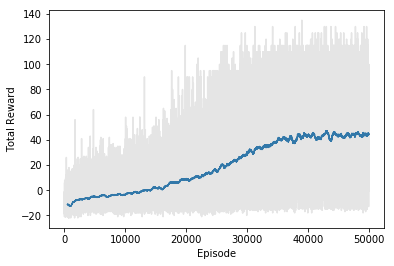

In [103]:
reward_plot()

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [102]:
def reward_plot(num_to_smooth=500, alpha=0.2):
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, num_to_smooth)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.plot(eps, rews, color='grey', alpha=alpha)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    print('Average reward over last {} episodes: {:.2f}'.format(num_to_smooth, np.average(rews[-num_to_smooth:])))

__Findings:__
- The model is clearly training a bit -- with baseline factors, flatlines around 36 avg reward at ~6000 episodes
- Increasing capacity (via nodes size 256) appears to improve speed of learning, but it still flatlines at 36
- 3 layers of 256 does slightly better, achieving flatline after ~39 epochs
- Will decreasing learning rate help?
- Will changing batch size help?
- Reseting all new games helped a lot in the super simple variation

__Possible Next Steps__

*Model / evaluation*
- Create better methods for evaluating how good the performance is [X]
- Add methods for having the trained model play the game as with human watching [X]
- Set up method for systematic hyperparameter search (top HPs = model nodes, model layers, learn rate, decay rate)
- Design early stopping into the model
- Test greater even greater model capacity
- Test methods for restoring models

*Game complexity*
- Add undo action
- Add time penalty associated with undoing too much
- Allow Aces to count for 1
- Allow 5 cards for a clear
- Update scoring to reflect actual scoring
- Allow agent to remember past cards

*Polish*
- Visualize the activation of the nodes -- what do they pick up on
- Compare to a distro of human score
- Create a policy based model


### Playing with the Trained Model

In [119]:
test_episodes = 500
test_max_steps = 52
env.reset(new_game=True)
reward_list = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(0, test_episodes):
        t = 0
        ep_reward = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {simpleQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(simpleQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            print('Action: Pile {}'.format(action+1))
            
            # Take action, get new state and reward
            next_state, reward, done, deck = env.step(action)
            ep_reward += reward
            
            if done:
                t = test_max_steps
                print('Round complete, score of {}. Reseting game...'.format(ep_reward))
                reward_list.append(ep_reward)
                env.reset(new_game=True)
                # Take one random step to get the pole and cart moving
                # state, reward, done, deck = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/simple.ckpt
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 00 | 05 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 00 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 11 | 09 | 00 | 03 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 11 | 09 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 09 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 09 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 09 | 00 | 15 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 13 | 00 | 15 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 16 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 10 | 15 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 16 | 10 | 00 |  Busts: 0  |

Action: Pile 3
Piles: | 11 | 09 | 09 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 09 | 09 | 18 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 00 | 09 | 16 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 09 | 16 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 10 | 09 | 00 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 09 | 10 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 19 | 10 | 18 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 10 | 19 | 16 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 19 | 16 | 00 |  Busts: 1  |  Next Card: 2  |
Action: Pile 2
Piles: | 10 | 00 | 16 | 00 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 16 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 16 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 10 | 16 | 20 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 1

Action: Pile 4
Piles: | 12 | 00 | 16 | 00 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 12 | 00 | 16 | 02 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 10 | 16 | 02 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 12 | 10 | 00 | 02 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 12 | 10 | 00 | 08 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 10 | 00 | 15 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 10 | 10 | 15 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 12 | 10 | 10 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 10 | 10 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 20 | 10 | 10 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 12 | 20 | 00 | 10 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 12 | 20 | 00 | 16 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 12 | 20 | 11 | 16 |  Busts: 2  |  Next Card: 2  |
Action: Pile 1
Piles: | 14 | 20 

Action: Pile 1
Piles: | 10 | 00 | 10 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 10 | 06 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 10 | 00 | 12 | 06 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 10 | 00 | 00 | 06 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 15 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 05 | 00 | 18 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 09 | 00 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 14 | 00 | 18 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 00 | 00 | 18 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 00

Action: Pile 2
Piles: | 10 | 00 | 08 | 14 |  Busts: 1  |  Next Card: 4  |
Action: Pile 3
Piles: | 10 | 00 | 12 | 14 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 10 | 00 | 12 | 16 |  Busts: 1  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 00 | 12 | 16 |  Busts: 1  |  Next Card: 6  |
Action: Pile 2
Piles: | 12 | 06 | 12 | 16 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 12 | 06 | 00 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 12 | 06 | 11 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 2
Piles: | 12 | 17 | 11 | 16 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 12 | 00 | 11 | 16 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 00 | 00 | 16 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 00 | 10 | 16 |  Busts: 1  |  Next Card: 4  |
Action: Pile 3
Piles: | 12 | 00 | 14 | 16 |  Busts: 1  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 00 | 14 | 16 |  Busts: 1  |  Next Card: 3  |
Action: Pile 2
Piles: | 00 | 03 | 

Action: Pile 4
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 07 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 14 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 00 | 00 | 14 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 10 | 00 | 14 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 12 | 10 | 00 | 16 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 12 | 10 | 06 | 16 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 10 | 06 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 10 | 06 | 16 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 13 | 10 | 06 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 20 | 06 | 16 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 20 | 06 | 16 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 00 | 20 | 14 | 16 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 20 | 

Action: Pile 1
Piles: | 09 | 00 | 14 | 17 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 20 | 00 | 14 | 17 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 20 | 05 | 14 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 15 | 14 | 17 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 00 | 15 | 14 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 15 | 14 | 17 |  Busts: 1  |  Next Card: 7  |
Action: Pile 3
Piles: | 10 | 15 | 00 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 10 | 15 | 05 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 15 | 15 | 17 |  Busts: 1  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 15 | 15 | 17 |  Busts: 1  |  Next Card: 2  |
Action: Pile 2
Piles: | 12 | 17 | 15 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 17 | 15 | 00 |  Busts: 2  |  Next Card: 8  |
Action: Pile 4
Piles: | 12 | 17 | 15 | 08 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 17 |

Action: Pile 1
Piles: | 15 | 20 | 13 | 18 |  Busts: 1  |  Next Card: 5  |
Action: Pile 1
Piles: | 20 | 20 | 13 | 18 |  Busts: 1  |  Next Card: 3  |
Action: Pile 4
Piles: | 20 | 20 | 13 | 00 |  Busts: 1  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 20 | 00 | 00 |  Busts: 1  |  Next Card: 7  |
Action: Pile 4
Piles: | 20 | 20 | 00 | 07 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 20 | 20 | 00 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 20 | 20 | 00 | 00 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 20 | 20 | 00 | 07 |  Busts: 2  |  Next Card: 9  |
Action: Pile 4
Piles: | 20 | 20 | 00 | 16 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Round complete, score of 57.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 15 |  Busts: 0  |  Nex

Piles: | 10 | 17 | 03 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 17 | 13 | 16 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 00 | 13 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 13 | 16 |  Busts: 0  |  Next Card: 11  |
Action: Pile 2
Piles: | 10 | 00 | 13 | 16 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 03 | 13 | 16 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 07 | 13 | 16 |  Busts: 0  |  Next Card: 2  |
Action: Pile 2
Piles: | 10 | 09 | 13 | 16 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 09 | 10 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 126.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 00 | 06 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 06 | 00 | 00 |  Busts: 0  |  Next Card: 10  

Action: Pile 4
Piles: | 13 | 00 | 10 | 09 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 13 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 00 | 10 | 09 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 13 | 00 | 12 | 09 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 13 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 00 | 10 | 09 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 00 | 10 | 09 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 00 | 00 | 12 | 09 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 00 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 06 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 00 | 00 | 09 | 09 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 00 |

Action: Pile 1
Piles: | 13 | 10 | 20 | 14 |  Busts: 1  |  Next Card: 11  |
Action: Pile 2
Piles: | 13 | 00 | 20 | 14 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 00 | 00 | 14 |  Busts: 2  |  Next Card: 3  |
Action: Pile 3
Piles: | 13 | 00 | 03 | 14 |  Busts: 2  |  Next Card: 2  |
Action: Pile 3
Piles: | 13 | 00 | 05 | 14 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 00 | 15 | 14 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 10 | 15 | 14 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 20 | 15 | 14 |  Busts: 2  |  Next Card: 6  |
Action: Pile 3
Piles: | 13 | 20 | 00 | 14 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 13 | 20 | 05 | 14 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 13 | 20 | 05 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 13 | 20 | 05 | 11 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 13 | 20 | 16 | 11 |  Busts: 2  |  Next Card: 9  |
Action: Pile 4
Piles: | 13 | 20

Piles: | 10 | 16 | 09 | 06 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 16 | 09 | 16 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 10 | 16 | 16 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 00 | 16 | 16 |  Busts: 1  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 07 | 16 | 16 |  Busts: 1  |  Next Card: 8  |
Action: Pile 2
Piles: | 10 | 15 | 16 | 16 |  Busts: 1  |  Next Card: 7  |
Action: Pile 1
Piles: | 17 | 15 | 16 | 16 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 15 | 16 | 16 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 15 | 16 | 16 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Round complete, score of -9.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 00 | 10 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 10 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 10 | 00 | 10 | 04 |  Busts: 0  |  Next Card: 11 

Action: Pile 1
Piles: | 11 | 00 | 08 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 11 | 00 | 11 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 11 | 00 | 11 | 04 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 11 | 00 | 00 | 04 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 11 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 11 | 00 | 06 | 13 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 11 | 00 | 06 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 00 | 06 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 00 | 11 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 12 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 00 |

Action: Pile 3
Piles: | 16 | 18 | 20 | 18 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Round complete, score of -13.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 00 | 00 | 11 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 02 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 14 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 09 | 00 | 14 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 14 | 00 | 14 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 00 | 00 | 14 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 10 | 08 | 00 | 14 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 17 | 00 | 14 |  Busts: 0  |  N

Action: Pile 2
Piles: | 00 | 00 | 19 | 00 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 00 | 00 | 19 | 03 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 00 | 00 | 19 | 07 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 00 | 19 | 13 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 96.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 00 | 07 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 07 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 09 | 07 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 09 | 15 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 09 | 15 | 10 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 09 | 15 | 00 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 09 | 15 | 11 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 13 | 15 | 11 | 00 |  Busts: 0  |  Ne

Action: Pile 4
Piles: | 10 | 00 | 13 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 13 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 10 | 13 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 10 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 10 | 00 | 15 |  Busts: 1  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 10 | 00 | 00 |  Busts: 1  |  Next Card: 11  |
Action: Pile 2
Piles: | 00 | 00 | 00 | 00 |  Busts: 1  |  Next Card: 7  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 07 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 07 |  Busts: 1  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 10 |  Busts: 1  |  Next Card: 4  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 14 |  Busts: 1  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 00 |  Busts: 1  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 06 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 10 | 00 |

Piles: | 04 | 00 | 00 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 14 | 00 | 00 | 18 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 14 | 00 | 02 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 14 | 00 | 12 | 18 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 14 | 00 | 12 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 14 | 00 | 12 | 05 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 14 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 14 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 14 | 00 | 00 | 17 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 14 | 09 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 14 | 19 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 14 | 19 | 10 | 17 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 14 | 19 | 10 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 14 | 19 | 10 | 10 |  Bus

Action: Pile 2
Piles: | 10 | 10 | 13 | 10 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 13 | 10 | 13 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 10 | 13 | 20 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 13 | 15 | 13 | 20 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 15 | 13 | 00 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 13 | 15 | 13 | 02 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 15 | 13 | 12 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 13 | 15 | 13 | 16 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 13 | 15 | 00 | 16 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 13 | 15 | 00 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 13 | 15 | 11 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 15 | 00 | 00 |  Busts: 2  |  Next Card: 9  |
Action: Pile 4
Round complete, score of 96.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  N

Action: Pile 2
Piles: | 00 | 11 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 11 | 05 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 11 | 05 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 02 | 11 | 13 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 02 | 11 | 13 | 03 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 07 | 11 | 13 | 03 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 13 | 11 | 13 | 03 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 13 | 11 | 13 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 00 | 13 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 10 | 13 | 12 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 13 | 13 | 13 | 12 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 13 | 19 | 13 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 00 | 13 | 12 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 10 | 

Action: Pile 3
Piles: | 11 | 00 | 08 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 11 | 08 | 08 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 11 | 16 | 08 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 16 | 08 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 16 | 08 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 16 | 08 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 16 | 18 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 16 | 00 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 16 | 03 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 16 | 06 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 16 | 16 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 16 | 00 | 15 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 16 | 10 | 15 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 12 | 1

Piles: | 00 | 10 | 13 | 16 |  Busts: 2  |  Next Card: 4  |
Action: Pile 1
Piles: | 04 | 10 | 13 | 16 |  Busts: 2  |  Next Card: 7  |
Action: Pile 1
Piles: | 11 | 10 | 13 | 16 |  Busts: 2  |  Next Card: 4  |
Action: Pile 2
Piles: | 11 | 14 | 13 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 14 | 13 | 16 |  Busts: 2  |  Next Card: 6  |
Action: Pile 2
Piles: | 00 | 20 | 13 | 16 |  Busts: 2  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 20 | 13 | 16 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 02 | 20 | 00 | 16 |  Busts: 2  |  Next Card: 7  |
Action: Pile 1
Piles: | 09 | 20 | 00 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 09 | 20 | 10 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 09 | 20 | 20 | 16 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 20 | 20 | 20 | 16 |  Busts: 2  |  Next Card: 7  |
Action: Pile 2
Round complete, score of 67.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |


Action: Pile 1
Piles: | 06 | 14 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 06 | 14 | 10 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 10 | 14 | 10 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 10 | 14 | 10 | 05 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 10 | 14 | 10 | 14 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 13 | 14 | 10 | 14 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 14 | 10 | 14 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 14 | 10 | 14 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 14 | 14 | 10 | 14 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 14 | 14 | 00 | 14 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 14 | 14 | 00 | 16 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 14 | 14 | 03 | 16 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 14 | 14 | 09 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 14 | 14 | 

Action: Pile 1
Piles: | 14 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 00 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 08 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 08 | 12 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 08 | 12 | 10 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 12 | 12 | 10 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 12 | 12 | 10 | 03 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 12 | 12 | 12 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 12 | 12 | 13 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 12 | 00 | 12 | 13 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 10 | 12 | 18 |  Busts: 0  |  Next Card: 11  |
Action: Pile 2
Piles: | 12 | 00 | 

Piles: | 10 | 00 | 00 | 17 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 03 | 00 | 17 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 10 | 00 | 17 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 10 | 16 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 10 | 17 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 00 | 10 | 17 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 07 | 10 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 17 | 10 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 17 | 20 | 17 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 17 | 00 | 17 |  Busts: 1  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 17 | 08 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 17 | 18 | 17 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 10 | 17 | 00 | 17 |  Busts: 2  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 17 | 00 | 17 |  Bust

Piles: | 20 | 00 | 19 | 14 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 20 | 00 | 19 | 17 |  Busts: 2  |  Next Card: 2  |
Action: Pile 3
Piles: | 20 | 00 | 00 | 17 |  Busts: 2  |  Next Card: 2  |
Action: Pile 3
Piles: | 20 | 00 | 02 | 17 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 20 | 00 | 13 | 17 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 00 | 00 | 17 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 20 | 00 | 05 | 17 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 20 | 00 | 16 | 17 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 20 | 00 | 00 | 17 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 20 | 00 | 05 | 17 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 20 | 00 | 15 | 17 |  Busts: 2  |  Next Card: 7  |
Action: Pile 2
Piles: | 20 | 07 | 15 | 17 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 17 | 15 | 17 |  Busts: 2  |  Next Card: 4  |
Action: Pile 2
Piles: | 20 | 00 | 15 | 17 |  Bust

Piles: | 10 | 20 | 14 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 20 | 14 | 16 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 20 | 20 | 14 | 19 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 28.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 08 | 00 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 00 | 08 | 06 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 08 | 11 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 00 | 08 | 11 | 03 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 16 | 11 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 16 | 00 | 03 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 00 | 00 | 00 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 9  |


Action: Pile 2
Piles: | 12 | 00 | 06 | 18 |  Busts: 2  |  Next Card: 7  |
Action: Pile 3
Piles: | 12 | 00 | 13 | 18 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 12 | 00 | 00 | 18 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 12 | 00 | 05 | 18 |  Busts: 2  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 00 | 05 | 18 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 05 | 18 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 00 | 15 | 18 |  Busts: 2  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 09 | 15 | 18 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 09 | 15 | 18 |  Busts: 2  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 09 | 15 | 18 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 05 | 09 | 15 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 05 | 19 | 15 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 05 | 19 | 15 | 11 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 05 | 19 

Action: Pile 3
Piles: | 10 | 11 | 06 | 17 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 20 | 06 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 20 | 16 | 17 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 10 | 20 | 16 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 20 | 16 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 00 | 16 | 10 |  Busts: 1  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 16 | 17 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 00 | 16 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 16 | 17 |  Busts: 1  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 09 | 16 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 10 | 09 | 00 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 09 | 10 | 17 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 13 | 09 | 10 | 17 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 13 | 09

Action: Pile 4
Piles: | 12 | 20 | 12 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 12 | 20 | 12 | 08 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 12 | 20 | 12 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 00 | 12 | 12 |  Busts: 1  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 19 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 00 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 05 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 15 |  Busts: 1  |  Next Card: 4  |
Action: Pile 4
Piles: | 12 | 00 | 12 | 19 |  Busts: 1  |  Next Card: 8  |
Action: Pile 2
Piles: | 12 | 08 | 12 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 12 | 13 | 12 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 12 | 18 | 12 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 1
Piles: | 17 | 18 | 12 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 17 | 18 | 1

Piles: | 10 | 16 | 04 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 16 | 12 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 16 | 12 | 15 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 20 | 00 | 12 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 10 | 12 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 10 | 12 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 03 | 10 | 12 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 06 | 10 | 12 | 15 |  Busts: 1  |  Next Card: 11  |
Action: Pile 2
Piles: | 06 | 00 | 12 | 15 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 06 | 00 | 00 | 15 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 06 | 00 | 11 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 06 | 00 | 00 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 16 | 00 | 00 | 15 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 16 | 04 | 00 | 15 |  B

Action: Pile 4
Piles: | 10 | 18 | 15 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 18 | 15 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 18 | 15 | 20 |  Busts: 2  |  Next Card: 8  |
Action: Pile 4
Round complete, score of 11.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 04 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 00 | 00 | 04 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 11 | 00 | 00 | 07 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 11 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 00 | 00 | 09 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 00 | 00 | 07 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 07 | 09 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 07 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 07 | 16 |  Busts: 0  |  

Piles: | 13 | 00 | 15 | 16 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 13 | 00 | 15 | 00 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 13 | 00 | 15 | 02 |  Busts: 1  |  Next Card: 3  |
Action: Pile 4
Piles: | 13 | 00 | 15 | 05 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 13 | 00 | 15 | 10 |  Busts: 1  |  Next Card: 9  |
Action: Pile 2
Piles: | 13 | 09 | 15 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 19 | 15 | 10 |  Busts: 1  |  Next Card: 3  |
Action: Pile 4
Piles: | 13 | 19 | 15 | 13 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 19 | 00 | 13 |  Busts: 2  |  Next Card: 6  |
Action: Pile 3
Piles: | 13 | 19 | 06 | 13 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 19 | 16 | 13 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Round complete, score of 59.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 00 | 00 | 06 | 00 |  Busts: 0  |  Next Card: 11  |


Action: Pile 3
Piles: | 20 | 11 | 04 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 00 | 04 | 20 |  Busts: 2  |  Next Card: 3  |
Action: Pile 3
Piles: | 20 | 00 | 07 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 20 | 00 | 17 | 20 |  Busts: 2  |  Next Card: 7  |
Action: Pile 2
Round complete, score of 91.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 00 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 03 | 00 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 10 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 10 | 16 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 10 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 16 | 10 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 20 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 00 | 10 |  Busts: 1  | 

Action: Pile 4
Piles: | 14 | 13 | 00 | 00 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 14 | 13 | 00 | 05 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 14 | 13 | 00 | 15 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 14 | 13 | 10 | 15 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 14 | 13 | 10 | 17 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 14 | 13 | 20 | 17 |  Busts: 2  |  Next Card: 9  |
Action: Pile 3
Round complete, score of 3.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 00 | 00 | 02 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 02 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 00 | 02 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 02 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 02 | 13 |  Busts: 0  |  Next Card: 11  |
Action: Pile 2
Piles: | 10 | 00 | 02 | 13 |  Busts: 0  |  

Action: Pile 1
Piles: | 00 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 15 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 00 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 09 | 04 | 00 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 09 | 14 | 00 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 09 | 14 | 10 | 18 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 18 | 14 | 10 | 18 |  Busts: 0  |  Next Card: 4  |
Action: Pile 3
Piles: | 18 | 14 | 14 | 18 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 18 | 18 | 14 | 18 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 18 | 18 | 14 | 00 |  Busts: 1  |  Next Card: 6  |
Action: Pile 4
Piles: | 18 | 18 | 14 | 06 |  Busts: 1  |  Next Card: 8  |
Action: Pile 4
Piles: | 18 | 18 | 

Piles: | 10 | 10 | 00 | 00 |  Busts: 1  |  Next Card: 9  |
Action: Pile 4
Piles: | 10 | 10 | 00 | 09 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 10 | 00 | 19 |  Busts: 1  |  Next Card: 6  |
Action: Pile 2
Piles: | 10 | 16 | 00 | 19 |  Busts: 1  |  Next Card: 7  |
Action: Pile 3
Piles: | 10 | 16 | 07 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 16 | 17 | 19 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 10 | 16 | 00 | 19 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 10 | 16 | 00 | 00 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 16 | 00 | 03 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 16 | 00 | 13 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 16 | 00 | 20 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 16 | 08 | 20 |  Busts: 2  |  Next Card: 7  |
Action: Pile 3
Piles: | 10 | 16 | 15 | 20 |  Busts: 2  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 20 | 15 | 20 |  Busts

Action: Pile 4
Piles: | 12 | 14 | 00 | 00 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 12 | 14 | 00 | 04 |  Busts: 2  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 14 | 00 | 04 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 14 | 00 | 04 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 14 | 00 | 10 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 10 | 14 | 00 | 00 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 14 | 00 | 06 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 10 | 14 | 00 | 11 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 14 | 00 | 11 |  Busts: 2  |  Next Card: 7  |
Action: Pile 2
Piles: | 00 | 00 | 00 | 11 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 00 | 05 | 11 |  Busts: 2  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 00 | 10 | 11 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 00 | 10 | 17 |  Busts: 2  |  Next Card: 7  |
Action: Pile 3
Piles: | 00 | 00 | 1

Action: Pile 4
Piles: | 00 | 00 | 15 | 17 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 00 | 00 | 15 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 00 | 15 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 15 | 10 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 15 | 17 |  Busts: 2  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 05 | 15 | 17 |  Busts: 2  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 08 | 15 | 17 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 18 | 15 | 17 |  Busts: 2  |  Next Card: 8  |
Action: Pile 1
Piles: | 18 | 18 | 15 | 17 |  Busts: 2  |  Next Card: 6  |
Action: Pile 3
Piles: | 18 | 18 | 00 | 17 |  Busts: 2  |  Next Card: 3  |
Action: Pile 1
Piles: | 00 | 18 | 00 | 17 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 18 | 00 | 17 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 11 | 18 | 08 | 17 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 18 |

Action: Pile 4
Piles: | 00 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 15 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 05 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 15 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 15 | 10 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 15 | 10 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 20 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 00 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 15 | 03 | 15 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 15 | 06 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 16 | 15 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 12 | 15 | 00 | 15 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 12 | 15

Action: Pile 1
Piles: | 00 | 20 | 13 | 10 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 00 | 20 | 00 | 10 |  Busts: 2  |  Next Card: 8  |
Action: Pile 1
Piles: | 08 | 20 | 00 | 10 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 08 | 20 | 00 | 00 |  Busts: 2  |  Next Card: 9  |
Action: Pile 4
Piles: | 08 | 20 | 00 | 09 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 08 | 20 | 10 | 09 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 18 | 20 | 10 | 09 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 18 | 20 | 10 | 13 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 18 | 20 | 10 | 15 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 18 | 20 | 00 | 15 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 18 | 20 | 00 | 00 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 18 | 20 | 00 | 06 |  Busts: 2  |  Next Card: 8  |
Action: Pile 4
Piles: | 18 | 20 | 00 | 14 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 18 | 20 | 

Piles: | 10 | 00 | 00 | 06 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 00 | 10 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 00 | 20 | 16 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 00 | 20 | 16 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 00 | 20 | 00 |  Busts: 2  |  Next Card: 6  |
Action: Pile 2
Piles: | 00 | 06 | 20 | 00 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Round complete, score of 101.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 13 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 00 | 10 | 08 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 13 | 00 | 13 | 08 |  Busts: 0  |  Next Card: 6  |

Piles: | 10 | 17 | 00 | 13 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 10 | 17 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 08 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 09 | 00 | 13 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 09 | 10 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 19 | 10 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 19 | 20 | 16 |  Bust

Action: Pile 3
Piles: | 00 | 04 | 00 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 04 | 00 | 15 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 13 | 04 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 13 | 14 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 14 | 10 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 13 | 14 | 10 | 17 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 13 | 20 | 10 | 17 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 20 | 10 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 20 | 10 | 17 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 00 | 10 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 10 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 20 | 10 | 17 |  Busts: 1  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 20 | 10 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 12 | 20 

Piles: | 10 | 20 | 17 | 10 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 20 | 17 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 20 | 17 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 12.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 08 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 03 | 08 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 06 | 08 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 09 | 08 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 09 | 18 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 11 | 18 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 18 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 18 | 00 | 05 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 00 | 18 | 00 | 14 |  Busts: 0  |  Next Card: 10  |


Piles: | 10 | 18 | 00 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 18 | 00 | 16 |  Busts: 1  |  Next Card: 9  |
Action: Pile 1
Piles: | 09 | 18 | 00 | 16 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 09 | 18 | 09 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 20 | 18 | 09 | 16 |  Busts: 1  |  Next Card: 3  |
Action: Pile 2
Piles: | 20 | 00 | 09 | 16 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 10 | 09 | 16 |  Busts: 1  |  Next Card: 6  |
Action: Pile 2
Piles: | 20 | 16 | 09 | 16 |  Busts: 1  |  Next Card: 4  |
Action: Pile 3
Piles: | 20 | 16 | 13 | 16 |  Busts: 1  |  Next Card: 7  |
Action: Pile 1
Piles: | 00 | 16 | 13 | 16 |  Busts: 2  |  Next Card: 4  |
Action: Pile 1
Piles: | 04 | 16 | 13 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 14 | 16 | 13 | 16 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 14 | 16 | 00 | 16 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 14 | 16 | 00 | 18 |  Bust

Action: Pile 2
Piles: | 10 | 12 | 00 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 12 | 10 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 12 | 20 | 13 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 12 | 20 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 12 | 20 | 13 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 10 | 12 | 20 | 17 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 12 | 20 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 12 | 00 | 17 |  Busts: 1  |  Next Card: 6  |
Action: Pile 3
Piles: | 12 | 12 | 06 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 12 | 12 | 11 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 12 | 00 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 12 | 10 | 17 |  Busts: 1  |  Next Card: 9  |
Action: Pile 2
Piles: | 12 | 00 | 10 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 0

Action: Pile 2
Piles: | 00 | 00 | 09 | 17 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 00 | 09 | 17 |  Busts: 1  |  Next Card: 9  |
Action: Pile 2
Piles: | 11 | 09 | 09 | 17 |  Busts: 1  |  Next Card: 8  |
Action: Pile 2
Piles: | 11 | 17 | 09 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 17 | 09 | 17 |  Busts: 1  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 17 | 09 | 17 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 05 | 17 | 09 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 1
Piles: | 10 | 17 | 09 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 10 | 17 | 14 | 17 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 17 | 14 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 17 | 14 | 17 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 17 | 14 | 17 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 17 | 14 | 17 |  Busts: 1  |  Next Card: 5  |
Action: Pile 1
Piles: | 15 | 17 

Piles: | 14 | 00 | 14 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 14 | 10 | 14 | 10 |  Busts: 1  |  Next Card: 9  |
Action: Pile 4
Piles: | 14 | 10 | 14 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 14 | 15 | 14 | 19 |  Busts: 1  |  Next Card: 6  |
Action: Pile 2
Piles: | 14 | 00 | 14 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 14 | 10 | 14 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Round complete, score of 96.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 03 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 11  |
Action: Pile 4
Piles: | 03 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 03 | 00 | 00 | 02 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 07 | 00 | 00 | 02 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 09 | 00 | 00 | 02 |  Busts: 0  |  Next Card: 4  |


Action: Pile 1
Piles: | 00 | 12 | 13 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 12 | 13 | 20 |  Busts: 2  |  Next Card: 6  |
Action: Pile 2
Piles: | 10 | 18 | 13 | 20 |  Busts: 2  |  Next Card: 9  |
Action: Pile 1
Piles: | 19 | 18 | 13 | 20 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Round complete, score of 67.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 11 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 00 | 00 | 11 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 02 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 02 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 12 | 00 | 00 | 05 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 12 | 00 | 00 | 08 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 12 | 00 | 00 | 14 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 12 | 00 | 05 | 14 |  Busts: 0  |  Ne

Piles: | 14 | 00 | 17 | 14 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 14 | 00 | 00 | 14 |  Busts: 2  |  Next Card: 7  |
Action: Pile 1
Piles: | 00 | 00 | 00 | 14 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 00 | 00 | 08 | 14 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 08 | 14 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 00 | 16 | 14 |  Busts: 2  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 00 | 16 | 14 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 00 | 00 | 16 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 00 | 10 | 16 | 16 |  Busts: 2  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 10 | 16 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 10 | 16 | 10 |  Busts: 2  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 18 | 16 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 18 | 16 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 18 | 16 | 20 |  Bu

Piles: | 18 | 00 | 00 | 18 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 18 | 10 | 00 | 18 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 18 | 15 | 00 | 18 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 18 | 19 | 00 | 18 |  Busts: 1  |  Next Card: 4  |
Action: Pile 4
Piles: | 18 | 19 | 00 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 3
Piles: | 18 | 19 | 11 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 18 | 19 | 00 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 18 | 19 | 10 | 00 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 18 | 19 | 10 | 06 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 18 | 19 | 10 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 18 | 19 | 20 | 16 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Round complete, score of 37.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 9  

Round complete, score of 20.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 00 | 00 | 07 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 07 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 3
Piles: | 10 | 00 | 11 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 10 | 00 | 11 | 06 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 10 | 00 | 11 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 10 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 10 | 05 | 00 | 13 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 05 | 00 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 15 | 00 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 10 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 20 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 15 | 00 | 13 |  Busts: 1  |  Next Card: 11  

Action: Pile 2
Piles: | 11 | 17 | 00 | 12 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 11 | 00 | 00 | 12 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 11 | 00 | 00 | 17 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 11 | 00 | 02 | 17 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 11 | 00 | 13 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 00 | 13 | 17 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 00 | 09 | 13 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 09 | 13 | 17 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 12 | 13 | 17 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 00 | 13 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 13 | 17 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 10 | 10 | 00 | 17 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 10 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 10 |

Action: Pile 4
Piles: | 10 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 16 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 10 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 02 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 12 | 09 | 00 | 16 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 09 | 03 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 09 | 13 | 16 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 09 | 13 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 09 | 13 | 10 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 09 | 13 | 17 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 12 | 15 | 13 | 17 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 12 | 15 | 13 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 15 | 

Action: Pile 4
Piles: | 10 | 16 | 10 | 09 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 13 | 16 | 10 | 09 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 13 | 16 | 00 | 09 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 16 | 10 | 09 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 16 | 10 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 16 | 10 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 13 | 16 | 10 | 10 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 13 | 16 | 20 | 10 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 13 | 16 | 20 | 13 |  Busts: 2  |  Next Card: 2  |
Action: Pile 2
Piles: | 13 | 18 | 20 | 13 |  Busts: 2  |  Next Card: 2  |
Action: Pile 2
Piles: | 13 | 20 | 20 | 13 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 13 | 20 | 20 | 16 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 49.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  | 

Piles: | 12 | 00 | 05 | 13 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 00 | 15 | 13 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 00 | 15 | 18 |  Busts: 1  |  Next Card: 8  |
Action: Pile 2
Piles: | 12 | 08 | 15 | 18 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 12 | 18 | 15 | 18 |  Busts: 1  |  Next Card: 8  |
Action: Pile 4
Piles: | 12 | 18 | 15 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 12 | 18 | 15 | 11 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 18 | 15 | 00 |  Busts: 2  |  Next Card: 4  |
Action: Pile 4
Piles: | 12 | 18 | 15 | 04 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Piles: | 12 | 18 | 15 | 14 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Round complete, score of 58.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 00 | 00 | 09 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 00 | 00 | 09 | 08 |  Busts: 0  |  Next Card: 10  

Piles: | 12 | 16 | 00 | 13 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 16 | 00 | 20 |  Busts: 2  |  Next Card: 2  |
Action: Pile 2
Piles: | 12 | 18 | 00 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 18 | 10 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 4
Round complete, score of 58.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 10 |  Busts: 0  |  Next Card: 11  |
Action: Pile 4
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 03 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 03 | 00 | 00 | 03 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 05 | 00 | 00 | 03 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 05 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 15 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 15 | 09 | 00 | 13 |  Busts: 0  |  Next Card: 9  |

Piles: | 09 | 09 | 00 | 14 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 09 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 12 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 12 | 17 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 12 | 17 | 10 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 12 | 17 | 12 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 12 | 17 | 12 | 03 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 12 | 17 | 12 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 17 | 12 | 05 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 17 | 12 | 05 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 17 | 12 | 15 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 17 | 12 | 15 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 20 | 17 | 00 | 15 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 20 | 17 | 00 | 17 |  Bus

In [116]:
print('Average episode reward: {:.2f}'.format(np.average(np.array(reward_list))))

Average episode reward: 66.67


### Policy Player Comparison

To evaluate the performance of the above, we can compare this to a simple policy that follows the following rules. The point is not that this is an absolutely optimal policy (it's certainly not), just that this give us some benchmark of how well our model is doing.

Rules
- If we can make 21, do so
- Else if we can make 11, do so
- Else if we can avoid busting, pick randomly among piles that don't bust
- Else, pick randomly

In [117]:
def get_policy_action(state):
    '''
    State is a np array
    state[0] = num busts
    state[1] = pile 1 value
    state[2] = pile 2 value
    state[3] = pile 3 value
    state[4] = pile 4 value
    state[5] = showing card value
    
    Returns an int [0,3] corresponding to one of the four piles to place the card
    '''
    busts, value_1, value_2, value_3, value_4, showing_card = state
    
    # Can we make 21
    if value_1 + showing_card == 21:
        return 0
    if value_2 + showing_card == 21:
        return 1
    if value_3 + showing_card == 21:
        return 2
    if value_4 + showing_card == 21:
        return 3
    
    # Can we make 11
    if value_1 + showing_card == 11:
        return 0
    if value_2 + showing_card == 11:
        return 1
    if value_3 + showing_card == 11:
        return 2
    if value_4 + showing_card == 11:
        return 3
    
    # Can we avoid busting
    possible_actions = []
    if value_1 + showing_card < 21:
        possible_actions.append(0)
    if value_2 + showing_card < 21:
        possible_actions.append(1)
    if value_3 + showing_card < 21:
        possible_actions.append(2)
    if value_4 + showing_card < 21:
        possible_actions.append(3)
        
    if len(possible_actions) > 0:
        return random.choice(possible_actions)
    
    return np.random.randint(4)
    

In [120]:
test_episodes = 500
test_max_steps = 52
env.reset(new_game=True)
pol_reward_list = []

for ep in range(0, test_episodes):
    t = 0
    ep_reward = 0
    while t < test_max_steps:
        env.render() 
            
        # Get action from policy
        action = get_policy_action(state)
        print('Action: Pile {}'.format(action+1))
            
        # Take action, get new state and reward
        next_state, reward, done, deck = env.step(action)
        ep_reward += reward
            
        if done:
            t = test_max_steps
            print('Round complete, score of {}. Reseting game...'.format(ep_reward))
            pol_reward_list.append(ep_reward)
            env.reset(new_game=True)
            # Take one random step to get the pole and cart moving
            # state, reward, done, deck = env.step(env.action_space.sample())

        else:
            state = next_state
            t += 1

Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 00 | 10 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 00 | 10 | 00 | 05 |  Busts: 0  |  Next Card: 9  |
Action: Pile 2
Piles: | 00 | 19 | 00 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 19 | 10 | 05 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 19 | 10 | 15 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 00 | 19 | 13 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 00 | 19 | 00 | 15 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 19 | 00 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 2
Piles: | 10 | 00 | 00 | 15 |  Busts: 0  |  Next Card: 2  |
Action: Pile 4
Piles: | 10 | 00 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 00 | 00 | 17 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 20 | 05 | 00 | 17 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 20 | 11 | 00 | 17 |  Bus

Piles: | 19 | 12 | 20 | 20 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 19 | 17 | 20 | 20 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 17 | 20 | 20 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 17 | 20 | 20 |  Busts: 1  |  Next Card: 8  |
Action: Pile 1
Piles: | 18 | 17 | 20 | 20 |  Busts: 1  |  Next Card: 6  |
Action: Pile 4
Piles: | 18 | 17 | 20 | 00 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 18 | 17 | 20 | 02 |  Busts: 2  |  Next Card: 3  |
Action: Pile 1
Piles: | 00 | 17 | 20 | 02 |  Busts: 2  |  Next Card: 8  |
Action: Pile 4
Piles: | 00 | 17 | 20 | 10 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 00 | 17 | 20 | 00 |  Busts: 2  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 17 | 20 | 00 |  Busts: 2  |  Next Card: 3  |
Action: Pile 4
Piles: | 05 | 17 | 20 | 03 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 15 | 17 | 20 | 03 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 15 | 17 | 20 | 14 |  Bust

Piles: | 00 | 20 | 17 | 11 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 20 | 17 | 00 |  Busts: 1  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 20 | 17 | 00 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 17 | 20 | 17 | 00 |  Busts: 1  |  Next Card: 4  |
Action: Pile 1
Piles: | 00 | 20 | 17 | 00 |  Busts: 1  |  Next Card: 9  |
Action: Pile 4
Piles: | 00 | 20 | 17 | 09 |  Busts: 1  |  Next Card: 9  |
Action: Pile 4
Piles: | 00 | 20 | 17 | 18 |  Busts: 1  |  Next Card: 3  |
Action: Pile 4
Piles: | 00 | 20 | 17 | 00 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 00 | 20 | 20 | 00 |  Busts: 1  |  Next Card: 8  |
Action: Pile 1
Piles: | 08 | 20 | 20 | 00 |  Busts: 1  |  Next Card: 4  |
Action: Pile 1
Piles: | 12 | 20 | 20 | 00 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 12 | 20 | 20 | 05 |  Busts: 1  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 20 | 20 | 05 |  Busts: 1  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 20 | 20 | 11 |  Busts:

Action: Pile 1
Piles: | 20 | 20 | 10 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 20 | 20 | 20 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Round complete, score of 60.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 14 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 14 | 04 | 00 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 14 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 17 | 09 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 17 | 19 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 17 | 19 | 00 | 10 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 17 | 19 | 00 | 17 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 20 | 19 | 00 | 17 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 19 | 08 | 17 |  Busts: 0  |  N

Action: Pile 4
Piles: | 19 | 17 | 20 | 10 |  Busts: 1  |  Next Card: 11  |
Action: Pile 4
Piles: | 19 | 17 | 20 | 00 |  Busts: 1  |  Next Card: 2  |
Action: Pile 1
Piles: | 00 | 17 | 20 | 00 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 00 | 00 | 20 | 00 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 00 | 20 | 10 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 03 | 00 | 20 | 10 |  Busts: 1  |  Next Card: 7  |
Action: Pile 2
Piles: | 03 | 07 | 20 | 10 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 03 | 11 | 20 | 10 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 03 | 00 | 20 | 10 |  Busts: 1  |  Next Card: 11  |
Action: Pile 4
Piles: | 03 | 00 | 20 | 00 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 03 | 05 | 20 | 00 |  Busts: 1  |  Next Card: 6  |
Action: Pile 2
Piles: | 03 | 11 | 20 | 00 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 03 | 00 | 20 | 00 |  Busts: 1  |  Next Card: 4  |
Action: Pile 1
Piles: | 07 | 00 |

Piles: | 16 | 00 | 14 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 16 | 10 | 14 | 10 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 16 | 10 | 00 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 16 | 20 | 00 | 10 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 16 | 20 | 00 | 16 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 16 | 20 | 11 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 16 | 20 | 00 | 16 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 16 | 20 | 06 | 16 |  Busts: 0  |  Next Card: 4  |
Action: Pile 3
Piles: | 16 | 20 | 10 | 16 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 16 | 20 | 19 | 16 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 00 | 20 | 19 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 20 | 19 | 16 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 19 | 20 | 19 | 16 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 19 | 20 | 00 | 16 |  Bu

Action: Pile 4
Piles: | 00 | 00 | 00 | 13 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 00 | 05 | 00 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 05 | 10 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 05 | 20 | 13 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 04 | 05 | 20 | 13 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 04 | 15 | 20 | 13 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 04 | 15 | 20 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 04 | 15 | 20 | 10 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 14 | 15 | 20 | 10 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 00 | 15 | 20 | 10 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 00 | 19 | 20 | 10 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 04 | 19 | 20 | 10 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 10 | 19 | 20 | 10 |  Busts: 0  |  Next Card: 5  |
Action: Pile 1
Piles: | 15 | 19 |

Action: Pile 1
Piles: | 10 | 13 | 04 | 00 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 13 | 04 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 13 | 04 | 06 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 13 | 04 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 13 | 14 | 12 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 00 | 14 | 12 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 00 | 10 | 14 | 12 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 00 | 10 | 14 | 15 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 18 | 14 | 15 |  Busts: 0  |  Next Card: 11  |
Action: Pile 1
Piles: | 11 | 18 | 14 | 15 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 11 | 18 | 19 | 15 |  Busts: 0  |  Next Card: 5  |
Action: Pile 4
Piles: | 11 | 18 | 19 | 20 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 18 | 18 | 19 | 20 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 00 | 18 | 

Piles: | 10 | 00 | 04 | 02 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 04 | 02 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 10 | 10 | 04 | 06 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 10 | 13 | 04 | 06 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 10 | 13 | 04 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 10 | 13 | 04 | 19 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 13 | 04 | 19 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 20 | 13 | 15 | 19 |  Busts: 0  |  Next Card: 11  |
Action: Pile 3
Piles: | 20 | 13 | 00 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 2
Piles: | 20 | 18 | 00 | 19 |  Busts: 1  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 18 | 08 | 19 |  Busts: 1  |  Next Card: 3  |
Action: Pile 2
Piles: | 20 | 00 | 08 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 10 | 08 | 19 |  Busts: 1  |  Next Card: 9  |
Action: Pile 2
Piles: | 20 | 19 | 08 | 19 |  Bu

Action: Pile 2
Piles: | 17 | 10 | 18 | 05 |  Busts: 1  |  Next Card: 7  |
Action: Pile 2
Piles: | 17 | 17 | 18 | 05 |  Busts: 1  |  Next Card: 4  |
Action: Pile 1
Piles: | 00 | 17 | 18 | 05 |  Busts: 1  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 17 | 18 | 05 |  Busts: 1  |  Next Card: 5  |
Action: Pile 4
Piles: | 07 | 17 | 18 | 10 |  Busts: 1  |  Next Card: 8  |
Action: Pile 4
Piles: | 07 | 17 | 18 | 18 |  Busts: 1  |  Next Card: 4  |
Action: Pile 2
Piles: | 07 | 00 | 18 | 18 |  Busts: 1  |  Next Card: 3  |
Action: Pile 3
Piles: | 07 | 00 | 00 | 18 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 07 | 00 | 10 | 18 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 07 | 00 | 10 | 20 |  Busts: 1  |  Next Card: 2  |
Action: Pile 3
Piles: | 07 | 00 | 12 | 20 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 07 | 10 | 12 | 20 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 07 | 10 | 00 | 20 |  Busts: 1  |  Next Card: 10  |
Action: Pile 3
Piles: | 07 | 10 | 1

Action: Pile 4
Piles: | 09 | 19 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 09 | 19 | 00 | 10 |  Busts: 0  |  Next Card: 11  |
Action: Pile 4
Piles: | 09 | 19 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 4
Piles: | 09 | 19 | 00 | 09 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 09 | 19 | 10 | 09 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 12 | 19 | 10 | 09 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 19 | 10 | 16 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 19 | 19 | 10 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 19 | 19 | 20 | 16 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 19 | 20 | 16 |  Busts: 1  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 19 | 20 | 16 |  Busts: 1  |  Next Card: 3  |
Action: Pile 1
Piles: | 10 | 19 | 20 | 16 |  Busts: 1  |  Next Card: 8  |
Action: Pile 1
Piles: | 18 | 19 | 20 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 4
Piles: | 18 | 19 |

Piles: | 18 | 18 | 00 | 19 |  Busts: 1  |  Next Card: 5  |
Action: Pile 3
Piles: | 18 | 18 | 05 | 19 |  Busts: 1  |  Next Card: 11  |
Action: Pile 3
Piles: | 18 | 18 | 16 | 19 |  Busts: 1  |  Next Card: 10  |
Action: Pile 2
Piles: | 18 | 00 | 16 | 19 |  Busts: 2  |  Next Card: 2  |
Action: Pile 4
Piles: | 18 | 00 | 16 | 00 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 18 | 10 | 16 | 00 |  Busts: 2  |  Next Card: 6  |
Action: Pile 2
Piles: | 18 | 16 | 16 | 00 |  Busts: 2  |  Next Card: 3  |
Action: Pile 1
Piles: | 00 | 16 | 16 | 00 |  Busts: 2  |  Next Card: 2  |
Action: Pile 3
Piles: | 00 | 16 | 18 | 00 |  Busts: 2  |  Next Card: 9  |
Action: Pile 1
Piles: | 09 | 16 | 18 | 00 |  Busts: 2  |  Next Card: 5  |
Action: Pile 2
Piles: | 09 | 00 | 18 | 00 |  Busts: 2  |  Next Card: 11  |
Action: Pile 2
Piles: | 09 | 11 | 18 | 00 |  Busts: 2  |  Next Card: 9  |
Action: Pile 4
Piles: | 09 | 11 | 18 | 09 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 09 | 00 | 18 | 09 |  Bus

Action: Pile 1
Piles: | 15 | 18 | 20 | 20 |  Busts: 1  |  Next Card: 9  |
Action: Pile 3
Piles: | 15 | 18 | 00 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Piles: | 15 | 18 | 10 | 20 |  Busts: 2  |  Next Card: 8  |
Action: Pile 3
Piles: | 15 | 18 | 18 | 20 |  Busts: 2  |  Next Card: 2  |
Action: Pile 1
Piles: | 17 | 18 | 18 | 20 |  Busts: 2  |  Next Card: 4  |
Action: Pile 1
Piles: | 00 | 18 | 18 | 20 |  Busts: 2  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 18 | 18 | 20 |  Busts: 2  |  Next Card: 3  |
Action: Pile 2
Piles: | 07 | 00 | 18 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 07 | 10 | 18 | 20 |  Busts: 2  |  Next Card: 4  |
Action: Pile 1
Piles: | 11 | 10 | 18 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 00 | 10 | 18 | 20 |  Busts: 2  |  Next Card: 5  |
Action: Pile 1
Piles: | 05 | 10 | 18 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 1
Piles: | 15 | 10 | 18 | 20 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 15 | 20 |

Action: Pile 4
Piles: | 20 | 00 | 20 | 12 |  Busts: 2  |  Next Card: 8  |
Action: Pile 2
Piles: | 20 | 08 | 20 | 12 |  Busts: 2  |  Next Card: 10  |
Action: Pile 2
Piles: | 20 | 18 | 20 | 12 |  Busts: 2  |  Next Card: 6  |
Action: Pile 4
Piles: | 20 | 18 | 20 | 18 |  Busts: 2  |  Next Card: 10  |
Action: Pile 3
Round complete, score of 54.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 00 | 10 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 00 | 03 | 10 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 3
Piles: | 00 | 03 | 14 | 00 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 03 | 19 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 2
Piles: | 00 | 09 | 19 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 09 | 09 | 19 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 09 | 19 | 19 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 1
Piles: | 12 | 19 | 19 | 00 |  Busts: 0  |  Ne

Action: Pile 2
Piles: | 06 | 11 | 08 | 18 |  Busts: 0  |  Next Card: 6  |
Action: Pile 1
Piles: | 12 | 11 | 08 | 18 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 11 | 08 | 18 |  Busts: 0  |  Next Card: 5  |
Action: Pile 2
Piles: | 00 | 16 | 08 | 18 |  Busts: 0  |  Next Card: 4  |
Action: Pile 2
Piles: | 00 | 20 | 08 | 18 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 00 | 20 | 08 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 00 | 20 | 18 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 4
Piles: | 00 | 20 | 18 | 06 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 00 | 20 | 18 | 16 |  Busts: 0  |  Next Card: 7  |
Action: Pile 1
Piles: | 07 | 20 | 18 | 16 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 17 | 20 | 18 | 16 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 00 | 20 | 18 | 16 |  Busts: 1  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 20 | 18 | 16 |  Busts: 1  |  Next Card: 11  |
Action: Pile 1
Piles: | 00 | 20 |

Piles: | 10 | 00 | 18 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 10 | 10 | 18 | 00 |  Busts: 0  |  Next Card: 2  |
Action: Pile 1
Piles: | 12 | 10 | 18 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 3
Piles: | 12 | 10 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 00 | 10 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 1
Piles: | 09 | 10 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 09 | 20 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 4
Piles: | 09 | 20 | 00 | 10 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 09 | 20 | 00 | 18 |  Busts: 0  |  Next Card: 3  |
Action: Pile 4
Piles: | 09 | 20 | 00 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 19 | 20 | 00 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 3
Piles: | 19 | 20 | 04 | 00 |  Busts: 0  |  Next Card: 6  |
Action: Pile 3
Piles: | 19 | 20 | 10 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 19 | 20 | 10 | 04 |  Bust

Piles: | 00 | 11 | 09 | 13 |  Busts: 0  |  Next Card: 4  |
Action: Pile 4
Piles: | 00 | 11 | 09 | 17 |  Busts: 0  |  Next Card: 7  |
Action: Pile 2
Piles: | 00 | 18 | 09 | 17 |  Busts: 0  |  Next Card: 5  |
Action: Pile 3
Piles: | 00 | 18 | 14 | 17 |  Busts: 0  |  Next Card: 7  |
Action: Pile 3
Piles: | 00 | 18 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 10 | 18 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 1
Piles: | 20 | 18 | 00 | 17 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 20 | 18 | 10 | 17 |  Busts: 0  |  Next Card: 8  |
Action: Pile 3
Piles: | 20 | 18 | 18 | 17 |  Busts: 0  |  Next Card: 2  |
Action: Pile 3
Piles: | 20 | 18 | 20 | 17 |  Busts: 0  |  Next Card: 11  |
Action: Pile 4
Piles: | 20 | 18 | 20 | 00 |  Busts: 1  |  Next Card: 2  |
Action: Pile 4
Piles: | 20 | 18 | 20 | 02 |  Busts: 1  |  Next Card: 11  |
Action: Pile 4
Piles: | 20 | 18 | 20 | 13 |  Busts: 1  |  Next Card: 10  |
Action: Pile 4
Piles: | 20 | 18 | 20 | 00 |  Bu

Piles: | 15 | 20 | 20 | 00 |  Busts: 2  |  Next Card: 7  |
Action: Pile 4
Piles: | 15 | 20 | 20 | 07 |  Busts: 2  |  Next Card: 11  |
Action: Pile 4
Piles: | 15 | 20 | 20 | 18 |  Busts: 2  |  Next Card: 8  |
Action: Pile 2
Round complete, score of 20.0. Reseting game...
Piles: | 00 | 00 | 00 | 00 |  Busts: 0  |  Next Card: 9  |
Action: Pile 3
Piles: | 00 | 00 | 09 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 2
Piles: | 00 | 08 | 09 | 00 |  Busts: 0  |  Next Card: 4  |
Action: Pile 1
Piles: | 04 | 08 | 09 | 00 |  Busts: 0  |  Next Card: 3  |
Action: Pile 2
Piles: | 04 | 11 | 09 | 00 |  Busts: 0  |  Next Card: 10  |
Action: Pile 2
Piles: | 04 | 00 | 09 | 00 |  Busts: 0  |  Next Card: 8  |
Action: Pile 4
Piles: | 04 | 00 | 09 | 08 |  Busts: 0  |  Next Card: 10  |
Action: Pile 3
Piles: | 04 | 00 | 19 | 08 |  Busts: 0  |  Next Card: 8  |
Action: Pile 1
Piles: | 12 | 00 | 19 | 08 |  Busts: 0  |  Next Card: 7  |
Action: Pile 4
Piles: | 12 | 00 | 19 | 15 |  Busts: 0  |  Next Card: 7  |
Ac

In [121]:
print('Average episode reward (network): {:.2f}'.format(np.average(np.array(reward_list))))
print('Average episode reward (policy): {:.2f}'.format(np.average(np.array(pol_reward_list))))

Average episode reward (network): 48.68
Average episode reward (policy): 31.33


WOOHOO!! The network actually outperforms this reasonable policy! The network has evidently learned deep patterns beyond just "make 21 and 11 where possible, and avoid busting". 

## Reflections

Overall, I'm pretty pleased with how this project went.

The biggest things I learned from this are:
* It's probably better to start with too much model capacity and work your way down, rather than the opposite (that way, you can at least confirm the model is working and not worry about the architecture being totally bugged)
* A bit of practice with object oriented programming in my use of the classes


The things I want to learn / get more practice with are:
* Using Tensorboard for systematic hyperparameter search
* 

### Testing Shit

In [806]:
env.reset()
# Take one random step to get the game started
state, reward, done, deck = env.step(env.action_space.sample())

test_max_steps = 20

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    step = 0
    
    ## Episode loop would be here
    
    total_reward = 0
    t = 0
    while t < test_max_steps:
        print('---------------------------------Step: {} | t: {}--------------------------------------'.format(step, t))
        step += 1
        
        # Don't explore / exploit, just use the network
        feed = {simpleQN.inputs_: state.reshape((1, *state.shape))} ##The input is the state
        print('This State: {}'.format(state))        
        
        # We run simpleQN.output, with inputs_ being the state
        # The output is currently softmaxed, so will be length 4, all numbers between 0 and 1
        Qs = sess.run(simpleQN.output, feed_dict=feed) 
        print('Qs: {}'.format(Qs))
                
        #Since the actions are expected to be between 1 and 4 rather than 0 and 3
        action = np.argmax(Qs)
        print('Action: {}'.format(action))
            
        # Take action, get new state and reward
        next_state, reward, done, deck = env.step(action)
        print('Next State: {}'.format(next_state))
        print('Reward: {}'.format(reward))
        print('Done: {}'.format(done))
        print('Deck: {}'.format(deck))
            
        # Add our reward for taking that action
        total_reward += reward
        print('Total Reward: {}'.format(total_reward))

        
        if done:
            # the episode ends so no next state
            print('Done! Adding to memory and reseting.')
            next_state = np.zeros(state.shape)
            t = test_max_steps
                                
            # Add experience to memory
            memory.add((state, action, reward, next_state))
                
            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, deck = env.step(env.action_space.sample())

        else:
            # Add experience to memory
            print('Adding to memory and continuing.')
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1
        
        print('Sampling batches from memory.')
        batch = memory.sample(3)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        
        target_Qs = sess.run(simpleQN.output, feed_dict={simpleQN.inputs_: next_states})
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        target_Qs[episode_ends] = (0, 0, 0, 0)
        print('Target Qs: {}'.format(target_Qs))
        print('Rewards: {}'.format(rewards))
        
        targets = rewards + gamma * np.max(target_Qs, axis=1)
        print('Targets: {}'.format(targets))


---------------------------------Step: 0 | t: 0--------------------------------------
This State: [0 0 0 0 7 5]
Qs: [[ 0.02609831  0.23380557  0.09397548 -1.4609545 ]]
Action: 1
Next State: [ 0  0  5  0  7 10]
Reward: 1.0
Done: False
Deck: [ 6  8 10 10  3 10  3 10  4  2 10 11  4 10  4  8 10  9 10  7 10 10  9  9
  2  7 10 10  6 11  5 10  6 10  8  8  7  3  5  9  6  5 11 11  4  2  2 10
  3]
Total Reward: 1.0
Adding to memory and continuing.
Sampling batches from memory.
Target Qs: [[ 0.860608    0.67950064  2.375141   -2.0610178 ]
 [ 0.          0.          0.          0.        ]
 [ 1.1336614  -0.73586315  3.1906326  -1.3767339 ]]
Rewards: [ 1. -9.  1.]
Targets: [ 3.37514091 -9.          4.19063258]
---------------------------------Step: 1 | t: 1--------------------------------------
This State: [ 0  0  5  0  7 10]
Qs: [[ 0.66319394  0.3032011   0.63435274 -1.7503418 ]]
Action: 0
Next State: [ 0 10  5  0  7  6]
Reward: 1.0
Done: False
Deck: [ 8 10 10  3 10  3 10  4  2 10 11  4 10  4  8 1